In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Network Definition

In [2]:
input_length = 28*28
hidden_0 = 1024
hidden_1 = 1024
hidden_2 = 1024
output_length = 10

In [3]:
class MLP(nn.Module):
    def __init__(self, dropout=0.5):
        super(MLP, self).__init__()
        
        self.input = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=4, min_val=-8.0, max_val=7.0, return_quant_tensor=True)
        
        self.fc0   = qnn.QuantLinear(input_length, hidden_0, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)
        self.bn0   = nn.BatchNorm1d(hidden_0)
        self.act0  = nn.SiLU()
        self.quan0 = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=4, min_val=-8.0, max_val=7.0, return_quant_tensor=True)
        self.drop0 = nn.Dropout(dropout)
        
        self.fc1   = qnn.QuantLinear(hidden_0, hidden_1, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)
        self.bn1   = nn.BatchNorm1d(hidden_1)
        self.act1  = nn.SiLU()
        self.quan1 = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=4, min_val=-8.0, max_val=7.0, return_quant_tensor=True)
        self.drop1 = nn.Dropout(dropout)
        
        self.fc2   = qnn.QuantLinear(hidden_1, hidden_2, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)
        self.bn2   = nn.BatchNorm1d(hidden_2)
        self.act2  = nn.SiLU()
        self.quan2 = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=4, min_val=-8.0, max_val=7.0, return_quant_tensor=True)
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = qnn.QuantLinear(hidden_2, output_length, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)

    def forward(self, x):
        
        out = x.reshape(x.shape[0], -1)
        out = self.input(out)
        out = self.drop0(self.quan0(self.act0(self.bn0(self.fc0(out)))))
        out = self.drop1(self.quan1(self.act1(self.bn1(self.fc1(out)))))
        out = self.drop2(self.quan2(self.act2(self.bn2(self.fc2(out)))))
        out = self.out(out)
        
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MLP(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
    
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3158, Acc: 0.9104 | Val Loss: 0.1774, Acc: 0.9486


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1661, Acc: 0.9534 | Val Loss: 0.1323, Acc: 0.9603


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1245, Acc: 0.9638 | Val Loss: 0.1275, Acc: 0.9656


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0934, Acc: 0.9726 | Val Loss: 0.1322, Acc: 0.9669


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0779, Acc: 0.9769 | Val Loss: 0.1374, Acc: 0.9685


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0689, Acc: 0.9799 | Val Loss: 0.1378, Acc: 0.9690


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9840 | Val Loss: 0.1353, Acc: 0.9702


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9849 | Val Loss: 0.1431, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9878 | Val Loss: 0.1384, Acc: 0.9705


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9881 | Val Loss: 0.1261, Acc: 0.9732


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9896 | Val Loss: 0.1455, Acc: 0.9718


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9904 | Val Loss: 0.1329, Acc: 0.9728


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9900 | Val Loss: 0.1649, Acc: 0.9677


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9914 | Val Loss: 0.1446, Acc: 0.9729


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9921 | Val Loss: 0.1448, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9928 | Val Loss: 0.1443, Acc: 0.9747


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9929 | Val Loss: 0.1462, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9934 | Val Loss: 0.1428, Acc: 0.9739


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9940 | Val Loss: 0.1485, Acc: 0.9731


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9937 | Val Loss: 0.1238, Acc: 0.9760


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9939 | Val Loss: 0.1559, Acc: 0.9745


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9952 | Val Loss: 0.1484, Acc: 0.9744


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9945 | Val Loss: 0.1486, Acc: 0.9754


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9946 | Val Loss: 0.1377, Acc: 0.9757


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9943 | Val Loss: 0.1607, Acc: 0.9760


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9948 | Val Loss: 0.1534, Acc: 0.9767


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9950 | Val Loss: 0.1899, Acc: 0.9745


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9950 | Val Loss: 0.1477, Acc: 0.9768


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9958 | Val Loss: 0.1687, Acc: 0.9764


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9961 | Val Loss: 0.1732, Acc: 0.9732


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9958 | Val Loss: 0.1575, Acc: 0.9751


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9961 | Val Loss: 0.1628, Acc: 0.9775


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9960 | Val Loss: 0.1653, Acc: 0.9736


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9959 | Val Loss: 0.1765, Acc: 0.9769


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9962 | Val Loss: 0.1551, Acc: 0.9756


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9961 | Val Loss: 0.1940, Acc: 0.9747


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9963 | Val Loss: 0.1825, Acc: 0.9758


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9961 | Val Loss: 0.1455, Acc: 0.9771


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9964 | Val Loss: 0.1921, Acc: 0.9751


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9969 | Val Loss: 0.2333, Acc: 0.9739


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9957 | Val Loss: 0.1918, Acc: 0.9749


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9968 | Val Loss: 0.2101, Acc: 0.9752


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9971 | Val Loss: 0.2107, Acc: 0.9767


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9973 | Val Loss: 0.2065, Acc: 0.9767


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9966 | Val Loss: 0.2055, Acc: 0.9751


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9965 | Val Loss: 0.2381, Acc: 0.9749


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9969 | Val Loss: 0.2599, Acc: 0.9740


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9972 | Val Loss: 0.2010, Acc: 0.9750


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9976 | Val Loss: 0.2135, Acc: 0.9740


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9971 | Val Loss: 0.2285, Acc: 0.9764


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9967 | Val Loss: 0.1830, Acc: 0.9776


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9975 | Val Loss: 0.1854, Acc: 0.9762


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9972 | Val Loss: 0.2134, Acc: 0.9765


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9974 | Val Loss: 0.2198, Acc: 0.9753


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9973 | Val Loss: 0.2547, Acc: 0.9740


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9970 | Val Loss: 0.2129, Acc: 0.9757


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9978 | Val Loss: 0.2362, Acc: 0.9783


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9974 | Val Loss: 0.2099, Acc: 0.9780


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9976 | Val Loss: 0.2278, Acc: 0.9758


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9972 | Val Loss: 0.2112, Acc: 0.9750


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9978 | Val Loss: 0.2373, Acc: 0.9772


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9973 | Val Loss: 0.2116, Acc: 0.9766


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9980 | Val Loss: 0.2061, Acc: 0.9774


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9976 | Val Loss: 0.2423, Acc: 0.9754


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9975 | Val Loss: 0.2426, Acc: 0.9767


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9980 | Val Loss: 0.2400, Acc: 0.9772


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9976 | Val Loss: 0.2803, Acc: 0.9732


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9975 | Val Loss: 0.2268, Acc: 0.9756


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9974 | Val Loss: 0.2558, Acc: 0.9752


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9976 | Val Loss: 0.2291, Acc: 0.9781


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9982 | Val Loss: 0.2188, Acc: 0.9759


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9982 | Val Loss: 0.2298, Acc: 0.9774


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9979 | Val Loss: 0.2394, Acc: 0.9770


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9978 | Val Loss: 0.2286, Acc: 0.9784


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9981 | Val Loss: 0.2627, Acc: 0.9758


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9978 | Val Loss: 0.2357, Acc: 0.9769


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9979 | Val Loss: 0.2377, Acc: 0.9779


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9986 | Val Loss: 0.2050, Acc: 0.9767


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9981 | Val Loss: 0.2527, Acc: 0.9758


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9984 | Val Loss: 0.2437, Acc: 0.9752


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9980 | Val Loss: 0.2162, Acc: 0.9744


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9973 | Val Loss: 0.2388, Acc: 0.9791


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9983 | Val Loss: 0.2881, Acc: 0.9756


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9982 | Val Loss: 0.2315, Acc: 0.9765


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9978 | Val Loss: 0.2548, Acc: 0.9743


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9984 | Val Loss: 0.2793, Acc: 0.9771


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9984 | Val Loss: 0.2940, Acc: 0.9743


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9981 | Val Loss: 0.2407, Acc: 0.9763


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9981 | Val Loss: 0.2884, Acc: 0.9762


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9982 | Val Loss: 0.2781, Acc: 0.9761


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9987 | Val Loss: 0.2619, Acc: 0.9774


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9976 | Val Loss: 0.2162, Acc: 0.9765


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9984 | Val Loss: 0.2267, Acc: 0.9778


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9983 | Val Loss: 0.2145, Acc: 0.9764


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9982 | Val Loss: 0.2729, Acc: 0.9758


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9983 | Val Loss: 0.2675, Acc: 0.9758


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9982 | Val Loss: 0.2311, Acc: 0.9762


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9982 | Val Loss: 0.2667, Acc: 0.9751


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9989 | Val Loss: 0.2767, Acc: 0.9775


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9987 | Val Loss: 0.2320, Acc: 0.9775


Final Test Loss: 0.1915 Accuracy: 0.9801


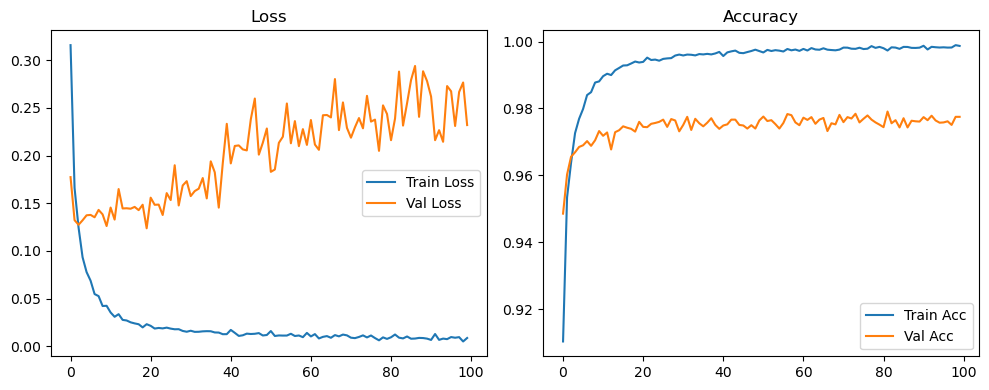

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3458, Acc: 0.9036 | Val Loss: 0.1852, Acc: 0.9474


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1986, Acc: 0.9438 | Val Loss: 0.1575, Acc: 0.9572


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1613, Acc: 0.9544 | Val Loss: 0.1188, Acc: 0.9668


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1312, Acc: 0.9639 | Val Loss: 0.1482, Acc: 0.9623


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1156, Acc: 0.9676 | Val Loss: 0.1272, Acc: 0.9701


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1078, Acc: 0.9696 | Val Loss: 0.1417, Acc: 0.9677


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9728 | Val Loss: 0.1420, Acc: 0.9694


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0863, Acc: 0.9770 | Val Loss: 0.1540, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9772 | Val Loss: 0.1641, Acc: 0.9707


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9799 | Val Loss: 0.1509, Acc: 0.9721


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9811 | Val Loss: 0.1479, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9826 | Val Loss: 0.1771, Acc: 0.9693


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9828 | Val Loss: 0.1766, Acc: 0.9725


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0661, Acc: 0.9841 | Val Loss: 0.1617, Acc: 0.9749


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9855 | Val Loss: 0.1773, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9867 | Val Loss: 0.1585, Acc: 0.9739


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9857 | Val Loss: 0.1877, Acc: 0.9721


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9873 | Val Loss: 0.1702, Acc: 0.9754


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9878 | Val Loss: 0.1784, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9885 | Val Loss: 0.2168, Acc: 0.9736


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9886 | Val Loss: 0.2067, Acc: 0.9755


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9893 | Val Loss: 0.2422, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9905 | Val Loss: 0.2050, Acc: 0.9768


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0574, Acc: 0.9892 | Val Loss: 0.1882, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9894 | Val Loss: 0.2286, Acc: 0.9743


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9903 | Val Loss: 0.2325, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9905 | Val Loss: 0.2532, Acc: 0.9738


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9915 | Val Loss: 0.2316, Acc: 0.9767


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9909 | Val Loss: 0.2238, Acc: 0.9762


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9919 | Val Loss: 0.2436, Acc: 0.9774


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9922 | Val Loss: 0.2419, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9916 | Val Loss: 0.2734, Acc: 0.9765


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9912 | Val Loss: 0.2504, Acc: 0.9752


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9919 | Val Loss: 0.2769, Acc: 0.9756


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9933 | Val Loss: 0.3330, Acc: 0.9728


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9926 | Val Loss: 0.3222, Acc: 0.9730


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9919 | Val Loss: 0.3060, Acc: 0.9758


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9932 | Val Loss: 0.2827, Acc: 0.9757


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9931 | Val Loss: 0.2773, Acc: 0.9788


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9935 | Val Loss: 0.2760, Acc: 0.9781


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9931 | Val Loss: 0.2733, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9930 | Val Loss: 0.3072, Acc: 0.9771


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9936 | Val Loss: 0.3062, Acc: 0.9779


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9936 | Val Loss: 0.3163, Acc: 0.9788


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9941 | Val Loss: 0.3201, Acc: 0.9776


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9943 | Val Loss: 0.3377, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9937 | Val Loss: 0.3009, Acc: 0.9767


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9943 | Val Loss: 0.3268, Acc: 0.9770


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9944 | Val Loss: 0.3855, Acc: 0.9741


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9944 | Val Loss: 0.3539, Acc: 0.9779


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9947 | Val Loss: 0.3584, Acc: 0.9759


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9941 | Val Loss: 0.3455, Acc: 0.9796


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9940 | Val Loss: 0.3221, Acc: 0.9787


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9949 | Val Loss: 0.3179, Acc: 0.9781


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9950 | Val Loss: 0.3094, Acc: 0.9792


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9947 | Val Loss: 0.3606, Acc: 0.9781


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9950 | Val Loss: 0.3350, Acc: 0.9753


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9952 | Val Loss: 0.2871, Acc: 0.9804


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9950 | Val Loss: 0.3747, Acc: 0.9784


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9948 | Val Loss: 0.3419, Acc: 0.9762


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9954 | Val Loss: 0.4196, Acc: 0.9781


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9951 | Val Loss: 0.3893, Acc: 0.9772


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9954 | Val Loss: 0.3672, Acc: 0.9768


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9954 | Val Loss: 0.3608, Acc: 0.9778


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9957 | Val Loss: 0.3340, Acc: 0.9793


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9961 | Val Loss: 0.3568, Acc: 0.9773


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9957 | Val Loss: 0.3990, Acc: 0.9787


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9957 | Val Loss: 0.4013, Acc: 0.9769


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9952 | Val Loss: 0.4392, Acc: 0.9752


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9950 | Val Loss: 0.3645, Acc: 0.9774


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9961 | Val Loss: 0.3480, Acc: 0.9781


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9952 | Val Loss: 0.3789, Acc: 0.9791


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9964 | Val Loss: 0.3698, Acc: 0.9777


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9964 | Val Loss: 0.3931, Acc: 0.9748


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9957 | Val Loss: 0.3866, Acc: 0.9778


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9959 | Val Loss: 0.3737, Acc: 0.9787


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9961 | Val Loss: 0.4037, Acc: 0.9789


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9962 | Val Loss: 0.3700, Acc: 0.9763


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9956 | Val Loss: 0.4014, Acc: 0.9772


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9960 | Val Loss: 0.3995, Acc: 0.9755


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9960 | Val Loss: 0.3272, Acc: 0.9792


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9959 | Val Loss: 0.4280, Acc: 0.9768


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9961 | Val Loss: 0.3961, Acc: 0.9788


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9966 | Val Loss: 0.4175, Acc: 0.9772


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9957 | Val Loss: 0.3611, Acc: 0.9792


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9961 | Val Loss: 0.3941, Acc: 0.9788


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9960 | Val Loss: 0.4502, Acc: 0.9772


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9969 | Val Loss: 0.4753, Acc: 0.9782


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9958 | Val Loss: 0.4174, Acc: 0.9776


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9965 | Val Loss: 0.4401, Acc: 0.9778


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9959 | Val Loss: 0.4629, Acc: 0.9769


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9971 | Val Loss: 0.4924, Acc: 0.9762


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9960 | Val Loss: 0.4187, Acc: 0.9786


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9964 | Val Loss: 0.4369, Acc: 0.9789


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9963 | Val Loss: 0.3884, Acc: 0.9784


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9965 | Val Loss: 0.4198, Acc: 0.9758


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9960 | Val Loss: 0.4071, Acc: 0.9782


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9974 | Val Loss: 0.4479, Acc: 0.9786


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9962 | Val Loss: 0.5091, Acc: 0.9784


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9968 | Val Loss: 0.5921, Acc: 0.9742


Final Test Loss: 0.4788 Accuracy: 0.9766


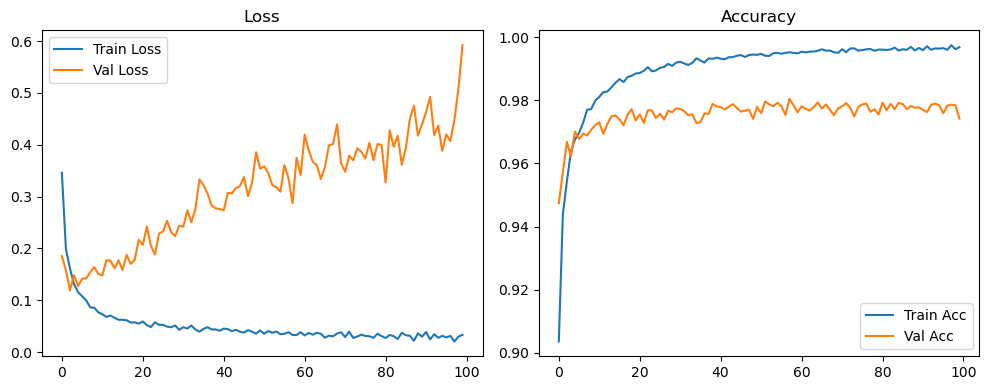

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4522, Acc: 0.8781 | Val Loss: 0.2019, Acc: 0.9443


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3023, Acc: 0.9179 | Val Loss: 0.1620, Acc: 0.9513


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2629, Acc: 0.9306 | Val Loss: 0.1402, Acc: 0.9607


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2400, Acc: 0.9386 | Val Loss: 0.1693, Acc: 0.9603


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2285, Acc: 0.9413 | Val Loss: 0.1342, Acc: 0.9674


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2118, Acc: 0.9467 | Val Loss: 0.1539, Acc: 0.9667


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2099, Acc: 0.9494 | Val Loss: 0.1501, Acc: 0.9656


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1932, Acc: 0.9541 | Val Loss: 0.1555, Acc: 0.9691


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1816, Acc: 0.9576 | Val Loss: 0.1440, Acc: 0.9724


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1866, Acc: 0.9585 | Val Loss: 0.1582, Acc: 0.9690


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1784, Acc: 0.9613 | Val Loss: 0.1506, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1650, Acc: 0.9640 | Val Loss: 0.1743, Acc: 0.9736


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1744, Acc: 0.9638 | Val Loss: 0.1755, Acc: 0.9689


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1640, Acc: 0.9658 | Val Loss: 0.1571, Acc: 0.9728


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1635, Acc: 0.9668 | Val Loss: 0.1667, Acc: 0.9762


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1588, Acc: 0.9686 | Val Loss: 0.1460, Acc: 0.9769


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1562, Acc: 0.9702 | Val Loss: 0.1871, Acc: 0.9718


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9721 | Val Loss: 0.1872, Acc: 0.9756


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1504, Acc: 0.9716 | Val Loss: 0.2185, Acc: 0.9703


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1506, Acc: 0.9723 | Val Loss: 0.1922, Acc: 0.9750


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1435, Acc: 0.9741 | Val Loss: 0.2032, Acc: 0.9740


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1431, Acc: 0.9759 | Val Loss: 0.1971, Acc: 0.9742


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1413, Acc: 0.9763 | Val Loss: 0.1985, Acc: 0.9744


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1444, Acc: 0.9764 | Val Loss: 0.2121, Acc: 0.9757


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1390, Acc: 0.9770 | Val Loss: 0.1872, Acc: 0.9769


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1332, Acc: 0.9773 | Val Loss: 0.2166, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1345, Acc: 0.9784 | Val Loss: 0.2303, Acc: 0.9766


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1555, Acc: 0.9770 | Val Loss: 0.2492, Acc: 0.9735


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1372, Acc: 0.9784 | Val Loss: 0.2368, Acc: 0.9750


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1318, Acc: 0.9794 | Val Loss: 0.2102, Acc: 0.9760


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1328, Acc: 0.9793 | Val Loss: 0.2786, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1232, Acc: 0.9814 | Val Loss: 0.2594, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1203, Acc: 0.9821 | Val Loss: 0.2428, Acc: 0.9782


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1338, Acc: 0.9807 | Val Loss: 0.2507, Acc: 0.9781


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1337, Acc: 0.9812 | Val Loss: 0.2278, Acc: 0.9757


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1257, Acc: 0.9824 | Val Loss: 0.2589, Acc: 0.9764


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1246, Acc: 0.9826 | Val Loss: 0.2629, Acc: 0.9752


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1287, Acc: 0.9819 | Val Loss: 0.2414, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1218, Acc: 0.9834 | Val Loss: 0.2552, Acc: 0.9775


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1185, Acc: 0.9833 | Val Loss: 0.2790, Acc: 0.9784


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1238, Acc: 0.9835 | Val Loss: 0.2893, Acc: 0.9772


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1255, Acc: 0.9838 | Val Loss: 0.2876, Acc: 0.9802


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1146, Acc: 0.9850 | Val Loss: 0.2993, Acc: 0.9778


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1303, Acc: 0.9838 | Val Loss: 0.2931, Acc: 0.9788


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1239, Acc: 0.9841 | Val Loss: 0.2663, Acc: 0.9802


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1212, Acc: 0.9845 | Val Loss: 0.2918, Acc: 0.9770


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9854 | Val Loss: 0.3118, Acc: 0.9772


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1184, Acc: 0.9849 | Val Loss: 0.2925, Acc: 0.9780


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1171, Acc: 0.9851 | Val Loss: 0.3257, Acc: 0.9792


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1097, Acc: 0.9866 | Val Loss: 0.3412, Acc: 0.9792


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.1232, Acc: 0.9858 | Val Loss: 0.2863, Acc: 0.9786


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.1202, Acc: 0.9853 | Val Loss: 0.3020, Acc: 0.9782


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.1198, Acc: 0.9856 | Val Loss: 0.3298, Acc: 0.9765


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.1133, Acc: 0.9864 | Val Loss: 0.3204, Acc: 0.9792


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.1071, Acc: 0.9867 | Val Loss: 0.3296, Acc: 0.9785


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.1193, Acc: 0.9868 | Val Loss: 0.3089, Acc: 0.9787


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.1155, Acc: 0.9871 | Val Loss: 0.3244, Acc: 0.9782


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0952, Acc: 0.9881 | Val Loss: 0.3107, Acc: 0.9791


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.1171, Acc: 0.9874 | Val Loss: 0.3638, Acc: 0.9781


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.1056, Acc: 0.9880 | Val Loss: 0.3265, Acc: 0.9788


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.1172, Acc: 0.9877 | Val Loss: 0.3437, Acc: 0.9797


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.1316, Acc: 0.9864 | Val Loss: 0.3676, Acc: 0.9762


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0965, Acc: 0.9885 | Val Loss: 0.3289, Acc: 0.9797


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.1179, Acc: 0.9874 | Val Loss: 0.3128, Acc: 0.9791


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.1087, Acc: 0.9879 | Val Loss: 0.3779, Acc: 0.9787


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.1068, Acc: 0.9883 | Val Loss: 0.3908, Acc: 0.9778


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0996, Acc: 0.9887 | Val Loss: 0.3606, Acc: 0.9783


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.1073, Acc: 0.9880 | Val Loss: 0.3690, Acc: 0.9778


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.1100, Acc: 0.9881 | Val Loss: 0.3990, Acc: 0.9792


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0946, Acc: 0.9895 | Val Loss: 0.3934, Acc: 0.9794


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.1178, Acc: 0.9884 | Val Loss: 0.3725, Acc: 0.9783


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.1053, Acc: 0.9884 | Val Loss: 0.4005, Acc: 0.9796


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.1064, Acc: 0.9896 | Val Loss: 0.4327, Acc: 0.9788


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.1091, Acc: 0.9892 | Val Loss: 0.4113, Acc: 0.9793


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.1036, Acc: 0.9894 | Val Loss: 0.4476, Acc: 0.9764


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9889 | Val Loss: 0.3745, Acc: 0.9794


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0996, Acc: 0.9891 | Val Loss: 0.4214, Acc: 0.9793


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.1023, Acc: 0.9897 | Val Loss: 0.4208, Acc: 0.9792


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.1114, Acc: 0.9892 | Val Loss: 0.3832, Acc: 0.9800


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.1077, Acc: 0.9905 | Val Loss: 0.3753, Acc: 0.9804


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.1085, Acc: 0.9895 | Val Loss: 0.3877, Acc: 0.9792


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.1085, Acc: 0.9896 | Val Loss: 0.3901, Acc: 0.9800


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.1127, Acc: 0.9894 | Val Loss: 0.3804, Acc: 0.9792


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.1014, Acc: 0.9902 | Val Loss: 0.3844, Acc: 0.9802


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0966, Acc: 0.9899 | Val Loss: 0.4113, Acc: 0.9801


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.1061, Acc: 0.9899 | Val Loss: 0.4065, Acc: 0.9811


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.1098, Acc: 0.9897 | Val Loss: 0.4509, Acc: 0.9790


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.1041, Acc: 0.9901 | Val Loss: 0.4087, Acc: 0.9787


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0966, Acc: 0.9908 | Val Loss: 0.4133, Acc: 0.9798


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.1000, Acc: 0.9907 | Val Loss: 0.4144, Acc: 0.9809


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.1086, Acc: 0.9903 | Val Loss: 0.4014, Acc: 0.9800


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9905 | Val Loss: 0.4412, Acc: 0.9798


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.1012, Acc: 0.9909 | Val Loss: 0.4386, Acc: 0.9801


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9917 | Val Loss: 0.4399, Acc: 0.9783


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.1106, Acc: 0.9909 | Val Loss: 0.4516, Acc: 0.9786


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.1023, Acc: 0.9907 | Val Loss: 0.4527, Acc: 0.9800


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.1122, Acc: 0.9904 | Val Loss: 0.4897, Acc: 0.9788


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.1120, Acc: 0.9905 | Val Loss: 0.4421, Acc: 0.9788


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0895, Acc: 0.9915 | Val Loss: 0.4436, Acc: 0.9800


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0898, Acc: 0.9919 | Val Loss: 0.4739, Acc: 0.9799


Final Test Loss: 0.4579 Accuracy: 0.9821


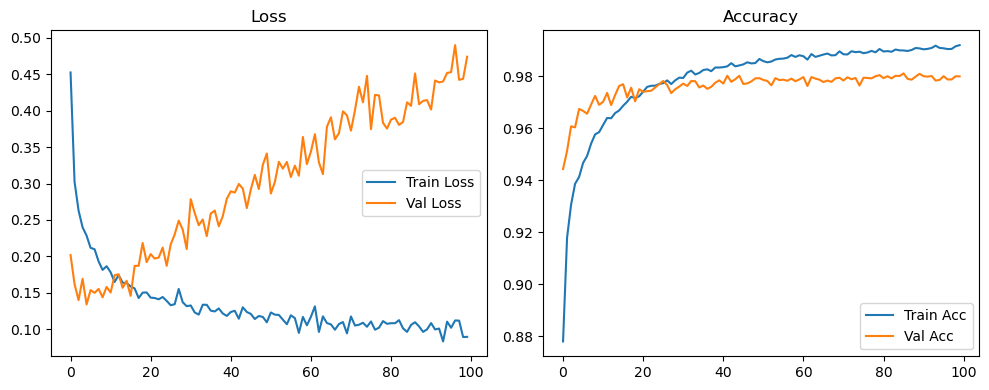

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3158, Acc: 0.9104 | Val Loss: 0.1774, Acc: 0.9486


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1661, Acc: 0.9534 | Val Loss: 0.1323, Acc: 0.9603


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1245, Acc: 0.9638 | Val Loss: 0.1275, Acc: 0.9656


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0934, Acc: 0.9726 | Val Loss: 0.1322, Acc: 0.9669


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0779, Acc: 0.9769 | Val Loss: 0.1374, Acc: 0.9685


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0689, Acc: 0.9799 | Val Loss: 0.1378, Acc: 0.9690


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9840 | Val Loss: 0.1353, Acc: 0.9702


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9849 | Val Loss: 0.1431, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9878 | Val Loss: 0.1384, Acc: 0.9705


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9881 | Val Loss: 0.1261, Acc: 0.9732


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9896 | Val Loss: 0.1455, Acc: 0.9718


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9904 | Val Loss: 0.1329, Acc: 0.9728


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9900 | Val Loss: 0.1649, Acc: 0.9677


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9914 | Val Loss: 0.1446, Acc: 0.9729


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9921 | Val Loss: 0.1448, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9928 | Val Loss: 0.1443, Acc: 0.9747


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9929 | Val Loss: 0.1462, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9934 | Val Loss: 0.1428, Acc: 0.9739


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9940 | Val Loss: 0.1485, Acc: 0.9731


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9937 | Val Loss: 0.1238, Acc: 0.9760


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9939 | Val Loss: 0.1559, Acc: 0.9745


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9952 | Val Loss: 0.1484, Acc: 0.9744


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9945 | Val Loss: 0.1486, Acc: 0.9754


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9946 | Val Loss: 0.1377, Acc: 0.9757


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9943 | Val Loss: 0.1607, Acc: 0.9760


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9948 | Val Loss: 0.1534, Acc: 0.9767


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9950 | Val Loss: 0.1899, Acc: 0.9745


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9950 | Val Loss: 0.1477, Acc: 0.9768


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9958 | Val Loss: 0.1687, Acc: 0.9764


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9961 | Val Loss: 0.1732, Acc: 0.9732


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9958 | Val Loss: 0.1575, Acc: 0.9751


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9961 | Val Loss: 0.1628, Acc: 0.9775


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9960 | Val Loss: 0.1653, Acc: 0.9736


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9959 | Val Loss: 0.1765, Acc: 0.9769


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9962 | Val Loss: 0.1551, Acc: 0.9756


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9961 | Val Loss: 0.1940, Acc: 0.9747


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9963 | Val Loss: 0.1825, Acc: 0.9758


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9961 | Val Loss: 0.1455, Acc: 0.9771


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9964 | Val Loss: 0.1921, Acc: 0.9751


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9969 | Val Loss: 0.2333, Acc: 0.9739


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9957 | Val Loss: 0.1918, Acc: 0.9749


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9968 | Val Loss: 0.2101, Acc: 0.9752


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9971 | Val Loss: 0.2107, Acc: 0.9767


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9973 | Val Loss: 0.2065, Acc: 0.9767


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9966 | Val Loss: 0.2055, Acc: 0.9751


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9965 | Val Loss: 0.2381, Acc: 0.9749


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9969 | Val Loss: 0.2599, Acc: 0.9740


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9972 | Val Loss: 0.2010, Acc: 0.9750


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9976 | Val Loss: 0.2135, Acc: 0.9740


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9971 | Val Loss: 0.2285, Acc: 0.9764


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.1755, Acc: 0.9793


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.2089, Acc: 0.9779


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.2039, Acc: 0.9784


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9987 | Val Loss: 0.2168, Acc: 0.9769


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.2317, Acc: 0.9780


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.2356, Acc: 0.9799


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.2464, Acc: 0.9782


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.2619, Acc: 0.9786


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9991 | Val Loss: 0.2476, Acc: 0.9770


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9989 | Val Loss: 0.2198, Acc: 0.9778


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2435, Acc: 0.9794


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9991 | Val Loss: 0.2224, Acc: 0.9792


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9993 | Val Loss: 0.2405, Acc: 0.9774


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9988 | Val Loss: 0.2275, Acc: 0.9758


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.2244, Acc: 0.9787


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9994 | Val Loss: 0.2163, Acc: 0.9788


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9991 | Val Loss: 0.2219, Acc: 0.9791


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.2498, Acc: 0.9784


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9989 | Val Loss: 0.2568, Acc: 0.9775


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2401, Acc: 0.9793


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9990 | Val Loss: 0.2446, Acc: 0.9798


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.2408, Acc: 0.9812


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.2634, Acc: 0.9798


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.2544, Acc: 0.9783


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.2799, Acc: 0.9785


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9990 | Val Loss: 0.2665, Acc: 0.9772


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9989 | Val Loss: 0.2701, Acc: 0.9790


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9993 | Val Loss: 0.2481, Acc: 0.9786


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9993 | Val Loss: 0.2781, Acc: 0.9791


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9993 | Val Loss: 0.2811, Acc: 0.9778


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.2589, Acc: 0.9796


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.2541, Acc: 0.9808


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.2762, Acc: 0.9796


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.2785, Acc: 0.9793


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2709, Acc: 0.9792


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.2757, Acc: 0.9794


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2769, Acc: 0.9802


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.2708, Acc: 0.9800


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2631, Acc: 0.9804


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2843, Acc: 0.9802


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.2760, Acc: 0.9802


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2673, Acc: 0.9806


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.2616, Acc: 0.9800


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2663, Acc: 0.9806


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2790, Acc: 0.9809


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2734, Acc: 0.9808


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2728, Acc: 0.9810


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.2533, Acc: 0.9813


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2766, Acc: 0.9810


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.2948, Acc: 0.9800


Final Test Loss: 0.2373 Accuracy: 0.9822


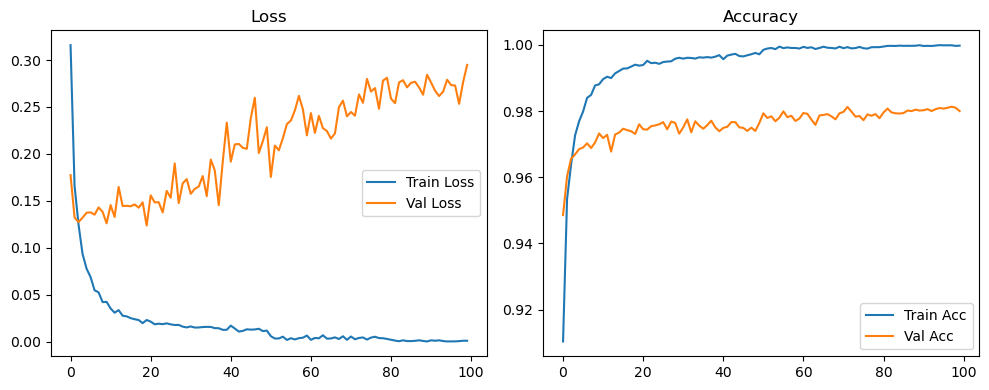

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3458, Acc: 0.9036 | Val Loss: 0.1852, Acc: 0.9474


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1986, Acc: 0.9438 | Val Loss: 0.1575, Acc: 0.9572


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1613, Acc: 0.9544 | Val Loss: 0.1188, Acc: 0.9668


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1312, Acc: 0.9639 | Val Loss: 0.1482, Acc: 0.9623


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1156, Acc: 0.9676 | Val Loss: 0.1272, Acc: 0.9701


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1078, Acc: 0.9696 | Val Loss: 0.1417, Acc: 0.9677


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9728 | Val Loss: 0.1420, Acc: 0.9694


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0863, Acc: 0.9770 | Val Loss: 0.1540, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9772 | Val Loss: 0.1641, Acc: 0.9707


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9799 | Val Loss: 0.1509, Acc: 0.9721


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9811 | Val Loss: 0.1479, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9826 | Val Loss: 0.1771, Acc: 0.9693


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9828 | Val Loss: 0.1766, Acc: 0.9725


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0661, Acc: 0.9841 | Val Loss: 0.1617, Acc: 0.9749


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9855 | Val Loss: 0.1773, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9867 | Val Loss: 0.1585, Acc: 0.9739


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9857 | Val Loss: 0.1877, Acc: 0.9721


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9873 | Val Loss: 0.1702, Acc: 0.9754


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9878 | Val Loss: 0.1784, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9885 | Val Loss: 0.2168, Acc: 0.9736


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9886 | Val Loss: 0.2067, Acc: 0.9755


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9893 | Val Loss: 0.2422, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9905 | Val Loss: 0.2050, Acc: 0.9768


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0574, Acc: 0.9892 | Val Loss: 0.1882, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9894 | Val Loss: 0.2286, Acc: 0.9743


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9903 | Val Loss: 0.2325, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9905 | Val Loss: 0.2532, Acc: 0.9738


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9915 | Val Loss: 0.2316, Acc: 0.9767


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9909 | Val Loss: 0.2238, Acc: 0.9762


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9919 | Val Loss: 0.2436, Acc: 0.9774


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9922 | Val Loss: 0.2419, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9916 | Val Loss: 0.2734, Acc: 0.9765


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9912 | Val Loss: 0.2504, Acc: 0.9752


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9919 | Val Loss: 0.2769, Acc: 0.9756


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9933 | Val Loss: 0.3330, Acc: 0.9728


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9926 | Val Loss: 0.3222, Acc: 0.9730


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9919 | Val Loss: 0.3060, Acc: 0.9758


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9932 | Val Loss: 0.2827, Acc: 0.9757


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9931 | Val Loss: 0.2773, Acc: 0.9788


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9935 | Val Loss: 0.2760, Acc: 0.9781


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9931 | Val Loss: 0.2733, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9930 | Val Loss: 0.3072, Acc: 0.9771


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9936 | Val Loss: 0.3062, Acc: 0.9779


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9936 | Val Loss: 0.3163, Acc: 0.9788


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9941 | Val Loss: 0.3201, Acc: 0.9776


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9943 | Val Loss: 0.3377, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9937 | Val Loss: 0.3009, Acc: 0.9767


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9943 | Val Loss: 0.3268, Acc: 0.9770


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9944 | Val Loss: 0.3855, Acc: 0.9741


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9944 | Val Loss: 0.3539, Acc: 0.9779


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9965 | Val Loss: 0.3040, Acc: 0.9784


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9972 | Val Loss: 0.2723, Acc: 0.9802


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9980 | Val Loss: 0.2998, Acc: 0.9783


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9979 | Val Loss: 0.3050, Acc: 0.9794


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9977 | Val Loss: 0.3293, Acc: 0.9783


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9978 | Val Loss: 0.3206, Acc: 0.9801


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9978 | Val Loss: 0.3393, Acc: 0.9789


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9973 | Val Loss: 0.3229, Acc: 0.9803


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9977 | Val Loss: 0.3231, Acc: 0.9791


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9980 | Val Loss: 0.3299, Acc: 0.9809


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9977 | Val Loss: 0.3549, Acc: 0.9772


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9975 | Val Loss: 0.3445, Acc: 0.9801


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9984 | Val Loss: 0.3405, Acc: 0.9812


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9985 | Val Loss: 0.3692, Acc: 0.9802


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9980 | Val Loss: 0.3776, Acc: 0.9797


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9981 | Val Loss: 0.4200, Acc: 0.9787


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9984 | Val Loss: 0.4392, Acc: 0.9776


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9982 | Val Loss: 0.4043, Acc: 0.9806


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9976 | Val Loss: 0.4091, Acc: 0.9790


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9980 | Val Loss: 0.3643, Acc: 0.9810


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9981 | Val Loss: 0.3709, Acc: 0.9792


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9980 | Val Loss: 0.3678, Acc: 0.9796


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9982 | Val Loss: 0.3639, Acc: 0.9811


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9984 | Val Loss: 0.3725, Acc: 0.9801


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9979 | Val Loss: 0.3766, Acc: 0.9802


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9980 | Val Loss: 0.3969, Acc: 0.9805


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9983 | Val Loss: 0.3522, Acc: 0.9819


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9986 | Val Loss: 0.3838, Acc: 0.9816


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9981 | Val Loss: 0.3993, Acc: 0.9800


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9983 | Val Loss: 0.3712, Acc: 0.9807


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9989 | Val Loss: 0.3904, Acc: 0.9810


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9991 | Val Loss: 0.3708, Acc: 0.9819


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9992 | Val Loss: 0.3496, Acc: 0.9813


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9989 | Val Loss: 0.4021, Acc: 0.9810


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9989 | Val Loss: 0.3511, Acc: 0.9822


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9992 | Val Loss: 0.3719, Acc: 0.9822


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9991 | Val Loss: 0.3978, Acc: 0.9807


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9991 | Val Loss: 0.3928, Acc: 0.9814


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9994 | Val Loss: 0.3886, Acc: 0.9818


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9991 | Val Loss: 0.3961, Acc: 0.9822


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9995 | Val Loss: 0.3797, Acc: 0.9825


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9994 | Val Loss: 0.4296, Acc: 0.9818


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9993 | Val Loss: 0.3826, Acc: 0.9832


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9994 | Val Loss: 0.3660, Acc: 0.9832


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9993 | Val Loss: 0.3734, Acc: 0.9823


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9994 | Val Loss: 0.3818, Acc: 0.9828


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9995 | Val Loss: 0.3721, Acc: 0.9816


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9991 | Val Loss: 0.3873, Acc: 0.9826


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9994 | Val Loss: 0.3926, Acc: 0.9822


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9993 | Val Loss: 0.3742, Acc: 0.9831


Final Test Loss: 0.3421 Accuracy: 0.9830


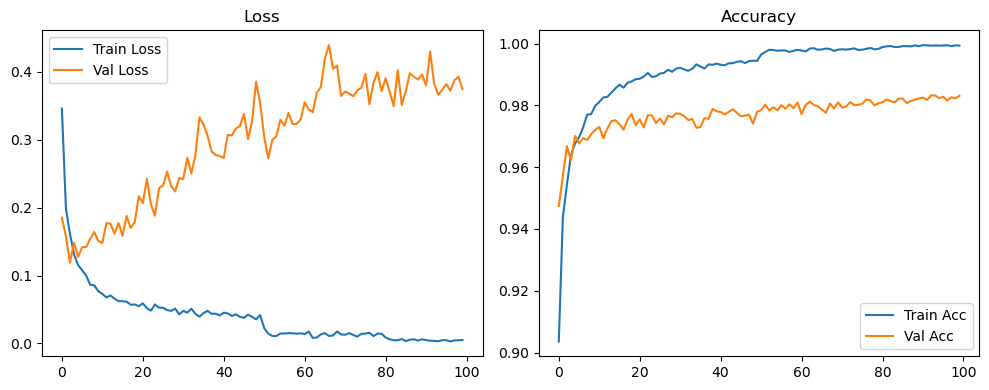

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4522, Acc: 0.8781 | Val Loss: 0.2019, Acc: 0.9443


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3023, Acc: 0.9179 | Val Loss: 0.1620, Acc: 0.9513


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2629, Acc: 0.9306 | Val Loss: 0.1402, Acc: 0.9607


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2400, Acc: 0.9386 | Val Loss: 0.1693, Acc: 0.9603


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2285, Acc: 0.9413 | Val Loss: 0.1342, Acc: 0.9674


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2118, Acc: 0.9467 | Val Loss: 0.1539, Acc: 0.9667


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2099, Acc: 0.9494 | Val Loss: 0.1501, Acc: 0.9656


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1932, Acc: 0.9541 | Val Loss: 0.1555, Acc: 0.9691


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1816, Acc: 0.9576 | Val Loss: 0.1440, Acc: 0.9724


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1866, Acc: 0.9585 | Val Loss: 0.1582, Acc: 0.9690


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1784, Acc: 0.9613 | Val Loss: 0.1506, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1650, Acc: 0.9640 | Val Loss: 0.1743, Acc: 0.9736


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1744, Acc: 0.9638 | Val Loss: 0.1755, Acc: 0.9689


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1640, Acc: 0.9658 | Val Loss: 0.1571, Acc: 0.9728


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1635, Acc: 0.9668 | Val Loss: 0.1667, Acc: 0.9762


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1588, Acc: 0.9686 | Val Loss: 0.1460, Acc: 0.9769


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1562, Acc: 0.9702 | Val Loss: 0.1871, Acc: 0.9718


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9721 | Val Loss: 0.1872, Acc: 0.9756


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1504, Acc: 0.9716 | Val Loss: 0.2185, Acc: 0.9703


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1506, Acc: 0.9723 | Val Loss: 0.1922, Acc: 0.9750


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1435, Acc: 0.9741 | Val Loss: 0.2032, Acc: 0.9740


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1431, Acc: 0.9759 | Val Loss: 0.1971, Acc: 0.9742


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1413, Acc: 0.9763 | Val Loss: 0.1985, Acc: 0.9744


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1444, Acc: 0.9764 | Val Loss: 0.2121, Acc: 0.9757


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1390, Acc: 0.9770 | Val Loss: 0.1872, Acc: 0.9769


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1332, Acc: 0.9773 | Val Loss: 0.2166, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1345, Acc: 0.9784 | Val Loss: 0.2303, Acc: 0.9766


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1555, Acc: 0.9770 | Val Loss: 0.2492, Acc: 0.9735


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1372, Acc: 0.9784 | Val Loss: 0.2368, Acc: 0.9750


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1318, Acc: 0.9794 | Val Loss: 0.2102, Acc: 0.9760


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1328, Acc: 0.9793 | Val Loss: 0.2786, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1232, Acc: 0.9814 | Val Loss: 0.2594, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1203, Acc: 0.9821 | Val Loss: 0.2428, Acc: 0.9782


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1338, Acc: 0.9807 | Val Loss: 0.2507, Acc: 0.9781


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1337, Acc: 0.9812 | Val Loss: 0.2278, Acc: 0.9757


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1257, Acc: 0.9824 | Val Loss: 0.2589, Acc: 0.9764


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1246, Acc: 0.9826 | Val Loss: 0.2629, Acc: 0.9752


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1287, Acc: 0.9819 | Val Loss: 0.2414, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1218, Acc: 0.9834 | Val Loss: 0.2552, Acc: 0.9775


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1185, Acc: 0.9833 | Val Loss: 0.2790, Acc: 0.9784


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1238, Acc: 0.9835 | Val Loss: 0.2893, Acc: 0.9772


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1255, Acc: 0.9838 | Val Loss: 0.2876, Acc: 0.9802


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1146, Acc: 0.9850 | Val Loss: 0.2993, Acc: 0.9778


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1303, Acc: 0.9838 | Val Loss: 0.2931, Acc: 0.9788


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1239, Acc: 0.9841 | Val Loss: 0.2663, Acc: 0.9802


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1212, Acc: 0.9845 | Val Loss: 0.2918, Acc: 0.9770


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9854 | Val Loss: 0.3118, Acc: 0.9772


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1184, Acc: 0.9849 | Val Loss: 0.2925, Acc: 0.9780


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1171, Acc: 0.9851 | Val Loss: 0.3257, Acc: 0.9792


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1097, Acc: 0.9866 | Val Loss: 0.3412, Acc: 0.9792


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0841, Acc: 0.9890 | Val Loss: 0.2639, Acc: 0.9811


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0663, Acc: 0.9909 | Val Loss: 0.2735, Acc: 0.9800


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0688, Acc: 0.9914 | Val Loss: 0.2492, Acc: 0.9802


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9918 | Val Loss: 0.2723, Acc: 0.9806


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9922 | Val Loss: 0.2917, Acc: 0.9802


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0655, Acc: 0.9915 | Val Loss: 0.2814, Acc: 0.9810


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9921 | Val Loss: 0.2989, Acc: 0.9812


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0484, Acc: 0.9928 | Val Loss: 0.2857, Acc: 0.9822


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0536, Acc: 0.9927 | Val Loss: 0.3002, Acc: 0.9812


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9936 | Val Loss: 0.2946, Acc: 0.9821


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0588, Acc: 0.9921 | Val Loss: 0.3033, Acc: 0.9812


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9930 | Val Loss: 0.3197, Acc: 0.9819


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0590, Acc: 0.9925 | Val Loss: 0.2797, Acc: 0.9812


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9935 | Val Loss: 0.2597, Acc: 0.9822


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9931 | Val Loss: 0.3172, Acc: 0.9812


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9940 | Val Loss: 0.3225, Acc: 0.9791


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9933 | Val Loss: 0.3329, Acc: 0.9802


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0540, Acc: 0.9927 | Val Loss: 0.3087, Acc: 0.9808


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9935 | Val Loss: 0.2924, Acc: 0.9818


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9934 | Val Loss: 0.3168, Acc: 0.9816


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0566, Acc: 0.9926 | Val Loss: 0.3049, Acc: 0.9817


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9935 | Val Loss: 0.3214, Acc: 0.9798


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9942 | Val Loss: 0.3050, Acc: 0.9818


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9935 | Val Loss: 0.3260, Acc: 0.9817


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9945 | Val Loss: 0.3703, Acc: 0.9794


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9946 | Val Loss: 0.3501, Acc: 0.9805


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9940 | Val Loss: 0.3300, Acc: 0.9821


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9937 | Val Loss: 0.3502, Acc: 0.9816


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9939 | Val Loss: 0.3169, Acc: 0.9807


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0570, Acc: 0.9935 | Val Loss: 0.3126, Acc: 0.9807


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9944 | Val Loss: 0.2930, Acc: 0.9817


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9947 | Val Loss: 0.2932, Acc: 0.9825


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9956 | Val Loss: 0.2911, Acc: 0.9825


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9960 | Val Loss: 0.2982, Acc: 0.9822


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9957 | Val Loss: 0.2752, Acc: 0.9833


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9964 | Val Loss: 0.3035, Acc: 0.9823


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9964 | Val Loss: 0.3043, Acc: 0.9822


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9966 | Val Loss: 0.2932, Acc: 0.9827


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9964 | Val Loss: 0.3062, Acc: 0.9822


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9968 | Val Loss: 0.3016, Acc: 0.9825


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9965 | Val Loss: 0.2942, Acc: 0.9818


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9964 | Val Loss: 0.3244, Acc: 0.9826


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9963 | Val Loss: 0.3190, Acc: 0.9830


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9972 | Val Loss: 0.2962, Acc: 0.9832


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9974 | Val Loss: 0.3155, Acc: 0.9830


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9974 | Val Loss: 0.3205, Acc: 0.9836


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9972 | Val Loss: 0.3391, Acc: 0.9834


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9968 | Val Loss: 0.3176, Acc: 0.9832


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9974 | Val Loss: 0.3175, Acc: 0.9834


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9972 | Val Loss: 0.3097, Acc: 0.9838


Final Test Loss: 0.2954 Accuracy: 0.9830


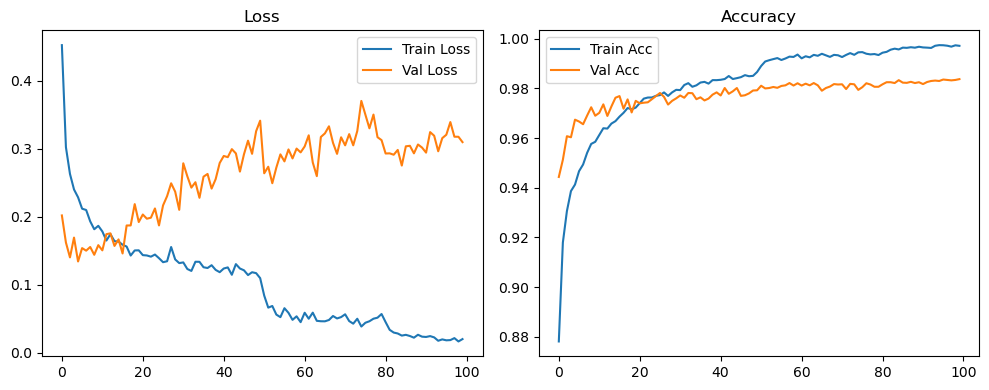

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3158, Acc: 0.9104 | Val Loss: 0.1774, Acc: 0.9486


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1661, Acc: 0.9534 | Val Loss: 0.1323, Acc: 0.9603


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1245, Acc: 0.9638 | Val Loss: 0.1275, Acc: 0.9656


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0934, Acc: 0.9726 | Val Loss: 0.1322, Acc: 0.9669


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0779, Acc: 0.9769 | Val Loss: 0.1374, Acc: 0.9685


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0689, Acc: 0.9799 | Val Loss: 0.1378, Acc: 0.9690


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9840 | Val Loss: 0.1353, Acc: 0.9702


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9849 | Val Loss: 0.1431, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9878 | Val Loss: 0.1384, Acc: 0.9705


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9881 | Val Loss: 0.1261, Acc: 0.9732


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9896 | Val Loss: 0.1455, Acc: 0.9718


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9904 | Val Loss: 0.1329, Acc: 0.9728


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9900 | Val Loss: 0.1649, Acc: 0.9677


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9914 | Val Loss: 0.1446, Acc: 0.9729


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9921 | Val Loss: 0.1448, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9928 | Val Loss: 0.1443, Acc: 0.9747


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9929 | Val Loss: 0.1462, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9934 | Val Loss: 0.1428, Acc: 0.9739


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9940 | Val Loss: 0.1485, Acc: 0.9731


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9937 | Val Loss: 0.1238, Acc: 0.9760


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9939 | Val Loss: 0.1559, Acc: 0.9745


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9952 | Val Loss: 0.1484, Acc: 0.9744


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9945 | Val Loss: 0.1486, Acc: 0.9754


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9946 | Val Loss: 0.1377, Acc: 0.9757


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9943 | Val Loss: 0.1607, Acc: 0.9760


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9948 | Val Loss: 0.1534, Acc: 0.9767


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9950 | Val Loss: 0.1899, Acc: 0.9745


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9950 | Val Loss: 0.1477, Acc: 0.9768


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9958 | Val Loss: 0.1687, Acc: 0.9764


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9961 | Val Loss: 0.1732, Acc: 0.9732


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9958 | Val Loss: 0.1575, Acc: 0.9751


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9961 | Val Loss: 0.1628, Acc: 0.9775


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9960 | Val Loss: 0.1653, Acc: 0.9736


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9959 | Val Loss: 0.1765, Acc: 0.9769


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9962 | Val Loss: 0.1551, Acc: 0.9756


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9961 | Val Loss: 0.1940, Acc: 0.9747


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9963 | Val Loss: 0.1825, Acc: 0.9758


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9961 | Val Loss: 0.1455, Acc: 0.9771


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9964 | Val Loss: 0.1921, Acc: 0.9751


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9969 | Val Loss: 0.2333, Acc: 0.9739


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9957 | Val Loss: 0.1918, Acc: 0.9749


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9968 | Val Loss: 0.2101, Acc: 0.9752


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9971 | Val Loss: 0.2107, Acc: 0.9767


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9973 | Val Loss: 0.2065, Acc: 0.9767


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9966 | Val Loss: 0.2055, Acc: 0.9751


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9965 | Val Loss: 0.2381, Acc: 0.9749


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9969 | Val Loss: 0.2599, Acc: 0.9740


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9972 | Val Loss: 0.2010, Acc: 0.9750


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9976 | Val Loss: 0.2135, Acc: 0.9740


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9971 | Val Loss: 0.2285, Acc: 0.9764


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.1755, Acc: 0.9793


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.2089, Acc: 0.9779


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.2039, Acc: 0.9784


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9987 | Val Loss: 0.2168, Acc: 0.9769


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.2317, Acc: 0.9780


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.2356, Acc: 0.9799


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.2464, Acc: 0.9782


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.2619, Acc: 0.9786


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9991 | Val Loss: 0.2476, Acc: 0.9770


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9989 | Val Loss: 0.2198, Acc: 0.9778


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2435, Acc: 0.9794


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9991 | Val Loss: 0.2224, Acc: 0.9792


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9993 | Val Loss: 0.2405, Acc: 0.9774


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9988 | Val Loss: 0.2275, Acc: 0.9758


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.2244, Acc: 0.9787


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9994 | Val Loss: 0.2163, Acc: 0.9788


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9991 | Val Loss: 0.2219, Acc: 0.9791


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.2498, Acc: 0.9784


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9989 | Val Loss: 0.2568, Acc: 0.9775


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2401, Acc: 0.9793


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9990 | Val Loss: 0.2446, Acc: 0.9798


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.2408, Acc: 0.9812


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.2634, Acc: 0.9798


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.2544, Acc: 0.9783


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.2799, Acc: 0.9785


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9990 | Val Loss: 0.2665, Acc: 0.9772


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9989 | Val Loss: 0.2701, Acc: 0.9790


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9993 | Val Loss: 0.2481, Acc: 0.9786


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9993 | Val Loss: 0.2781, Acc: 0.9791


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9993 | Val Loss: 0.2811, Acc: 0.9778


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.2710, Acc: 0.9799


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2636, Acc: 0.9798


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2751, Acc: 0.9793


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2674, Acc: 0.9788


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9998 | Val Loss: 0.2518, Acc: 0.9795


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2697, Acc: 0.9801


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2472, Acc: 0.9808


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2473, Acc: 0.9814


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2502, Acc: 0.9802


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2786, Acc: 0.9801


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2802, Acc: 0.9806


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2907, Acc: 0.9795


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2574, Acc: 0.9807


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9999 | Val Loss: 0.2618, Acc: 0.9802


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2767, Acc: 0.9802


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2790, Acc: 0.9801


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2721, Acc: 0.9795


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2570, Acc: 0.9804


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2767, Acc: 0.9806


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2817, Acc: 0.9796


Final Test Loss: 0.2269 Accuracy: 0.9835


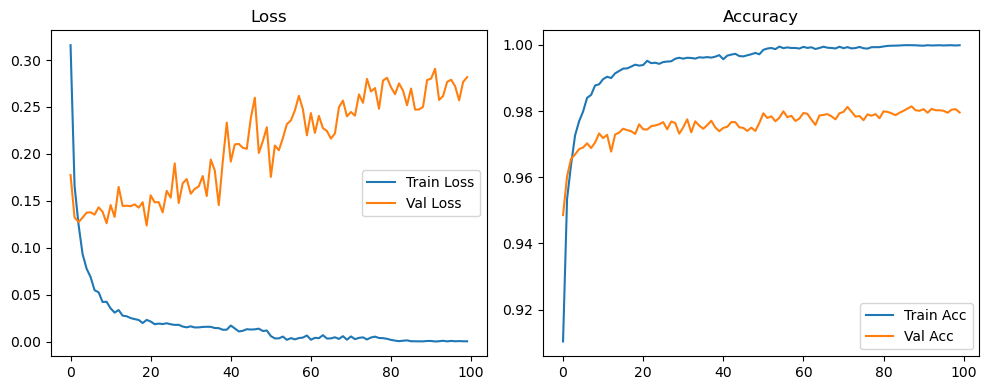

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3458, Acc: 0.9036 | Val Loss: 0.1852, Acc: 0.9474


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1986, Acc: 0.9438 | Val Loss: 0.1575, Acc: 0.9572


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1613, Acc: 0.9544 | Val Loss: 0.1188, Acc: 0.9668


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1312, Acc: 0.9639 | Val Loss: 0.1482, Acc: 0.9623


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1156, Acc: 0.9676 | Val Loss: 0.1272, Acc: 0.9701


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1078, Acc: 0.9696 | Val Loss: 0.1417, Acc: 0.9677


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9728 | Val Loss: 0.1420, Acc: 0.9694


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0863, Acc: 0.9770 | Val Loss: 0.1540, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9772 | Val Loss: 0.1641, Acc: 0.9707


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9799 | Val Loss: 0.1509, Acc: 0.9721


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9811 | Val Loss: 0.1479, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9826 | Val Loss: 0.1771, Acc: 0.9693


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9828 | Val Loss: 0.1766, Acc: 0.9725


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0661, Acc: 0.9841 | Val Loss: 0.1617, Acc: 0.9749


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9855 | Val Loss: 0.1773, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9867 | Val Loss: 0.1585, Acc: 0.9739


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9857 | Val Loss: 0.1877, Acc: 0.9721


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9873 | Val Loss: 0.1702, Acc: 0.9754


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9878 | Val Loss: 0.1784, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9885 | Val Loss: 0.2168, Acc: 0.9736


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9886 | Val Loss: 0.2067, Acc: 0.9755


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9893 | Val Loss: 0.2422, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9905 | Val Loss: 0.2050, Acc: 0.9768


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0574, Acc: 0.9892 | Val Loss: 0.1882, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9894 | Val Loss: 0.2286, Acc: 0.9743


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9903 | Val Loss: 0.2325, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9905 | Val Loss: 0.2532, Acc: 0.9738


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9915 | Val Loss: 0.2316, Acc: 0.9767


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9909 | Val Loss: 0.2238, Acc: 0.9762


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9919 | Val Loss: 0.2436, Acc: 0.9774


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9922 | Val Loss: 0.2419, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9916 | Val Loss: 0.2734, Acc: 0.9765


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9912 | Val Loss: 0.2504, Acc: 0.9752


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9919 | Val Loss: 0.2769, Acc: 0.9756


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9933 | Val Loss: 0.3330, Acc: 0.9728


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9926 | Val Loss: 0.3222, Acc: 0.9730


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9919 | Val Loss: 0.3060, Acc: 0.9758


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9932 | Val Loss: 0.2827, Acc: 0.9757


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9931 | Val Loss: 0.2773, Acc: 0.9788


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9935 | Val Loss: 0.2760, Acc: 0.9781


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9931 | Val Loss: 0.2733, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9930 | Val Loss: 0.3072, Acc: 0.9771


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9936 | Val Loss: 0.3062, Acc: 0.9779


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9936 | Val Loss: 0.3163, Acc: 0.9788


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9941 | Val Loss: 0.3201, Acc: 0.9776


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9943 | Val Loss: 0.3377, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9937 | Val Loss: 0.3009, Acc: 0.9767


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9943 | Val Loss: 0.3268, Acc: 0.9770


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9944 | Val Loss: 0.3855, Acc: 0.9741


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9944 | Val Loss: 0.3539, Acc: 0.9779


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9965 | Val Loss: 0.3040, Acc: 0.9784


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9972 | Val Loss: 0.2723, Acc: 0.9802


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9980 | Val Loss: 0.2998, Acc: 0.9783


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9979 | Val Loss: 0.3050, Acc: 0.9794


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9977 | Val Loss: 0.3293, Acc: 0.9783


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9978 | Val Loss: 0.3206, Acc: 0.9801


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9978 | Val Loss: 0.3393, Acc: 0.9789


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9973 | Val Loss: 0.3229, Acc: 0.9803


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9977 | Val Loss: 0.3231, Acc: 0.9791


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9980 | Val Loss: 0.3299, Acc: 0.9809


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9977 | Val Loss: 0.3549, Acc: 0.9772


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9975 | Val Loss: 0.3445, Acc: 0.9801


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9984 | Val Loss: 0.3405, Acc: 0.9812


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9985 | Val Loss: 0.3692, Acc: 0.9802


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9980 | Val Loss: 0.3776, Acc: 0.9797


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9981 | Val Loss: 0.4200, Acc: 0.9787


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9984 | Val Loss: 0.4392, Acc: 0.9776


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9982 | Val Loss: 0.4043, Acc: 0.9806


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9976 | Val Loss: 0.4091, Acc: 0.9790


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9980 | Val Loss: 0.3643, Acc: 0.9810


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9981 | Val Loss: 0.3709, Acc: 0.9792


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9980 | Val Loss: 0.3678, Acc: 0.9796


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9982 | Val Loss: 0.3639, Acc: 0.9811


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9984 | Val Loss: 0.3725, Acc: 0.9801


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9979 | Val Loss: 0.3766, Acc: 0.9802


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9980 | Val Loss: 0.3969, Acc: 0.9805


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9983 | Val Loss: 0.3522, Acc: 0.9819


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9986 | Val Loss: 0.3838, Acc: 0.9816


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9981 | Val Loss: 0.3993, Acc: 0.9800


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9983 | Val Loss: 0.3712, Acc: 0.9807


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9990 | Val Loss: 0.3729, Acc: 0.9815


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9991 | Val Loss: 0.3613, Acc: 0.9817


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9991 | Val Loss: 0.3499, Acc: 0.9826


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9992 | Val Loss: 0.3526, Acc: 0.9823


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9989 | Val Loss: 0.3514, Acc: 0.9820


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9994 | Val Loss: 0.3675, Acc: 0.9824


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9995 | Val Loss: 0.3791, Acc: 0.9815


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9993 | Val Loss: 0.3637, Acc: 0.9819


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9994 | Val Loss: 0.3825, Acc: 0.9818


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9993 | Val Loss: 0.3604, Acc: 0.9826


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9995 | Val Loss: 0.3524, Acc: 0.9827


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9994 | Val Loss: 0.3692, Acc: 0.9814


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9995 | Val Loss: 0.3578, Acc: 0.9822


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9995 | Val Loss: 0.3533, Acc: 0.9822


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9995 | Val Loss: 0.3643, Acc: 0.9822


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.3654, Acc: 0.9819


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9996 | Val Loss: 0.3561, Acc: 0.9822


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9996 | Val Loss: 0.3610, Acc: 0.9822


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9996 | Val Loss: 0.3619, Acc: 0.9824


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9997 | Val Loss: 0.3556, Acc: 0.9818


Final Test Loss: 0.2973 Accuracy: 0.9842


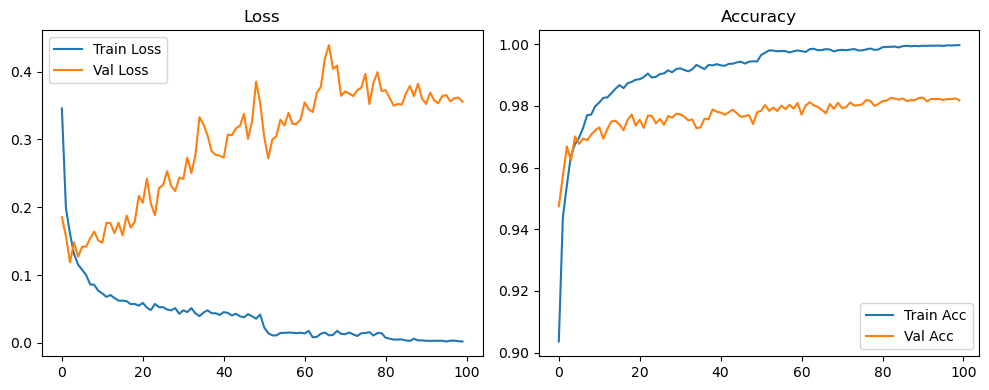

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4522, Acc: 0.8781 | Val Loss: 0.2019, Acc: 0.9443


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3023, Acc: 0.9179 | Val Loss: 0.1620, Acc: 0.9513


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2629, Acc: 0.9306 | Val Loss: 0.1402, Acc: 0.9607


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2400, Acc: 0.9386 | Val Loss: 0.1693, Acc: 0.9603


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2285, Acc: 0.9413 | Val Loss: 0.1342, Acc: 0.9674


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2118, Acc: 0.9467 | Val Loss: 0.1539, Acc: 0.9667


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2099, Acc: 0.9494 | Val Loss: 0.1501, Acc: 0.9656


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1932, Acc: 0.9541 | Val Loss: 0.1555, Acc: 0.9691


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1816, Acc: 0.9576 | Val Loss: 0.1440, Acc: 0.9724


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1866, Acc: 0.9585 | Val Loss: 0.1582, Acc: 0.9690


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1784, Acc: 0.9613 | Val Loss: 0.1506, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1650, Acc: 0.9640 | Val Loss: 0.1743, Acc: 0.9736


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1744, Acc: 0.9638 | Val Loss: 0.1755, Acc: 0.9689


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1640, Acc: 0.9658 | Val Loss: 0.1571, Acc: 0.9728


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1635, Acc: 0.9668 | Val Loss: 0.1667, Acc: 0.9762


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1588, Acc: 0.9686 | Val Loss: 0.1460, Acc: 0.9769


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1562, Acc: 0.9702 | Val Loss: 0.1871, Acc: 0.9718


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9721 | Val Loss: 0.1872, Acc: 0.9756


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1504, Acc: 0.9716 | Val Loss: 0.2185, Acc: 0.9703


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1506, Acc: 0.9723 | Val Loss: 0.1922, Acc: 0.9750


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1435, Acc: 0.9741 | Val Loss: 0.2032, Acc: 0.9740


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1431, Acc: 0.9759 | Val Loss: 0.1971, Acc: 0.9742


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1413, Acc: 0.9763 | Val Loss: 0.1985, Acc: 0.9744


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1444, Acc: 0.9764 | Val Loss: 0.2121, Acc: 0.9757


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1390, Acc: 0.9770 | Val Loss: 0.1872, Acc: 0.9769


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1332, Acc: 0.9773 | Val Loss: 0.2166, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1345, Acc: 0.9784 | Val Loss: 0.2303, Acc: 0.9766


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1555, Acc: 0.9770 | Val Loss: 0.2492, Acc: 0.9735


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1372, Acc: 0.9784 | Val Loss: 0.2368, Acc: 0.9750


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1318, Acc: 0.9794 | Val Loss: 0.2102, Acc: 0.9760


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1328, Acc: 0.9793 | Val Loss: 0.2786, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1232, Acc: 0.9814 | Val Loss: 0.2594, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1203, Acc: 0.9821 | Val Loss: 0.2428, Acc: 0.9782


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1338, Acc: 0.9807 | Val Loss: 0.2507, Acc: 0.9781


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1337, Acc: 0.9812 | Val Loss: 0.2278, Acc: 0.9757


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1257, Acc: 0.9824 | Val Loss: 0.2589, Acc: 0.9764


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1246, Acc: 0.9826 | Val Loss: 0.2629, Acc: 0.9752


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1287, Acc: 0.9819 | Val Loss: 0.2414, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1218, Acc: 0.9834 | Val Loss: 0.2552, Acc: 0.9775


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1185, Acc: 0.9833 | Val Loss: 0.2790, Acc: 0.9784


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1238, Acc: 0.9835 | Val Loss: 0.2893, Acc: 0.9772


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1255, Acc: 0.9838 | Val Loss: 0.2876, Acc: 0.9802


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1146, Acc: 0.9850 | Val Loss: 0.2993, Acc: 0.9778


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1303, Acc: 0.9838 | Val Loss: 0.2931, Acc: 0.9788


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1239, Acc: 0.9841 | Val Loss: 0.2663, Acc: 0.9802


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1212, Acc: 0.9845 | Val Loss: 0.2918, Acc: 0.9770


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9854 | Val Loss: 0.3118, Acc: 0.9772


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1184, Acc: 0.9849 | Val Loss: 0.2925, Acc: 0.9780


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1171, Acc: 0.9851 | Val Loss: 0.3257, Acc: 0.9792


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1097, Acc: 0.9866 | Val Loss: 0.3412, Acc: 0.9792


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0841, Acc: 0.9890 | Val Loss: 0.2639, Acc: 0.9811


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0663, Acc: 0.9909 | Val Loss: 0.2735, Acc: 0.9800


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0688, Acc: 0.9914 | Val Loss: 0.2492, Acc: 0.9802


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9918 | Val Loss: 0.2723, Acc: 0.9806


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9922 | Val Loss: 0.2917, Acc: 0.9802


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0655, Acc: 0.9915 | Val Loss: 0.2814, Acc: 0.9810


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9921 | Val Loss: 0.2989, Acc: 0.9812


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0484, Acc: 0.9928 | Val Loss: 0.2857, Acc: 0.9822


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0536, Acc: 0.9927 | Val Loss: 0.3002, Acc: 0.9812


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9936 | Val Loss: 0.2946, Acc: 0.9821


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0588, Acc: 0.9921 | Val Loss: 0.3033, Acc: 0.9812


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9930 | Val Loss: 0.3197, Acc: 0.9819


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0590, Acc: 0.9925 | Val Loss: 0.2797, Acc: 0.9812


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9935 | Val Loss: 0.2597, Acc: 0.9822


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9931 | Val Loss: 0.3172, Acc: 0.9812


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9940 | Val Loss: 0.3225, Acc: 0.9791


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9933 | Val Loss: 0.3329, Acc: 0.9802


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0540, Acc: 0.9927 | Val Loss: 0.3087, Acc: 0.9808


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9935 | Val Loss: 0.2924, Acc: 0.9818


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9934 | Val Loss: 0.3168, Acc: 0.9816


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0566, Acc: 0.9926 | Val Loss: 0.3049, Acc: 0.9817


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9935 | Val Loss: 0.3214, Acc: 0.9798


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9942 | Val Loss: 0.3050, Acc: 0.9818


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9935 | Val Loss: 0.3260, Acc: 0.9817


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9945 | Val Loss: 0.3703, Acc: 0.9794


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9946 | Val Loss: 0.3501, Acc: 0.9805


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9940 | Val Loss: 0.3300, Acc: 0.9821


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9937 | Val Loss: 0.3502, Acc: 0.9816


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9939 | Val Loss: 0.3169, Acc: 0.9807


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0570, Acc: 0.9935 | Val Loss: 0.3126, Acc: 0.9807


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0439, Acc: 0.9944 | Val Loss: 0.2879, Acc: 0.9812


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9952 | Val Loss: 0.2800, Acc: 0.9832


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9956 | Val Loss: 0.2876, Acc: 0.9829


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9957 | Val Loss: 0.2808, Acc: 0.9824


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9954 | Val Loss: 0.2800, Acc: 0.9822


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9959 | Val Loss: 0.2773, Acc: 0.9829


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9965 | Val Loss: 0.2937, Acc: 0.9827


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9964 | Val Loss: 0.2934, Acc: 0.9822


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9965 | Val Loss: 0.2994, Acc: 0.9824


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9969 | Val Loss: 0.2881, Acc: 0.9820


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9968 | Val Loss: 0.2896, Acc: 0.9828


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9966 | Val Loss: 0.3150, Acc: 0.9820


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9965 | Val Loss: 0.3099, Acc: 0.9822


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9970 | Val Loss: 0.2862, Acc: 0.9832


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9975 | Val Loss: 0.2998, Acc: 0.9832


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9974 | Val Loss: 0.3087, Acc: 0.9828


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9970 | Val Loss: 0.3044, Acc: 0.9827


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9974 | Val Loss: 0.3156, Acc: 0.9832


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9972 | Val Loss: 0.3215, Acc: 0.9832


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9970 | Val Loss: 0.3133, Acc: 0.9832


Final Test Loss: 0.2810 Accuracy: 0.9831


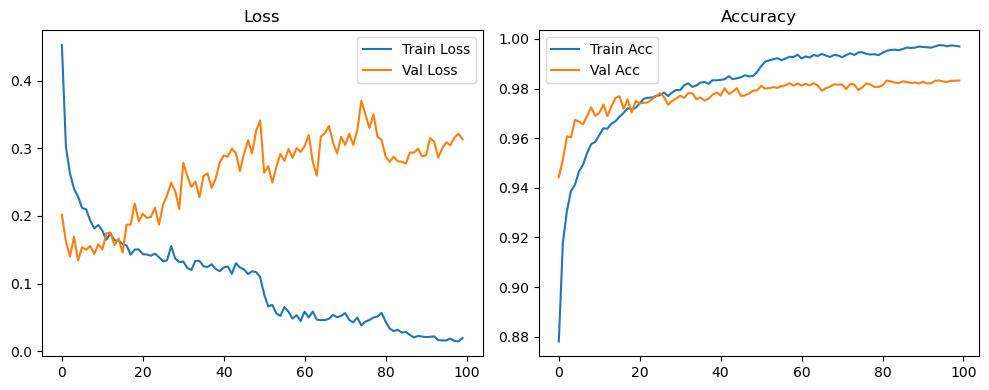

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3158, Acc: 0.9104 | Val Loss: 0.1774, Acc: 0.9486


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1661, Acc: 0.9534 | Val Loss: 0.1323, Acc: 0.9603


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1245, Acc: 0.9638 | Val Loss: 0.1275, Acc: 0.9656


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0934, Acc: 0.9726 | Val Loss: 0.1322, Acc: 0.9669


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0779, Acc: 0.9769 | Val Loss: 0.1374, Acc: 0.9685


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0689, Acc: 0.9799 | Val Loss: 0.1378, Acc: 0.9690


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9840 | Val Loss: 0.1353, Acc: 0.9702


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9849 | Val Loss: 0.1431, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9878 | Val Loss: 0.1384, Acc: 0.9705


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9881 | Val Loss: 0.1261, Acc: 0.9732


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9896 | Val Loss: 0.1455, Acc: 0.9718


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9904 | Val Loss: 0.1329, Acc: 0.9728


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9900 | Val Loss: 0.1649, Acc: 0.9677


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9914 | Val Loss: 0.1446, Acc: 0.9729


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9921 | Val Loss: 0.1448, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9928 | Val Loss: 0.1443, Acc: 0.9747


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9929 | Val Loss: 0.1462, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9934 | Val Loss: 0.1428, Acc: 0.9739


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9940 | Val Loss: 0.1485, Acc: 0.9731


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9937 | Val Loss: 0.1238, Acc: 0.9760


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9939 | Val Loss: 0.1559, Acc: 0.9745


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9952 | Val Loss: 0.1484, Acc: 0.9744


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9945 | Val Loss: 0.1486, Acc: 0.9754


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9946 | Val Loss: 0.1377, Acc: 0.9757


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9943 | Val Loss: 0.1607, Acc: 0.9760


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9948 | Val Loss: 0.1534, Acc: 0.9767


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9950 | Val Loss: 0.1899, Acc: 0.9745


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9950 | Val Loss: 0.1477, Acc: 0.9768


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9958 | Val Loss: 0.1687, Acc: 0.9764


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9961 | Val Loss: 0.1732, Acc: 0.9732


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9958 | Val Loss: 0.1575, Acc: 0.9751


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9961 | Val Loss: 0.1628, Acc: 0.9775


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9960 | Val Loss: 0.1653, Acc: 0.9736


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9959 | Val Loss: 0.1765, Acc: 0.9769


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9962 | Val Loss: 0.1551, Acc: 0.9756


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9961 | Val Loss: 0.1940, Acc: 0.9747


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9963 | Val Loss: 0.1825, Acc: 0.9758


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9961 | Val Loss: 0.1455, Acc: 0.9771


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9964 | Val Loss: 0.1921, Acc: 0.9751


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9969 | Val Loss: 0.2333, Acc: 0.9739


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9957 | Val Loss: 0.1918, Acc: 0.9749


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9968 | Val Loss: 0.2101, Acc: 0.9752


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9971 | Val Loss: 0.2107, Acc: 0.9767


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9973 | Val Loss: 0.2065, Acc: 0.9767


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9966 | Val Loss: 0.2055, Acc: 0.9751


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9965 | Val Loss: 0.2381, Acc: 0.9749


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9969 | Val Loss: 0.2599, Acc: 0.9740


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9972 | Val Loss: 0.2010, Acc: 0.9750


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9976 | Val Loss: 0.2135, Acc: 0.9740


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9971 | Val Loss: 0.2285, Acc: 0.9764


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1810, Acc: 0.9788


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1867, Acc: 0.9782


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1833, Acc: 0.9796


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1844, Acc: 0.9786


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1910, Acc: 0.9789


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.2029, Acc: 0.9796


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2042, Acc: 0.9809


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2097, Acc: 0.9802


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2137, Acc: 0.9808


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.2278, Acc: 0.9792


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2288, Acc: 0.9800


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9996 | Val Loss: 0.2279, Acc: 0.9793


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2226, Acc: 0.9798


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2342, Acc: 0.9807


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2314, Acc: 0.9792


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2337, Acc: 0.9787


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2444, Acc: 0.9792


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.2594, Acc: 0.9783


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2483, Acc: 0.9800


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2526, Acc: 0.9787


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.2708, Acc: 0.9785


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2817, Acc: 0.9784


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2831, Acc: 0.9786


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9998 | Val Loss: 0.2784, Acc: 0.9794


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2691, Acc: 0.9796


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2522, Acc: 0.9798


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2529, Acc: 0.9802


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2583, Acc: 0.9788


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2580, Acc: 0.9805


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.2636, Acc: 0.9798


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2514, Acc: 0.9806


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2607, Acc: 0.9803


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2595, Acc: 0.9796


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2588, Acc: 0.9811


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2498, Acc: 0.9812


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2555, Acc: 0.9813


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2659, Acc: 0.9810


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2495, Acc: 0.9799


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2530, Acc: 0.9815


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2481, Acc: 0.9813


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2701, Acc: 0.9797


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2714, Acc: 0.9798


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2643, Acc: 0.9803


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2620, Acc: 0.9809


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2869, Acc: 0.9811


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2718, Acc: 0.9809


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2826, Acc: 0.9798


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2836, Acc: 0.9796


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2825, Acc: 0.9798


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2803, Acc: 0.9803


Final Test Loss: 0.2280 Accuracy: 0.9842


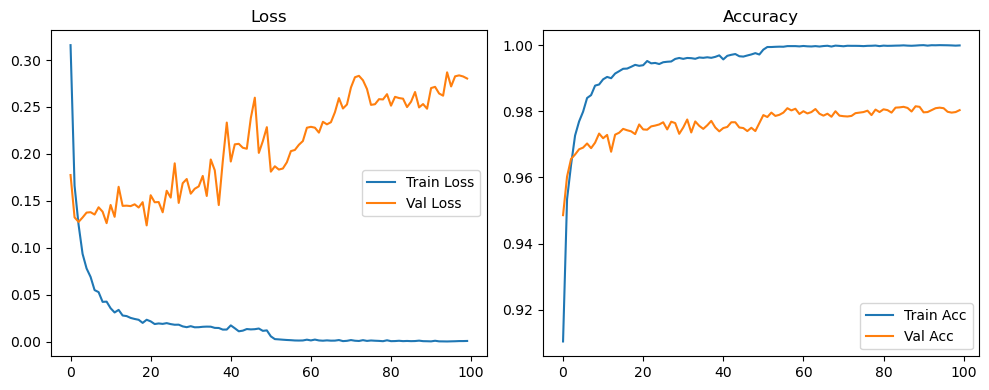

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3458, Acc: 0.9036 | Val Loss: 0.1852, Acc: 0.9474


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1986, Acc: 0.9438 | Val Loss: 0.1575, Acc: 0.9572


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1613, Acc: 0.9544 | Val Loss: 0.1188, Acc: 0.9668


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1312, Acc: 0.9639 | Val Loss: 0.1482, Acc: 0.9623


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1156, Acc: 0.9676 | Val Loss: 0.1272, Acc: 0.9701


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1078, Acc: 0.9696 | Val Loss: 0.1417, Acc: 0.9677


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9728 | Val Loss: 0.1420, Acc: 0.9694


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0863, Acc: 0.9770 | Val Loss: 0.1540, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9772 | Val Loss: 0.1641, Acc: 0.9707


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9799 | Val Loss: 0.1509, Acc: 0.9721


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9811 | Val Loss: 0.1479, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9826 | Val Loss: 0.1771, Acc: 0.9693


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9828 | Val Loss: 0.1766, Acc: 0.9725


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0661, Acc: 0.9841 | Val Loss: 0.1617, Acc: 0.9749


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9855 | Val Loss: 0.1773, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9867 | Val Loss: 0.1585, Acc: 0.9739


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9857 | Val Loss: 0.1877, Acc: 0.9721


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9873 | Val Loss: 0.1702, Acc: 0.9754


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9878 | Val Loss: 0.1784, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9885 | Val Loss: 0.2168, Acc: 0.9736


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9886 | Val Loss: 0.2067, Acc: 0.9755


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9893 | Val Loss: 0.2422, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9905 | Val Loss: 0.2050, Acc: 0.9768


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0574, Acc: 0.9892 | Val Loss: 0.1882, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9894 | Val Loss: 0.2286, Acc: 0.9743


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9903 | Val Loss: 0.2325, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9905 | Val Loss: 0.2532, Acc: 0.9738


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9915 | Val Loss: 0.2316, Acc: 0.9767


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9909 | Val Loss: 0.2238, Acc: 0.9762


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9919 | Val Loss: 0.2436, Acc: 0.9774


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9922 | Val Loss: 0.2419, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9916 | Val Loss: 0.2734, Acc: 0.9765


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9912 | Val Loss: 0.2504, Acc: 0.9752


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9919 | Val Loss: 0.2769, Acc: 0.9756


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9933 | Val Loss: 0.3330, Acc: 0.9728


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9926 | Val Loss: 0.3222, Acc: 0.9730


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9919 | Val Loss: 0.3060, Acc: 0.9758


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9932 | Val Loss: 0.2827, Acc: 0.9757


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9931 | Val Loss: 0.2773, Acc: 0.9788


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9935 | Val Loss: 0.2760, Acc: 0.9781


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9931 | Val Loss: 0.2733, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9930 | Val Loss: 0.3072, Acc: 0.9771


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9936 | Val Loss: 0.3062, Acc: 0.9779


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9936 | Val Loss: 0.3163, Acc: 0.9788


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9941 | Val Loss: 0.3201, Acc: 0.9776


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9943 | Val Loss: 0.3377, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9937 | Val Loss: 0.3009, Acc: 0.9767


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9943 | Val Loss: 0.3268, Acc: 0.9770


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9944 | Val Loss: 0.3855, Acc: 0.9741


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9944 | Val Loss: 0.3539, Acc: 0.9779


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9967 | Val Loss: 0.2756, Acc: 0.9795


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9975 | Val Loss: 0.2849, Acc: 0.9798


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9984 | Val Loss: 0.2828, Acc: 0.9807


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9982 | Val Loss: 0.2774, Acc: 0.9805


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9985 | Val Loss: 0.2799, Acc: 0.9811


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9984 | Val Loss: 0.2756, Acc: 0.9812


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9984 | Val Loss: 0.2822, Acc: 0.9814


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9987 | Val Loss: 0.2617, Acc: 0.9826


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9988 | Val Loss: 0.2686, Acc: 0.9820


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9989 | Val Loss: 0.2788, Acc: 0.9817


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9987 | Val Loss: 0.3015, Acc: 0.9816


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9989 | Val Loss: 0.3048, Acc: 0.9812


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.2844, Acc: 0.9805


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.2970, Acc: 0.9801


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9991 | Val Loss: 0.3079, Acc: 0.9807


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.3474, Acc: 0.9804


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.3265, Acc: 0.9812


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9990 | Val Loss: 0.3377, Acc: 0.9801


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9991 | Val Loss: 0.3404, Acc: 0.9808


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9991 | Val Loss: 0.3416, Acc: 0.9805


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9991 | Val Loss: 0.3127, Acc: 0.9825


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9991 | Val Loss: 0.3403, Acc: 0.9802


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9993 | Val Loss: 0.3480, Acc: 0.9810


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9993 | Val Loss: 0.3264, Acc: 0.9820


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9992 | Val Loss: 0.3282, Acc: 0.9822


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9992 | Val Loss: 0.3219, Acc: 0.9812


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9994 | Val Loss: 0.3430, Acc: 0.9808


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9989 | Val Loss: 0.3356, Acc: 0.9811


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9988 | Val Loss: 0.3347, Acc: 0.9822


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9993 | Val Loss: 0.3438, Acc: 0.9812


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9992 | Val Loss: 0.3255, Acc: 0.9826


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9993 | Val Loss: 0.3240, Acc: 0.9822


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9996 | Val Loss: 0.3204, Acc: 0.9818


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9994 | Val Loss: 0.3347, Acc: 0.9822


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9995 | Val Loss: 0.3100, Acc: 0.9831


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9994 | Val Loss: 0.3243, Acc: 0.9834


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9995 | Val Loss: 0.3322, Acc: 0.9827


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9995 | Val Loss: 0.3138, Acc: 0.9831


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9995 | Val Loss: 0.3289, Acc: 0.9823


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9993 | Val Loss: 0.3295, Acc: 0.9830


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9996 | Val Loss: 0.3144, Acc: 0.9833


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9996 | Val Loss: 0.3318, Acc: 0.9832


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.3297, Acc: 0.9828


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.3203, Acc: 0.9828


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9995 | Val Loss: 0.3514, Acc: 0.9823


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.3398, Acc: 0.9821


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9997 | Val Loss: 0.3278, Acc: 0.9824


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9996 | Val Loss: 0.3320, Acc: 0.9826


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9997 | Val Loss: 0.3241, Acc: 0.9827


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.3288, Acc: 0.9819


Final Test Loss: 0.2850 Accuracy: 0.9840


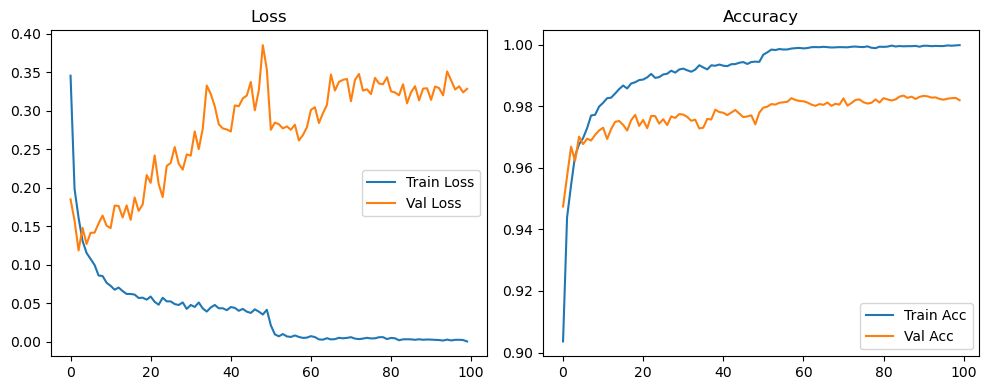

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4522, Acc: 0.8781 | Val Loss: 0.2019, Acc: 0.9443


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3023, Acc: 0.9179 | Val Loss: 0.1620, Acc: 0.9513


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2629, Acc: 0.9306 | Val Loss: 0.1402, Acc: 0.9607


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2400, Acc: 0.9386 | Val Loss: 0.1693, Acc: 0.9603


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2285, Acc: 0.9413 | Val Loss: 0.1342, Acc: 0.9674


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2118, Acc: 0.9467 | Val Loss: 0.1539, Acc: 0.9667


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2099, Acc: 0.9494 | Val Loss: 0.1501, Acc: 0.9656


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1932, Acc: 0.9541 | Val Loss: 0.1555, Acc: 0.9691


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1816, Acc: 0.9576 | Val Loss: 0.1440, Acc: 0.9724


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1866, Acc: 0.9585 | Val Loss: 0.1582, Acc: 0.9690


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1784, Acc: 0.9613 | Val Loss: 0.1506, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1650, Acc: 0.9640 | Val Loss: 0.1743, Acc: 0.9736


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1744, Acc: 0.9638 | Val Loss: 0.1755, Acc: 0.9689


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1640, Acc: 0.9658 | Val Loss: 0.1571, Acc: 0.9728


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1635, Acc: 0.9668 | Val Loss: 0.1667, Acc: 0.9762


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1588, Acc: 0.9686 | Val Loss: 0.1460, Acc: 0.9769


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1562, Acc: 0.9702 | Val Loss: 0.1871, Acc: 0.9718


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9721 | Val Loss: 0.1872, Acc: 0.9756


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1504, Acc: 0.9716 | Val Loss: 0.2185, Acc: 0.9703


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1506, Acc: 0.9723 | Val Loss: 0.1922, Acc: 0.9750


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1435, Acc: 0.9741 | Val Loss: 0.2032, Acc: 0.9740


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1431, Acc: 0.9759 | Val Loss: 0.1971, Acc: 0.9742


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1413, Acc: 0.9763 | Val Loss: 0.1985, Acc: 0.9744


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1444, Acc: 0.9764 | Val Loss: 0.2121, Acc: 0.9757


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1390, Acc: 0.9770 | Val Loss: 0.1872, Acc: 0.9769


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1332, Acc: 0.9773 | Val Loss: 0.2166, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1345, Acc: 0.9784 | Val Loss: 0.2303, Acc: 0.9766


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1555, Acc: 0.9770 | Val Loss: 0.2492, Acc: 0.9735


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1372, Acc: 0.9784 | Val Loss: 0.2368, Acc: 0.9750


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1318, Acc: 0.9794 | Val Loss: 0.2102, Acc: 0.9760


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1328, Acc: 0.9793 | Val Loss: 0.2786, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1232, Acc: 0.9814 | Val Loss: 0.2594, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1203, Acc: 0.9821 | Val Loss: 0.2428, Acc: 0.9782


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1338, Acc: 0.9807 | Val Loss: 0.2507, Acc: 0.9781


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1337, Acc: 0.9812 | Val Loss: 0.2278, Acc: 0.9757


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1257, Acc: 0.9824 | Val Loss: 0.2589, Acc: 0.9764


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1246, Acc: 0.9826 | Val Loss: 0.2629, Acc: 0.9752


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1287, Acc: 0.9819 | Val Loss: 0.2414, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1218, Acc: 0.9834 | Val Loss: 0.2552, Acc: 0.9775


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1185, Acc: 0.9833 | Val Loss: 0.2790, Acc: 0.9784


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1238, Acc: 0.9835 | Val Loss: 0.2893, Acc: 0.9772


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1255, Acc: 0.9838 | Val Loss: 0.2876, Acc: 0.9802


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1146, Acc: 0.9850 | Val Loss: 0.2993, Acc: 0.9778


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1303, Acc: 0.9838 | Val Loss: 0.2931, Acc: 0.9788


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1239, Acc: 0.9841 | Val Loss: 0.2663, Acc: 0.9802


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1212, Acc: 0.9845 | Val Loss: 0.2918, Acc: 0.9770


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9854 | Val Loss: 0.3118, Acc: 0.9772


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1184, Acc: 0.9849 | Val Loss: 0.2925, Acc: 0.9780


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1171, Acc: 0.9851 | Val Loss: 0.3257, Acc: 0.9792


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1097, Acc: 0.9866 | Val Loss: 0.3412, Acc: 0.9792


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0805, Acc: 0.9896 | Val Loss: 0.2862, Acc: 0.9798


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0620, Acc: 0.9914 | Val Loss: 0.2620, Acc: 0.9812


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0608, Acc: 0.9912 | Val Loss: 0.2459, Acc: 0.9813


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0466, Acc: 0.9922 | Val Loss: 0.2567, Acc: 0.9818


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9924 | Val Loss: 0.2567, Acc: 0.9809


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0441, Acc: 0.9929 | Val Loss: 0.2435, Acc: 0.9827


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9934 | Val Loss: 0.2689, Acc: 0.9825


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9939 | Val Loss: 0.2541, Acc: 0.9819


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9941 | Val Loss: 0.2612, Acc: 0.9814


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9946 | Val Loss: 0.2579, Acc: 0.9810


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9941 | Val Loss: 0.2634, Acc: 0.9822


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9948 | Val Loss: 0.2657, Acc: 0.9820


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9951 | Val Loss: 0.2703, Acc: 0.9821


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9951 | Val Loss: 0.2724, Acc: 0.9808


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9951 | Val Loss: 0.2603, Acc: 0.9822


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9956 | Val Loss: 0.2680, Acc: 0.9822


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9952 | Val Loss: 0.2898, Acc: 0.9818


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9957 | Val Loss: 0.2644, Acc: 0.9830


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9955 | Val Loss: 0.2658, Acc: 0.9826


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9962 | Val Loss: 0.2575, Acc: 0.9830


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9954 | Val Loss: 0.2575, Acc: 0.9828


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9952 | Val Loss: 0.2753, Acc: 0.9816


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9960 | Val Loss: 0.2715, Acc: 0.9829


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9954 | Val Loss: 0.2602, Acc: 0.9822


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9962 | Val Loss: 0.2847, Acc: 0.9827


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9966 | Val Loss: 0.2765, Acc: 0.9829


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9960 | Val Loss: 0.2724, Acc: 0.9827


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9958 | Val Loss: 0.2861, Acc: 0.9820


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9965 | Val Loss: 0.2711, Acc: 0.9826


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9960 | Val Loss: 0.2867, Acc: 0.9828


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9959 | Val Loss: 0.2769, Acc: 0.9839


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9967 | Val Loss: 0.2779, Acc: 0.9828


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9963 | Val Loss: 0.2789, Acc: 0.9832


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9971 | Val Loss: 0.2735, Acc: 0.9826


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9969 | Val Loss: 0.2714, Acc: 0.9828


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9968 | Val Loss: 0.2688, Acc: 0.9832


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9969 | Val Loss: 0.2814, Acc: 0.9829


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9969 | Val Loss: 0.2668, Acc: 0.9829


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9972 | Val Loss: 0.2716, Acc: 0.9836


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9972 | Val Loss: 0.2503, Acc: 0.9838


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9975 | Val Loss: 0.2679, Acc: 0.9828


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9968 | Val Loss: 0.2801, Acc: 0.9826


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9973 | Val Loss: 0.2769, Acc: 0.9826


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9972 | Val Loss: 0.2691, Acc: 0.9824


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9975 | Val Loss: 0.2770, Acc: 0.9834


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9978 | Val Loss: 0.2776, Acc: 0.9832


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9971 | Val Loss: 0.2782, Acc: 0.9828


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9977 | Val Loss: 0.2932, Acc: 0.9828


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9977 | Val Loss: 0.2902, Acc: 0.9831


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9980 | Val Loss: 0.2941, Acc: 0.9822


Final Test Loss: 0.2408 Accuracy: 0.9838


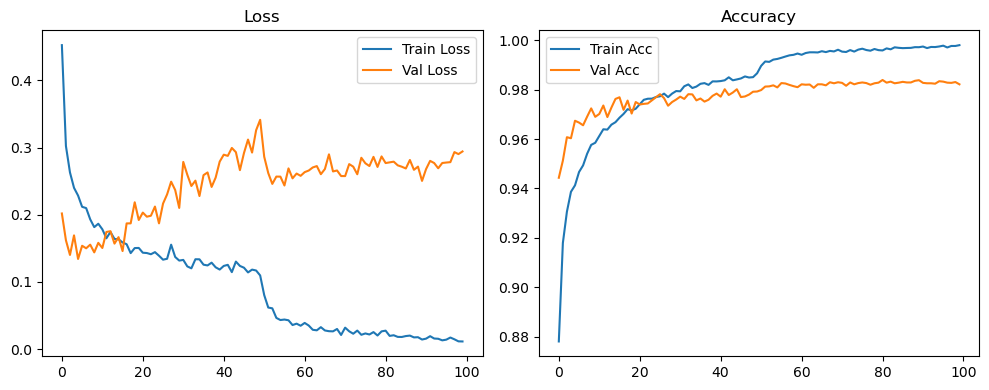

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2852, Acc: 0.9156 | Val Loss: 0.1832, Acc: 0.9487


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1521, Acc: 0.9560 | Val Loss: 0.1362, Acc: 0.9601


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1156, Acc: 0.9656 | Val Loss: 0.1071, Acc: 0.9689


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0900, Acc: 0.9729 | Val Loss: 0.1548, Acc: 0.9600


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0727, Acc: 0.9773 | Val Loss: 0.1147, Acc: 0.9703


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0626, Acc: 0.9816 | Val Loss: 0.1192, Acc: 0.9698


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0543, Acc: 0.9830 | Val Loss: 0.1246, Acc: 0.9703


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9859 | Val Loss: 0.1292, Acc: 0.9693


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9874 | Val Loss: 0.1299, Acc: 0.9702


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9886 | Val Loss: 0.1273, Acc: 0.9712


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9892 | Val Loss: 0.1342, Acc: 0.9689


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9910 | Val Loss: 0.1464, Acc: 0.9689


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9914 | Val Loss: 0.1520, Acc: 0.9716


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.1471, Acc: 0.9724


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9928 | Val Loss: 0.1329, Acc: 0.9722


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9929 | Val Loss: 0.1347, Acc: 0.9751


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.1419, Acc: 0.9748


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9935 | Val Loss: 0.1458, Acc: 0.9744


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9943 | Val Loss: 0.1325, Acc: 0.9753


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9943 | Val Loss: 0.1216, Acc: 0.9768


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1474, Acc: 0.9753


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9949 | Val Loss: 0.1303, Acc: 0.9770


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9952 | Val Loss: 0.1465, Acc: 0.9744


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9953 | Val Loss: 0.1224, Acc: 0.9795


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9957 | Val Loss: 0.1535, Acc: 0.9742


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9954 | Val Loss: 0.1438, Acc: 0.9788


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9959 | Val Loss: 0.1504, Acc: 0.9758


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9954 | Val Loss: 0.1543, Acc: 0.9728


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9962 | Val Loss: 0.1784, Acc: 0.9729


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9968 | Val Loss: 0.1403, Acc: 0.9775


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1596, Acc: 0.9762


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9965 | Val Loss: 0.1515, Acc: 0.9772


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9963 | Val Loss: 0.1624, Acc: 0.9767


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9967 | Val Loss: 0.1529, Acc: 0.9765


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9964 | Val Loss: 0.1594, Acc: 0.9750


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9969 | Val Loss: 0.1672, Acc: 0.9746


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9969 | Val Loss: 0.1783, Acc: 0.9752


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.1810, Acc: 0.9758


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.1925, Acc: 0.9742


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9966 | Val Loss: 0.1792, Acc: 0.9751


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9972 | Val Loss: 0.1820, Acc: 0.9772


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9967 | Val Loss: 0.1870, Acc: 0.9755


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9975 | Val Loss: 0.1917, Acc: 0.9769


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9972 | Val Loss: 0.1901, Acc: 0.9766


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9978 | Val Loss: 0.2155, Acc: 0.9748


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9971 | Val Loss: 0.2285, Acc: 0.9728


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9970 | Val Loss: 0.2205, Acc: 0.9767


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9975 | Val Loss: 0.2250, Acc: 0.9733


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9975 | Val Loss: 0.1920, Acc: 0.9778


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9979 | Val Loss: 0.1771, Acc: 0.9781


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9975 | Val Loss: 0.1875, Acc: 0.9748


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.1760, Acc: 0.9782


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9979 | Val Loss: 0.1703, Acc: 0.9796


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9978 | Val Loss: 0.1759, Acc: 0.9774


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9973 | Val Loss: 0.1895, Acc: 0.9778


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9987 | Val Loss: 0.1774, Acc: 0.9788


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9972 | Val Loss: 0.1977, Acc: 0.9772


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9980 | Val Loss: 0.1887, Acc: 0.9771


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9974 | Val Loss: 0.2136, Acc: 0.9745


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.2186, Acc: 0.9768


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9973 | Val Loss: 0.2122, Acc: 0.9758


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9982 | Val Loss: 0.2008, Acc: 0.9755


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1884, Acc: 0.9752


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9983 | Val Loss: 0.1766, Acc: 0.9789


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9981 | Val Loss: 0.2281, Acc: 0.9767


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9982 | Val Loss: 0.2059, Acc: 0.9775


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9987 | Val Loss: 0.2242, Acc: 0.9773


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9974 | Val Loss: 0.2226, Acc: 0.9765


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9978 | Val Loss: 0.2031, Acc: 0.9765


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9987 | Val Loss: 0.2008, Acc: 0.9783


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9980 | Val Loss: 0.2179, Acc: 0.9777


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9982 | Val Loss: 0.2086, Acc: 0.9766


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9987 | Val Loss: 0.2260, Acc: 0.9764


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9985 | Val Loss: 0.2168, Acc: 0.9772


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.2326, Acc: 0.9766


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9979 | Val Loss: 0.2303, Acc: 0.9777


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9983 | Val Loss: 0.2143, Acc: 0.9790


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9984 | Val Loss: 0.2140, Acc: 0.9796


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9985 | Val Loss: 0.2106, Acc: 0.9789


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9980 | Val Loss: 0.2332, Acc: 0.9768


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9982 | Val Loss: 0.2274, Acc: 0.9768


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9980 | Val Loss: 0.1890, Acc: 0.9780


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9982 | Val Loss: 0.2127, Acc: 0.9790


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.2166, Acc: 0.9772


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9986 | Val Loss: 0.2013, Acc: 0.9791


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9985 | Val Loss: 0.2532, Acc: 0.9755


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9982 | Val Loss: 0.2393, Acc: 0.9757


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9981 | Val Loss: 0.2344, Acc: 0.9771


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9985 | Val Loss: 0.2125, Acc: 0.9779


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9988 | Val Loss: 0.2451, Acc: 0.9772


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9982 | Val Loss: 0.2186, Acc: 0.9781


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9985 | Val Loss: 0.2447, Acc: 0.9774


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9978 | Val Loss: 0.2417, Acc: 0.9756


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9985 | Val Loss: 0.2213, Acc: 0.9769


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9987 | Val Loss: 0.2089, Acc: 0.9796


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9986 | Val Loss: 0.2448, Acc: 0.9762


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9982 | Val Loss: 0.2220, Acc: 0.9772


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9989 | Val Loss: 0.2581, Acc: 0.9749


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.2524, Acc: 0.9774


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9986 | Val Loss: 0.2620, Acc: 0.9760


Final Test Loss: 0.2033 Accuracy: 0.9799


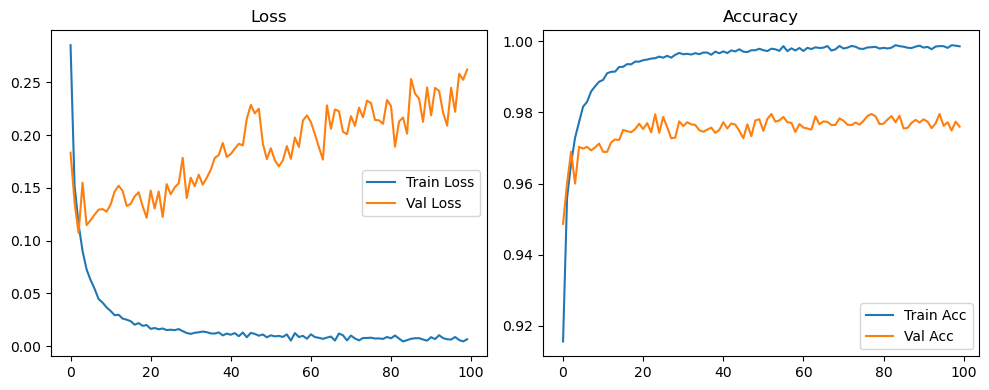

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3076, Acc: 0.9102 | Val Loss: 0.1678, Acc: 0.9497


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1714, Acc: 0.9491 | Val Loss: 0.1318, Acc: 0.9621


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1375, Acc: 0.9595 | Val Loss: 0.1104, Acc: 0.9692


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1118, Acc: 0.9666 | Val Loss: 0.1268, Acc: 0.9653


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1025, Acc: 0.9689 | Val Loss: 0.1179, Acc: 0.9683


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0840, Acc: 0.9747 | Val Loss: 0.1128, Acc: 0.9709


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0781, Acc: 0.9764 | Val Loss: 0.1220, Acc: 0.9710


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0698, Acc: 0.9795 | Val Loss: 0.1311, Acc: 0.9690


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0642, Acc: 0.9812 | Val Loss: 0.1239, Acc: 0.9731


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0607, Acc: 0.9819 | Val Loss: 0.1192, Acc: 0.9728


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9845 | Val Loss: 0.1536, Acc: 0.9688


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9848 | Val Loss: 0.1181, Acc: 0.9752


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9854 | Val Loss: 0.1329, Acc: 0.9740


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9852 | Val Loss: 0.1315, Acc: 0.9747


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9878 | Val Loss: 0.1480, Acc: 0.9747


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9872 | Val Loss: 0.1305, Acc: 0.9740


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9878 | Val Loss: 0.1466, Acc: 0.9740


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9891 | Val Loss: 0.1570, Acc: 0.9752


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9893 | Val Loss: 0.1668, Acc: 0.9713


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9905 | Val Loss: 0.1622, Acc: 0.9736


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9905 | Val Loss: 0.1507, Acc: 0.9767


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9912 | Val Loss: 0.1603, Acc: 0.9764


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9903 | Val Loss: 0.1458, Acc: 0.9778


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9911 | Val Loss: 0.1438, Acc: 0.9775


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9916 | Val Loss: 0.1523, Acc: 0.9773


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9912 | Val Loss: 0.1956, Acc: 0.9742


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9918 | Val Loss: 0.1867, Acc: 0.9749


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9917 | Val Loss: 0.1761, Acc: 0.9748


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9926 | Val Loss: 0.1690, Acc: 0.9758


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9930 | Val Loss: 0.1776, Acc: 0.9765


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9926 | Val Loss: 0.2241, Acc: 0.9771


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9929 | Val Loss: 0.1748, Acc: 0.9773


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9932 | Val Loss: 0.1832, Acc: 0.9770


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9934 | Val Loss: 0.1986, Acc: 0.9768


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9938 | Val Loss: 0.1818, Acc: 0.9768


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9935 | Val Loss: 0.2026, Acc: 0.9774


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9946 | Val Loss: 0.2043, Acc: 0.9782


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9946 | Val Loss: 0.2006, Acc: 0.9776


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9948 | Val Loss: 0.2106, Acc: 0.9771


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9937 | Val Loss: 0.2090, Acc: 0.9777


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9935 | Val Loss: 0.2210, Acc: 0.9782


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9948 | Val Loss: 0.2278, Acc: 0.9758


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9940 | Val Loss: 0.2394, Acc: 0.9789


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9939 | Val Loss: 0.2439, Acc: 0.9744


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9949 | Val Loss: 0.2239, Acc: 0.9788


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9955 | Val Loss: 0.2431, Acc: 0.9780


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9942 | Val Loss: 0.2531, Acc: 0.9744


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9950 | Val Loss: 0.2360, Acc: 0.9794


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9957 | Val Loss: 0.2387, Acc: 0.9781


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9952 | Val Loss: 0.2544, Acc: 0.9768


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9949 | Val Loss: 0.2505, Acc: 0.9772


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9954 | Val Loss: 0.2633, Acc: 0.9782


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9949 | Val Loss: 0.2642, Acc: 0.9760


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9948 | Val Loss: 0.2373, Acc: 0.9786


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9961 | Val Loss: 0.2548, Acc: 0.9772


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9958 | Val Loss: 0.2686, Acc: 0.9776


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9951 | Val Loss: 0.2355, Acc: 0.9778


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9963 | Val Loss: 0.2775, Acc: 0.9769


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9953 | Val Loss: 0.2492, Acc: 0.9776


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9953 | Val Loss: 0.2770, Acc: 0.9787


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9953 | Val Loss: 0.2714, Acc: 0.9767


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9956 | Val Loss: 0.2786, Acc: 0.9767


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9952 | Val Loss: 0.2679, Acc: 0.9793


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9963 | Val Loss: 0.3120, Acc: 0.9775


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9967 | Val Loss: 0.2841, Acc: 0.9783


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9960 | Val Loss: 0.2728, Acc: 0.9798


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9967 | Val Loss: 0.3190, Acc: 0.9772


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9955 | Val Loss: 0.3111, Acc: 0.9773


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9955 | Val Loss: 0.3137, Acc: 0.9778


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9964 | Val Loss: 0.2998, Acc: 0.9782


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9965 | Val Loss: 0.2923, Acc: 0.9774


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9955 | Val Loss: 0.3190, Acc: 0.9764


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9963 | Val Loss: 0.3115, Acc: 0.9768


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9961 | Val Loss: 0.3243, Acc: 0.9772


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9968 | Val Loss: 0.2948, Acc: 0.9788


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9964 | Val Loss: 0.3439, Acc: 0.9759


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9970 | Val Loss: 0.3249, Acc: 0.9779


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9967 | Val Loss: 0.3413, Acc: 0.9772


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9968 | Val Loss: 0.3053, Acc: 0.9793


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9969 | Val Loss: 0.3299, Acc: 0.9785


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9963 | Val Loss: 0.3096, Acc: 0.9794


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9965 | Val Loss: 0.3263, Acc: 0.9788


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9967 | Val Loss: 0.3811, Acc: 0.9772


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9970 | Val Loss: 0.3228, Acc: 0.9765


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9966 | Val Loss: 0.3334, Acc: 0.9778


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9974 | Val Loss: 0.3603, Acc: 0.9782


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9971 | Val Loss: 0.3562, Acc: 0.9782


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9976 | Val Loss: 0.3499, Acc: 0.9788


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9966 | Val Loss: 0.3804, Acc: 0.9773


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9962 | Val Loss: 0.3537, Acc: 0.9785


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9970 | Val Loss: 0.4241, Acc: 0.9757


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9973 | Val Loss: 0.3781, Acc: 0.9777


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9972 | Val Loss: 0.3453, Acc: 0.9780


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9968 | Val Loss: 0.2847, Acc: 0.9782


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9972 | Val Loss: 0.3293, Acc: 0.9770


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9970 | Val Loss: 0.3143, Acc: 0.9796


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9976 | Val Loss: 0.3580, Acc: 0.9786


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9974 | Val Loss: 0.3453, Acc: 0.9798


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9972 | Val Loss: 0.3384, Acc: 0.9798


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9979 | Val Loss: 0.3504, Acc: 0.9782


Final Test Loss: 0.3327 Accuracy: 0.9805


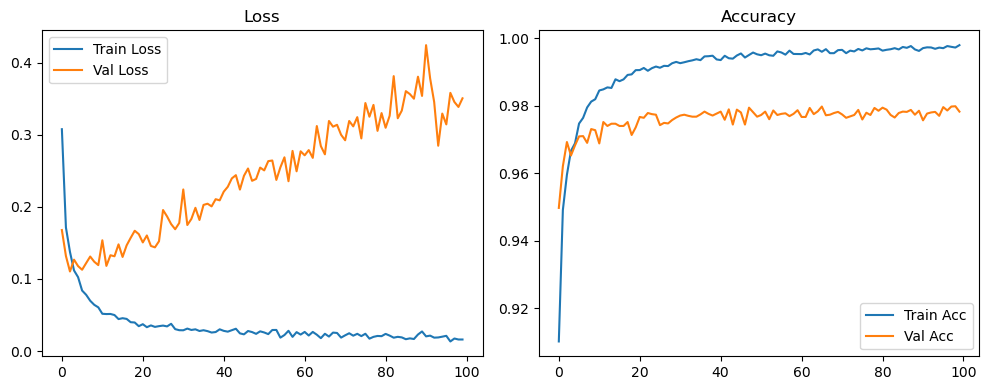

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3831, Acc: 0.8898 | Val Loss: 0.1891, Acc: 0.9451


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2483, Acc: 0.9282 | Val Loss: 0.1402, Acc: 0.9583


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2131, Acc: 0.9384 | Val Loss: 0.1370, Acc: 0.9613


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1884, Acc: 0.9459 | Val Loss: 0.1321, Acc: 0.9641


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1724, Acc: 0.9515 | Val Loss: 0.1167, Acc: 0.9701


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1640, Acc: 0.9536 | Val Loss: 0.1226, Acc: 0.9680


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1547, Acc: 0.9560 | Val Loss: 0.1146, Acc: 0.9721


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1389, Acc: 0.9605 | Val Loss: 0.1203, Acc: 0.9693


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1311, Acc: 0.9624 | Val Loss: 0.1107, Acc: 0.9751


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1336, Acc: 0.9649 | Val Loss: 0.1172, Acc: 0.9727


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1192, Acc: 0.9678 | Val Loss: 0.1136, Acc: 0.9732


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1217, Acc: 0.9668 | Val Loss: 0.1164, Acc: 0.9751


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1143, Acc: 0.9695 | Val Loss: 0.1310, Acc: 0.9736


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1074, Acc: 0.9706 | Val Loss: 0.1244, Acc: 0.9753


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1044, Acc: 0.9731 | Val Loss: 0.1305, Acc: 0.9738


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1023, Acc: 0.9741 | Val Loss: 0.1236, Acc: 0.9761


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1058, Acc: 0.9735 | Val Loss: 0.1325, Acc: 0.9735


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1000, Acc: 0.9745 | Val Loss: 0.1436, Acc: 0.9732


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0942, Acc: 0.9760 | Val Loss: 0.1411, Acc: 0.9752


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0953, Acc: 0.9760 | Val Loss: 0.1291, Acc: 0.9782


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0934, Acc: 0.9775 | Val Loss: 0.1504, Acc: 0.9755


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0922, Acc: 0.9781 | Val Loss: 0.1354, Acc: 0.9778


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0844, Acc: 0.9803 | Val Loss: 0.1454, Acc: 0.9767


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0883, Acc: 0.9793 | Val Loss: 0.1439, Acc: 0.9782


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0957, Acc: 0.9790 | Val Loss: 0.1389, Acc: 0.9798


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0870, Acc: 0.9801 | Val Loss: 0.1543, Acc: 0.9787


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0846, Acc: 0.9808 | Val Loss: 0.1697, Acc: 0.9765


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0802, Acc: 0.9817 | Val Loss: 0.1583, Acc: 0.9785


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0822, Acc: 0.9818 | Val Loss: 0.1549, Acc: 0.9778


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0835, Acc: 0.9822 | Val Loss: 0.1592, Acc: 0.9776


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0806, Acc: 0.9824 | Val Loss: 0.1661, Acc: 0.9778


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0823, Acc: 0.9824 | Val Loss: 0.1784, Acc: 0.9768


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0700, Acc: 0.9846 | Val Loss: 0.1789, Acc: 0.9776


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0781, Acc: 0.9840 | Val Loss: 0.1967, Acc: 0.9768


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0812, Acc: 0.9846 | Val Loss: 0.1737, Acc: 0.9778


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0771, Acc: 0.9844 | Val Loss: 0.1664, Acc: 0.9779


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0716, Acc: 0.9852 | Val Loss: 0.2076, Acc: 0.9748


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0732, Acc: 0.9854 | Val Loss: 0.1791, Acc: 0.9779


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0801, Acc: 0.9850 | Val Loss: 0.1733, Acc: 0.9781


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0695, Acc: 0.9861 | Val Loss: 0.1938, Acc: 0.9781


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0748, Acc: 0.9849 | Val Loss: 0.2126, Acc: 0.9785


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0772, Acc: 0.9854 | Val Loss: 0.2006, Acc: 0.9785


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0777, Acc: 0.9857 | Val Loss: 0.2054, Acc: 0.9770


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0683, Acc: 0.9863 | Val Loss: 0.2088, Acc: 0.9782


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0791, Acc: 0.9863 | Val Loss: 0.2159, Acc: 0.9768


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0663, Acc: 0.9872 | Val Loss: 0.1989, Acc: 0.9783


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0730, Acc: 0.9869 | Val Loss: 0.2015, Acc: 0.9771


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0664, Acc: 0.9870 | Val Loss: 0.2019, Acc: 0.9779


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0667, Acc: 0.9873 | Val Loss: 0.2137, Acc: 0.9776


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0647, Acc: 0.9879 | Val Loss: 0.2205, Acc: 0.9803


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0670, Acc: 0.9882 | Val Loss: 0.2266, Acc: 0.9785


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0702, Acc: 0.9881 | Val Loss: 0.2459, Acc: 0.9782


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0642, Acc: 0.9892 | Val Loss: 0.2140, Acc: 0.9787


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0721, Acc: 0.9879 | Val Loss: 0.1932, Acc: 0.9802


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0634, Acc: 0.9890 | Val Loss: 0.2176, Acc: 0.9788


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0647, Acc: 0.9890 | Val Loss: 0.2030, Acc: 0.9798


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0589, Acc: 0.9902 | Val Loss: 0.2180, Acc: 0.9783


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0707, Acc: 0.9880 | Val Loss: 0.2271, Acc: 0.9802


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0656, Acc: 0.9897 | Val Loss: 0.2116, Acc: 0.9778


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0651, Acc: 0.9892 | Val Loss: 0.2403, Acc: 0.9792


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0619, Acc: 0.9886 | Val Loss: 0.2446, Acc: 0.9793


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0611, Acc: 0.9902 | Val Loss: 0.2525, Acc: 0.9791


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0678, Acc: 0.9889 | Val Loss: 0.2178, Acc: 0.9813


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0656, Acc: 0.9891 | Val Loss: 0.2336, Acc: 0.9798


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9898 | Val Loss: 0.2289, Acc: 0.9792


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9906 | Val Loss: 0.2512, Acc: 0.9795


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0619, Acc: 0.9899 | Val Loss: 0.2680, Acc: 0.9802


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0570, Acc: 0.9905 | Val Loss: 0.2676, Acc: 0.9791


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0694, Acc: 0.9897 | Val Loss: 0.2658, Acc: 0.9800


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0608, Acc: 0.9904 | Val Loss: 0.2542, Acc: 0.9800


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0595, Acc: 0.9906 | Val Loss: 0.2442, Acc: 0.9786


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0642, Acc: 0.9891 | Val Loss: 0.2536, Acc: 0.9794


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0575, Acc: 0.9909 | Val Loss: 0.2556, Acc: 0.9790


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9909 | Val Loss: 0.2718, Acc: 0.9792


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0547, Acc: 0.9912 | Val Loss: 0.2605, Acc: 0.9781


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0696, Acc: 0.9902 | Val Loss: 0.2511, Acc: 0.9791


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0646, Acc: 0.9904 | Val Loss: 0.2822, Acc: 0.9798


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9909 | Val Loss: 0.2809, Acc: 0.9784


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0567, Acc: 0.9914 | Val Loss: 0.3009, Acc: 0.9791


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9914 | Val Loss: 0.2695, Acc: 0.9796


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0648, Acc: 0.9902 | Val Loss: 0.2881, Acc: 0.9789


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9908 | Val Loss: 0.2546, Acc: 0.9802


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0633, Acc: 0.9911 | Val Loss: 0.2601, Acc: 0.9803


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9920 | Val Loss: 0.2960, Acc: 0.9784


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0645, Acc: 0.9911 | Val Loss: 0.2545, Acc: 0.9800


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0576, Acc: 0.9918 | Val Loss: 0.2952, Acc: 0.9782


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9920 | Val Loss: 0.2823, Acc: 0.9808


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9920 | Val Loss: 0.2904, Acc: 0.9810


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9938 | Val Loss: 0.2980, Acc: 0.9798


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0575, Acc: 0.9924 | Val Loss: 0.2923, Acc: 0.9805


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0636, Acc: 0.9921 | Val Loss: 0.3155, Acc: 0.9802


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0692, Acc: 0.9912 | Val Loss: 0.3021, Acc: 0.9796


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9918 | Val Loss: 0.3136, Acc: 0.9804


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0565, Acc: 0.9925 | Val Loss: 0.2698, Acc: 0.9820


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0634, Acc: 0.9910 | Val Loss: 0.3116, Acc: 0.9782


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0521, Acc: 0.9928 | Val Loss: 0.3135, Acc: 0.9794


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9929 | Val Loss: 0.3144, Acc: 0.9790


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0652, Acc: 0.9917 | Val Loss: 0.2700, Acc: 0.9792


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9927 | Val Loss: 0.3066, Acc: 0.9799


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9926 | Val Loss: 0.2927, Acc: 0.9792


Final Test Loss: 0.2629 Accuracy: 0.9822


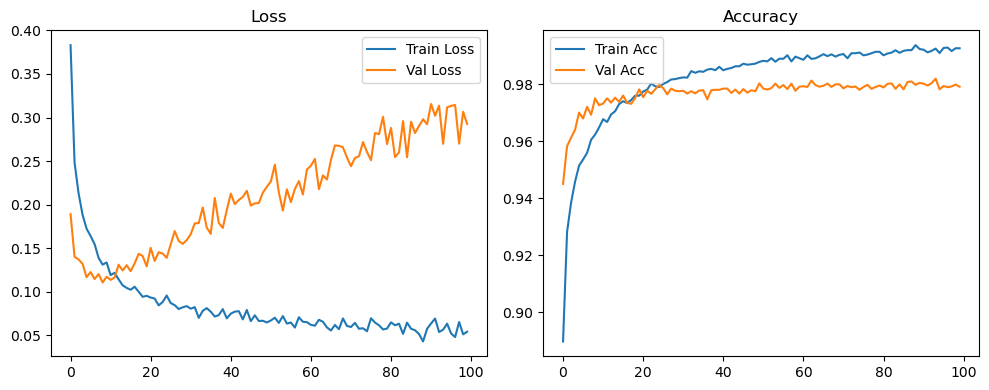

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2852, Acc: 0.9156 | Val Loss: 0.1832, Acc: 0.9487


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1521, Acc: 0.9560 | Val Loss: 0.1362, Acc: 0.9601


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1156, Acc: 0.9656 | Val Loss: 0.1071, Acc: 0.9689


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0900, Acc: 0.9729 | Val Loss: 0.1548, Acc: 0.9600


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0727, Acc: 0.9773 | Val Loss: 0.1147, Acc: 0.9703


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0626, Acc: 0.9816 | Val Loss: 0.1192, Acc: 0.9698


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0543, Acc: 0.9830 | Val Loss: 0.1246, Acc: 0.9703


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9859 | Val Loss: 0.1292, Acc: 0.9693


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9874 | Val Loss: 0.1299, Acc: 0.9702


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9886 | Val Loss: 0.1273, Acc: 0.9712


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9892 | Val Loss: 0.1342, Acc: 0.9689


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9910 | Val Loss: 0.1464, Acc: 0.9689


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9914 | Val Loss: 0.1520, Acc: 0.9716


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.1471, Acc: 0.9724


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9928 | Val Loss: 0.1329, Acc: 0.9722


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9929 | Val Loss: 0.1347, Acc: 0.9751


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.1419, Acc: 0.9748


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9935 | Val Loss: 0.1458, Acc: 0.9744


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9943 | Val Loss: 0.1325, Acc: 0.9753


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9943 | Val Loss: 0.1216, Acc: 0.9768


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1474, Acc: 0.9753


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9949 | Val Loss: 0.1303, Acc: 0.9770


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9952 | Val Loss: 0.1465, Acc: 0.9744


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9953 | Val Loss: 0.1224, Acc: 0.9795


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9957 | Val Loss: 0.1535, Acc: 0.9742


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9954 | Val Loss: 0.1438, Acc: 0.9788


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9959 | Val Loss: 0.1504, Acc: 0.9758


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9954 | Val Loss: 0.1543, Acc: 0.9728


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9962 | Val Loss: 0.1784, Acc: 0.9729


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9968 | Val Loss: 0.1403, Acc: 0.9775


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1596, Acc: 0.9762


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9965 | Val Loss: 0.1515, Acc: 0.9772


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9963 | Val Loss: 0.1624, Acc: 0.9767


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9967 | Val Loss: 0.1529, Acc: 0.9765


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9964 | Val Loss: 0.1594, Acc: 0.9750


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9969 | Val Loss: 0.1672, Acc: 0.9746


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9969 | Val Loss: 0.1783, Acc: 0.9752


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.1810, Acc: 0.9758


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.1925, Acc: 0.9742


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9966 | Val Loss: 0.1792, Acc: 0.9751


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9972 | Val Loss: 0.1820, Acc: 0.9772


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9967 | Val Loss: 0.1870, Acc: 0.9755


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9975 | Val Loss: 0.1917, Acc: 0.9769


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9972 | Val Loss: 0.1901, Acc: 0.9766


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9978 | Val Loss: 0.2155, Acc: 0.9748


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9971 | Val Loss: 0.2285, Acc: 0.9728


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9970 | Val Loss: 0.2205, Acc: 0.9767


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9975 | Val Loss: 0.2250, Acc: 0.9733


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9975 | Val Loss: 0.1920, Acc: 0.9778


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9979 | Val Loss: 0.1771, Acc: 0.9781


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1722, Acc: 0.9785


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1922, Acc: 0.9784


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1844, Acc: 0.9785


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1758, Acc: 0.9810


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1831, Acc: 0.9804


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.2000, Acc: 0.9799


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1911, Acc: 0.9796


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1967, Acc: 0.9797


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1989, Acc: 0.9778


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.2046, Acc: 0.9787


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1994, Acc: 0.9799


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.2073, Acc: 0.9778


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.2020, Acc: 0.9787


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1957, Acc: 0.9805


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.2116, Acc: 0.9806


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.2136, Acc: 0.9784


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.2279, Acc: 0.9804


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9994 | Val Loss: 0.2066, Acc: 0.9799


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.2236, Acc: 0.9804


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.2208, Acc: 0.9790


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.2234, Acc: 0.9788


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2174, Acc: 0.9800


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.2570, Acc: 0.9768


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.2267, Acc: 0.9777


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.2525, Acc: 0.9787


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.2455, Acc: 0.9786


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2274, Acc: 0.9798


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2197, Acc: 0.9800


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.2421, Acc: 0.9787


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.2283, Acc: 0.9801


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2239, Acc: 0.9797


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.2214, Acc: 0.9798


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.2277, Acc: 0.9808


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2341, Acc: 0.9801


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.2244, Acc: 0.9802


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2307, Acc: 0.9802


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.2244, Acc: 0.9811


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.2349, Acc: 0.9807


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2213, Acc: 0.9802


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2193, Acc: 0.9811


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.2324, Acc: 0.9806


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2439, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2400, Acc: 0.9812


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2301, Acc: 0.9814


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2337, Acc: 0.9815


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2275, Acc: 0.9810


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2259, Acc: 0.9808


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2205, Acc: 0.9802


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2346, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2222, Acc: 0.9806


Final Test Loss: 0.2011 Accuracy: 0.9826


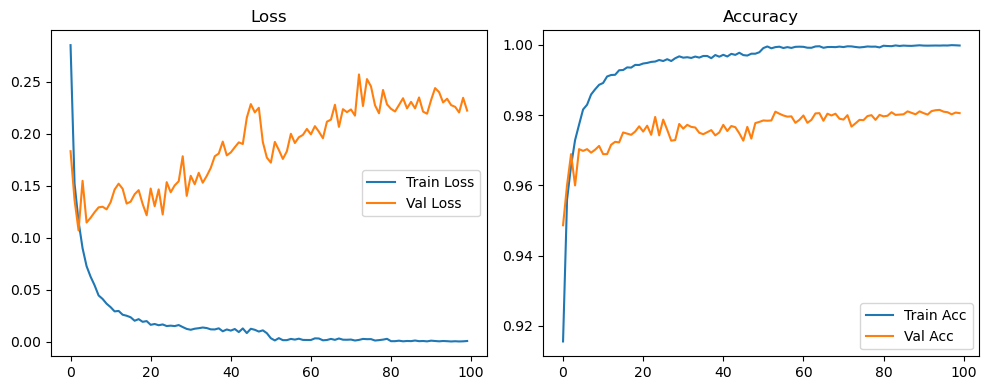

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3076, Acc: 0.9102 | Val Loss: 0.1678, Acc: 0.9497


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1714, Acc: 0.9491 | Val Loss: 0.1318, Acc: 0.9621


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1375, Acc: 0.9595 | Val Loss: 0.1104, Acc: 0.9692


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1118, Acc: 0.9666 | Val Loss: 0.1268, Acc: 0.9653


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1025, Acc: 0.9689 | Val Loss: 0.1179, Acc: 0.9683


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0840, Acc: 0.9747 | Val Loss: 0.1128, Acc: 0.9709


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0781, Acc: 0.9764 | Val Loss: 0.1220, Acc: 0.9710


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0698, Acc: 0.9795 | Val Loss: 0.1311, Acc: 0.9690


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0642, Acc: 0.9812 | Val Loss: 0.1239, Acc: 0.9731


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0607, Acc: 0.9819 | Val Loss: 0.1192, Acc: 0.9728


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9845 | Val Loss: 0.1536, Acc: 0.9688


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9848 | Val Loss: 0.1181, Acc: 0.9752


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9854 | Val Loss: 0.1329, Acc: 0.9740


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9852 | Val Loss: 0.1315, Acc: 0.9747


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9878 | Val Loss: 0.1480, Acc: 0.9747


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9872 | Val Loss: 0.1305, Acc: 0.9740


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9878 | Val Loss: 0.1466, Acc: 0.9740


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9891 | Val Loss: 0.1570, Acc: 0.9752


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9893 | Val Loss: 0.1668, Acc: 0.9713


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9905 | Val Loss: 0.1622, Acc: 0.9736


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9905 | Val Loss: 0.1507, Acc: 0.9767


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9912 | Val Loss: 0.1603, Acc: 0.9764


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9903 | Val Loss: 0.1458, Acc: 0.9778


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9911 | Val Loss: 0.1438, Acc: 0.9775


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9916 | Val Loss: 0.1523, Acc: 0.9773


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9912 | Val Loss: 0.1956, Acc: 0.9742


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9918 | Val Loss: 0.1867, Acc: 0.9749


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9917 | Val Loss: 0.1761, Acc: 0.9748


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9926 | Val Loss: 0.1690, Acc: 0.9758


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9930 | Val Loss: 0.1776, Acc: 0.9765


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9926 | Val Loss: 0.2241, Acc: 0.9771


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9929 | Val Loss: 0.1748, Acc: 0.9773


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9932 | Val Loss: 0.1832, Acc: 0.9770


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9934 | Val Loss: 0.1986, Acc: 0.9768


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9938 | Val Loss: 0.1818, Acc: 0.9768


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9935 | Val Loss: 0.2026, Acc: 0.9774


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9946 | Val Loss: 0.2043, Acc: 0.9782


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9946 | Val Loss: 0.2006, Acc: 0.9776


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9948 | Val Loss: 0.2106, Acc: 0.9771


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9937 | Val Loss: 0.2090, Acc: 0.9777


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9935 | Val Loss: 0.2210, Acc: 0.9782


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9948 | Val Loss: 0.2278, Acc: 0.9758


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9940 | Val Loss: 0.2394, Acc: 0.9789


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9939 | Val Loss: 0.2439, Acc: 0.9744


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9949 | Val Loss: 0.2239, Acc: 0.9788


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9955 | Val Loss: 0.2431, Acc: 0.9780


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9942 | Val Loss: 0.2531, Acc: 0.9744


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9950 | Val Loss: 0.2360, Acc: 0.9794


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9957 | Val Loss: 0.2387, Acc: 0.9781


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9952 | Val Loss: 0.2544, Acc: 0.9768


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9969 | Val Loss: 0.2015, Acc: 0.9800


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9980 | Val Loss: 0.2145, Acc: 0.9804


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9978 | Val Loss: 0.2000, Acc: 0.9809


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9980 | Val Loss: 0.1935, Acc: 0.9806


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9983 | Val Loss: 0.2184, Acc: 0.9796


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9981 | Val Loss: 0.2169, Acc: 0.9807


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9982 | Val Loss: 0.2240, Acc: 0.9807


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9989 | Val Loss: 0.2288, Acc: 0.9813


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9983 | Val Loss: 0.2524, Acc: 0.9787


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9981 | Val Loss: 0.2250, Acc: 0.9815


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9984 | Val Loss: 0.2502, Acc: 0.9798


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9982 | Val Loss: 0.2436, Acc: 0.9808


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9989 | Val Loss: 0.2208, Acc: 0.9819


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9984 | Val Loss: 0.2389, Acc: 0.9806


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.2521, Acc: 0.9805


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9987 | Val Loss: 0.2420, Acc: 0.9816


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.2690, Acc: 0.9810


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9984 | Val Loss: 0.2836, Acc: 0.9812


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9987 | Val Loss: 0.2891, Acc: 0.9801


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9989 | Val Loss: 0.2888, Acc: 0.9797


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9985 | Val Loss: 0.2988, Acc: 0.9807


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9989 | Val Loss: 0.2804, Acc: 0.9791


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9987 | Val Loss: 0.2976, Acc: 0.9801


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9989 | Val Loss: 0.2949, Acc: 0.9798


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9991 | Val Loss: 0.3268, Acc: 0.9801


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9990 | Val Loss: 0.3269, Acc: 0.9802


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9984 | Val Loss: 0.3007, Acc: 0.9806


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9985 | Val Loss: 0.2918, Acc: 0.9809


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9988 | Val Loss: 0.2940, Acc: 0.9802


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9985 | Val Loss: 0.2940, Acc: 0.9804


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.2800, Acc: 0.9812


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9992 | Val Loss: 0.2857, Acc: 0.9813


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9992 | Val Loss: 0.2808, Acc: 0.9815


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.2846, Acc: 0.9815


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9995 | Val Loss: 0.2869, Acc: 0.9812


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.2795, Acc: 0.9813


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2867, Acc: 0.9812


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.2927, Acc: 0.9800


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9993 | Val Loss: 0.2851, Acc: 0.9801


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.2884, Acc: 0.9818


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9994 | Val Loss: 0.2781, Acc: 0.9809


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9992 | Val Loss: 0.2910, Acc: 0.9812


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9994 | Val Loss: 0.2996, Acc: 0.9818


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.2716, Acc: 0.9820


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.2822, Acc: 0.9806


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.2776, Acc: 0.9810


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9994 | Val Loss: 0.3048, Acc: 0.9799


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.2920, Acc: 0.9814


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9996 | Val Loss: 0.3021, Acc: 0.9805


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.3210, Acc: 0.9800


Final Test Loss: 0.2852 Accuracy: 0.9819


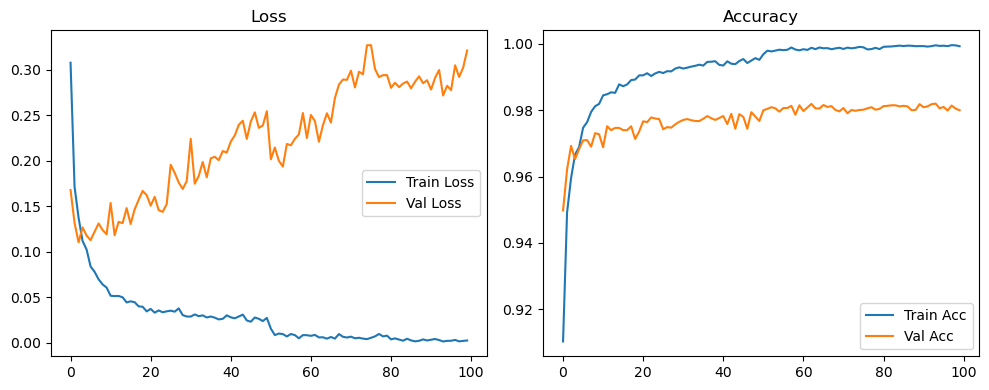

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3831, Acc: 0.8898 | Val Loss: 0.1891, Acc: 0.9451


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2483, Acc: 0.9282 | Val Loss: 0.1402, Acc: 0.9583


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2131, Acc: 0.9384 | Val Loss: 0.1370, Acc: 0.9613


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1884, Acc: 0.9459 | Val Loss: 0.1321, Acc: 0.9641


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1724, Acc: 0.9515 | Val Loss: 0.1167, Acc: 0.9701


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1640, Acc: 0.9536 | Val Loss: 0.1226, Acc: 0.9680


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1547, Acc: 0.9560 | Val Loss: 0.1146, Acc: 0.9721


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1389, Acc: 0.9605 | Val Loss: 0.1203, Acc: 0.9693


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1311, Acc: 0.9624 | Val Loss: 0.1107, Acc: 0.9751


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1336, Acc: 0.9649 | Val Loss: 0.1172, Acc: 0.9727


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1192, Acc: 0.9678 | Val Loss: 0.1136, Acc: 0.9732


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1217, Acc: 0.9668 | Val Loss: 0.1164, Acc: 0.9751


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1143, Acc: 0.9695 | Val Loss: 0.1310, Acc: 0.9736


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1074, Acc: 0.9706 | Val Loss: 0.1244, Acc: 0.9753


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1044, Acc: 0.9731 | Val Loss: 0.1305, Acc: 0.9738


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1023, Acc: 0.9741 | Val Loss: 0.1236, Acc: 0.9761


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1058, Acc: 0.9735 | Val Loss: 0.1325, Acc: 0.9735


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1000, Acc: 0.9745 | Val Loss: 0.1436, Acc: 0.9732


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0942, Acc: 0.9760 | Val Loss: 0.1411, Acc: 0.9752


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0953, Acc: 0.9760 | Val Loss: 0.1291, Acc: 0.9782


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0934, Acc: 0.9775 | Val Loss: 0.1504, Acc: 0.9755


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0922, Acc: 0.9781 | Val Loss: 0.1354, Acc: 0.9778


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0844, Acc: 0.9803 | Val Loss: 0.1454, Acc: 0.9767


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0883, Acc: 0.9793 | Val Loss: 0.1439, Acc: 0.9782


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0957, Acc: 0.9790 | Val Loss: 0.1389, Acc: 0.9798


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0870, Acc: 0.9801 | Val Loss: 0.1543, Acc: 0.9787


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0846, Acc: 0.9808 | Val Loss: 0.1697, Acc: 0.9765


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0802, Acc: 0.9817 | Val Loss: 0.1583, Acc: 0.9785


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0822, Acc: 0.9818 | Val Loss: 0.1549, Acc: 0.9778


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0835, Acc: 0.9822 | Val Loss: 0.1592, Acc: 0.9776


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0806, Acc: 0.9824 | Val Loss: 0.1661, Acc: 0.9778


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0823, Acc: 0.9824 | Val Loss: 0.1784, Acc: 0.9768


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0700, Acc: 0.9846 | Val Loss: 0.1789, Acc: 0.9776


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0781, Acc: 0.9840 | Val Loss: 0.1967, Acc: 0.9768


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0812, Acc: 0.9846 | Val Loss: 0.1737, Acc: 0.9778


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0771, Acc: 0.9844 | Val Loss: 0.1664, Acc: 0.9779


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0716, Acc: 0.9852 | Val Loss: 0.2076, Acc: 0.9748


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0732, Acc: 0.9854 | Val Loss: 0.1791, Acc: 0.9779


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0801, Acc: 0.9850 | Val Loss: 0.1733, Acc: 0.9781


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0695, Acc: 0.9861 | Val Loss: 0.1938, Acc: 0.9781


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0748, Acc: 0.9849 | Val Loss: 0.2126, Acc: 0.9785


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0772, Acc: 0.9854 | Val Loss: 0.2006, Acc: 0.9785


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0777, Acc: 0.9857 | Val Loss: 0.2054, Acc: 0.9770


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0683, Acc: 0.9863 | Val Loss: 0.2088, Acc: 0.9782


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0791, Acc: 0.9863 | Val Loss: 0.2159, Acc: 0.9768


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0663, Acc: 0.9872 | Val Loss: 0.1989, Acc: 0.9783


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0730, Acc: 0.9869 | Val Loss: 0.2015, Acc: 0.9771


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0664, Acc: 0.9870 | Val Loss: 0.2019, Acc: 0.9779


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0667, Acc: 0.9873 | Val Loss: 0.2137, Acc: 0.9776


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0647, Acc: 0.9879 | Val Loss: 0.2205, Acc: 0.9803


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0464, Acc: 0.9909 | Val Loss: 0.1764, Acc: 0.9811


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9920 | Val Loss: 0.1914, Acc: 0.9810


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9931 | Val Loss: 0.1726, Acc: 0.9829


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9926 | Val Loss: 0.1935, Acc: 0.9813


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9931 | Val Loss: 0.1857, Acc: 0.9816


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9936 | Val Loss: 0.1918, Acc: 0.9810


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9934 | Val Loss: 0.2098, Acc: 0.9794


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9939 | Val Loss: 0.2007, Acc: 0.9801


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9938 | Val Loss: 0.2192, Acc: 0.9797


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9945 | Val Loss: 0.2065, Acc: 0.9815


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9939 | Val Loss: 0.2031, Acc: 0.9810


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9943 | Val Loss: 0.2046, Acc: 0.9802


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9947 | Val Loss: 0.2075, Acc: 0.9808


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9946 | Val Loss: 0.1952, Acc: 0.9808


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9948 | Val Loss: 0.1961, Acc: 0.9820


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9954 | Val Loss: 0.2265, Acc: 0.9806


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9954 | Val Loss: 0.2073, Acc: 0.9810


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9949 | Val Loss: 0.2030, Acc: 0.9812


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9953 | Val Loss: 0.2075, Acc: 0.9825


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9953 | Val Loss: 0.2075, Acc: 0.9819


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9953 | Val Loss: 0.2124, Acc: 0.9811


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9955 | Val Loss: 0.2330, Acc: 0.9803


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9949 | Val Loss: 0.2364, Acc: 0.9815


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9961 | Val Loss: 0.2195, Acc: 0.9805


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9957 | Val Loss: 0.2306, Acc: 0.9808


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9955 | Val Loss: 0.2363, Acc: 0.9807


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9954 | Val Loss: 0.2405, Acc: 0.9817


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9956 | Val Loss: 0.2373, Acc: 0.9812


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9954 | Val Loss: 0.2218, Acc: 0.9818


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9958 | Val Loss: 0.2222, Acc: 0.9818


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9964 | Val Loss: 0.2130, Acc: 0.9818


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9961 | Val Loss: 0.2149, Acc: 0.9827


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9963 | Val Loss: 0.2173, Acc: 0.9826


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9967 | Val Loss: 0.2124, Acc: 0.9824


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9966 | Val Loss: 0.2174, Acc: 0.9831


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9968 | Val Loss: 0.2167, Acc: 0.9822


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9966 | Val Loss: 0.2256, Acc: 0.9815


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9966 | Val Loss: 0.2214, Acc: 0.9821


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9966 | Val Loss: 0.2295, Acc: 0.9821


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9972 | Val Loss: 0.2281, Acc: 0.9817


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9967 | Val Loss: 0.2331, Acc: 0.9818


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9974 | Val Loss: 0.2374, Acc: 0.9820


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9971 | Val Loss: 0.2275, Acc: 0.9828


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9972 | Val Loss: 0.2279, Acc: 0.9826


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9971 | Val Loss: 0.2253, Acc: 0.9824


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9973 | Val Loss: 0.2243, Acc: 0.9826


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9976 | Val Loss: 0.2270, Acc: 0.9828


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9970 | Val Loss: 0.2301, Acc: 0.9828


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9977 | Val Loss: 0.2496, Acc: 0.9817


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9972 | Val Loss: 0.2344, Acc: 0.9833


Final Test Loss: 0.2059 Accuracy: 0.9833


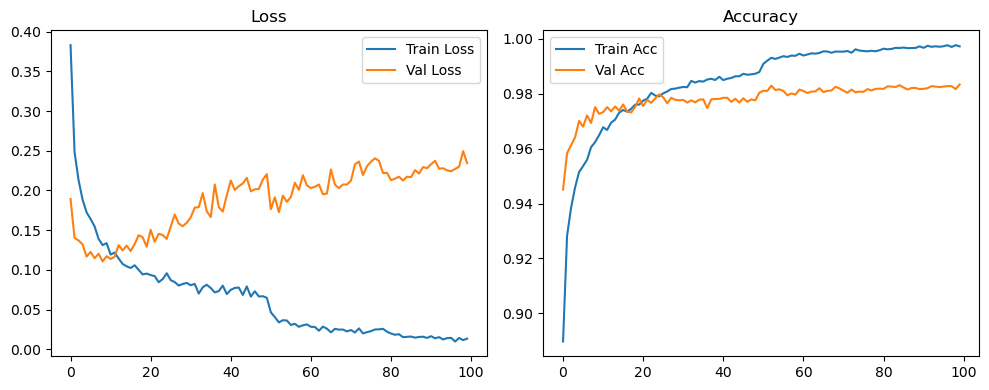

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2553, Acc: 0.9231 | Val Loss: 0.1505, Acc: 0.9567


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1329, Acc: 0.9596 | Val Loss: 0.1194, Acc: 0.9631


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1017, Acc: 0.9680 | Val Loss: 0.1040, Acc: 0.9685


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0808, Acc: 0.9742 | Val Loss: 0.1289, Acc: 0.9632


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0694, Acc: 0.9777 | Val Loss: 0.1091, Acc: 0.9690


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0572, Acc: 0.9817 | Val Loss: 0.1177, Acc: 0.9691


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9836 | Val Loss: 0.1216, Acc: 0.9698


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9859 | Val Loss: 0.1050, Acc: 0.9733


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9876 | Val Loss: 0.1138, Acc: 0.9732


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9877 | Val Loss: 0.1154, Acc: 0.9718


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9896 | Val Loss: 0.1407, Acc: 0.9684


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9908 | Val Loss: 0.1170, Acc: 0.9732


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9911 | Val Loss: 0.1162, Acc: 0.9733


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.1276, Acc: 0.9728


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 0.1349, Acc: 0.9717


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.1126, Acc: 0.9750


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9932 | Val Loss: 0.1278, Acc: 0.9752


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.1326, Acc: 0.9737


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9941 | Val Loss: 0.1498, Acc: 0.9705


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9950 | Val Loss: 0.1208, Acc: 0.9763


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.1451, Acc: 0.9738


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.1202, Acc: 0.9762


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1576, Acc: 0.9720


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1365, Acc: 0.9756


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9958 | Val Loss: 0.1516, Acc: 0.9724


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.1533, Acc: 0.9740


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1496, Acc: 0.9744


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.1472, Acc: 0.9748


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9965 | Val Loss: 0.1568, Acc: 0.9747


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.1370, Acc: 0.9748


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1642, Acc: 0.9759


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1568, Acc: 0.9758


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1475, Acc: 0.9763


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1621, Acc: 0.9766


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9970 | Val Loss: 0.1273, Acc: 0.9760


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1431, Acc: 0.9759


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1493, Acc: 0.9762


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9971 | Val Loss: 0.1442, Acc: 0.9763


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1520, Acc: 0.9772


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9972 | Val Loss: 0.1528, Acc: 0.9770


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.1545, Acc: 0.9766


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.1488, Acc: 0.9783


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1531, Acc: 0.9766


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.1598, Acc: 0.9753


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1594, Acc: 0.9775


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1876, Acc: 0.9737


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9975 | Val Loss: 0.1667, Acc: 0.9761


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1713, Acc: 0.9751


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1602, Acc: 0.9772


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.1606, Acc: 0.9783


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1499, Acc: 0.9779


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9979 | Val Loss: 0.1560, Acc: 0.9772


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9978 | Val Loss: 0.1569, Acc: 0.9761


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9980 | Val Loss: 0.1625, Acc: 0.9780


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9977 | Val Loss: 0.1678, Acc: 0.9776


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9979 | Val Loss: 0.1571, Acc: 0.9783


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.1877, Acc: 0.9751


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9984 | Val Loss: 0.1608, Acc: 0.9775


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1654, Acc: 0.9779


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1712, Acc: 0.9771


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.1693, Acc: 0.9762


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.1819, Acc: 0.9752


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9980 | Val Loss: 0.1663, Acc: 0.9767


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1866, Acc: 0.9766


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.1773, Acc: 0.9781


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9984 | Val Loss: 0.1821, Acc: 0.9768


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1757, Acc: 0.9778


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.1760, Acc: 0.9778


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1616, Acc: 0.9792


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1907, Acc: 0.9772


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9983 | Val Loss: 0.1976, Acc: 0.9748


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9980 | Val Loss: 0.1980, Acc: 0.9762


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1851, Acc: 0.9779


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.1769, Acc: 0.9779


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1859, Acc: 0.9778


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9981 | Val Loss: 0.1895, Acc: 0.9760


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.2182, Acc: 0.9770


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9982 | Val Loss: 0.1826, Acc: 0.9765


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9981 | Val Loss: 0.1946, Acc: 0.9765


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9985 | Val Loss: 0.1813, Acc: 0.9778


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1863, Acc: 0.9785


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1929, Acc: 0.9771


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1902, Acc: 0.9765


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.2009, Acc: 0.9775


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9988 | Val Loss: 0.1955, Acc: 0.9765


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9986 | Val Loss: 0.1945, Acc: 0.9778


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9979 | Val Loss: 0.1946, Acc: 0.9769


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.2066, Acc: 0.9771


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.2064, Acc: 0.9774


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.2059, Acc: 0.9776


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9981 | Val Loss: 0.2067, Acc: 0.9763


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9990 | Val Loss: 0.2113, Acc: 0.9778


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1803, Acc: 0.9783


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.2063, Acc: 0.9779


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9988 | Val Loss: 0.2290, Acc: 0.9758


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.2016, Acc: 0.9781


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.2106, Acc: 0.9767


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1952, Acc: 0.9769


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.1892, Acc: 0.9788


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.2129, Acc: 0.9764


Final Test Loss: 0.1884 Accuracy: 0.9787


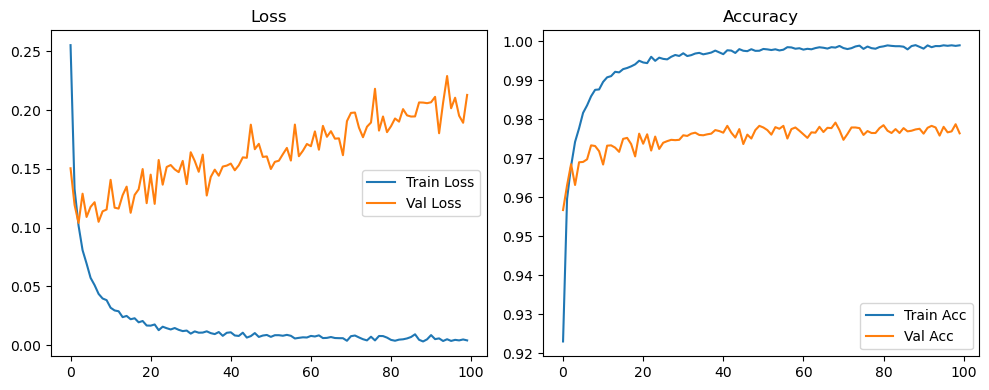

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2692, Acc: 0.9181 | Val Loss: 0.1644, Acc: 0.9509


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1494, Acc: 0.9543 | Val Loss: 0.1227, Acc: 0.9615


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1202, Acc: 0.9635 | Val Loss: 0.1181, Acc: 0.9639


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0973, Acc: 0.9693 | Val Loss: 0.1195, Acc: 0.9657


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0874, Acc: 0.9721 | Val Loss: 0.1056, Acc: 0.9705


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0760, Acc: 0.9769 | Val Loss: 0.1044, Acc: 0.9716


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0674, Acc: 0.9787 | Val Loss: 0.0970, Acc: 0.9717


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0568, Acc: 0.9815 | Val Loss: 0.1102, Acc: 0.9706


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0558, Acc: 0.9819 | Val Loss: 0.0987, Acc: 0.9766


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0534, Acc: 0.9828 | Val Loss: 0.1086, Acc: 0.9718


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0482, Acc: 0.9849 | Val Loss: 0.1182, Acc: 0.9712


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0441, Acc: 0.9855 | Val Loss: 0.1124, Acc: 0.9732


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9876 | Val Loss: 0.1133, Acc: 0.9746


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9882 | Val Loss: 0.1281, Acc: 0.9719


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9881 | Val Loss: 0.1064, Acc: 0.9762


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9885 | Val Loss: 0.1116, Acc: 0.9742


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9899 | Val Loss: 0.1212, Acc: 0.9742


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9897 | Val Loss: 0.1067, Acc: 0.9762


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9912 | Val Loss: 0.1270, Acc: 0.9739


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9916 | Val Loss: 0.1144, Acc: 0.9763


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9921 | Val Loss: 0.1445, Acc: 0.9725


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9912 | Val Loss: 0.1366, Acc: 0.9751


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.1384, Acc: 0.9781


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9932 | Val Loss: 0.1427, Acc: 0.9757


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9916 | Val Loss: 0.1337, Acc: 0.9772


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9921 | Val Loss: 0.1288, Acc: 0.9767


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9936 | Val Loss: 0.1427, Acc: 0.9765


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9937 | Val Loss: 0.1565, Acc: 0.9752


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9935 | Val Loss: 0.1364, Acc: 0.9751


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9941 | Val Loss: 0.1316, Acc: 0.9778


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9942 | Val Loss: 0.1424, Acc: 0.9770


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9945 | Val Loss: 0.1436, Acc: 0.9769


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9952 | Val Loss: 0.1607, Acc: 0.9748


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9937 | Val Loss: 0.1604, Acc: 0.9777


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9938 | Val Loss: 0.1476, Acc: 0.9770


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9946 | Val Loss: 0.1746, Acc: 0.9733


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9952 | Val Loss: 0.1509, Acc: 0.9745


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9953 | Val Loss: 0.1451, Acc: 0.9772


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9947 | Val Loss: 0.1641, Acc: 0.9772


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9948 | Val Loss: 0.1518, Acc: 0.9759


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9952 | Val Loss: 0.1736, Acc: 0.9762


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9957 | Val Loss: 0.1540, Acc: 0.9762


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9961 | Val Loss: 0.1415, Acc: 0.9792


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.1689, Acc: 0.9756


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9956 | Val Loss: 0.1692, Acc: 0.9782


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9951 | Val Loss: 0.1593, Acc: 0.9782


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9954 | Val Loss: 0.1689, Acc: 0.9769


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9960 | Val Loss: 0.1733, Acc: 0.9763


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9959 | Val Loss: 0.1628, Acc: 0.9782


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9959 | Val Loss: 0.1804, Acc: 0.9776


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9954 | Val Loss: 0.1852, Acc: 0.9776


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.1868, Acc: 0.9789


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9959 | Val Loss: 0.1777, Acc: 0.9787


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9961 | Val Loss: 0.1669, Acc: 0.9788


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9966 | Val Loss: 0.1822, Acc: 0.9791


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9963 | Val Loss: 0.1750, Acc: 0.9780


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9966 | Val Loss: 0.2023, Acc: 0.9766


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9965 | Val Loss: 0.1885, Acc: 0.9785


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9972 | Val Loss: 0.2056, Acc: 0.9760


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9961 | Val Loss: 0.2008, Acc: 0.9782


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9959 | Val Loss: 0.2026, Acc: 0.9782


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9962 | Val Loss: 0.2210, Acc: 0.9748


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9963 | Val Loss: 0.2095, Acc: 0.9749


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9967 | Val Loss: 0.1854, Acc: 0.9772


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9971 | Val Loss: 0.2199, Acc: 0.9771


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9967 | Val Loss: 0.2309, Acc: 0.9772


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9969 | Val Loss: 0.2320, Acc: 0.9745


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9971 | Val Loss: 0.2035, Acc: 0.9772


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9963 | Val Loss: 0.2120, Acc: 0.9774


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9972 | Val Loss: 0.1943, Acc: 0.9789


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9975 | Val Loss: 0.2153, Acc: 0.9781


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9967 | Val Loss: 0.2078, Acc: 0.9782


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9972 | Val Loss: 0.2121, Acc: 0.9776


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9970 | Val Loss: 0.2001, Acc: 0.9794


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9968 | Val Loss: 0.2240, Acc: 0.9762


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9966 | Val Loss: 0.1862, Acc: 0.9784


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9975 | Val Loss: 0.2172, Acc: 0.9770


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9970 | Val Loss: 0.2075, Acc: 0.9778


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9972 | Val Loss: 0.2140, Acc: 0.9778


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9976 | Val Loss: 0.2215, Acc: 0.9782


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9969 | Val Loss: 0.2236, Acc: 0.9762


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9972 | Val Loss: 0.2165, Acc: 0.9780


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9973 | Val Loss: 0.2293, Acc: 0.9768


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9970 | Val Loss: 0.2227, Acc: 0.9782


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9978 | Val Loss: 0.2305, Acc: 0.9780


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9971 | Val Loss: 0.2425, Acc: 0.9785


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.2338, Acc: 0.9781


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9979 | Val Loss: 0.2188, Acc: 0.9796


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9964 | Val Loss: 0.2405, Acc: 0.9768


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9976 | Val Loss: 0.2278, Acc: 0.9792


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9976 | Val Loss: 0.2612, Acc: 0.9764


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9976 | Val Loss: 0.2401, Acc: 0.9768


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9974 | Val Loss: 0.2606, Acc: 0.9765


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9971 | Val Loss: 0.2529, Acc: 0.9752


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9972 | Val Loss: 0.2411, Acc: 0.9784


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9983 | Val Loss: 0.2417, Acc: 0.9788


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9976 | Val Loss: 0.2500, Acc: 0.9777


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9981 | Val Loss: 0.2562, Acc: 0.9772


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9974 | Val Loss: 0.2351, Acc: 0.9769


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9974 | Val Loss: 0.2279, Acc: 0.9780


Final Test Loss: 0.2271 Accuracy: 0.9812


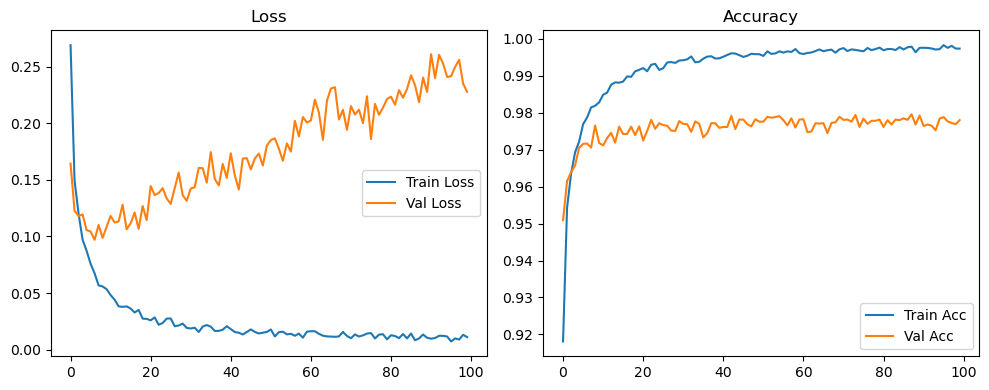

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3349, Acc: 0.9004 | Val Loss: 0.1648, Acc: 0.9494


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2090, Acc: 0.9370 | Val Loss: 0.1360, Acc: 0.9599


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1827, Acc: 0.9446 | Val Loss: 0.1183, Acc: 0.9646


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1559, Acc: 0.9523 | Val Loss: 0.1093, Acc: 0.9673


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1414, Acc: 0.9563 | Val Loss: 0.1025, Acc: 0.9691


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1323, Acc: 0.9603 | Val Loss: 0.1078, Acc: 0.9686


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1192, Acc: 0.9621 | Val Loss: 0.1016, Acc: 0.9701


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1134, Acc: 0.9643 | Val Loss: 0.1074, Acc: 0.9712


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1082, Acc: 0.9670 | Val Loss: 0.0939, Acc: 0.9739


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1018, Acc: 0.9689 | Val Loss: 0.0994, Acc: 0.9719


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0940, Acc: 0.9707 | Val Loss: 0.1027, Acc: 0.9726


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0923, Acc: 0.9711 | Val Loss: 0.1003, Acc: 0.9734


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0862, Acc: 0.9739 | Val Loss: 0.1031, Acc: 0.9749


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0857, Acc: 0.9739 | Val Loss: 0.1013, Acc: 0.9751


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0826, Acc: 0.9744 | Val Loss: 0.1011, Acc: 0.9758


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0756, Acc: 0.9766 | Val Loss: 0.0926, Acc: 0.9771


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0739, Acc: 0.9773 | Val Loss: 0.1019, Acc: 0.9754


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0691, Acc: 0.9792 | Val Loss: 0.1021, Acc: 0.9765


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0694, Acc: 0.9792 | Val Loss: 0.1191, Acc: 0.9741


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0682, Acc: 0.9791 | Val Loss: 0.1032, Acc: 0.9759


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0643, Acc: 0.9802 | Val Loss: 0.1033, Acc: 0.9768


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0623, Acc: 0.9816 | Val Loss: 0.1074, Acc: 0.9754


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0622, Acc: 0.9811 | Val Loss: 0.1001, Acc: 0.9766


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0578, Acc: 0.9829 | Val Loss: 0.1028, Acc: 0.9787


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0573, Acc: 0.9826 | Val Loss: 0.1188, Acc: 0.9766


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0535, Acc: 0.9838 | Val Loss: 0.1186, Acc: 0.9772


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0583, Acc: 0.9835 | Val Loss: 0.1162, Acc: 0.9772


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0528, Acc: 0.9839 | Val Loss: 0.1165, Acc: 0.9773


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0570, Acc: 0.9834 | Val Loss: 0.1174, Acc: 0.9772


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0510, Acc: 0.9849 | Val Loss: 0.1088, Acc: 0.9782


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0544, Acc: 0.9847 | Val Loss: 0.1154, Acc: 0.9782


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9859 | Val Loss: 0.1227, Acc: 0.9774


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0486, Acc: 0.9870 | Val Loss: 0.1075, Acc: 0.9803


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0483, Acc: 0.9860 | Val Loss: 0.1276, Acc: 0.9781


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0453, Acc: 0.9870 | Val Loss: 0.1197, Acc: 0.9777


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0529, Acc: 0.9858 | Val Loss: 0.1165, Acc: 0.9779


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9869 | Val Loss: 0.1329, Acc: 0.9768


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9874 | Val Loss: 0.1160, Acc: 0.9786


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0458, Acc: 0.9869 | Val Loss: 0.1205, Acc: 0.9778


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9872 | Val Loss: 0.1334, Acc: 0.9765


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0491, Acc: 0.9865 | Val Loss: 0.1291, Acc: 0.9783


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9884 | Val Loss: 0.1345, Acc: 0.9772


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9888 | Val Loss: 0.1527, Acc: 0.9768


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9885 | Val Loss: 0.1406, Acc: 0.9782


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0432, Acc: 0.9888 | Val Loss: 0.1275, Acc: 0.9780


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9883 | Val Loss: 0.1391, Acc: 0.9792


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9889 | Val Loss: 0.1407, Acc: 0.9788


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9891 | Val Loss: 0.1364, Acc: 0.9786


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9885 | Val Loss: 0.1488, Acc: 0.9783


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9899 | Val Loss: 0.1475, Acc: 0.9790


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9892 | Val Loss: 0.1472, Acc: 0.9778


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0425, Acc: 0.9893 | Val Loss: 0.1468, Acc: 0.9780


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9898 | Val Loss: 0.1543, Acc: 0.9780


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9890 | Val Loss: 0.1409, Acc: 0.9790


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0358, Acc: 0.9899 | Val Loss: 0.1453, Acc: 0.9782


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9906 | Val Loss: 0.1465, Acc: 0.9778


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9896 | Val Loss: 0.1481, Acc: 0.9772


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9902 | Val Loss: 0.1449, Acc: 0.9792


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0358, Acc: 0.9909 | Val Loss: 0.1496, Acc: 0.9768


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9916 | Val Loss: 0.1519, Acc: 0.9782


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9900 | Val Loss: 0.1538, Acc: 0.9774


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9905 | Val Loss: 0.1464, Acc: 0.9788


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9907 | Val Loss: 0.1449, Acc: 0.9798


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9917 | Val Loss: 0.1521, Acc: 0.9790


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9905 | Val Loss: 0.1397, Acc: 0.9798


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9919 | Val Loss: 0.1588, Acc: 0.9775


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9913 | Val Loss: 0.1519, Acc: 0.9790


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9913 | Val Loss: 0.1459, Acc: 0.9798


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9916 | Val Loss: 0.1547, Acc: 0.9788


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9911 | Val Loss: 0.1640, Acc: 0.9772


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9911 | Val Loss: 0.1581, Acc: 0.9794


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9917 | Val Loss: 0.1715, Acc: 0.9776


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9925 | Val Loss: 0.1763, Acc: 0.9775


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9920 | Val Loss: 0.1680, Acc: 0.9782


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0376, Acc: 0.9913 | Val Loss: 0.1638, Acc: 0.9771


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9922 | Val Loss: 0.1592, Acc: 0.9791


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9926 | Val Loss: 0.1614, Acc: 0.9797


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9925 | Val Loss: 0.1800, Acc: 0.9790


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9924 | Val Loss: 0.1672, Acc: 0.9806


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9924 | Val Loss: 0.1826, Acc: 0.9790


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9924 | Val Loss: 0.1686, Acc: 0.9782


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9922 | Val Loss: 0.1761, Acc: 0.9782


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9933 | Val Loss: 0.1858, Acc: 0.9795


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9924 | Val Loss: 0.1642, Acc: 0.9797


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9926 | Val Loss: 0.1673, Acc: 0.9797


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9932 | Val Loss: 0.1736, Acc: 0.9792


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9927 | Val Loss: 0.1803, Acc: 0.9794


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9931 | Val Loss: 0.1826, Acc: 0.9785


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9930 | Val Loss: 0.1747, Acc: 0.9783


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9932 | Val Loss: 0.1840, Acc: 0.9788


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9925 | Val Loss: 0.1755, Acc: 0.9786


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9925 | Val Loss: 0.1800, Acc: 0.9799


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9932 | Val Loss: 0.1848, Acc: 0.9794


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9929 | Val Loss: 0.1767, Acc: 0.9788


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9929 | Val Loss: 0.1922, Acc: 0.9787


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9942 | Val Loss: 0.1872, Acc: 0.9794


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9934 | Val Loss: 0.1874, Acc: 0.9784


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9931 | Val Loss: 0.1720, Acc: 0.9800


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9938 | Val Loss: 0.1783, Acc: 0.9801


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9935 | Val Loss: 0.1771, Acc: 0.9792


Final Test Loss: 0.1592 Accuracy: 0.9828


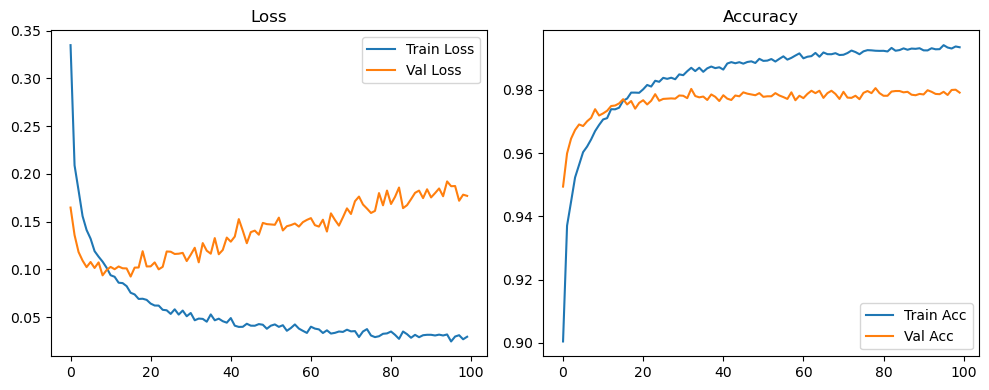

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2355, Acc: 0.9285 | Val Loss: 0.1401, Acc: 0.9578


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1183, Acc: 0.9631 | Val Loss: 0.1076, Acc: 0.9668


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0895, Acc: 0.9714 | Val Loss: 0.1049, Acc: 0.9688


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0664, Acc: 0.9784 | Val Loss: 0.1129, Acc: 0.9678


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0605, Acc: 0.9797 | Val Loss: 0.1057, Acc: 0.9703


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0488, Acc: 0.9845 | Val Loss: 0.1091, Acc: 0.9708


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0486, Acc: 0.9838 | Val Loss: 0.0985, Acc: 0.9734


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9876 | Val Loss: 0.1287, Acc: 0.9675


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9882 | Val Loss: 0.1160, Acc: 0.9718


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 0.1043, Acc: 0.9748


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9912 | Val Loss: 0.1298, Acc: 0.9693


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9904 | Val Loss: 0.1151, Acc: 0.9732


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9920 | Val Loss: 0.1153, Acc: 0.9722


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.1129, Acc: 0.9761


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.1293, Acc: 0.9711


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9933 | Val Loss: 0.1084, Acc: 0.9766


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9931 | Val Loss: 0.1140, Acc: 0.9758


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9933 | Val Loss: 0.1070, Acc: 0.9767


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.1277, Acc: 0.9751


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.1248, Acc: 0.9746


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.1286, Acc: 0.9743


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9946 | Val Loss: 0.1203, Acc: 0.9762


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1327, Acc: 0.9762


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9953 | Val Loss: 0.1145, Acc: 0.9790


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.1253, Acc: 0.9757


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1299, Acc: 0.9754


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.1261, Acc: 0.9761


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1393, Acc: 0.9759


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1282, Acc: 0.9757


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1351, Acc: 0.9745


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.1269, Acc: 0.9778


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1311, Acc: 0.9778


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1450, Acc: 0.9766


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1319, Acc: 0.9787


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.1423, Acc: 0.9773


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1356, Acc: 0.9775


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1488, Acc: 0.9760


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1319, Acc: 0.9762


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.1487, Acc: 0.9759


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.1405, Acc: 0.9780


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1583, Acc: 0.9756


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1391, Acc: 0.9782


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9974 | Val Loss: 0.1511, Acc: 0.9761


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1423, Acc: 0.9769


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9972 | Val Loss: 0.1376, Acc: 0.9778


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.1529, Acc: 0.9782


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1442, Acc: 0.9770


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1534, Acc: 0.9783


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1620, Acc: 0.9758


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1705, Acc: 0.9765


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9973 | Val Loss: 0.1500, Acc: 0.9752


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1627, Acc: 0.9755


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1523, Acc: 0.9774


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1473, Acc: 0.9792


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9978 | Val Loss: 0.1379, Acc: 0.9794


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1367, Acc: 0.9792


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1559, Acc: 0.9798


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1499, Acc: 0.9778


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.1564, Acc: 0.9774


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1536, Acc: 0.9786


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1677, Acc: 0.9774


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9982 | Val Loss: 0.1632, Acc: 0.9768


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1483, Acc: 0.9778


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1567, Acc: 0.9775


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1754, Acc: 0.9768


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1815, Acc: 0.9758


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1783, Acc: 0.9766


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1749, Acc: 0.9758


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1725, Acc: 0.9770


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1803, Acc: 0.9766


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1724, Acc: 0.9793


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.1713, Acc: 0.9795


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9985 | Val Loss: 0.1940, Acc: 0.9780


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9984 | Val Loss: 0.1764, Acc: 0.9772


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1881, Acc: 0.9754


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1604, Acc: 0.9772


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1742, Acc: 0.9775


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1638, Acc: 0.9778


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.1700, Acc: 0.9793


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9985 | Val Loss: 0.1749, Acc: 0.9775


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1745, Acc: 0.9776


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1665, Acc: 0.9782


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1871, Acc: 0.9770


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1829, Acc: 0.9779


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1789, Acc: 0.9786


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1866, Acc: 0.9786


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1799, Acc: 0.9791


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1786, Acc: 0.9782


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9988 | Val Loss: 0.1865, Acc: 0.9771


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1731, Acc: 0.9783


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1737, Acc: 0.9787


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9984 | Val Loss: 0.2047, Acc: 0.9758


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1679, Acc: 0.9785


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1760, Acc: 0.9786


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1788, Acc: 0.9779


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.1753, Acc: 0.9782


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1771, Acc: 0.9786


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1907, Acc: 0.9792


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1793, Acc: 0.9799


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1870, Acc: 0.9789


Final Test Loss: 0.1651 Accuracy: 0.9796


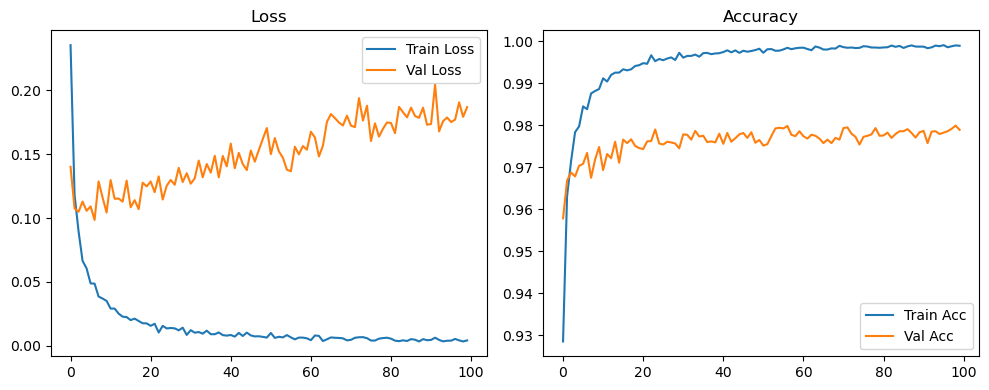

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2556, Acc: 0.9218 | Val Loss: 0.1437, Acc: 0.9568


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1355, Acc: 0.9576 | Val Loss: 0.1096, Acc: 0.9657


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1070, Acc: 0.9657 | Val Loss: 0.1086, Acc: 0.9681


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0869, Acc: 0.9720 | Val Loss: 0.1072, Acc: 0.9677


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0745, Acc: 0.9760 | Val Loss: 0.1008, Acc: 0.9707


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0688, Acc: 0.9779 | Val Loss: 0.1022, Acc: 0.9708


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0594, Acc: 0.9805 | Val Loss: 0.0996, Acc: 0.9728


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0516, Acc: 0.9826 | Val Loss: 0.1009, Acc: 0.9745


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0507, Acc: 0.9830 | Val Loss: 0.0989, Acc: 0.9747


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0446, Acc: 0.9849 | Val Loss: 0.1043, Acc: 0.9729


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0430, Acc: 0.9856 | Val Loss: 0.1197, Acc: 0.9714


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0374, Acc: 0.9879 | Val Loss: 0.1074, Acc: 0.9743


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9885 | Val Loss: 0.1154, Acc: 0.9724


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9876 | Val Loss: 0.1075, Acc: 0.9755


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9903 | Val Loss: 0.1064, Acc: 0.9761


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9892 | Val Loss: 0.1164, Acc: 0.9750


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9901 | Val Loss: 0.1128, Acc: 0.9770


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9910 | Val Loss: 0.1120, Acc: 0.9754


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9919 | Val Loss: 0.1183, Acc: 0.9751


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.1158, Acc: 0.9767


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9916 | Val Loss: 0.1193, Acc: 0.9746


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9917 | Val Loss: 0.1111, Acc: 0.9758


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.1183, Acc: 0.9748


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9934 | Val Loss: 0.1067, Acc: 0.9782


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9935 | Val Loss: 0.1213, Acc: 0.9745


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9938 | Val Loss: 0.1167, Acc: 0.9789


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1236, Acc: 0.9763


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.1276, Acc: 0.9748


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.1253, Acc: 0.9760


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.1094, Acc: 0.9775


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.1223, Acc: 0.9772


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.1042, Acc: 0.9778


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.1127, Acc: 0.9773


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9953 | Val Loss: 0.1332, Acc: 0.9768


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.1194, Acc: 0.9768


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.1320, Acc: 0.9769


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9951 | Val Loss: 0.1233, Acc: 0.9773


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9953 | Val Loss: 0.1374, Acc: 0.9748


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9953 | Val Loss: 0.1254, Acc: 0.9772


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1413, Acc: 0.9764


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9954 | Val Loss: 0.1328, Acc: 0.9771


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.1289, Acc: 0.9784


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.1463, Acc: 0.9770


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9963 | Val Loss: 0.1342, Acc: 0.9769


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1345, Acc: 0.9769


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1376, Acc: 0.9784


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9959 | Val Loss: 0.1542, Acc: 0.9742


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.1408, Acc: 0.9781


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1546, Acc: 0.9768


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1470, Acc: 0.9790


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1407, Acc: 0.9785


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.1514, Acc: 0.9776


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.1449, Acc: 0.9784


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1504, Acc: 0.9782


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1399, Acc: 0.9796


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9969 | Val Loss: 0.1380, Acc: 0.9796


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1534, Acc: 0.9782


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9968 | Val Loss: 0.1406, Acc: 0.9774


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9969 | Val Loss: 0.1521, Acc: 0.9777


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9970 | Val Loss: 0.1532, Acc: 0.9773


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9963 | Val Loss: 0.1639, Acc: 0.9771


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9969 | Val Loss: 0.1397, Acc: 0.9790


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1427, Acc: 0.9787


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1417, Acc: 0.9788


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1511, Acc: 0.9776


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1631, Acc: 0.9773


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1695, Acc: 0.9772


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1494, Acc: 0.9795


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9972 | Val Loss: 0.1629, Acc: 0.9793


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1409, Acc: 0.9799


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9976 | Val Loss: 0.1586, Acc: 0.9787


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1623, Acc: 0.9787


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9973 | Val Loss: 0.1555, Acc: 0.9805


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9974 | Val Loss: 0.1568, Acc: 0.9773


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1610, Acc: 0.9791


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9968 | Val Loss: 0.1639, Acc: 0.9775


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1654, Acc: 0.9785


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9975 | Val Loss: 0.1782, Acc: 0.9783


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1713, Acc: 0.9789


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1656, Acc: 0.9783


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9978 | Val Loss: 0.1676, Acc: 0.9775


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9972 | Val Loss: 0.1474, Acc: 0.9786


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.1515, Acc: 0.9804


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9979 | Val Loss: 0.1616, Acc: 0.9792


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1661, Acc: 0.9789


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.1752, Acc: 0.9802


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.1668, Acc: 0.9782


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.1818, Acc: 0.9796


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9973 | Val Loss: 0.1749, Acc: 0.9782


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1678, Acc: 0.9794


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1794, Acc: 0.9786


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9972 | Val Loss: 0.1845, Acc: 0.9777


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9974 | Val Loss: 0.1814, Acc: 0.9797


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.1642, Acc: 0.9796


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9978 | Val Loss: 0.1768, Acc: 0.9796


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9980 | Val Loss: 0.1821, Acc: 0.9784


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.2030, Acc: 0.9783


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9981 | Val Loss: 0.1889, Acc: 0.9795


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9982 | Val Loss: 0.2064, Acc: 0.9762


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.2136, Acc: 0.9772


Final Test Loss: 0.1928 Accuracy: 0.9792


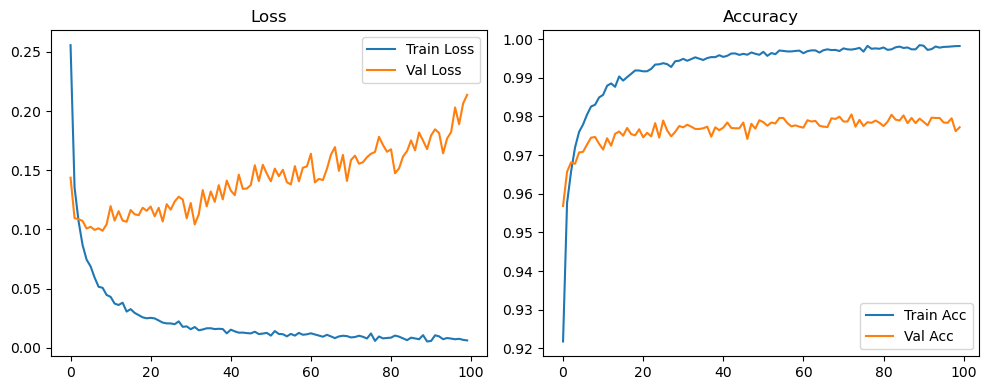

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3249, Acc: 0.8998 | Val Loss: 0.1547, Acc: 0.9523


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1920, Acc: 0.9414 | Val Loss: 0.1239, Acc: 0.9615


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1612, Acc: 0.9509 | Val Loss: 0.1136, Acc: 0.9634


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1444, Acc: 0.9553 | Val Loss: 0.1215, Acc: 0.9630


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1278, Acc: 0.9602 | Val Loss: 0.0979, Acc: 0.9702


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1201, Acc: 0.9628 | Val Loss: 0.0971, Acc: 0.9708


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1081, Acc: 0.9649 | Val Loss: 0.0947, Acc: 0.9735


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0979, Acc: 0.9684 | Val Loss: 0.0981, Acc: 0.9709


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0964, Acc: 0.9696 | Val Loss: 0.0897, Acc: 0.9758


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0909, Acc: 0.9714 | Val Loss: 0.0933, Acc: 0.9731


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0846, Acc: 0.9724 | Val Loss: 0.0926, Acc: 0.9745


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0840, Acc: 0.9733 | Val Loss: 0.0937, Acc: 0.9727


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0759, Acc: 0.9755 | Val Loss: 0.1004, Acc: 0.9729


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0747, Acc: 0.9758 | Val Loss: 0.0977, Acc: 0.9753


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0703, Acc: 0.9775 | Val Loss: 0.0890, Acc: 0.9774


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0674, Acc: 0.9783 | Val Loss: 0.0894, Acc: 0.9761


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0650, Acc: 0.9795 | Val Loss: 0.0972, Acc: 0.9751


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0636, Acc: 0.9797 | Val Loss: 0.0989, Acc: 0.9751


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0600, Acc: 0.9811 | Val Loss: 0.0936, Acc: 0.9763


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0583, Acc: 0.9806 | Val Loss: 0.0979, Acc: 0.9760


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0582, Acc: 0.9810 | Val Loss: 0.1028, Acc: 0.9752


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0573, Acc: 0.9814 | Val Loss: 0.0974, Acc: 0.9758


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0520, Acc: 0.9835 | Val Loss: 0.0982, Acc: 0.9760


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9822 | Val Loss: 0.0922, Acc: 0.9785


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0509, Acc: 0.9836 | Val Loss: 0.0921, Acc: 0.9777


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0500, Acc: 0.9843 | Val Loss: 0.0987, Acc: 0.9768


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0491, Acc: 0.9844 | Val Loss: 0.1031, Acc: 0.9768


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9843 | Val Loss: 0.0996, Acc: 0.9768


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0460, Acc: 0.9851 | Val Loss: 0.1034, Acc: 0.9772


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9862 | Val Loss: 0.1039, Acc: 0.9757


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9870 | Val Loss: 0.1213, Acc: 0.9762


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0429, Acc: 0.9864 | Val Loss: 0.1097, Acc: 0.9777


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0413, Acc: 0.9874 | Val Loss: 0.0983, Acc: 0.9778


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0416, Acc: 0.9865 | Val Loss: 0.1055, Acc: 0.9773


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0405, Acc: 0.9868 | Val Loss: 0.1031, Acc: 0.9783


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0414, Acc: 0.9874 | Val Loss: 0.1010, Acc: 0.9768


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9876 | Val Loss: 0.1128, Acc: 0.9765


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 0.1029, Acc: 0.9768


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9884 | Val Loss: 0.1077, Acc: 0.9775


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9882 | Val Loss: 0.1117, Acc: 0.9780


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9878 | Val Loss: 0.1059, Acc: 0.9782


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9897 | Val Loss: 0.1121, Acc: 0.9782


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9892 | Val Loss: 0.1146, Acc: 0.9788


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9895 | Val Loss: 0.1183, Acc: 0.9772


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9907 | Val Loss: 0.1177, Acc: 0.9798


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9888 | Val Loss: 0.1099, Acc: 0.9795


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9894 | Val Loss: 0.1136, Acc: 0.9796


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9900 | Val Loss: 0.1074, Acc: 0.9787


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9907 | Val Loss: 0.1198, Acc: 0.9768


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9899 | Val Loss: 0.1188, Acc: 0.9788


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9906 | Val Loss: 0.1194, Acc: 0.9777


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9904 | Val Loss: 0.1167, Acc: 0.9773


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9903 | Val Loss: 0.1183, Acc: 0.9778


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9908 | Val Loss: 0.1141, Acc: 0.9789


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9907 | Val Loss: 0.1098, Acc: 0.9801


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9904 | Val Loss: 0.1108, Acc: 0.9798


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9911 | Val Loss: 0.1192, Acc: 0.9794


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9909 | Val Loss: 0.1174, Acc: 0.9788


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9909 | Val Loss: 0.1184, Acc: 0.9787


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9915 | Val Loss: 0.1263, Acc: 0.9782


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9924 | Val Loss: 0.1288, Acc: 0.9768


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9911 | Val Loss: 0.1175, Acc: 0.9789


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9917 | Val Loss: 0.1159, Acc: 0.9789


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9915 | Val Loss: 0.1154, Acc: 0.9785


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9921 | Val Loss: 0.1174, Acc: 0.9781


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9929 | Val Loss: 0.1221, Acc: 0.9791


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9925 | Val Loss: 0.1282, Acc: 0.9789


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9923 | Val Loss: 0.1352, Acc: 0.9780


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9917 | Val Loss: 0.1325, Acc: 0.9788


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9931 | Val Loss: 0.1287, Acc: 0.9778


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9925 | Val Loss: 0.1283, Acc: 0.9790


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9926 | Val Loss: 0.1337, Acc: 0.9777


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9916 | Val Loss: 0.1325, Acc: 0.9793


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9927 | Val Loss: 0.1275, Acc: 0.9798


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9931 | Val Loss: 0.1392, Acc: 0.9789


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9937 | Val Loss: 0.1496, Acc: 0.9776


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9937 | Val Loss: 0.1285, Acc: 0.9798


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9933 | Val Loss: 0.1414, Acc: 0.9782


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9928 | Val Loss: 0.1397, Acc: 0.9792


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9932 | Val Loss: 0.1461, Acc: 0.9791


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9929 | Val Loss: 0.1333, Acc: 0.9793


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9934 | Val Loss: 0.1302, Acc: 0.9797


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9928 | Val Loss: 0.1361, Acc: 0.9792


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9935 | Val Loss: 0.1398, Acc: 0.9784


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9940 | Val Loss: 0.1364, Acc: 0.9801


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9941 | Val Loss: 0.1566, Acc: 0.9791


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9921 | Val Loss: 0.1526, Acc: 0.9788


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9943 | Val Loss: 0.1440, Acc: 0.9789


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9927 | Val Loss: 0.1426, Acc: 0.9787


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9938 | Val Loss: 0.1397, Acc: 0.9800


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9937 | Val Loss: 0.1415, Acc: 0.9799


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9932 | Val Loss: 0.1490, Acc: 0.9786


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9941 | Val Loss: 0.1500, Acc: 0.9802


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9939 | Val Loss: 0.1445, Acc: 0.9789


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9939 | Val Loss: 0.1486, Acc: 0.9792


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9941 | Val Loss: 0.1501, Acc: 0.9802


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9945 | Val Loss: 0.1510, Acc: 0.9801


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9936 | Val Loss: 0.1491, Acc: 0.9798


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9941 | Val Loss: 0.1538, Acc: 0.9809


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9943 | Val Loss: 0.1518, Acc: 0.9792


Final Test Loss: 0.1380 Accuracy: 0.9802


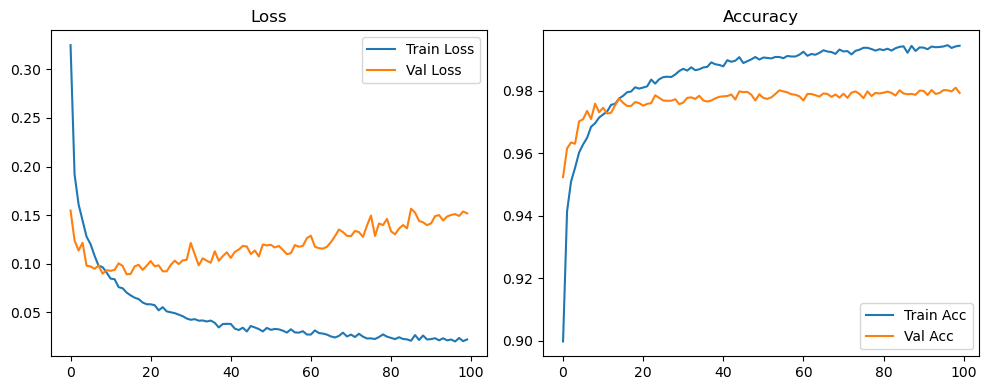

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2738, Acc: 0.9195 | Val Loss: 0.1719, Acc: 0.9528


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1384, Acc: 0.9590 | Val Loss: 0.1481, Acc: 0.9598


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1053, Acc: 0.9686 | Val Loss: 0.1245, Acc: 0.9647


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0764, Acc: 0.9770 | Val Loss: 0.1436, Acc: 0.9615


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9802 | Val Loss: 0.1462, Acc: 0.9655


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9833 | Val Loss: 0.1440, Acc: 0.9678


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9844 | Val Loss: 0.1348, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9884 | Val Loss: 0.1479, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9892 | Val Loss: 0.1325, Acc: 0.9728


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9901 | Val Loss: 0.1308, Acc: 0.9722


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9919 | Val Loss: 0.1395, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9931 | Val Loss: 0.1609, Acc: 0.9718


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9921 | Val Loss: 0.1388, Acc: 0.9718


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9930 | Val Loss: 0.1482, Acc: 0.9717


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9933 | Val Loss: 0.1627, Acc: 0.9707


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9939 | Val Loss: 0.1530, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9952 | Val Loss: 0.1623, Acc: 0.9720


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9944 | Val Loss: 0.1611, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9946 | Val Loss: 0.1612, Acc: 0.9718


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9958 | Val Loss: 0.1464, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9956 | Val Loss: 0.1348, Acc: 0.9753


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9959 | Val Loss: 0.1430, Acc: 0.9747


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.1375, Acc: 0.9756


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9962 | Val Loss: 0.1354, Acc: 0.9752


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9954 | Val Loss: 0.1344, Acc: 0.9770


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.1631, Acc: 0.9740


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9968 | Val Loss: 0.1567, Acc: 0.9758


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1573, Acc: 0.9763


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9971 | Val Loss: 0.1456, Acc: 0.9759


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.1447, Acc: 0.9756


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1651, Acc: 0.9743


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9961 | Val Loss: 0.1305, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1377, Acc: 0.9785


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9976 | Val Loss: 0.1583, Acc: 0.9754


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.1628, Acc: 0.9731


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1637, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9975 | Val Loss: 0.1660, Acc: 0.9766


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9963 | Val Loss: 0.1493, Acc: 0.9771


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1644, Acc: 0.9761


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.1592, Acc: 0.9762


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.1644, Acc: 0.9782


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9980 | Val Loss: 0.1742, Acc: 0.9759


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9968 | Val Loss: 0.1352, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1592, Acc: 0.9778


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9972 | Val Loss: 0.1631, Acc: 0.9745


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1417, Acc: 0.9777


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9987 | Val Loss: 0.1613, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1585, Acc: 0.9769


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.1750, Acc: 0.9778


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1824, Acc: 0.9765


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9976 | Val Loss: 0.1656, Acc: 0.9779


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.2042, Acc: 0.9759


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9973 | Val Loss: 0.1742, Acc: 0.9761


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1942, Acc: 0.9756


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9983 | Val Loss: 0.1823, Acc: 0.9774


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9981 | Val Loss: 0.1952, Acc: 0.9756


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.2109, Acc: 0.9766


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.2026, Acc: 0.9753


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1759, Acc: 0.9755


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1961, Acc: 0.9769


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9984 | Val Loss: 0.1799, Acc: 0.9758


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1924, Acc: 0.9767


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1945, Acc: 0.9749


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9980 | Val Loss: 0.1979, Acc: 0.9763


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.2018, Acc: 0.9778


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9986 | Val Loss: 0.2256, Acc: 0.9759


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9980 | Val Loss: 0.2216, Acc: 0.9762


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.2123, Acc: 0.9774


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9983 | Val Loss: 0.2001, Acc: 0.9780


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9983 | Val Loss: 0.1959, Acc: 0.9763


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1953, Acc: 0.9761


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.2051, Acc: 0.9780


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.2257, Acc: 0.9779


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9979 | Val Loss: 0.1933, Acc: 0.9771


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9986 | Val Loss: 0.1934, Acc: 0.9766


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9989 | Val Loss: 0.1904, Acc: 0.9767


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1921, Acc: 0.9762


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9988 | Val Loss: 0.2451, Acc: 0.9739


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9982 | Val Loss: 0.1952, Acc: 0.9754


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1892, Acc: 0.9782


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9985 | Val Loss: 0.1921, Acc: 0.9775


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9988 | Val Loss: 0.2025, Acc: 0.9760


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9986 | Val Loss: 0.1886, Acc: 0.9772


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.1998, Acc: 0.9774


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.2010, Acc: 0.9793


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9985 | Val Loss: 0.2013, Acc: 0.9763


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9989 | Val Loss: 0.2022, Acc: 0.9780


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9987 | Val Loss: 0.1973, Acc: 0.9785


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.1835, Acc: 0.9805


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9991 | Val Loss: 0.2023, Acc: 0.9788


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9983 | Val Loss: 0.2248, Acc: 0.9756


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.2289, Acc: 0.9771


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.2081, Acc: 0.9795


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9990 | Val Loss: 0.2362, Acc: 0.9755


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.2243, Acc: 0.9766


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9990 | Val Loss: 0.1958, Acc: 0.9790


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9983 | Val Loss: 0.1864, Acc: 0.9761


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9985 | Val Loss: 0.2140, Acc: 0.9771


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9992 | Val Loss: 0.2054, Acc: 0.9770


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.2152, Acc: 0.9773


Final Test Loss: 0.1597 Accuracy: 0.9792


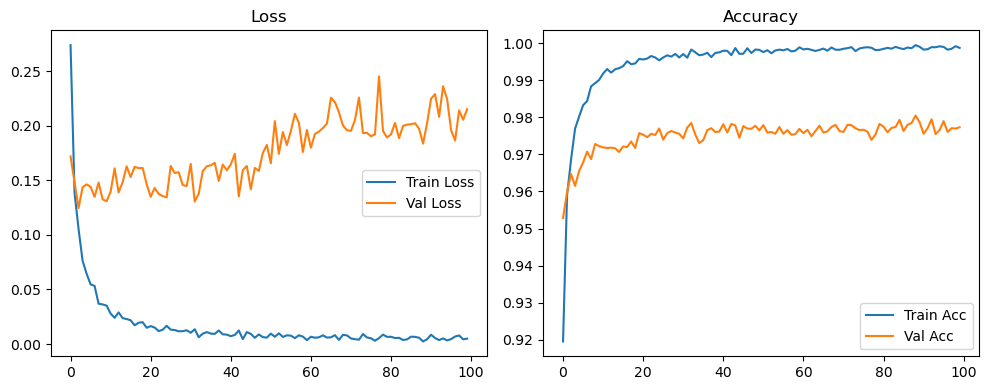

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2956, Acc: 0.9161 | Val Loss: 0.1953, Acc: 0.9425


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1649, Acc: 0.9525 | Val Loss: 0.1398, Acc: 0.9603


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1342, Acc: 0.9610 | Val Loss: 0.1331, Acc: 0.9627


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1045, Acc: 0.9693 | Val Loss: 0.1262, Acc: 0.9658


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0871, Acc: 0.9735 | Val Loss: 0.1217, Acc: 0.9671


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0796, Acc: 0.9767 | Val Loss: 0.1350, Acc: 0.9680


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9792 | Val Loss: 0.1343, Acc: 0.9697


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0618, Acc: 0.9821 | Val Loss: 0.1617, Acc: 0.9678


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9824 | Val Loss: 0.1229, Acc: 0.9741


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9854 | Val Loss: 0.1351, Acc: 0.9719


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9857 | Val Loss: 0.1543, Acc: 0.9718


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9855 | Val Loss: 0.1520, Acc: 0.9710


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9862 | Val Loss: 0.1500, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9884 | Val Loss: 0.1521, Acc: 0.9721


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9885 | Val Loss: 0.1368, Acc: 0.9729


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9890 | Val Loss: 0.1455, Acc: 0.9737


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9901 | Val Loss: 0.1698, Acc: 0.9739


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9903 | Val Loss: 0.1790, Acc: 0.9724


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9908 | Val Loss: 0.1988, Acc: 0.9711


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9913 | Val Loss: 0.1523, Acc: 0.9750


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9922 | Val Loss: 0.1774, Acc: 0.9753


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9912 | Val Loss: 0.1634, Acc: 0.9768


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9923 | Val Loss: 0.1804, Acc: 0.9748


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9923 | Val Loss: 0.1695, Acc: 0.9759


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9923 | Val Loss: 0.1897, Acc: 0.9773


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9931 | Val Loss: 0.1822, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9932 | Val Loss: 0.1918, Acc: 0.9766


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9935 | Val Loss: 0.2038, Acc: 0.9754


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9941 | Val Loss: 0.2206, Acc: 0.9745


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9937 | Val Loss: 0.1954, Acc: 0.9771


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9937 | Val Loss: 0.1995, Acc: 0.9747


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9940 | Val Loss: 0.2268, Acc: 0.9745


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9944 | Val Loss: 0.2065, Acc: 0.9773


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9948 | Val Loss: 0.2165, Acc: 0.9775


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9947 | Val Loss: 0.2157, Acc: 0.9759


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9940 | Val Loss: 0.2512, Acc: 0.9767


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9941 | Val Loss: 0.2463, Acc: 0.9768


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9950 | Val Loss: 0.2307, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9955 | Val Loss: 0.2201, Acc: 0.9782


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9951 | Val Loss: 0.2209, Acc: 0.9767


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9952 | Val Loss: 0.2152, Acc: 0.9769


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9951 | Val Loss: 0.2365, Acc: 0.9781


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9949 | Val Loss: 0.2454, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9959 | Val Loss: 0.2236, Acc: 0.9762


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9960 | Val Loss: 0.2409, Acc: 0.9757


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9950 | Val Loss: 0.2491, Acc: 0.9778


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9951 | Val Loss: 0.2561, Acc: 0.9768


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9957 | Val Loss: 0.2443, Acc: 0.9784


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9960 | Val Loss: 0.2978, Acc: 0.9757


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9955 | Val Loss: 0.2970, Acc: 0.9778


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9963 | Val Loss: 0.2966, Acc: 0.9768


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9957 | Val Loss: 0.2624, Acc: 0.9784


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9962 | Val Loss: 0.2630, Acc: 0.9784


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9960 | Val Loss: 0.2607, Acc: 0.9774


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9968 | Val Loss: 0.2697, Acc: 0.9783


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9961 | Val Loss: 0.2525, Acc: 0.9776


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9957 | Val Loss: 0.2759, Acc: 0.9763


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9962 | Val Loss: 0.2736, Acc: 0.9779


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9971 | Val Loss: 0.2773, Acc: 0.9780


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9963 | Val Loss: 0.2987, Acc: 0.9775


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9958 | Val Loss: 0.3036, Acc: 0.9773


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9965 | Val Loss: 0.3508, Acc: 0.9766


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9963 | Val Loss: 0.2575, Acc: 0.9771


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9972 | Val Loss: 0.3169, Acc: 0.9784


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9973 | Val Loss: 0.2899, Acc: 0.9769


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9962 | Val Loss: 0.3258, Acc: 0.9779


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9965 | Val Loss: 0.3365, Acc: 0.9781


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9968 | Val Loss: 0.3021, Acc: 0.9786


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9971 | Val Loss: 0.3129, Acc: 0.9779


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9968 | Val Loss: 0.3011, Acc: 0.9772


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9973 | Val Loss: 0.3572, Acc: 0.9775


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9970 | Val Loss: 0.4005, Acc: 0.9754


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9969 | Val Loss: 0.3267, Acc: 0.9774


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9968 | Val Loss: 0.3288, Acc: 0.9767


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9970 | Val Loss: 0.3107, Acc: 0.9798


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9972 | Val Loss: 0.3326, Acc: 0.9780


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9964 | Val Loss: 0.3500, Acc: 0.9788


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9977 | Val Loss: 0.3226, Acc: 0.9783


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9975 | Val Loss: 0.2848, Acc: 0.9793


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9969 | Val Loss: 0.3861, Acc: 0.9758


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9971 | Val Loss: 0.3637, Acc: 0.9767


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9973 | Val Loss: 0.3536, Acc: 0.9773


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9968 | Val Loss: 0.3310, Acc: 0.9789


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9970 | Val Loss: 0.3562, Acc: 0.9788


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9967 | Val Loss: 0.3428, Acc: 0.9783


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9975 | Val Loss: 0.3294, Acc: 0.9762


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9974 | Val Loss: 0.3548, Acc: 0.9784


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9973 | Val Loss: 0.3298, Acc: 0.9782


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9978 | Val Loss: 0.3368, Acc: 0.9789


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9978 | Val Loss: 0.3900, Acc: 0.9785


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9973 | Val Loss: 0.4333, Acc: 0.9755


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9973 | Val Loss: 0.3388, Acc: 0.9782


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9977 | Val Loss: 0.3472, Acc: 0.9792


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9978 | Val Loss: 0.3400, Acc: 0.9788


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9973 | Val Loss: 0.4136, Acc: 0.9772


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9979 | Val Loss: 0.3803, Acc: 0.9780


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9971 | Val Loss: 0.3648, Acc: 0.9787


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9976 | Val Loss: 0.3648, Acc: 0.9792


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9980 | Val Loss: 0.3078, Acc: 0.9800


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9983 | Val Loss: 0.3654, Acc: 0.9782


Final Test Loss: 0.3670 Accuracy: 0.9798


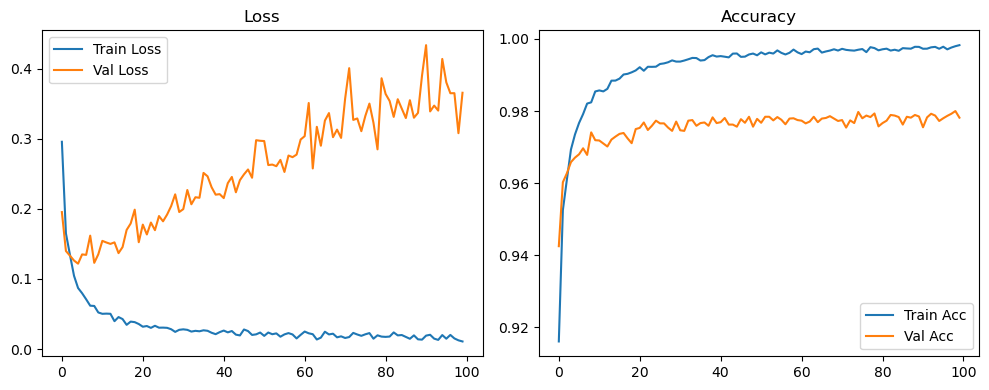

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3729, Acc: 0.8950 | Val Loss: 0.1905, Acc: 0.9475


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2409, Acc: 0.9320 | Val Loss: 0.1494, Acc: 0.9575


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2012, Acc: 0.9436 | Val Loss: 0.1489, Acc: 0.9587


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1757, Acc: 0.9505 | Val Loss: 0.1275, Acc: 0.9669


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1600, Acc: 0.9558 | Val Loss: 0.1213, Acc: 0.9675


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1552, Acc: 0.9570 | Val Loss: 0.1244, Acc: 0.9683


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1479, Acc: 0.9592 | Val Loss: 0.1251, Acc: 0.9700


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1341, Acc: 0.9643 | Val Loss: 0.1271, Acc: 0.9705


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1245, Acc: 0.9665 | Val Loss: 0.1238, Acc: 0.9728


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1248, Acc: 0.9673 | Val Loss: 0.1355, Acc: 0.9715


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1179, Acc: 0.9698 | Val Loss: 0.1288, Acc: 0.9728


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9716 | Val Loss: 0.1310, Acc: 0.9715


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1099, Acc: 0.9722 | Val Loss: 0.1464, Acc: 0.9704


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1148, Acc: 0.9722 | Val Loss: 0.1617, Acc: 0.9698


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1083, Acc: 0.9732 | Val Loss: 0.1439, Acc: 0.9745


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1094, Acc: 0.9738 | Val Loss: 0.1443, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0954, Acc: 0.9771 | Val Loss: 0.1576, Acc: 0.9740


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9777 | Val Loss: 0.1447, Acc: 0.9755


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0878, Acc: 0.9795 | Val Loss: 0.1535, Acc: 0.9761


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9799 | Val Loss: 0.1448, Acc: 0.9780


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0912, Acc: 0.9801 | Val Loss: 0.1710, Acc: 0.9728


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9801 | Val Loss: 0.1527, Acc: 0.9770


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0849, Acc: 0.9812 | Val Loss: 0.1594, Acc: 0.9766


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9825 | Val Loss: 0.1858, Acc: 0.9755


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0920, Acc: 0.9815 | Val Loss: 0.1975, Acc: 0.9762


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9820 | Val Loss: 0.1764, Acc: 0.9779


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0828, Acc: 0.9828 | Val Loss: 0.2002, Acc: 0.9757


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9837 | Val Loss: 0.1872, Acc: 0.9778


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9839 | Val Loss: 0.1752, Acc: 0.9771


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9858 | Val Loss: 0.1924, Acc: 0.9767


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0787, Acc: 0.9850 | Val Loss: 0.1974, Acc: 0.9782


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9844 | Val Loss: 0.2292, Acc: 0.9767


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9854 | Val Loss: 0.2030, Acc: 0.9783


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9870 | Val Loss: 0.2171, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9859 | Val Loss: 0.2179, Acc: 0.9764


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9862 | Val Loss: 0.2138, Acc: 0.9771


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0722, Acc: 0.9867 | Val Loss: 0.2094, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9866 | Val Loss: 0.2535, Acc: 0.9778


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9878 | Val Loss: 0.2609, Acc: 0.9746


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0715, Acc: 0.9871 | Val Loss: 0.2273, Acc: 0.9774


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9877 | Val Loss: 0.2341, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9886 | Val Loss: 0.2600, Acc: 0.9784


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9879 | Val Loss: 0.2699, Acc: 0.9781


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9886 | Val Loss: 0.2298, Acc: 0.9795


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9888 | Val Loss: 0.2360, Acc: 0.9778


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9893 | Val Loss: 0.2689, Acc: 0.9779


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9888 | Val Loss: 0.2125, Acc: 0.9794


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9903 | Val Loss: 0.2489, Acc: 0.9788


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9893 | Val Loss: 0.2663, Acc: 0.9768


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9887 | Val Loss: 0.2760, Acc: 0.9772


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9896 | Val Loss: 0.2629, Acc: 0.9783


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9896 | Val Loss: 0.2474, Acc: 0.9790


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0650, Acc: 0.9898 | Val Loss: 0.2526, Acc: 0.9774


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0631, Acc: 0.9898 | Val Loss: 0.2649, Acc: 0.9772


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9899 | Val Loss: 0.2604, Acc: 0.9782


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9908 | Val Loss: 0.2892, Acc: 0.9783


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9903 | Val Loss: 0.2427, Acc: 0.9804


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9912 | Val Loss: 0.2835, Acc: 0.9784


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9902 | Val Loss: 0.2839, Acc: 0.9792


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9901 | Val Loss: 0.2893, Acc: 0.9788


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9910 | Val Loss: 0.3177, Acc: 0.9789


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0667, Acc: 0.9906 | Val Loss: 0.2925, Acc: 0.9782


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9907 | Val Loss: 0.3056, Acc: 0.9784


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9912 | Val Loss: 0.3041, Acc: 0.9801


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9915 | Val Loss: 0.2984, Acc: 0.9792


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9918 | Val Loss: 0.3462, Acc: 0.9786


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9923 | Val Loss: 0.3465, Acc: 0.9792


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9917 | Val Loss: 0.3625, Acc: 0.9778


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0667, Acc: 0.9912 | Val Loss: 0.3068, Acc: 0.9793


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9921 | Val Loss: 0.3275, Acc: 0.9791


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9918 | Val Loss: 0.3145, Acc: 0.9778


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9926 | Val Loss: 0.3397, Acc: 0.9801


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9925 | Val Loss: 0.3345, Acc: 0.9795


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9926 | Val Loss: 0.3531, Acc: 0.9796


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9930 | Val Loss: 0.3615, Acc: 0.9792


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9922 | Val Loss: 0.3418, Acc: 0.9782


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0629, Acc: 0.9918 | Val Loss: 0.3344, Acc: 0.9788


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9917 | Val Loss: 0.3693, Acc: 0.9759


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9928 | Val Loss: 0.3276, Acc: 0.9794


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9926 | Val Loss: 0.3346, Acc: 0.9793


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9931 | Val Loss: 0.3414, Acc: 0.9780


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9924 | Val Loss: 0.3756, Acc: 0.9783


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9934 | Val Loss: 0.3452, Acc: 0.9789


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9928 | Val Loss: 0.3667, Acc: 0.9791


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0610, Acc: 0.9926 | Val Loss: 0.3514, Acc: 0.9779


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9928 | Val Loss: 0.3256, Acc: 0.9790


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9926 | Val Loss: 0.3639, Acc: 0.9800


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9933 | Val Loss: 0.3336, Acc: 0.9809


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9932 | Val Loss: 0.3420, Acc: 0.9790


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9934 | Val Loss: 0.3795, Acc: 0.9785


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9936 | Val Loss: 0.3847, Acc: 0.9779


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9927 | Val Loss: 0.3821, Acc: 0.9788


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9931 | Val Loss: 0.3823, Acc: 0.9788


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9936 | Val Loss: 0.3840, Acc: 0.9798


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9934 | Val Loss: 0.3814, Acc: 0.9792


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9930 | Val Loss: 0.4137, Acc: 0.9798


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0618, Acc: 0.9927 | Val Loss: 0.3697, Acc: 0.9804


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9938 | Val Loss: 0.4035, Acc: 0.9788


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9936 | Val Loss: 0.3549, Acc: 0.9790


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9937 | Val Loss: 0.4198, Acc: 0.9779


Final Test Loss: 0.3486 Accuracy: 0.9804


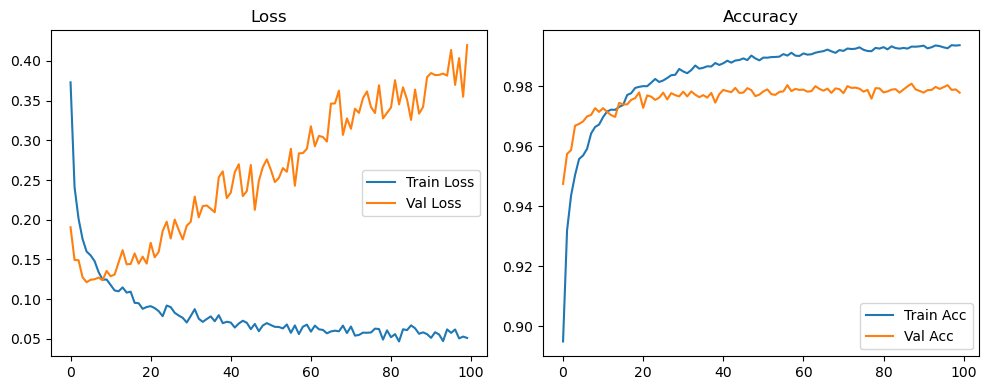

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2738, Acc: 0.9195 | Val Loss: 0.1719, Acc: 0.9528


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1384, Acc: 0.9590 | Val Loss: 0.1481, Acc: 0.9598


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1053, Acc: 0.9686 | Val Loss: 0.1245, Acc: 0.9647


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0764, Acc: 0.9770 | Val Loss: 0.1436, Acc: 0.9615


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9802 | Val Loss: 0.1462, Acc: 0.9655


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9833 | Val Loss: 0.1440, Acc: 0.9678


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9844 | Val Loss: 0.1348, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9884 | Val Loss: 0.1479, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9892 | Val Loss: 0.1325, Acc: 0.9728


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9901 | Val Loss: 0.1308, Acc: 0.9722


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9919 | Val Loss: 0.1395, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9931 | Val Loss: 0.1609, Acc: 0.9718


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9921 | Val Loss: 0.1388, Acc: 0.9718


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9930 | Val Loss: 0.1482, Acc: 0.9717


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9933 | Val Loss: 0.1627, Acc: 0.9707


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9939 | Val Loss: 0.1530, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9952 | Val Loss: 0.1623, Acc: 0.9720


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9944 | Val Loss: 0.1611, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9946 | Val Loss: 0.1612, Acc: 0.9718


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9958 | Val Loss: 0.1464, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9956 | Val Loss: 0.1348, Acc: 0.9753


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9959 | Val Loss: 0.1430, Acc: 0.9747


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.1375, Acc: 0.9756


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9962 | Val Loss: 0.1354, Acc: 0.9752


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9954 | Val Loss: 0.1344, Acc: 0.9770


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.1631, Acc: 0.9740


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9968 | Val Loss: 0.1567, Acc: 0.9758


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1573, Acc: 0.9763


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9971 | Val Loss: 0.1456, Acc: 0.9759


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.1447, Acc: 0.9756


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1651, Acc: 0.9743


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9961 | Val Loss: 0.1305, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1377, Acc: 0.9785


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9976 | Val Loss: 0.1583, Acc: 0.9754


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.1628, Acc: 0.9731


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1637, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9975 | Val Loss: 0.1660, Acc: 0.9766


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9963 | Val Loss: 0.1493, Acc: 0.9771


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1644, Acc: 0.9761


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.1592, Acc: 0.9762


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.1644, Acc: 0.9782


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9980 | Val Loss: 0.1742, Acc: 0.9759


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9968 | Val Loss: 0.1352, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1592, Acc: 0.9778


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9972 | Val Loss: 0.1631, Acc: 0.9745


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1417, Acc: 0.9777


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9987 | Val Loss: 0.1613, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1585, Acc: 0.9769


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.1750, Acc: 0.9778


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1824, Acc: 0.9765


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1500, Acc: 0.9790


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1597, Acc: 0.9792


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1573, Acc: 0.9802


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1636, Acc: 0.9803


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1695, Acc: 0.9797


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1763, Acc: 0.9784


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1723, Acc: 0.9808


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1953, Acc: 0.9772


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9993 | Val Loss: 0.1884, Acc: 0.9798


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1908, Acc: 0.9792


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1989, Acc: 0.9797


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.2158, Acc: 0.9798


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.2164, Acc: 0.9791


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.2140, Acc: 0.9788


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9995 | Val Loss: 0.2213, Acc: 0.9793


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.2172, Acc: 0.9788


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.2131, Acc: 0.9786


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.2160, Acc: 0.9790


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2003, Acc: 0.9808


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.2329, Acc: 0.9788


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.2284, Acc: 0.9800


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9994 | Val Loss: 0.2227, Acc: 0.9782


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2155, Acc: 0.9795


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.2069, Acc: 0.9784


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2237, Acc: 0.9794


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2129, Acc: 0.9786


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.2203, Acc: 0.9794


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.2128, Acc: 0.9768


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.2107, Acc: 0.9791


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.2228, Acc: 0.9774


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2085, Acc: 0.9792


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2014, Acc: 0.9793


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2016, Acc: 0.9807


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2128, Acc: 0.9798


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2026, Acc: 0.9793


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1973, Acc: 0.9801


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2053, Acc: 0.9801


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2040, Acc: 0.9813


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1897, Acc: 0.9815


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1941, Acc: 0.9814


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1940, Acc: 0.9819


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1997, Acc: 0.9811


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2079, Acc: 0.9804


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2122, Acc: 0.9803


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2168, Acc: 0.9815


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2205, Acc: 0.9808


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2159, Acc: 0.9808


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2292, Acc: 0.9804


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2209, Acc: 0.9810


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2248, Acc: 0.9802


Final Test Loss: 0.2035 Accuracy: 0.9824


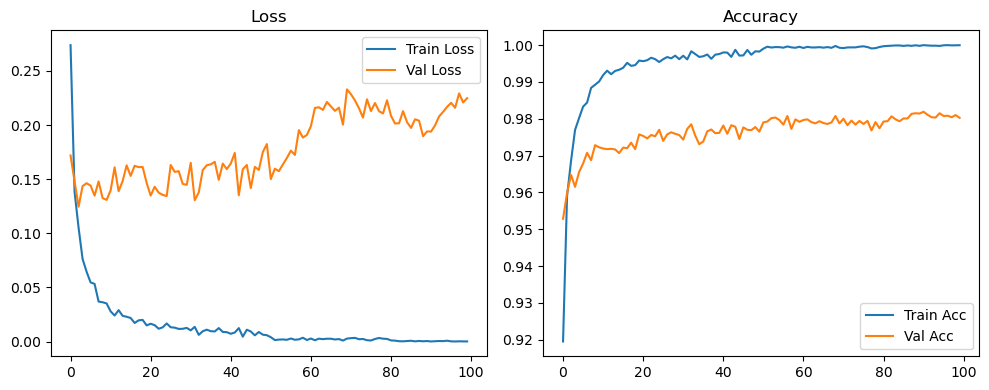

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2956, Acc: 0.9161 | Val Loss: 0.1953, Acc: 0.9425


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1649, Acc: 0.9525 | Val Loss: 0.1398, Acc: 0.9603


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1342, Acc: 0.9610 | Val Loss: 0.1331, Acc: 0.9627


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1045, Acc: 0.9693 | Val Loss: 0.1262, Acc: 0.9658


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0871, Acc: 0.9735 | Val Loss: 0.1217, Acc: 0.9671


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0796, Acc: 0.9767 | Val Loss: 0.1350, Acc: 0.9680


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9792 | Val Loss: 0.1343, Acc: 0.9697


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0618, Acc: 0.9821 | Val Loss: 0.1617, Acc: 0.9678


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9824 | Val Loss: 0.1229, Acc: 0.9741


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9854 | Val Loss: 0.1351, Acc: 0.9719


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9857 | Val Loss: 0.1543, Acc: 0.9718


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9855 | Val Loss: 0.1520, Acc: 0.9710


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9862 | Val Loss: 0.1500, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9884 | Val Loss: 0.1521, Acc: 0.9721


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9885 | Val Loss: 0.1368, Acc: 0.9729


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9890 | Val Loss: 0.1455, Acc: 0.9737


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9901 | Val Loss: 0.1698, Acc: 0.9739


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9903 | Val Loss: 0.1790, Acc: 0.9724


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9908 | Val Loss: 0.1988, Acc: 0.9711


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9913 | Val Loss: 0.1523, Acc: 0.9750


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9922 | Val Loss: 0.1774, Acc: 0.9753


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9912 | Val Loss: 0.1634, Acc: 0.9768


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9923 | Val Loss: 0.1804, Acc: 0.9748


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9923 | Val Loss: 0.1695, Acc: 0.9759


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9923 | Val Loss: 0.1897, Acc: 0.9773


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9931 | Val Loss: 0.1822, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9932 | Val Loss: 0.1918, Acc: 0.9766


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9935 | Val Loss: 0.2038, Acc: 0.9754


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9941 | Val Loss: 0.2206, Acc: 0.9745


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9937 | Val Loss: 0.1954, Acc: 0.9771


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9937 | Val Loss: 0.1995, Acc: 0.9747


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9940 | Val Loss: 0.2268, Acc: 0.9745


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9944 | Val Loss: 0.2065, Acc: 0.9773


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9948 | Val Loss: 0.2165, Acc: 0.9775


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9947 | Val Loss: 0.2157, Acc: 0.9759


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9940 | Val Loss: 0.2512, Acc: 0.9767


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9941 | Val Loss: 0.2463, Acc: 0.9768


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9950 | Val Loss: 0.2307, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9955 | Val Loss: 0.2201, Acc: 0.9782


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9951 | Val Loss: 0.2209, Acc: 0.9767


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9952 | Val Loss: 0.2152, Acc: 0.9769


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9951 | Val Loss: 0.2365, Acc: 0.9781


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9949 | Val Loss: 0.2454, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9959 | Val Loss: 0.2236, Acc: 0.9762


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9960 | Val Loss: 0.2409, Acc: 0.9757


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9950 | Val Loss: 0.2491, Acc: 0.9778


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9951 | Val Loss: 0.2561, Acc: 0.9768


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9957 | Val Loss: 0.2443, Acc: 0.9784


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9960 | Val Loss: 0.2978, Acc: 0.9757


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9955 | Val Loss: 0.2970, Acc: 0.9778


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9978 | Val Loss: 0.2372, Acc: 0.9796


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9983 | Val Loss: 0.2312, Acc: 0.9800


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9985 | Val Loss: 0.2382, Acc: 0.9811


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9986 | Val Loss: 0.2326, Acc: 0.9822


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9990 | Val Loss: 0.2335, Acc: 0.9819


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9986 | Val Loss: 0.2586, Acc: 0.9798


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9983 | Val Loss: 0.2692, Acc: 0.9813


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9982 | Val Loss: 0.2632, Acc: 0.9807


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9986 | Val Loss: 0.2868, Acc: 0.9790


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9986 | Val Loss: 0.2939, Acc: 0.9788


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9983 | Val Loss: 0.2605, Acc: 0.9808


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9987 | Val Loss: 0.2649, Acc: 0.9808


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9982 | Val Loss: 0.2743, Acc: 0.9799


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9987 | Val Loss: 0.2599, Acc: 0.9807


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9987 | Val Loss: 0.2859, Acc: 0.9812


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9986 | Val Loss: 0.2780, Acc: 0.9806


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9988 | Val Loss: 0.2673, Acc: 0.9815


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9987 | Val Loss: 0.2682, Acc: 0.9819


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9986 | Val Loss: 0.2515, Acc: 0.9822


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9983 | Val Loss: 0.2613, Acc: 0.9801


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9988 | Val Loss: 0.2901, Acc: 0.9802


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9988 | Val Loss: 0.2908, Acc: 0.9798


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9989 | Val Loss: 0.2979, Acc: 0.9801


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9989 | Val Loss: 0.3061, Acc: 0.9803


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9990 | Val Loss: 0.3163, Acc: 0.9805


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9988 | Val Loss: 0.3175, Acc: 0.9798


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9987 | Val Loss: 0.3244, Acc: 0.9814


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9987 | Val Loss: 0.3013, Acc: 0.9800


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9986 | Val Loss: 0.3195, Acc: 0.9785


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9986 | Val Loss: 0.3215, Acc: 0.9802


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9990 | Val Loss: 0.2990, Acc: 0.9821


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9992 | Val Loss: 0.2837, Acc: 0.9827


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9993 | Val Loss: 0.3018, Acc: 0.9824


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.2927, Acc: 0.9825


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9995 | Val Loss: 0.2905, Acc: 0.9817


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.2910, Acc: 0.9822


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.2925, Acc: 0.9810


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.2816, Acc: 0.9824


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9997 | Val Loss: 0.2954, Acc: 0.9812


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9995 | Val Loss: 0.2971, Acc: 0.9819


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9995 | Val Loss: 0.2818, Acc: 0.9812


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.2944, Acc: 0.9812


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9996 | Val Loss: 0.2919, Acc: 0.9820


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.3005, Acc: 0.9818


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.3203, Acc: 0.9818


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.3190, Acc: 0.9814


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9995 | Val Loss: 0.3135, Acc: 0.9821


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.3051, Acc: 0.9818


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.3191, Acc: 0.9822


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.3228, Acc: 0.9825


Final Test Loss: 0.2752 Accuracy: 0.9849


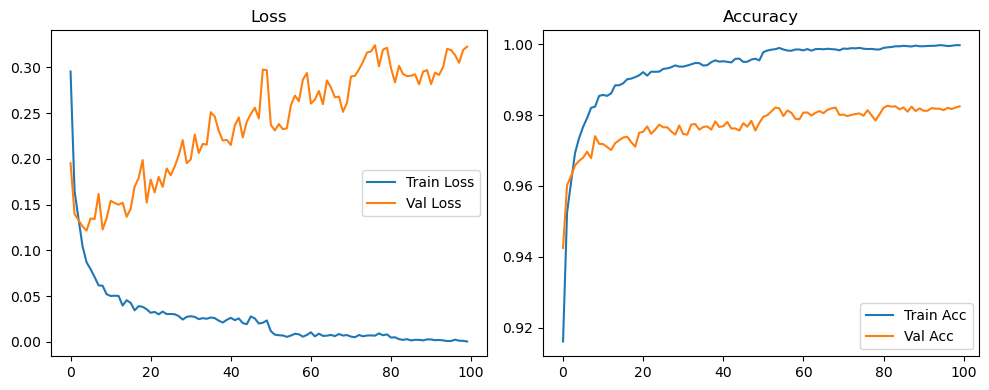

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3729, Acc: 0.8950 | Val Loss: 0.1905, Acc: 0.9475


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2409, Acc: 0.9320 | Val Loss: 0.1494, Acc: 0.9575


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2012, Acc: 0.9436 | Val Loss: 0.1489, Acc: 0.9587


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1757, Acc: 0.9505 | Val Loss: 0.1275, Acc: 0.9669


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1600, Acc: 0.9558 | Val Loss: 0.1213, Acc: 0.9675


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1552, Acc: 0.9570 | Val Loss: 0.1244, Acc: 0.9683


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1479, Acc: 0.9592 | Val Loss: 0.1251, Acc: 0.9700


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1341, Acc: 0.9643 | Val Loss: 0.1271, Acc: 0.9705


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1245, Acc: 0.9665 | Val Loss: 0.1238, Acc: 0.9728


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1248, Acc: 0.9673 | Val Loss: 0.1355, Acc: 0.9715


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1179, Acc: 0.9698 | Val Loss: 0.1288, Acc: 0.9728


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9716 | Val Loss: 0.1310, Acc: 0.9715


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1099, Acc: 0.9722 | Val Loss: 0.1464, Acc: 0.9704


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1148, Acc: 0.9722 | Val Loss: 0.1617, Acc: 0.9698


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1083, Acc: 0.9732 | Val Loss: 0.1439, Acc: 0.9745


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1094, Acc: 0.9738 | Val Loss: 0.1443, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0954, Acc: 0.9771 | Val Loss: 0.1576, Acc: 0.9740


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9777 | Val Loss: 0.1447, Acc: 0.9755


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0878, Acc: 0.9795 | Val Loss: 0.1535, Acc: 0.9761


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9799 | Val Loss: 0.1448, Acc: 0.9780


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0912, Acc: 0.9801 | Val Loss: 0.1710, Acc: 0.9728


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9801 | Val Loss: 0.1527, Acc: 0.9770


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0849, Acc: 0.9812 | Val Loss: 0.1594, Acc: 0.9766


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9825 | Val Loss: 0.1858, Acc: 0.9755


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0920, Acc: 0.9815 | Val Loss: 0.1975, Acc: 0.9762


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9820 | Val Loss: 0.1764, Acc: 0.9779


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0828, Acc: 0.9828 | Val Loss: 0.2002, Acc: 0.9757


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9837 | Val Loss: 0.1872, Acc: 0.9778


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9839 | Val Loss: 0.1752, Acc: 0.9771


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9858 | Val Loss: 0.1924, Acc: 0.9767


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0787, Acc: 0.9850 | Val Loss: 0.1974, Acc: 0.9782


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9844 | Val Loss: 0.2292, Acc: 0.9767


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9854 | Val Loss: 0.2030, Acc: 0.9783


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9870 | Val Loss: 0.2171, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9859 | Val Loss: 0.2179, Acc: 0.9764


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9862 | Val Loss: 0.2138, Acc: 0.9771


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0722, Acc: 0.9867 | Val Loss: 0.2094, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9866 | Val Loss: 0.2535, Acc: 0.9778


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9878 | Val Loss: 0.2609, Acc: 0.9746


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0715, Acc: 0.9871 | Val Loss: 0.2273, Acc: 0.9774


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9877 | Val Loss: 0.2341, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9886 | Val Loss: 0.2600, Acc: 0.9784


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9879 | Val Loss: 0.2699, Acc: 0.9781


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9886 | Val Loss: 0.2298, Acc: 0.9795


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9888 | Val Loss: 0.2360, Acc: 0.9778


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9893 | Val Loss: 0.2689, Acc: 0.9779


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9888 | Val Loss: 0.2125, Acc: 0.9794


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9903 | Val Loss: 0.2489, Acc: 0.9788


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9893 | Val Loss: 0.2663, Acc: 0.9768


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9887 | Val Loss: 0.2760, Acc: 0.9772


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9918 | Val Loss: 0.2320, Acc: 0.9802


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9934 | Val Loss: 0.2266, Acc: 0.9806


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9939 | Val Loss: 0.2240, Acc: 0.9789


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9935 | Val Loss: 0.2183, Acc: 0.9813


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9945 | Val Loss: 0.2291, Acc: 0.9808


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9949 | Val Loss: 0.2467, Acc: 0.9815


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9950 | Val Loss: 0.2340, Acc: 0.9806


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9947 | Val Loss: 0.2417, Acc: 0.9812


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9952 | Val Loss: 0.2436, Acc: 0.9808


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9958 | Val Loss: 0.2485, Acc: 0.9817


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9950 | Val Loss: 0.2675, Acc: 0.9811


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9959 | Val Loss: 0.2574, Acc: 0.9822


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9948 | Val Loss: 0.2610, Acc: 0.9804


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9949 | Val Loss: 0.2578, Acc: 0.9804


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9951 | Val Loss: 0.2568, Acc: 0.9813


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9958 | Val Loss: 0.2596, Acc: 0.9803


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9958 | Val Loss: 0.2714, Acc: 0.9808


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9957 | Val Loss: 0.2665, Acc: 0.9813


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9947 | Val Loss: 0.2852, Acc: 0.9804


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9956 | Val Loss: 0.2907, Acc: 0.9810


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9954 | Val Loss: 0.3091, Acc: 0.9808


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9956 | Val Loss: 0.3072, Acc: 0.9804


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9955 | Val Loss: 0.2801, Acc: 0.9803


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9966 | Val Loss: 0.2665, Acc: 0.9812


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9960 | Val Loss: 0.2855, Acc: 0.9808


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9953 | Val Loss: 0.3032, Acc: 0.9797


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9958 | Val Loss: 0.2923, Acc: 0.9798


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9959 | Val Loss: 0.2891, Acc: 0.9808


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9958 | Val Loss: 0.2879, Acc: 0.9809


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9948 | Val Loss: 0.2553, Acc: 0.9816


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9967 | Val Loss: 0.2612, Acc: 0.9821


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9968 | Val Loss: 0.2546, Acc: 0.9806


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9973 | Val Loss: 0.2481, Acc: 0.9813


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9975 | Val Loss: 0.2499, Acc: 0.9808


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9972 | Val Loss: 0.2489, Acc: 0.9814


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9977 | Val Loss: 0.2537, Acc: 0.9819


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9972 | Val Loss: 0.2665, Acc: 0.9814


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9976 | Val Loss: 0.2463, Acc: 0.9823


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9977 | Val Loss: 0.2460, Acc: 0.9821


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9977 | Val Loss: 0.2379, Acc: 0.9819


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9981 | Val Loss: 0.2514, Acc: 0.9822


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9974 | Val Loss: 0.2656, Acc: 0.9818


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9979 | Val Loss: 0.2624, Acc: 0.9822


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9981 | Val Loss: 0.2549, Acc: 0.9827


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9979 | Val Loss: 0.2779, Acc: 0.9831


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9982 | Val Loss: 0.2633, Acc: 0.9832


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9980 | Val Loss: 0.2748, Acc: 0.9819


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9979 | Val Loss: 0.2931, Acc: 0.9827


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9979 | Val Loss: 0.2828, Acc: 0.9828


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9979 | Val Loss: 0.2974, Acc: 0.9822


Final Test Loss: 0.2469 Accuracy: 0.9829


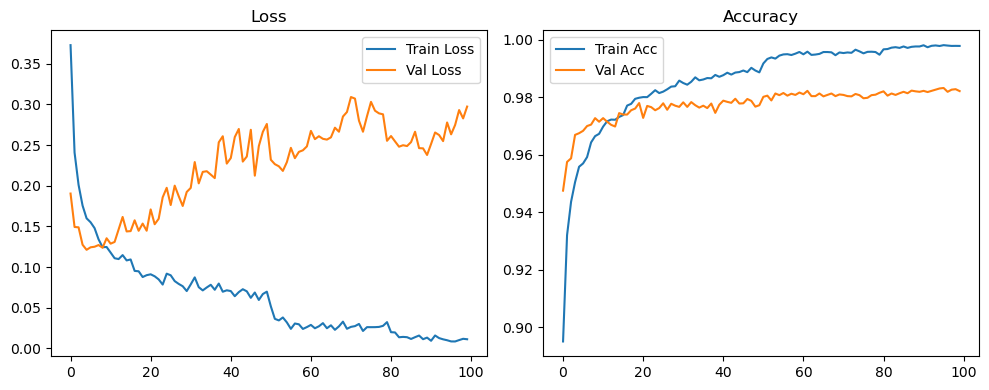

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2738, Acc: 0.9195 | Val Loss: 0.1719, Acc: 0.9528


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1384, Acc: 0.9590 | Val Loss: 0.1481, Acc: 0.9598


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1053, Acc: 0.9686 | Val Loss: 0.1245, Acc: 0.9647


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0764, Acc: 0.9770 | Val Loss: 0.1436, Acc: 0.9615


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9802 | Val Loss: 0.1462, Acc: 0.9655


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9833 | Val Loss: 0.1440, Acc: 0.9678


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9844 | Val Loss: 0.1348, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9884 | Val Loss: 0.1479, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9892 | Val Loss: 0.1325, Acc: 0.9728


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9901 | Val Loss: 0.1308, Acc: 0.9722


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9919 | Val Loss: 0.1395, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9931 | Val Loss: 0.1609, Acc: 0.9718


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9921 | Val Loss: 0.1388, Acc: 0.9718


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9930 | Val Loss: 0.1482, Acc: 0.9717


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9933 | Val Loss: 0.1627, Acc: 0.9707


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9939 | Val Loss: 0.1530, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9952 | Val Loss: 0.1623, Acc: 0.9720


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9944 | Val Loss: 0.1611, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9946 | Val Loss: 0.1612, Acc: 0.9718


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9958 | Val Loss: 0.1464, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9956 | Val Loss: 0.1348, Acc: 0.9753


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9959 | Val Loss: 0.1430, Acc: 0.9747


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.1375, Acc: 0.9756


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9962 | Val Loss: 0.1354, Acc: 0.9752


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9954 | Val Loss: 0.1344, Acc: 0.9770


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.1631, Acc: 0.9740


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9968 | Val Loss: 0.1567, Acc: 0.9758


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1573, Acc: 0.9763


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9971 | Val Loss: 0.1456, Acc: 0.9759


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.1447, Acc: 0.9756


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1651, Acc: 0.9743


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9961 | Val Loss: 0.1305, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1377, Acc: 0.9785


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9976 | Val Loss: 0.1583, Acc: 0.9754


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.1628, Acc: 0.9731


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1637, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9975 | Val Loss: 0.1660, Acc: 0.9766


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9963 | Val Loss: 0.1493, Acc: 0.9771


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1644, Acc: 0.9761


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.1592, Acc: 0.9762


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.1644, Acc: 0.9782


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9980 | Val Loss: 0.1742, Acc: 0.9759


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9968 | Val Loss: 0.1352, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1592, Acc: 0.9778


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9972 | Val Loss: 0.1631, Acc: 0.9745


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1417, Acc: 0.9777


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9987 | Val Loss: 0.1613, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1585, Acc: 0.9769


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.1750, Acc: 0.9778


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1824, Acc: 0.9765


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1500, Acc: 0.9790


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1597, Acc: 0.9792


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1573, Acc: 0.9802


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1636, Acc: 0.9803


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1695, Acc: 0.9797


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1763, Acc: 0.9784


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1723, Acc: 0.9808


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1953, Acc: 0.9772


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9993 | Val Loss: 0.1884, Acc: 0.9798


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1908, Acc: 0.9792


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1989, Acc: 0.9797


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.2158, Acc: 0.9798


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.2164, Acc: 0.9791


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.2140, Acc: 0.9788


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9995 | Val Loss: 0.2213, Acc: 0.9793


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.2172, Acc: 0.9788


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.2131, Acc: 0.9786


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.2160, Acc: 0.9790


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2003, Acc: 0.9808


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.2329, Acc: 0.9788


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.2284, Acc: 0.9800


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9994 | Val Loss: 0.2227, Acc: 0.9782


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2155, Acc: 0.9795


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.2069, Acc: 0.9784


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2237, Acc: 0.9794


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2129, Acc: 0.9786


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.2203, Acc: 0.9794


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.2128, Acc: 0.9768


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.2107, Acc: 0.9791


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.2228, Acc: 0.9774


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2064, Acc: 0.9791


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2034, Acc: 0.9795


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1987, Acc: 0.9801


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1995, Acc: 0.9791


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2015, Acc: 0.9797


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.2037, Acc: 0.9803


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2061, Acc: 0.9806


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2051, Acc: 0.9802


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1990, Acc: 0.9804


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2054, Acc: 0.9808


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1942, Acc: 0.9808


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1974, Acc: 0.9819


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1907, Acc: 0.9814


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1973, Acc: 0.9813


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1972, Acc: 0.9816


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2007, Acc: 0.9802


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1955, Acc: 0.9807


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2037, Acc: 0.9808


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1920, Acc: 0.9812


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2034, Acc: 0.9811


Final Test Loss: 0.1887 Accuracy: 0.9828


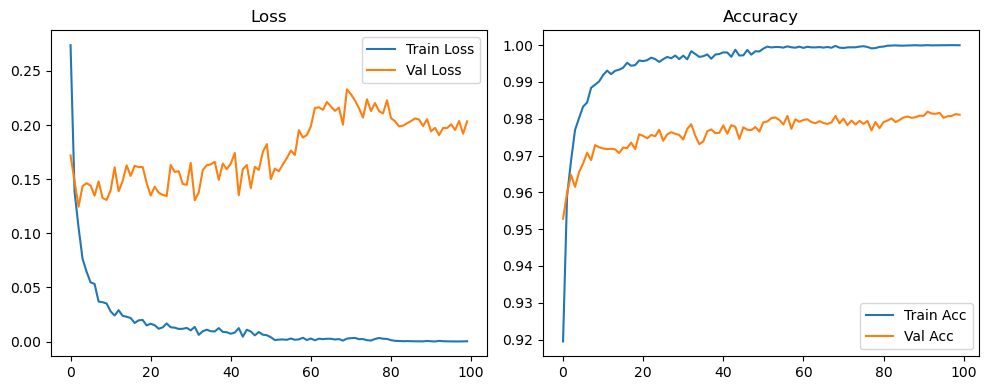

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2956, Acc: 0.9161 | Val Loss: 0.1953, Acc: 0.9425


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1649, Acc: 0.9525 | Val Loss: 0.1398, Acc: 0.9603


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1342, Acc: 0.9610 | Val Loss: 0.1331, Acc: 0.9627


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1045, Acc: 0.9693 | Val Loss: 0.1262, Acc: 0.9658


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0871, Acc: 0.9735 | Val Loss: 0.1217, Acc: 0.9671


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0796, Acc: 0.9767 | Val Loss: 0.1350, Acc: 0.9680


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9792 | Val Loss: 0.1343, Acc: 0.9697


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0618, Acc: 0.9821 | Val Loss: 0.1617, Acc: 0.9678


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9824 | Val Loss: 0.1229, Acc: 0.9741


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9854 | Val Loss: 0.1351, Acc: 0.9719


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9857 | Val Loss: 0.1543, Acc: 0.9718


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9855 | Val Loss: 0.1520, Acc: 0.9710


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9862 | Val Loss: 0.1500, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9884 | Val Loss: 0.1521, Acc: 0.9721


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9885 | Val Loss: 0.1368, Acc: 0.9729


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9890 | Val Loss: 0.1455, Acc: 0.9737


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9901 | Val Loss: 0.1698, Acc: 0.9739


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9903 | Val Loss: 0.1790, Acc: 0.9724


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9908 | Val Loss: 0.1988, Acc: 0.9711


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9913 | Val Loss: 0.1523, Acc: 0.9750


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9922 | Val Loss: 0.1774, Acc: 0.9753


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9912 | Val Loss: 0.1634, Acc: 0.9768


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9923 | Val Loss: 0.1804, Acc: 0.9748


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9923 | Val Loss: 0.1695, Acc: 0.9759


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9923 | Val Loss: 0.1897, Acc: 0.9773


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9931 | Val Loss: 0.1822, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9932 | Val Loss: 0.1918, Acc: 0.9766


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9935 | Val Loss: 0.2038, Acc: 0.9754


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9941 | Val Loss: 0.2206, Acc: 0.9745


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9937 | Val Loss: 0.1954, Acc: 0.9771


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9937 | Val Loss: 0.1995, Acc: 0.9747


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9940 | Val Loss: 0.2268, Acc: 0.9745


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9944 | Val Loss: 0.2065, Acc: 0.9773


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9948 | Val Loss: 0.2165, Acc: 0.9775


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9947 | Val Loss: 0.2157, Acc: 0.9759


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9940 | Val Loss: 0.2512, Acc: 0.9767


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9941 | Val Loss: 0.2463, Acc: 0.9768


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9950 | Val Loss: 0.2307, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9955 | Val Loss: 0.2201, Acc: 0.9782


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9951 | Val Loss: 0.2209, Acc: 0.9767


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9952 | Val Loss: 0.2152, Acc: 0.9769


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9951 | Val Loss: 0.2365, Acc: 0.9781


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9949 | Val Loss: 0.2454, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9959 | Val Loss: 0.2236, Acc: 0.9762


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9960 | Val Loss: 0.2409, Acc: 0.9757


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9950 | Val Loss: 0.2491, Acc: 0.9778


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9951 | Val Loss: 0.2561, Acc: 0.9768


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9957 | Val Loss: 0.2443, Acc: 0.9784


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9960 | Val Loss: 0.2978, Acc: 0.9757


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9955 | Val Loss: 0.2970, Acc: 0.9778


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9978 | Val Loss: 0.2372, Acc: 0.9796


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9983 | Val Loss: 0.2312, Acc: 0.9800


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9985 | Val Loss: 0.2382, Acc: 0.9811


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9986 | Val Loss: 0.2326, Acc: 0.9822


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9990 | Val Loss: 0.2335, Acc: 0.9819


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9986 | Val Loss: 0.2586, Acc: 0.9798


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9983 | Val Loss: 0.2692, Acc: 0.9813


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9982 | Val Loss: 0.2632, Acc: 0.9807


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9986 | Val Loss: 0.2868, Acc: 0.9790


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9986 | Val Loss: 0.2939, Acc: 0.9788


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9983 | Val Loss: 0.2605, Acc: 0.9808


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9987 | Val Loss: 0.2649, Acc: 0.9808


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9982 | Val Loss: 0.2743, Acc: 0.9799


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9987 | Val Loss: 0.2599, Acc: 0.9807


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9987 | Val Loss: 0.2859, Acc: 0.9812


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9986 | Val Loss: 0.2780, Acc: 0.9806


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9988 | Val Loss: 0.2673, Acc: 0.9815


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9987 | Val Loss: 0.2682, Acc: 0.9819


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9986 | Val Loss: 0.2515, Acc: 0.9822


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9983 | Val Loss: 0.2613, Acc: 0.9801


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9988 | Val Loss: 0.2901, Acc: 0.9802


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9988 | Val Loss: 0.2908, Acc: 0.9798


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9989 | Val Loss: 0.2979, Acc: 0.9801


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9989 | Val Loss: 0.3061, Acc: 0.9803


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9990 | Val Loss: 0.3163, Acc: 0.9805


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9988 | Val Loss: 0.3175, Acc: 0.9798


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9987 | Val Loss: 0.3244, Acc: 0.9814


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9987 | Val Loss: 0.3013, Acc: 0.9800


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9986 | Val Loss: 0.3195, Acc: 0.9785


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9986 | Val Loss: 0.3215, Acc: 0.9802


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9991 | Val Loss: 0.3048, Acc: 0.9813


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9991 | Val Loss: 0.2890, Acc: 0.9815


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9996 | Val Loss: 0.3009, Acc: 0.9818


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.2887, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.2907, Acc: 0.9820


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9996 | Val Loss: 0.2933, Acc: 0.9823


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2956, Acc: 0.9827


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.2950, Acc: 0.9818


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.2891, Acc: 0.9824


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.2906, Acc: 0.9822


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9997 | Val Loss: 0.2898, Acc: 0.9824


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.3013, Acc: 0.9823


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.2948, Acc: 0.9829


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2974, Acc: 0.9818


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.3045, Acc: 0.9818


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2981, Acc: 0.9828


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9996 | Val Loss: 0.2996, Acc: 0.9816


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.2996, Acc: 0.9827


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.3127, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2988, Acc: 0.9820


Final Test Loss: 0.2675 Accuracy: 0.9827


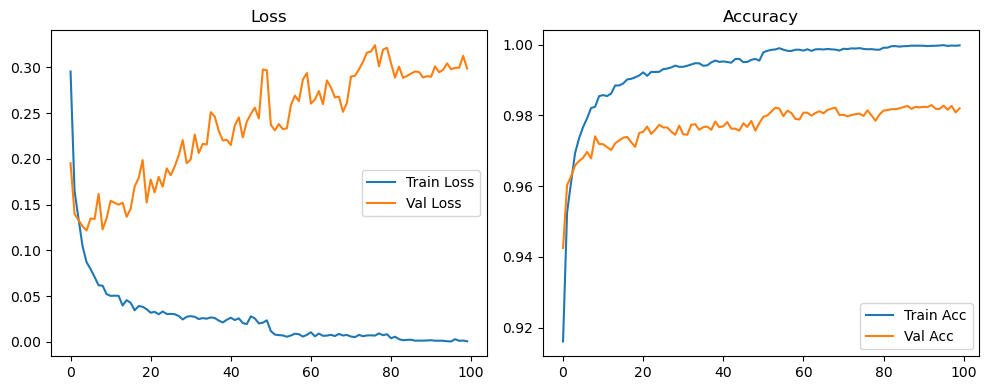

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3729, Acc: 0.8950 | Val Loss: 0.1905, Acc: 0.9475


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2409, Acc: 0.9320 | Val Loss: 0.1494, Acc: 0.9575


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2012, Acc: 0.9436 | Val Loss: 0.1489, Acc: 0.9587


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1757, Acc: 0.9505 | Val Loss: 0.1275, Acc: 0.9669


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1600, Acc: 0.9558 | Val Loss: 0.1213, Acc: 0.9675


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1552, Acc: 0.9570 | Val Loss: 0.1244, Acc: 0.9683


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1479, Acc: 0.9592 | Val Loss: 0.1251, Acc: 0.9700


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1341, Acc: 0.9643 | Val Loss: 0.1271, Acc: 0.9705


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1245, Acc: 0.9665 | Val Loss: 0.1238, Acc: 0.9728


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1248, Acc: 0.9673 | Val Loss: 0.1355, Acc: 0.9715


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1179, Acc: 0.9698 | Val Loss: 0.1288, Acc: 0.9728


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9716 | Val Loss: 0.1310, Acc: 0.9715


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1099, Acc: 0.9722 | Val Loss: 0.1464, Acc: 0.9704


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1148, Acc: 0.9722 | Val Loss: 0.1617, Acc: 0.9698


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1083, Acc: 0.9732 | Val Loss: 0.1439, Acc: 0.9745


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1094, Acc: 0.9738 | Val Loss: 0.1443, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0954, Acc: 0.9771 | Val Loss: 0.1576, Acc: 0.9740


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9777 | Val Loss: 0.1447, Acc: 0.9755


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0878, Acc: 0.9795 | Val Loss: 0.1535, Acc: 0.9761


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9799 | Val Loss: 0.1448, Acc: 0.9780


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0912, Acc: 0.9801 | Val Loss: 0.1710, Acc: 0.9728


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9801 | Val Loss: 0.1527, Acc: 0.9770


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0849, Acc: 0.9812 | Val Loss: 0.1594, Acc: 0.9766


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9825 | Val Loss: 0.1858, Acc: 0.9755


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0920, Acc: 0.9815 | Val Loss: 0.1975, Acc: 0.9762


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9820 | Val Loss: 0.1764, Acc: 0.9779


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0828, Acc: 0.9828 | Val Loss: 0.2002, Acc: 0.9757


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9837 | Val Loss: 0.1872, Acc: 0.9778


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9839 | Val Loss: 0.1752, Acc: 0.9771


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9858 | Val Loss: 0.1924, Acc: 0.9767


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0787, Acc: 0.9850 | Val Loss: 0.1974, Acc: 0.9782


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9844 | Val Loss: 0.2292, Acc: 0.9767


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9854 | Val Loss: 0.2030, Acc: 0.9783


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9870 | Val Loss: 0.2171, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9859 | Val Loss: 0.2179, Acc: 0.9764


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9862 | Val Loss: 0.2138, Acc: 0.9771


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0722, Acc: 0.9867 | Val Loss: 0.2094, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9866 | Val Loss: 0.2535, Acc: 0.9778


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9878 | Val Loss: 0.2609, Acc: 0.9746


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0715, Acc: 0.9871 | Val Loss: 0.2273, Acc: 0.9774


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9877 | Val Loss: 0.2341, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9886 | Val Loss: 0.2600, Acc: 0.9784


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9879 | Val Loss: 0.2699, Acc: 0.9781


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9886 | Val Loss: 0.2298, Acc: 0.9795


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9888 | Val Loss: 0.2360, Acc: 0.9778


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9893 | Val Loss: 0.2689, Acc: 0.9779


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9888 | Val Loss: 0.2125, Acc: 0.9794


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9903 | Val Loss: 0.2489, Acc: 0.9788


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9893 | Val Loss: 0.2663, Acc: 0.9768


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9887 | Val Loss: 0.2760, Acc: 0.9772


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9918 | Val Loss: 0.2320, Acc: 0.9802


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9934 | Val Loss: 0.2266, Acc: 0.9806


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9939 | Val Loss: 0.2240, Acc: 0.9789


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9935 | Val Loss: 0.2183, Acc: 0.9813


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9945 | Val Loss: 0.2291, Acc: 0.9808


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9949 | Val Loss: 0.2467, Acc: 0.9815


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9950 | Val Loss: 0.2340, Acc: 0.9806


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9947 | Val Loss: 0.2417, Acc: 0.9812


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9952 | Val Loss: 0.2436, Acc: 0.9808


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9958 | Val Loss: 0.2485, Acc: 0.9817


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9950 | Val Loss: 0.2675, Acc: 0.9811


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9959 | Val Loss: 0.2574, Acc: 0.9822


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9948 | Val Loss: 0.2610, Acc: 0.9804


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9949 | Val Loss: 0.2578, Acc: 0.9804


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9951 | Val Loss: 0.2568, Acc: 0.9813


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9958 | Val Loss: 0.2596, Acc: 0.9803


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9958 | Val Loss: 0.2714, Acc: 0.9808


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9957 | Val Loss: 0.2665, Acc: 0.9813


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9947 | Val Loss: 0.2852, Acc: 0.9804


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9956 | Val Loss: 0.2907, Acc: 0.9810


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9954 | Val Loss: 0.3091, Acc: 0.9808


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9956 | Val Loss: 0.3072, Acc: 0.9804


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9955 | Val Loss: 0.2801, Acc: 0.9803


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9966 | Val Loss: 0.2665, Acc: 0.9812


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9960 | Val Loss: 0.2855, Acc: 0.9808


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9953 | Val Loss: 0.3032, Acc: 0.9797


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9958 | Val Loss: 0.2923, Acc: 0.9798


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9959 | Val Loss: 0.2891, Acc: 0.9808


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9958 | Val Loss: 0.2879, Acc: 0.9809


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9948 | Val Loss: 0.2553, Acc: 0.9816


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9965 | Val Loss: 0.2599, Acc: 0.9818


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9970 | Val Loss: 0.2543, Acc: 0.9814


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9971 | Val Loss: 0.2529, Acc: 0.9818


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9976 | Val Loss: 0.2510, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9970 | Val Loss: 0.2513, Acc: 0.9811


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9975 | Val Loss: 0.2490, Acc: 0.9818


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9977 | Val Loss: 0.2672, Acc: 0.9816


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9975 | Val Loss: 0.2551, Acc: 0.9816


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9978 | Val Loss: 0.2557, Acc: 0.9823


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9975 | Val Loss: 0.2539, Acc: 0.9819


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9981 | Val Loss: 0.2548, Acc: 0.9815


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9975 | Val Loss: 0.2673, Acc: 0.9818


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9978 | Val Loss: 0.2634, Acc: 0.9825


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9984 | Val Loss: 0.2555, Acc: 0.9827


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9978 | Val Loss: 0.2628, Acc: 0.9834


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9983 | Val Loss: 0.2575, Acc: 0.9826


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9984 | Val Loss: 0.2606, Acc: 0.9821


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9982 | Val Loss: 0.2748, Acc: 0.9822


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9981 | Val Loss: 0.2700, Acc: 0.9819


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9981 | Val Loss: 0.2708, Acc: 0.9830


Final Test Loss: 0.2261 Accuracy: 0.9840


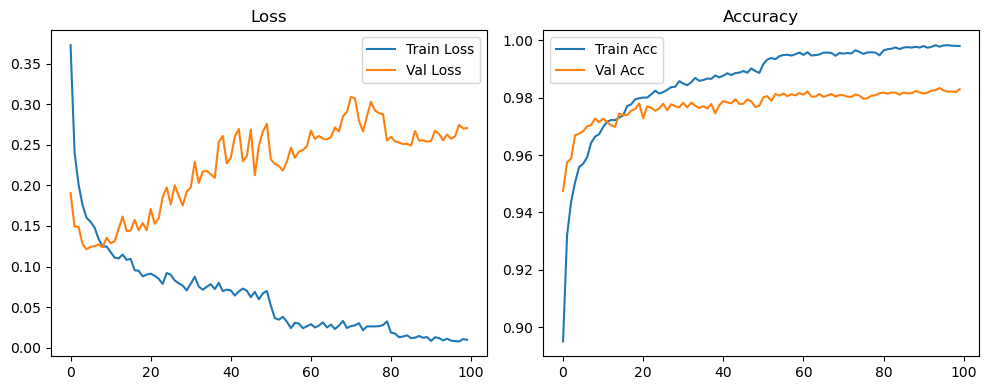

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2738, Acc: 0.9195 | Val Loss: 0.1719, Acc: 0.9528


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1384, Acc: 0.9590 | Val Loss: 0.1481, Acc: 0.9598


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1053, Acc: 0.9686 | Val Loss: 0.1245, Acc: 0.9647


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0764, Acc: 0.9770 | Val Loss: 0.1436, Acc: 0.9615


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9802 | Val Loss: 0.1462, Acc: 0.9655


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9833 | Val Loss: 0.1440, Acc: 0.9678


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9844 | Val Loss: 0.1348, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9884 | Val Loss: 0.1479, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9892 | Val Loss: 0.1325, Acc: 0.9728


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9901 | Val Loss: 0.1308, Acc: 0.9722


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9919 | Val Loss: 0.1395, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9931 | Val Loss: 0.1609, Acc: 0.9718


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9921 | Val Loss: 0.1388, Acc: 0.9718


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9930 | Val Loss: 0.1482, Acc: 0.9717


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9933 | Val Loss: 0.1627, Acc: 0.9707


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9939 | Val Loss: 0.1530, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9952 | Val Loss: 0.1623, Acc: 0.9720


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9944 | Val Loss: 0.1611, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9946 | Val Loss: 0.1612, Acc: 0.9718


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9958 | Val Loss: 0.1464, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9956 | Val Loss: 0.1348, Acc: 0.9753


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9959 | Val Loss: 0.1430, Acc: 0.9747


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.1375, Acc: 0.9756


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9962 | Val Loss: 0.1354, Acc: 0.9752


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9954 | Val Loss: 0.1344, Acc: 0.9770


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.1631, Acc: 0.9740


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9968 | Val Loss: 0.1567, Acc: 0.9758


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1573, Acc: 0.9763


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9971 | Val Loss: 0.1456, Acc: 0.9759


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.1447, Acc: 0.9756


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1651, Acc: 0.9743


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9961 | Val Loss: 0.1305, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1377, Acc: 0.9785


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9976 | Val Loss: 0.1583, Acc: 0.9754


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.1628, Acc: 0.9731


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1637, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9975 | Val Loss: 0.1660, Acc: 0.9766


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9963 | Val Loss: 0.1493, Acc: 0.9771


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1644, Acc: 0.9761


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.1592, Acc: 0.9762


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.1644, Acc: 0.9782


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9980 | Val Loss: 0.1742, Acc: 0.9759


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9968 | Val Loss: 0.1352, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1592, Acc: 0.9778


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9972 | Val Loss: 0.1631, Acc: 0.9745


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1417, Acc: 0.9777


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9987 | Val Loss: 0.1613, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1585, Acc: 0.9769


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.1750, Acc: 0.9778


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1824, Acc: 0.9765


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1498, Acc: 0.9797


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1539, Acc: 0.9799


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1417, Acc: 0.9809


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1414, Acc: 0.9807


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1428, Acc: 0.9816


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1486, Acc: 0.9808


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1564, Acc: 0.9812


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1563, Acc: 0.9810


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1571, Acc: 0.9808


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1632, Acc: 0.9812


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1610, Acc: 0.9802


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1642, Acc: 0.9811


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1690, Acc: 0.9802


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1770, Acc: 0.9808


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1779, Acc: 0.9803


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1818, Acc: 0.9810


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1713, Acc: 0.9811


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1766, Acc: 0.9812


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1741, Acc: 0.9817


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1769, Acc: 0.9809


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1758, Acc: 0.9809


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1932, Acc: 0.9796


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1844, Acc: 0.9811


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1870, Acc: 0.9815


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1896, Acc: 0.9812


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1834, Acc: 0.9812


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1992, Acc: 0.9811


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2003, Acc: 0.9811


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1977, Acc: 0.9802


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2012, Acc: 0.9801


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1980, Acc: 0.9812


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1938, Acc: 0.9807


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2031, Acc: 0.9817


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1992, Acc: 0.9808


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1979, Acc: 0.9806


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2069, Acc: 0.9810


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2055, Acc: 0.9813


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2118, Acc: 0.9807


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2090, Acc: 0.9813


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2089, Acc: 0.9815


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2026, Acc: 0.9812


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2092, Acc: 0.9815


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2010, Acc: 0.9820


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1996, Acc: 0.9813


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1980, Acc: 0.9814


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2059, Acc: 0.9798


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2029, Acc: 0.9806


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2084, Acc: 0.9810


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2050, Acc: 0.9806


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2140, Acc: 0.9808


Final Test Loss: 0.1839 Accuracy: 0.9832


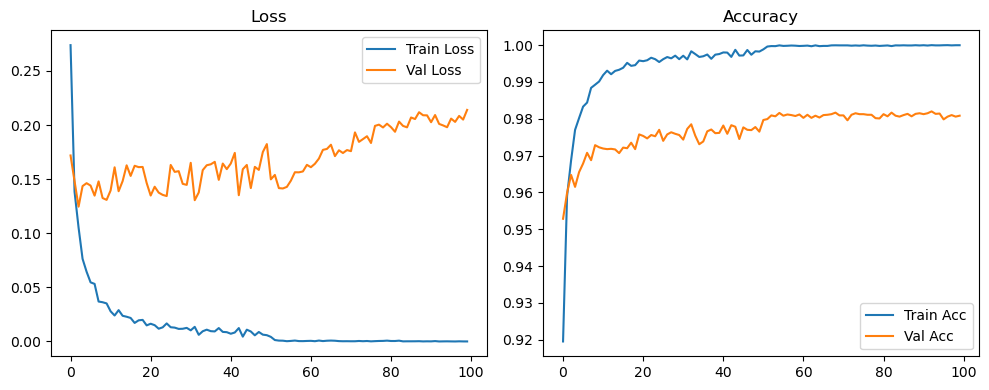

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2956, Acc: 0.9161 | Val Loss: 0.1953, Acc: 0.9425


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1649, Acc: 0.9525 | Val Loss: 0.1398, Acc: 0.9603


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1342, Acc: 0.9610 | Val Loss: 0.1331, Acc: 0.9627


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1045, Acc: 0.9693 | Val Loss: 0.1262, Acc: 0.9658


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0871, Acc: 0.9735 | Val Loss: 0.1217, Acc: 0.9671


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0796, Acc: 0.9767 | Val Loss: 0.1350, Acc: 0.9680


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9792 | Val Loss: 0.1343, Acc: 0.9697


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0618, Acc: 0.9821 | Val Loss: 0.1617, Acc: 0.9678


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9824 | Val Loss: 0.1229, Acc: 0.9741


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9854 | Val Loss: 0.1351, Acc: 0.9719


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9857 | Val Loss: 0.1543, Acc: 0.9718


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9855 | Val Loss: 0.1520, Acc: 0.9710


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9862 | Val Loss: 0.1500, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9884 | Val Loss: 0.1521, Acc: 0.9721


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9885 | Val Loss: 0.1368, Acc: 0.9729


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9890 | Val Loss: 0.1455, Acc: 0.9737


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9901 | Val Loss: 0.1698, Acc: 0.9739


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9903 | Val Loss: 0.1790, Acc: 0.9724


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9908 | Val Loss: 0.1988, Acc: 0.9711


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9913 | Val Loss: 0.1523, Acc: 0.9750


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9922 | Val Loss: 0.1774, Acc: 0.9753


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9912 | Val Loss: 0.1634, Acc: 0.9768


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9923 | Val Loss: 0.1804, Acc: 0.9748


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9923 | Val Loss: 0.1695, Acc: 0.9759


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9923 | Val Loss: 0.1897, Acc: 0.9773


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9931 | Val Loss: 0.1822, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9932 | Val Loss: 0.1918, Acc: 0.9766


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9935 | Val Loss: 0.2038, Acc: 0.9754


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9941 | Val Loss: 0.2206, Acc: 0.9745


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9937 | Val Loss: 0.1954, Acc: 0.9771


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9937 | Val Loss: 0.1995, Acc: 0.9747


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9940 | Val Loss: 0.2268, Acc: 0.9745


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9944 | Val Loss: 0.2065, Acc: 0.9773


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9948 | Val Loss: 0.2165, Acc: 0.9775


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9947 | Val Loss: 0.2157, Acc: 0.9759


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9940 | Val Loss: 0.2512, Acc: 0.9767


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9941 | Val Loss: 0.2463, Acc: 0.9768


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9950 | Val Loss: 0.2307, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9955 | Val Loss: 0.2201, Acc: 0.9782


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9951 | Val Loss: 0.2209, Acc: 0.9767


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9952 | Val Loss: 0.2152, Acc: 0.9769


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9951 | Val Loss: 0.2365, Acc: 0.9781


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9949 | Val Loss: 0.2454, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9959 | Val Loss: 0.2236, Acc: 0.9762


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9960 | Val Loss: 0.2409, Acc: 0.9757


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9950 | Val Loss: 0.2491, Acc: 0.9778


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9951 | Val Loss: 0.2561, Acc: 0.9768


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9957 | Val Loss: 0.2443, Acc: 0.9784


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9960 | Val Loss: 0.2978, Acc: 0.9757


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9955 | Val Loss: 0.2970, Acc: 0.9778


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9978 | Val Loss: 0.2320, Acc: 0.9806


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.2290, Acc: 0.9810


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.2320, Acc: 0.9818


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9988 | Val Loss: 0.2295, Acc: 0.9824


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.2244, Acc: 0.9821


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9993 | Val Loss: 0.2250, Acc: 0.9832


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.2403, Acc: 0.9817


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.2364, Acc: 0.9823


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9994 | Val Loss: 0.2418, Acc: 0.9807


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.2316, Acc: 0.9811


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9994 | Val Loss: 0.2331, Acc: 0.9816


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.2365, Acc: 0.9812


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.2354, Acc: 0.9816


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.2385, Acc: 0.9812


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.2384, Acc: 0.9822


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9996 | Val Loss: 0.2504, Acc: 0.9813


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.2674, Acc: 0.9815


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.2638, Acc: 0.9828


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9995 | Val Loss: 0.2561, Acc: 0.9810


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.2486, Acc: 0.9818


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.2539, Acc: 0.9816


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.2630, Acc: 0.9820


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.2695, Acc: 0.9824


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.2814, Acc: 0.9810


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2772, Acc: 0.9822


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9995 | Val Loss: 0.2836, Acc: 0.9818


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.2791, Acc: 0.9815


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.2942, Acc: 0.9810


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9996 | Val Loss: 0.2825, Acc: 0.9808


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9995 | Val Loss: 0.2658, Acc: 0.9822


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.2596, Acc: 0.9821


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.2629, Acc: 0.9824


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.2628, Acc: 0.9815


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.2712, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9997 | Val Loss: 0.2595, Acc: 0.9821


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2798, Acc: 0.9822


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2776, Acc: 0.9813


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2706, Acc: 0.9821


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9997 | Val Loss: 0.2650, Acc: 0.9825


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.2664, Acc: 0.9820


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2688, Acc: 0.9822


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.2749, Acc: 0.9816


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2742, Acc: 0.9825


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2636, Acc: 0.9829


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2623, Acc: 0.9828


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2691, Acc: 0.9837


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.2708, Acc: 0.9823


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2717, Acc: 0.9822


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2602, Acc: 0.9828


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2692, Acc: 0.9824


Final Test Loss: 0.2207 Accuracy: 0.9836


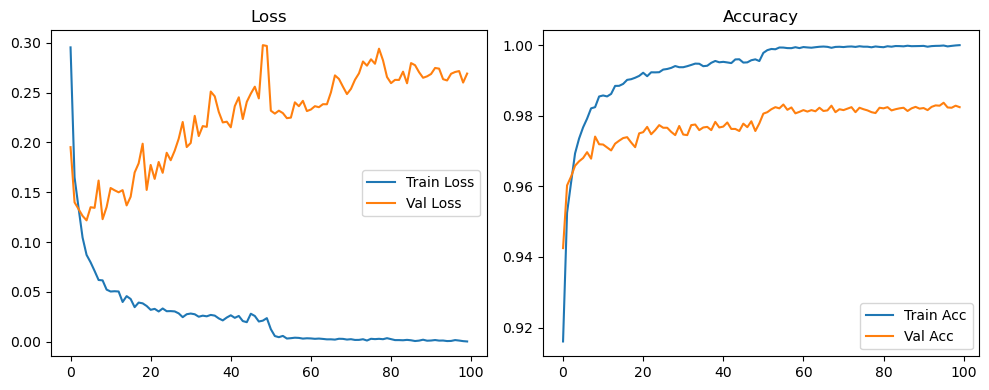

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3729, Acc: 0.8950 | Val Loss: 0.1905, Acc: 0.9475


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2409, Acc: 0.9320 | Val Loss: 0.1494, Acc: 0.9575


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2012, Acc: 0.9436 | Val Loss: 0.1489, Acc: 0.9587


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1757, Acc: 0.9505 | Val Loss: 0.1275, Acc: 0.9669


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1600, Acc: 0.9558 | Val Loss: 0.1213, Acc: 0.9675


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1552, Acc: 0.9570 | Val Loss: 0.1244, Acc: 0.9683


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1479, Acc: 0.9592 | Val Loss: 0.1251, Acc: 0.9700


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1341, Acc: 0.9643 | Val Loss: 0.1271, Acc: 0.9705


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1245, Acc: 0.9665 | Val Loss: 0.1238, Acc: 0.9728


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1248, Acc: 0.9673 | Val Loss: 0.1355, Acc: 0.9715


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1179, Acc: 0.9698 | Val Loss: 0.1288, Acc: 0.9728


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9716 | Val Loss: 0.1310, Acc: 0.9715


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1099, Acc: 0.9722 | Val Loss: 0.1464, Acc: 0.9704


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1148, Acc: 0.9722 | Val Loss: 0.1617, Acc: 0.9698


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1083, Acc: 0.9732 | Val Loss: 0.1439, Acc: 0.9745


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1094, Acc: 0.9738 | Val Loss: 0.1443, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0954, Acc: 0.9771 | Val Loss: 0.1576, Acc: 0.9740


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9777 | Val Loss: 0.1447, Acc: 0.9755


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0878, Acc: 0.9795 | Val Loss: 0.1535, Acc: 0.9761


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9799 | Val Loss: 0.1448, Acc: 0.9780


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0912, Acc: 0.9801 | Val Loss: 0.1710, Acc: 0.9728


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9801 | Val Loss: 0.1527, Acc: 0.9770


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0849, Acc: 0.9812 | Val Loss: 0.1594, Acc: 0.9766


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9825 | Val Loss: 0.1858, Acc: 0.9755


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0920, Acc: 0.9815 | Val Loss: 0.1975, Acc: 0.9762


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9820 | Val Loss: 0.1764, Acc: 0.9779


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0828, Acc: 0.9828 | Val Loss: 0.2002, Acc: 0.9757


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9837 | Val Loss: 0.1872, Acc: 0.9778


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9839 | Val Loss: 0.1752, Acc: 0.9771


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9858 | Val Loss: 0.1924, Acc: 0.9767


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0787, Acc: 0.9850 | Val Loss: 0.1974, Acc: 0.9782


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9844 | Val Loss: 0.2292, Acc: 0.9767


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9854 | Val Loss: 0.2030, Acc: 0.9783


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9870 | Val Loss: 0.2171, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9859 | Val Loss: 0.2179, Acc: 0.9764


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9862 | Val Loss: 0.2138, Acc: 0.9771


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0722, Acc: 0.9867 | Val Loss: 0.2094, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9866 | Val Loss: 0.2535, Acc: 0.9778


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9878 | Val Loss: 0.2609, Acc: 0.9746


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0715, Acc: 0.9871 | Val Loss: 0.2273, Acc: 0.9774


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9877 | Val Loss: 0.2341, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9886 | Val Loss: 0.2600, Acc: 0.9784


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9879 | Val Loss: 0.2699, Acc: 0.9781


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9886 | Val Loss: 0.2298, Acc: 0.9795


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9888 | Val Loss: 0.2360, Acc: 0.9778


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9893 | Val Loss: 0.2689, Acc: 0.9779


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9888 | Val Loss: 0.2125, Acc: 0.9794


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9903 | Val Loss: 0.2489, Acc: 0.9788


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9893 | Val Loss: 0.2663, Acc: 0.9768


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9887 | Val Loss: 0.2760, Acc: 0.9772


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0502, Acc: 0.9919 | Val Loss: 0.2289, Acc: 0.9802


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9940 | Val Loss: 0.2258, Acc: 0.9805


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9941 | Val Loss: 0.2077, Acc: 0.9812


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9943 | Val Loss: 0.2172, Acc: 0.9802


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9947 | Val Loss: 0.2147, Acc: 0.9809


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9952 | Val Loss: 0.2272, Acc: 0.9805


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9954 | Val Loss: 0.2255, Acc: 0.9815


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9956 | Val Loss: 0.2229, Acc: 0.9813


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9964 | Val Loss: 0.2379, Acc: 0.9821


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9965 | Val Loss: 0.2301, Acc: 0.9818


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9962 | Val Loss: 0.2485, Acc: 0.9816


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9959 | Val Loss: 0.2399, Acc: 0.9825


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9967 | Val Loss: 0.2335, Acc: 0.9814


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9963 | Val Loss: 0.2378, Acc: 0.9827


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9972 | Val Loss: 0.2294, Acc: 0.9815


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9967 | Val Loss: 0.2495, Acc: 0.9808


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9970 | Val Loss: 0.2606, Acc: 0.9815


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9976 | Val Loss: 0.2380, Acc: 0.9823


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9971 | Val Loss: 0.2513, Acc: 0.9814


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9972 | Val Loss: 0.2293, Acc: 0.9826


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9971 | Val Loss: 0.2491, Acc: 0.9813


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9977 | Val Loss: 0.2512, Acc: 0.9815


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9968 | Val Loss: 0.2513, Acc: 0.9818


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9980 | Val Loss: 0.2449, Acc: 0.9813


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9972 | Val Loss: 0.2568, Acc: 0.9821


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9973 | Val Loss: 0.2518, Acc: 0.9815


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9978 | Val Loss: 0.2501, Acc: 0.9818


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9976 | Val Loss: 0.2563, Acc: 0.9818


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9972 | Val Loss: 0.2567, Acc: 0.9820


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9972 | Val Loss: 0.2475, Acc: 0.9822


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9979 | Val Loss: 0.2530, Acc: 0.9828


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9978 | Val Loss: 0.2413, Acc: 0.9827


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9978 | Val Loss: 0.2439, Acc: 0.9825


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9983 | Val Loss: 0.2489, Acc: 0.9823


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9980 | Val Loss: 0.2444, Acc: 0.9829


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9981 | Val Loss: 0.2350, Acc: 0.9830


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9977 | Val Loss: 0.2473, Acc: 0.9817


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9983 | Val Loss: 0.2421, Acc: 0.9819


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9980 | Val Loss: 0.2414, Acc: 0.9818


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9978 | Val Loss: 0.2365, Acc: 0.9816


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9982 | Val Loss: 0.2406, Acc: 0.9814


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9980 | Val Loss: 0.2573, Acc: 0.9812


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9983 | Val Loss: 0.2449, Acc: 0.9818


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9986 | Val Loss: 0.2479, Acc: 0.9828


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9979 | Val Loss: 0.2580, Acc: 0.9819


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9984 | Val Loss: 0.2610, Acc: 0.9821


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9981 | Val Loss: 0.2578, Acc: 0.9823


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9981 | Val Loss: 0.2570, Acc: 0.9822


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.2634, Acc: 0.9807


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9984 | Val Loss: 0.2591, Acc: 0.9815


Final Test Loss: 0.2230 Accuracy: 0.9840


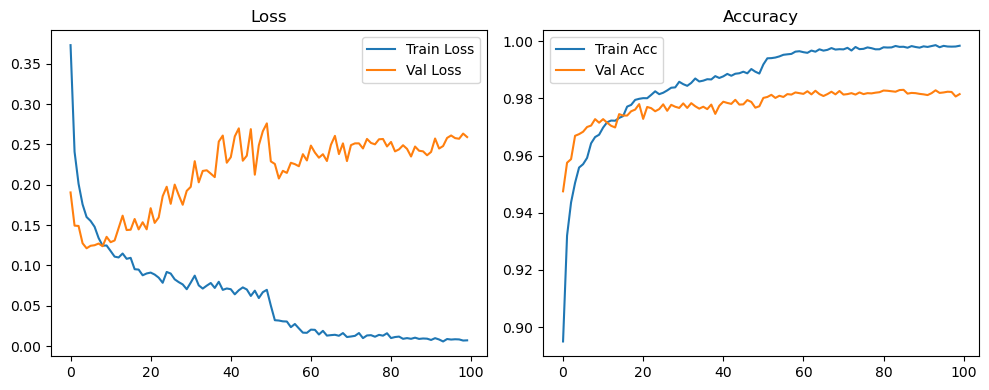

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2477, Acc: 0.9262 | Val Loss: 0.1771, Acc: 0.9489


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1278, Acc: 0.9617 | Val Loss: 0.1293, Acc: 0.9615


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0951, Acc: 0.9710 | Val Loss: 0.1202, Acc: 0.9652


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0723, Acc: 0.9775 | Val Loss: 0.1240, Acc: 0.9648


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9813 | Val Loss: 0.1286, Acc: 0.9659


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9851 | Val Loss: 0.1139, Acc: 0.9719


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9859 | Val Loss: 0.1406, Acc: 0.9692


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9883 | Val Loss: 0.1303, Acc: 0.9699


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9899 | Val Loss: 0.1321, Acc: 0.9728


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9908 | Val Loss: 0.1321, Acc: 0.9722


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9903 | Val Loss: 0.1343, Acc: 0.9709


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9911 | Val Loss: 0.1231, Acc: 0.9742


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.1405, Acc: 0.9716


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9931 | Val Loss: 0.1216, Acc: 0.9748


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9939 | Val Loss: 0.1231, Acc: 0.9744


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9944 | Val Loss: 0.1334, Acc: 0.9750


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9945 | Val Loss: 0.1271, Acc: 0.9742


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.1526, Acc: 0.9722


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9946 | Val Loss: 0.1354, Acc: 0.9742


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.1376, Acc: 0.9732


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1433, Acc: 0.9746


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9952 | Val Loss: 0.1476, Acc: 0.9724


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9966 | Val Loss: 0.1389, Acc: 0.9755


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.1383, Acc: 0.9756


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.1494, Acc: 0.9728


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.1506, Acc: 0.9746


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.1459, Acc: 0.9749


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1465, Acc: 0.9733


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9961 | Val Loss: 0.1586, Acc: 0.9734


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1592, Acc: 0.9765


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9969 | Val Loss: 0.1611, Acc: 0.9748


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1645, Acc: 0.9744


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1450, Acc: 0.9760


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1499, Acc: 0.9762


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9975 | Val Loss: 0.1427, Acc: 0.9775


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9971 | Val Loss: 0.1326, Acc: 0.9782


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1423, Acc: 0.9782


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9978 | Val Loss: 0.1462, Acc: 0.9768


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1590, Acc: 0.9765


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1433, Acc: 0.9758


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.1560, Acc: 0.9759


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1564, Acc: 0.9762


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9985 | Val Loss: 0.1464, Acc: 0.9768


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.1772, Acc: 0.9758


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9972 | Val Loss: 0.1615, Acc: 0.9745


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.1569, Acc: 0.9763


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1858, Acc: 0.9748


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1704, Acc: 0.9749


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1620, Acc: 0.9773


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1812, Acc: 0.9746


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9978 | Val Loss: 0.1569, Acc: 0.9753


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1635, Acc: 0.9772


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1633, Acc: 0.9769


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9983 | Val Loss: 0.1554, Acc: 0.9771


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1682, Acc: 0.9772


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9981 | Val Loss: 0.1733, Acc: 0.9761


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1697, Acc: 0.9768


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1687, Acc: 0.9766


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1790, Acc: 0.9750


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9981 | Val Loss: 0.1656, Acc: 0.9765


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.2001, Acc: 0.9744


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1867, Acc: 0.9776


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1692, Acc: 0.9769


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1647, Acc: 0.9772


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9991 | Val Loss: 0.1786, Acc: 0.9782


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1799, Acc: 0.9768


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1698, Acc: 0.9790


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.2219, Acc: 0.9760


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9977 | Val Loss: 0.1754, Acc: 0.9764


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9985 | Val Loss: 0.1828, Acc: 0.9761


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1861, Acc: 0.9760


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1947, Acc: 0.9764


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9991 | Val Loss: 0.1694, Acc: 0.9777


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1668, Acc: 0.9786


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9987 | Val Loss: 0.1840, Acc: 0.9778


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1831, Acc: 0.9785


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1785, Acc: 0.9798


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.2010, Acc: 0.9759


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1804, Acc: 0.9780


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1767, Acc: 0.9757


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9983 | Val Loss: 0.1979, Acc: 0.9776


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9989 | Val Loss: 0.1858, Acc: 0.9770


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1866, Acc: 0.9770


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1811, Acc: 0.9782


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.2104, Acc: 0.9753


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9985 | Val Loss: 0.2103, Acc: 0.9756


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.2051, Acc: 0.9758


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1847, Acc: 0.9781


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9988 | Val Loss: 0.2089, Acc: 0.9771


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.2102, Acc: 0.9765


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.1996, Acc: 0.9766


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9986 | Val Loss: 0.2154, Acc: 0.9754


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1998, Acc: 0.9774


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.2032, Acc: 0.9791


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2164, Acc: 0.9782


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9989 | Val Loss: 0.2106, Acc: 0.9768


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.2125, Acc: 0.9772


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9990 | Val Loss: 0.2175, Acc: 0.9767


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9990 | Val Loss: 0.2403, Acc: 0.9770


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.2253, Acc: 0.9774


Final Test Loss: 0.2034 Accuracy: 0.9787


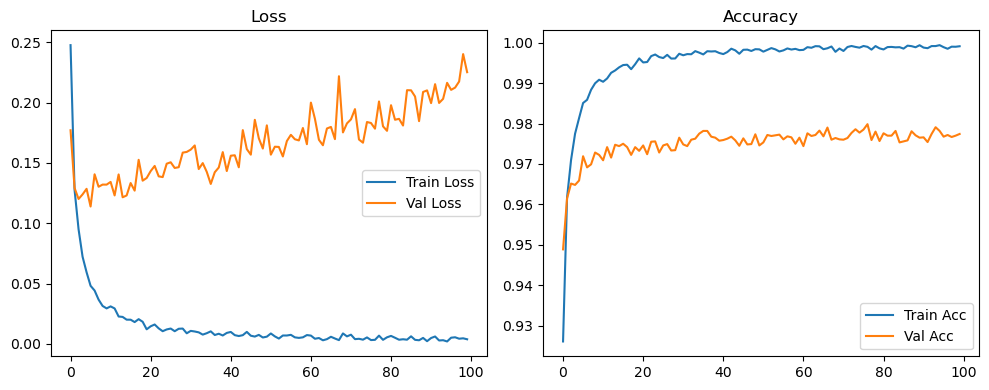

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2627, Acc: 0.9221 | Val Loss: 0.1884, Acc: 0.9469


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1447, Acc: 0.9566 | Val Loss: 0.1238, Acc: 0.9643


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1145, Acc: 0.9656 | Val Loss: 0.1337, Acc: 0.9605


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0930, Acc: 0.9715 | Val Loss: 0.1199, Acc: 0.9661


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0775, Acc: 0.9765 | Val Loss: 0.1189, Acc: 0.9667


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9793 | Val Loss: 0.1211, Acc: 0.9696


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0636, Acc: 0.9802 | Val Loss: 0.1187, Acc: 0.9707


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9839 | Val Loss: 0.1525, Acc: 0.9641


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9838 | Val Loss: 0.1100, Acc: 0.9735


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9864 | Val Loss: 0.1135, Acc: 0.9719


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9861 | Val Loss: 0.1304, Acc: 0.9726


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9882 | Val Loss: 0.1200, Acc: 0.9728


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9886 | Val Loss: 0.1352, Acc: 0.9718


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9895 | Val Loss: 0.1422, Acc: 0.9723


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9903 | Val Loss: 0.1283, Acc: 0.9732


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9899 | Val Loss: 0.1226, Acc: 0.9730


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9908 | Val Loss: 0.1291, Acc: 0.9746


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9913 | Val Loss: 0.1636, Acc: 0.9706


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9914 | Val Loss: 0.1512, Acc: 0.9735


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9915 | Val Loss: 0.1431, Acc: 0.9758


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9921 | Val Loss: 0.1555, Acc: 0.9760


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9941 | Val Loss: 0.1411, Acc: 0.9763


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9936 | Val Loss: 0.1440, Acc: 0.9751


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9939 | Val Loss: 0.1363, Acc: 0.9747


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9941 | Val Loss: 0.1468, Acc: 0.9752


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9926 | Val Loss: 0.1436, Acc: 0.9762


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9942 | Val Loss: 0.1462, Acc: 0.9764


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9938 | Val Loss: 0.1375, Acc: 0.9767


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9947 | Val Loss: 0.1377, Acc: 0.9781


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.1513, Acc: 0.9767


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9955 | Val Loss: 0.1614, Acc: 0.9757


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9947 | Val Loss: 0.1703, Acc: 0.9751


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9952 | Val Loss: 0.1633, Acc: 0.9756


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9951 | Val Loss: 0.1460, Acc: 0.9770


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9962 | Val Loss: 0.1669, Acc: 0.9744


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9951 | Val Loss: 0.1617, Acc: 0.9759


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9954 | Val Loss: 0.1667, Acc: 0.9772


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9956 | Val Loss: 0.1672, Acc: 0.9748


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9961 | Val Loss: 0.1897, Acc: 0.9771


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9952 | Val Loss: 0.1869, Acc: 0.9757


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9958 | Val Loss: 0.1814, Acc: 0.9772


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9960 | Val Loss: 0.1907, Acc: 0.9766


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9959 | Val Loss: 0.1860, Acc: 0.9774


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9962 | Val Loss: 0.1895, Acc: 0.9756


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9951 | Val Loss: 0.1744, Acc: 0.9768


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9957 | Val Loss: 0.1730, Acc: 0.9780


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9968 | Val Loss: 0.1993, Acc: 0.9772


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9967 | Val Loss: 0.1840, Acc: 0.9781


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9966 | Val Loss: 0.2172, Acc: 0.9757


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9969 | Val Loss: 0.2156, Acc: 0.9776


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9965 | Val Loss: 0.2443, Acc: 0.9755


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9962 | Val Loss: 0.2213, Acc: 0.9759


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9963 | Val Loss: 0.2446, Acc: 0.9738


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9970 | Val Loss: 0.2101, Acc: 0.9778


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9969 | Val Loss: 0.2156, Acc: 0.9766


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9966 | Val Loss: 0.2030, Acc: 0.9760


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9966 | Val Loss: 0.2035, Acc: 0.9777


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9974 | Val Loss: 0.2091, Acc: 0.9774


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9975 | Val Loss: 0.2146, Acc: 0.9758


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9973 | Val Loss: 0.2092, Acc: 0.9779


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9975 | Val Loss: 0.2100, Acc: 0.9786


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9973 | Val Loss: 0.2113, Acc: 0.9782


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9964 | Val Loss: 0.2038, Acc: 0.9769


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9966 | Val Loss: 0.2152, Acc: 0.9770


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9973 | Val Loss: 0.2258, Acc: 0.9769


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9972 | Val Loss: 0.1975, Acc: 0.9792


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9969 | Val Loss: 0.2230, Acc: 0.9777


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9971 | Val Loss: 0.2229, Acc: 0.9774


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9975 | Val Loss: 0.2064, Acc: 0.9763


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9972 | Val Loss: 0.2311, Acc: 0.9772


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9976 | Val Loss: 0.2190, Acc: 0.9780


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9978 | Val Loss: 0.2403, Acc: 0.9786


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9974 | Val Loss: 0.2305, Acc: 0.9788


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9977 | Val Loss: 0.2475, Acc: 0.9774


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9973 | Val Loss: 0.2641, Acc: 0.9767


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9974 | Val Loss: 0.2457, Acc: 0.9774


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9973 | Val Loss: 0.2800, Acc: 0.9757


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9979 | Val Loss: 0.2688, Acc: 0.9776


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9976 | Val Loss: 0.2704, Acc: 0.9760


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9976 | Val Loss: 0.3097, Acc: 0.9763


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9977 | Val Loss: 0.2717, Acc: 0.9785


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9974 | Val Loss: 0.2854, Acc: 0.9773


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9974 | Val Loss: 0.2639, Acc: 0.9783


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9979 | Val Loss: 0.2470, Acc: 0.9772


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9982 | Val Loss: 0.2606, Acc: 0.9768


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9980 | Val Loss: 0.2639, Acc: 0.9796


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9973 | Val Loss: 0.2802, Acc: 0.9782


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9979 | Val Loss: 0.2899, Acc: 0.9776


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9980 | Val Loss: 0.2733, Acc: 0.9788


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9985 | Val Loss: 0.2855, Acc: 0.9772


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9973 | Val Loss: 0.2707, Acc: 0.9783


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9980 | Val Loss: 0.2935, Acc: 0.9767


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9980 | Val Loss: 0.2972, Acc: 0.9770


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9973 | Val Loss: 0.2768, Acc: 0.9769


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9980 | Val Loss: 0.2752, Acc: 0.9784


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9975 | Val Loss: 0.2758, Acc: 0.9783


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9979 | Val Loss: 0.2609, Acc: 0.9789


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9982 | Val Loss: 0.3091, Acc: 0.9755


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9985 | Val Loss: 0.2914, Acc: 0.9788


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9984 | Val Loss: 0.2966, Acc: 0.9783


Final Test Loss: 0.2403 Accuracy: 0.9815


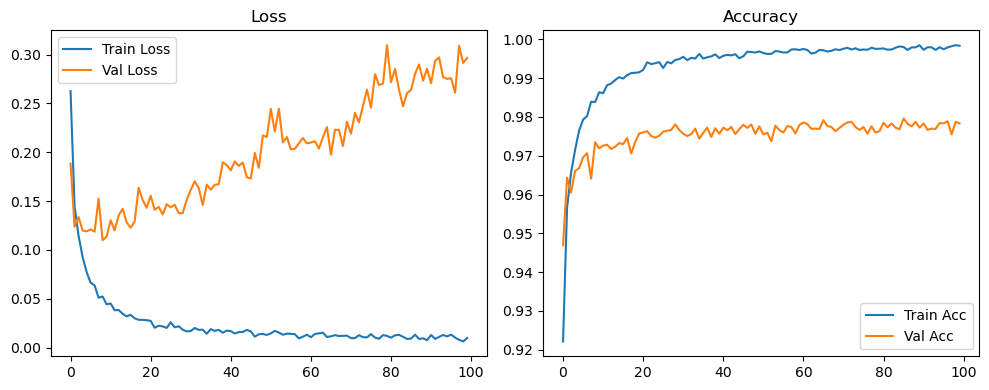

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3297, Acc: 0.9034 | Val Loss: 0.1911, Acc: 0.9475


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2100, Acc: 0.9391 | Val Loss: 0.1333, Acc: 0.9587


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1710, Acc: 0.9499 | Val Loss: 0.1231, Acc: 0.9633


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1488, Acc: 0.9561 | Val Loss: 0.1382, Acc: 0.9623


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1389, Acc: 0.9581 | Val Loss: 0.1090, Acc: 0.9694


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1175, Acc: 0.9651 | Val Loss: 0.1126, Acc: 0.9706


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1200, Acc: 0.9651 | Val Loss: 0.1052, Acc: 0.9700


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1060, Acc: 0.9679 | Val Loss: 0.1208, Acc: 0.9684


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1022, Acc: 0.9694 | Val Loss: 0.1093, Acc: 0.9734


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0969, Acc: 0.9705 | Val Loss: 0.1083, Acc: 0.9730


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0945, Acc: 0.9720 | Val Loss: 0.1122, Acc: 0.9707


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0863, Acc: 0.9753 | Val Loss: 0.1038, Acc: 0.9745


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0816, Acc: 0.9753 | Val Loss: 0.1134, Acc: 0.9728


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0790, Acc: 0.9764 | Val Loss: 0.1223, Acc: 0.9726


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0797, Acc: 0.9771 | Val Loss: 0.1160, Acc: 0.9742


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0720, Acc: 0.9790 | Val Loss: 0.1133, Acc: 0.9732


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0672, Acc: 0.9807 | Val Loss: 0.1161, Acc: 0.9774


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0674, Acc: 0.9803 | Val Loss: 0.1148, Acc: 0.9758


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0708, Acc: 0.9807 | Val Loss: 0.1223, Acc: 0.9740


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0663, Acc: 0.9816 | Val Loss: 0.1178, Acc: 0.9754


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9827 | Val Loss: 0.1410, Acc: 0.9735


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0621, Acc: 0.9830 | Val Loss: 0.1231, Acc: 0.9762


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0585, Acc: 0.9834 | Val Loss: 0.1268, Acc: 0.9775


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0584, Acc: 0.9844 | Val Loss: 0.1316, Acc: 0.9779


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9855 | Val Loss: 0.1324, Acc: 0.9770


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0574, Acc: 0.9849 | Val Loss: 0.1382, Acc: 0.9778


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9857 | Val Loss: 0.1337, Acc: 0.9770


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9861 | Val Loss: 0.1423, Acc: 0.9775


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9868 | Val Loss: 0.1294, Acc: 0.9788


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9862 | Val Loss: 0.1417, Acc: 0.9775


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9870 | Val Loss: 0.1446, Acc: 0.9773


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9865 | Val Loss: 0.1385, Acc: 0.9773


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9883 | Val Loss: 0.1398, Acc: 0.9781


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9884 | Val Loss: 0.1412, Acc: 0.9788


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9884 | Val Loss: 0.1618, Acc: 0.9772


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9893 | Val Loss: 0.1545, Acc: 0.9770


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9872 | Val Loss: 0.1651, Acc: 0.9773


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9884 | Val Loss: 0.1665, Acc: 0.9774


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9892 | Val Loss: 0.1813, Acc: 0.9754


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9895 | Val Loss: 0.1648, Acc: 0.9755


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9888 | Val Loss: 0.1729, Acc: 0.9779


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0430, Acc: 0.9896 | Val Loss: 0.1694, Acc: 0.9778


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9900 | Val Loss: 0.1644, Acc: 0.9768


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9894 | Val Loss: 0.1625, Acc: 0.9783


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9903 | Val Loss: 0.1721, Acc: 0.9780


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9897 | Val Loss: 0.1879, Acc: 0.9782


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9902 | Val Loss: 0.2053, Acc: 0.9765


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9906 | Val Loss: 0.1737, Acc: 0.9772


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9902 | Val Loss: 0.1716, Acc: 0.9778


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9908 | Val Loss: 0.1757, Acc: 0.9782


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9915 | Val Loss: 0.1804, Acc: 0.9777


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9916 | Val Loss: 0.1855, Acc: 0.9778


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9916 | Val Loss: 0.1928, Acc: 0.9793


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9917 | Val Loss: 0.1774, Acc: 0.9784


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9916 | Val Loss: 0.1808, Acc: 0.9780


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9916 | Val Loss: 0.2051, Acc: 0.9788


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9911 | Val Loss: 0.1976, Acc: 0.9776


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9918 | Val Loss: 0.2204, Acc: 0.9791


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9918 | Val Loss: 0.1980, Acc: 0.9789


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9921 | Val Loss: 0.1955, Acc: 0.9800


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9923 | Val Loss: 0.1891, Acc: 0.9798


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9926 | Val Loss: 0.2180, Acc: 0.9778


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9920 | Val Loss: 0.2052, Acc: 0.9778


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9919 | Val Loss: 0.2148, Acc: 0.9802


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9927 | Val Loss: 0.2019, Acc: 0.9782


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9924 | Val Loss: 0.2128, Acc: 0.9778


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9923 | Val Loss: 0.2040, Acc: 0.9777


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9927 | Val Loss: 0.2284, Acc: 0.9790


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9930 | Val Loss: 0.2101, Acc: 0.9798


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9926 | Val Loss: 0.2138, Acc: 0.9795


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9925 | Val Loss: 0.2160, Acc: 0.9794


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9935 | Val Loss: 0.2468, Acc: 0.9781


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9938 | Val Loss: 0.2239, Acc: 0.9791


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9928 | Val Loss: 0.2384, Acc: 0.9796


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9941 | Val Loss: 0.2250, Acc: 0.9773


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9928 | Val Loss: 0.2418, Acc: 0.9787


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9930 | Val Loss: 0.2374, Acc: 0.9802


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9928 | Val Loss: 0.2480, Acc: 0.9798


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9931 | Val Loss: 0.2345, Acc: 0.9784


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9935 | Val Loss: 0.2263, Acc: 0.9786


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9943 | Val Loss: 0.2248, Acc: 0.9800


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9932 | Val Loss: 0.2239, Acc: 0.9793


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9935 | Val Loss: 0.2344, Acc: 0.9798


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9941 | Val Loss: 0.2301, Acc: 0.9786


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9937 | Val Loss: 0.2409, Acc: 0.9792


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9936 | Val Loss: 0.2213, Acc: 0.9798


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9936 | Val Loss: 0.2408, Acc: 0.9792


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9944 | Val Loss: 0.2344, Acc: 0.9790


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9948 | Val Loss: 0.2383, Acc: 0.9798


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9936 | Val Loss: 0.2354, Acc: 0.9794


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9942 | Val Loss: 0.2409, Acc: 0.9796


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9942 | Val Loss: 0.2616, Acc: 0.9794


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9939 | Val Loss: 0.2478, Acc: 0.9808


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9938 | Val Loss: 0.2596, Acc: 0.9799


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9942 | Val Loss: 0.2653, Acc: 0.9804


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9944 | Val Loss: 0.2483, Acc: 0.9802


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9943 | Val Loss: 0.2514, Acc: 0.9780


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9951 | Val Loss: 0.2539, Acc: 0.9798


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9948 | Val Loss: 0.2412, Acc: 0.9812


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9951 | Val Loss: 0.2616, Acc: 0.9802


Final Test Loss: 0.2542 Accuracy: 0.9800


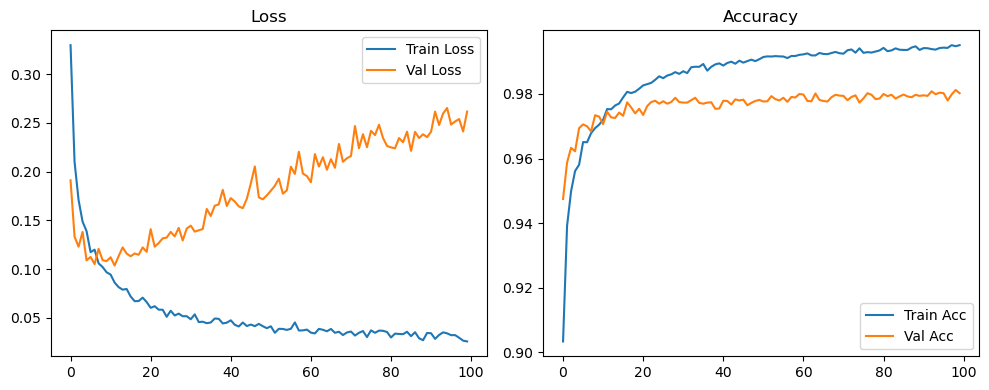

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2477, Acc: 0.9262 | Val Loss: 0.1771, Acc: 0.9489


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1278, Acc: 0.9617 | Val Loss: 0.1293, Acc: 0.9615


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0951, Acc: 0.9710 | Val Loss: 0.1202, Acc: 0.9652


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0723, Acc: 0.9775 | Val Loss: 0.1240, Acc: 0.9648


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9813 | Val Loss: 0.1286, Acc: 0.9659


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9851 | Val Loss: 0.1139, Acc: 0.9719


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9859 | Val Loss: 0.1406, Acc: 0.9692


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9883 | Val Loss: 0.1303, Acc: 0.9699


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9899 | Val Loss: 0.1321, Acc: 0.9728


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9908 | Val Loss: 0.1321, Acc: 0.9722


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9903 | Val Loss: 0.1343, Acc: 0.9709


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9911 | Val Loss: 0.1231, Acc: 0.9742


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.1405, Acc: 0.9716


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9931 | Val Loss: 0.1216, Acc: 0.9748


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9939 | Val Loss: 0.1231, Acc: 0.9744


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9944 | Val Loss: 0.1334, Acc: 0.9750


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9945 | Val Loss: 0.1271, Acc: 0.9742


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.1526, Acc: 0.9722


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9946 | Val Loss: 0.1354, Acc: 0.9742


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.1376, Acc: 0.9732


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1433, Acc: 0.9746


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9952 | Val Loss: 0.1476, Acc: 0.9724


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9966 | Val Loss: 0.1389, Acc: 0.9755


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.1383, Acc: 0.9756


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.1494, Acc: 0.9728


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.1506, Acc: 0.9746


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.1459, Acc: 0.9749


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1465, Acc: 0.9733


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9961 | Val Loss: 0.1586, Acc: 0.9734


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1592, Acc: 0.9765


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9969 | Val Loss: 0.1611, Acc: 0.9748


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1645, Acc: 0.9744


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1450, Acc: 0.9760


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1499, Acc: 0.9762


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9975 | Val Loss: 0.1427, Acc: 0.9775


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9971 | Val Loss: 0.1326, Acc: 0.9782


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1423, Acc: 0.9782


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9978 | Val Loss: 0.1462, Acc: 0.9768


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1590, Acc: 0.9765


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1433, Acc: 0.9758


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.1560, Acc: 0.9759


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1564, Acc: 0.9762


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9985 | Val Loss: 0.1464, Acc: 0.9768


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.1772, Acc: 0.9758


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9972 | Val Loss: 0.1615, Acc: 0.9745


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.1569, Acc: 0.9763


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1858, Acc: 0.9748


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1704, Acc: 0.9749


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1620, Acc: 0.9773


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1812, Acc: 0.9746


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1503, Acc: 0.9788


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1478, Acc: 0.9790


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1463, Acc: 0.9814


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1582, Acc: 0.9791


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1566, Acc: 0.9798


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1467, Acc: 0.9820


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1636, Acc: 0.9796


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1541, Acc: 0.9805


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1661, Acc: 0.9789


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1789, Acc: 0.9782


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1759, Acc: 0.9793


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1732, Acc: 0.9802


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1886, Acc: 0.9767


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.1669, Acc: 0.9802


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1653, Acc: 0.9805


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1715, Acc: 0.9800


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1748, Acc: 0.9789


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1720, Acc: 0.9809


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9996 | Val Loss: 0.1707, Acc: 0.9784


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1762, Acc: 0.9793


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1828, Acc: 0.9787


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1847, Acc: 0.9788


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1948, Acc: 0.9790


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1799, Acc: 0.9803


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1868, Acc: 0.9789


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1859, Acc: 0.9802


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1925, Acc: 0.9788


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9998 | Val Loss: 0.1979, Acc: 0.9791


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2135, Acc: 0.9781


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2152, Acc: 0.9767


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.1992, Acc: 0.9787


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2000, Acc: 0.9787


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1908, Acc: 0.9806


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1955, Acc: 0.9796


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1911, Acc: 0.9800


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1908, Acc: 0.9808


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1953, Acc: 0.9804


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1890, Acc: 0.9808


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1845, Acc: 0.9802


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1895, Acc: 0.9801


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1932, Acc: 0.9799


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2012, Acc: 0.9788


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1908, Acc: 0.9793


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1923, Acc: 0.9804


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1943, Acc: 0.9802


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1949, Acc: 0.9796


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2016, Acc: 0.9801


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2181, Acc: 0.9795


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2021, Acc: 0.9797


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.1949, Acc: 0.9789


Final Test Loss: 0.1902 Accuracy: 0.9797


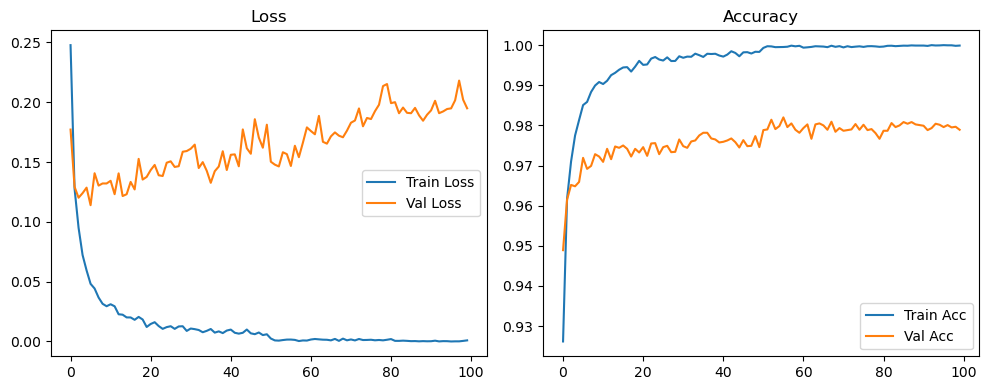

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2627, Acc: 0.9221 | Val Loss: 0.1884, Acc: 0.9469


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1447, Acc: 0.9566 | Val Loss: 0.1238, Acc: 0.9643


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1145, Acc: 0.9656 | Val Loss: 0.1337, Acc: 0.9605


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0930, Acc: 0.9715 | Val Loss: 0.1199, Acc: 0.9661


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0775, Acc: 0.9765 | Val Loss: 0.1189, Acc: 0.9667


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9793 | Val Loss: 0.1211, Acc: 0.9696


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0636, Acc: 0.9802 | Val Loss: 0.1187, Acc: 0.9707


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9839 | Val Loss: 0.1525, Acc: 0.9641


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9838 | Val Loss: 0.1100, Acc: 0.9735


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9864 | Val Loss: 0.1135, Acc: 0.9719


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9861 | Val Loss: 0.1304, Acc: 0.9726


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9882 | Val Loss: 0.1200, Acc: 0.9728


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9886 | Val Loss: 0.1352, Acc: 0.9718


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9895 | Val Loss: 0.1422, Acc: 0.9723


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9903 | Val Loss: 0.1283, Acc: 0.9732


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9899 | Val Loss: 0.1226, Acc: 0.9730


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9908 | Val Loss: 0.1291, Acc: 0.9746


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9913 | Val Loss: 0.1636, Acc: 0.9706


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9914 | Val Loss: 0.1512, Acc: 0.9735


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9915 | Val Loss: 0.1431, Acc: 0.9758


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9921 | Val Loss: 0.1555, Acc: 0.9760


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9941 | Val Loss: 0.1411, Acc: 0.9763


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9936 | Val Loss: 0.1440, Acc: 0.9751


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9939 | Val Loss: 0.1363, Acc: 0.9747


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9941 | Val Loss: 0.1468, Acc: 0.9752


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9926 | Val Loss: 0.1436, Acc: 0.9762


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9942 | Val Loss: 0.1462, Acc: 0.9764


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9938 | Val Loss: 0.1375, Acc: 0.9767


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9947 | Val Loss: 0.1377, Acc: 0.9781


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.1513, Acc: 0.9767


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9955 | Val Loss: 0.1614, Acc: 0.9757


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9947 | Val Loss: 0.1703, Acc: 0.9751


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9952 | Val Loss: 0.1633, Acc: 0.9756


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9951 | Val Loss: 0.1460, Acc: 0.9770


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9962 | Val Loss: 0.1669, Acc: 0.9744


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9951 | Val Loss: 0.1617, Acc: 0.9759


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9954 | Val Loss: 0.1667, Acc: 0.9772


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9956 | Val Loss: 0.1672, Acc: 0.9748


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9961 | Val Loss: 0.1897, Acc: 0.9771


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9952 | Val Loss: 0.1869, Acc: 0.9757


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9958 | Val Loss: 0.1814, Acc: 0.9772


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9960 | Val Loss: 0.1907, Acc: 0.9766


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9959 | Val Loss: 0.1860, Acc: 0.9774


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9962 | Val Loss: 0.1895, Acc: 0.9756


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9951 | Val Loss: 0.1744, Acc: 0.9768


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9957 | Val Loss: 0.1730, Acc: 0.9780


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9968 | Val Loss: 0.1993, Acc: 0.9772


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9967 | Val Loss: 0.1840, Acc: 0.9781


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9966 | Val Loss: 0.2172, Acc: 0.9757


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9969 | Val Loss: 0.2156, Acc: 0.9776


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9982 | Val Loss: 0.2017, Acc: 0.9792


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9988 | Val Loss: 0.2057, Acc: 0.9786


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.2006, Acc: 0.9797


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9986 | Val Loss: 0.1897, Acc: 0.9799


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1967, Acc: 0.9802


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.2023, Acc: 0.9792


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.2018, Acc: 0.9792


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9987 | Val Loss: 0.2001, Acc: 0.9798


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.2099, Acc: 0.9792


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9990 | Val Loss: 0.2090, Acc: 0.9805


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.2115, Acc: 0.9791


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.2187, Acc: 0.9792


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.2099, Acc: 0.9792


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.2061, Acc: 0.9803


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9992 | Val Loss: 0.2175, Acc: 0.9788


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.2303, Acc: 0.9795


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.2088, Acc: 0.9811


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.2235, Acc: 0.9801


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.2215, Acc: 0.9795


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.2235, Acc: 0.9794


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.2226, Acc: 0.9799


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.2383, Acc: 0.9784


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9989 | Val Loss: 0.2188, Acc: 0.9788


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.2147, Acc: 0.9792


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.2520, Acc: 0.9784


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.2301, Acc: 0.9794


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.2394, Acc: 0.9801


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.2402, Acc: 0.9795


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.2368, Acc: 0.9788


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.2231, Acc: 0.9798


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.2158, Acc: 0.9808


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2218, Acc: 0.9802


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2164, Acc: 0.9812


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2283, Acc: 0.9812


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.2311, Acc: 0.9804


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2265, Acc: 0.9807


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2156, Acc: 0.9815


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.2240, Acc: 0.9813


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9996 | Val Loss: 0.2227, Acc: 0.9809


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2177, Acc: 0.9813


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.2204, Acc: 0.9816


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2330, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2185, Acc: 0.9817


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.2108, Acc: 0.9820


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2193, Acc: 0.9818


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.2230, Acc: 0.9817


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.2145, Acc: 0.9808


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.2244, Acc: 0.9809


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2220, Acc: 0.9809


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2397, Acc: 0.9805


Final Test Loss: 0.2016 Accuracy: 0.9822


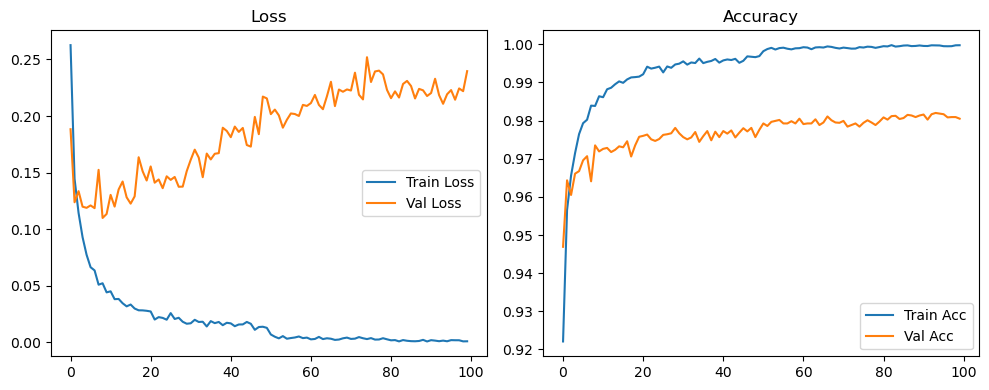

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3297, Acc: 0.9034 | Val Loss: 0.1911, Acc: 0.9475


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2100, Acc: 0.9391 | Val Loss: 0.1333, Acc: 0.9587


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1710, Acc: 0.9499 | Val Loss: 0.1231, Acc: 0.9633


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1488, Acc: 0.9561 | Val Loss: 0.1382, Acc: 0.9623


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1389, Acc: 0.9581 | Val Loss: 0.1090, Acc: 0.9694


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1175, Acc: 0.9651 | Val Loss: 0.1126, Acc: 0.9706


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1200, Acc: 0.9651 | Val Loss: 0.1052, Acc: 0.9700


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1060, Acc: 0.9679 | Val Loss: 0.1208, Acc: 0.9684


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1022, Acc: 0.9694 | Val Loss: 0.1093, Acc: 0.9734


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0969, Acc: 0.9705 | Val Loss: 0.1083, Acc: 0.9730


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0945, Acc: 0.9720 | Val Loss: 0.1122, Acc: 0.9707


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0863, Acc: 0.9753 | Val Loss: 0.1038, Acc: 0.9745


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0816, Acc: 0.9753 | Val Loss: 0.1134, Acc: 0.9728


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0790, Acc: 0.9764 | Val Loss: 0.1223, Acc: 0.9726


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0797, Acc: 0.9771 | Val Loss: 0.1160, Acc: 0.9742


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0720, Acc: 0.9790 | Val Loss: 0.1133, Acc: 0.9732


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0672, Acc: 0.9807 | Val Loss: 0.1161, Acc: 0.9774


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0674, Acc: 0.9803 | Val Loss: 0.1148, Acc: 0.9758


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0708, Acc: 0.9807 | Val Loss: 0.1223, Acc: 0.9740


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0663, Acc: 0.9816 | Val Loss: 0.1178, Acc: 0.9754


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9827 | Val Loss: 0.1410, Acc: 0.9735


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0621, Acc: 0.9830 | Val Loss: 0.1231, Acc: 0.9762


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0585, Acc: 0.9834 | Val Loss: 0.1268, Acc: 0.9775


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0584, Acc: 0.9844 | Val Loss: 0.1316, Acc: 0.9779


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9855 | Val Loss: 0.1324, Acc: 0.9770


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0574, Acc: 0.9849 | Val Loss: 0.1382, Acc: 0.9778


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9857 | Val Loss: 0.1337, Acc: 0.9770


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9861 | Val Loss: 0.1423, Acc: 0.9775


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9868 | Val Loss: 0.1294, Acc: 0.9788


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9862 | Val Loss: 0.1417, Acc: 0.9775


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9870 | Val Loss: 0.1446, Acc: 0.9773


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9865 | Val Loss: 0.1385, Acc: 0.9773


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9883 | Val Loss: 0.1398, Acc: 0.9781


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9884 | Val Loss: 0.1412, Acc: 0.9788


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9884 | Val Loss: 0.1618, Acc: 0.9772


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9893 | Val Loss: 0.1545, Acc: 0.9770


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9872 | Val Loss: 0.1651, Acc: 0.9773


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9884 | Val Loss: 0.1665, Acc: 0.9774


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9892 | Val Loss: 0.1813, Acc: 0.9754


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9895 | Val Loss: 0.1648, Acc: 0.9755


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9888 | Val Loss: 0.1729, Acc: 0.9779


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0430, Acc: 0.9896 | Val Loss: 0.1694, Acc: 0.9778


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9900 | Val Loss: 0.1644, Acc: 0.9768


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9894 | Val Loss: 0.1625, Acc: 0.9783


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9903 | Val Loss: 0.1721, Acc: 0.9780


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9897 | Val Loss: 0.1879, Acc: 0.9782


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9902 | Val Loss: 0.2053, Acc: 0.9765


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9906 | Val Loss: 0.1737, Acc: 0.9772


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9902 | Val Loss: 0.1716, Acc: 0.9778


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9908 | Val Loss: 0.1757, Acc: 0.9782


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9935 | Val Loss: 0.1553, Acc: 0.9807


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9946 | Val Loss: 0.1601, Acc: 0.9805


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9951 | Val Loss: 0.1650, Acc: 0.9802


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9952 | Val Loss: 0.1586, Acc: 0.9808


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9949 | Val Loss: 0.1667, Acc: 0.9806


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9956 | Val Loss: 0.1677, Acc: 0.9802


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9957 | Val Loss: 0.1666, Acc: 0.9806


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9960 | Val Loss: 0.1665, Acc: 0.9811


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9969 | Val Loss: 0.1642, Acc: 0.9802


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9968 | Val Loss: 0.1630, Acc: 0.9814


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9964 | Val Loss: 0.1779, Acc: 0.9812


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9962 | Val Loss: 0.1848, Acc: 0.9809


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9964 | Val Loss: 0.1748, Acc: 0.9808


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9961 | Val Loss: 0.1711, Acc: 0.9804


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9966 | Val Loss: 0.1769, Acc: 0.9810


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9966 | Val Loss: 0.2004, Acc: 0.9791


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9961 | Val Loss: 0.1944, Acc: 0.9798


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9968 | Val Loss: 0.1822, Acc: 0.9814


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9967 | Val Loss: 0.1815, Acc: 0.9807


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9970 | Val Loss: 0.1817, Acc: 0.9809


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9970 | Val Loss: 0.1834, Acc: 0.9821


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9972 | Val Loss: 0.1928, Acc: 0.9802


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9973 | Val Loss: 0.1930, Acc: 0.9804


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9964 | Val Loss: 0.1734, Acc: 0.9821


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9968 | Val Loss: 0.1949, Acc: 0.9797


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9971 | Val Loss: 0.1971, Acc: 0.9807


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9970 | Val Loss: 0.1898, Acc: 0.9809


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9968 | Val Loss: 0.2053, Acc: 0.9804


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9964 | Val Loss: 0.2149, Acc: 0.9794


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9967 | Val Loss: 0.2011, Acc: 0.9816


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9974 | Val Loss: 0.2010, Acc: 0.9813


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9976 | Val Loss: 0.1943, Acc: 0.9822


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9976 | Val Loss: 0.1951, Acc: 0.9816


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9975 | Val Loss: 0.1900, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1907, Acc: 0.9819


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9983 | Val Loss: 0.1972, Acc: 0.9814


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9976 | Val Loss: 0.1976, Acc: 0.9818


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.1965, Acc: 0.9808


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1978, Acc: 0.9821


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9980 | Val Loss: 0.2027, Acc: 0.9812


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9982 | Val Loss: 0.1933, Acc: 0.9820


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9982 | Val Loss: 0.1934, Acc: 0.9818


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9980 | Val Loss: 0.1941, Acc: 0.9822


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9981 | Val Loss: 0.1959, Acc: 0.9822


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9981 | Val Loss: 0.2014, Acc: 0.9821


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9979 | Val Loss: 0.2100, Acc: 0.9817


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9981 | Val Loss: 0.1992, Acc: 0.9822


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9984 | Val Loss: 0.2228, Acc: 0.9808


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.2178, Acc: 0.9809


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9983 | Val Loss: 0.2175, Acc: 0.9817


Final Test Loss: 0.1930 Accuracy: 0.9827


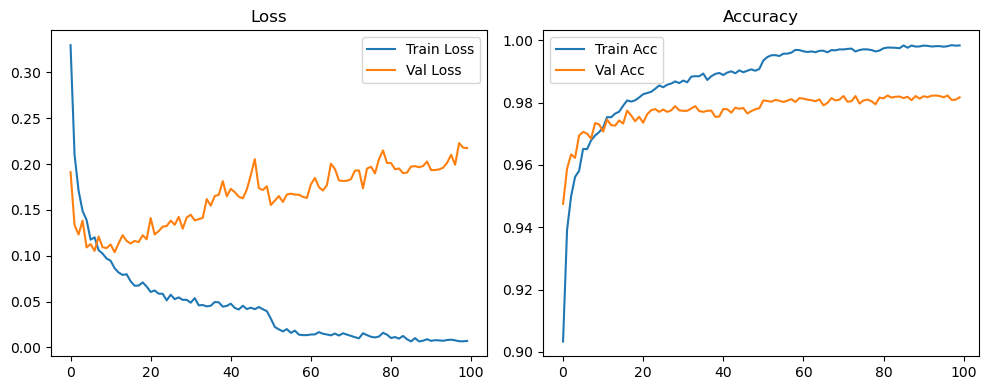

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2213, Acc: 0.9337 | Val Loss: 0.1548, Acc: 0.9551


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1094, Acc: 0.9653 | Val Loss: 0.1080, Acc: 0.9666


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0810, Acc: 0.9748 | Val Loss: 0.1100, Acc: 0.9675


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0593, Acc: 0.9814 | Val Loss: 0.1186, Acc: 0.9672


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0509, Acc: 0.9836 | Val Loss: 0.1208, Acc: 0.9679


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0459, Acc: 0.9851 | Val Loss: 0.1241, Acc: 0.9692


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9875 | Val Loss: 0.1153, Acc: 0.9711


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9898 | Val Loss: 0.1300, Acc: 0.9688


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9891 | Val Loss: 0.1223, Acc: 0.9717


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.1216, Acc: 0.9708


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9910 | Val Loss: 0.1349, Acc: 0.9702


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9915 | Val Loss: 0.1105, Acc: 0.9735


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9935 | Val Loss: 0.1381, Acc: 0.9706


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.1250, Acc: 0.9719


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9932 | Val Loss: 0.1179, Acc: 0.9731


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.1386, Acc: 0.9722


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.1240, Acc: 0.9746


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.1192, Acc: 0.9744


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9957 | Val Loss: 0.1516, Acc: 0.9727


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.1387, Acc: 0.9741


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.1212, Acc: 0.9763


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9962 | Val Loss: 0.1176, Acc: 0.9753


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1289, Acc: 0.9732


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.1411, Acc: 0.9743


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1449, Acc: 0.9748


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.1516, Acc: 0.9745


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.1412, Acc: 0.9735


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1352, Acc: 0.9747


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.1529, Acc: 0.9732


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9964 | Val Loss: 0.1399, Acc: 0.9732


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1317, Acc: 0.9760


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1327, Acc: 0.9768


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1444, Acc: 0.9766


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1586, Acc: 0.9748


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1497, Acc: 0.9771


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.1553, Acc: 0.9731


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1549, Acc: 0.9744


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1481, Acc: 0.9745


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.1482, Acc: 0.9754


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1463, Acc: 0.9763


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.1618, Acc: 0.9750


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1573, Acc: 0.9749


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9970 | Val Loss: 0.1629, Acc: 0.9753


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1584, Acc: 0.9764


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1622, Acc: 0.9763


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.1729, Acc: 0.9750


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1766, Acc: 0.9748


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1661, Acc: 0.9762


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1489, Acc: 0.9772


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1641, Acc: 0.9764


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1653, Acc: 0.9749


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1790, Acc: 0.9751


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1589, Acc: 0.9775


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.1749, Acc: 0.9762


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1566, Acc: 0.9783


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1675, Acc: 0.9755


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1834, Acc: 0.9769


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1813, Acc: 0.9774


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1802, Acc: 0.9754


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1834, Acc: 0.9758


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1586, Acc: 0.9776


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1675, Acc: 0.9768


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1700, Acc: 0.9756


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1635, Acc: 0.9772


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1762, Acc: 0.9762


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.1769, Acc: 0.9762


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1631, Acc: 0.9775


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.1728, Acc: 0.9749


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1576, Acc: 0.9773


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.1649, Acc: 0.9768


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.1651, Acc: 0.9762


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1858, Acc: 0.9762


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.2008, Acc: 0.9762


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1861, Acc: 0.9764


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1806, Acc: 0.9765


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1755, Acc: 0.9770


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1806, Acc: 0.9772


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1779, Acc: 0.9767


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1811, Acc: 0.9772


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1855, Acc: 0.9773


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1701, Acc: 0.9783


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9988 | Val Loss: 0.1614, Acc: 0.9778


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1558, Acc: 0.9788


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1671, Acc: 0.9781


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1855, Acc: 0.9778


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.2030, Acc: 0.9778


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.1829, Acc: 0.9789


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1711, Acc: 0.9778


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1812, Acc: 0.9780


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1744, Acc: 0.9792


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1917, Acc: 0.9761


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1980, Acc: 0.9777


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1950, Acc: 0.9762


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1796, Acc: 0.9767


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9993 | Val Loss: 0.1966, Acc: 0.9773


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1798, Acc: 0.9775


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1842, Acc: 0.9768


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.1903, Acc: 0.9778


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1946, Acc: 0.9768


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.2057, Acc: 0.9777


Final Test Loss: 0.1726 Accuracy: 0.9786


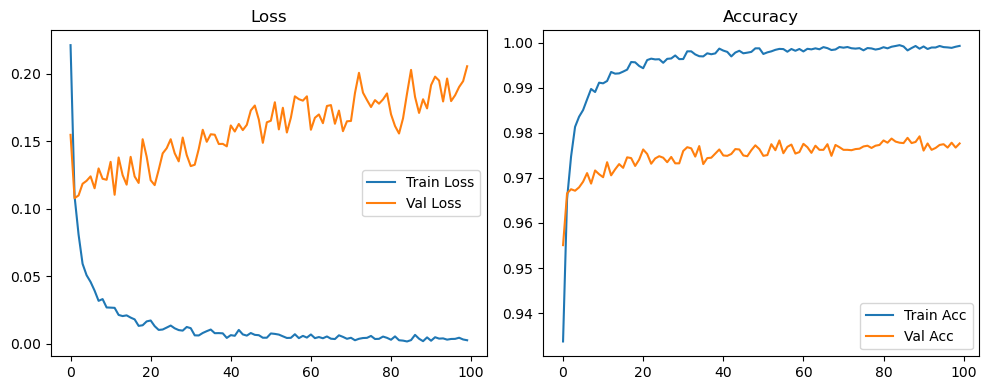

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2380, Acc: 0.9279 | Val Loss: 0.1562, Acc: 0.9539


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1259, Acc: 0.9610 | Val Loss: 0.1231, Acc: 0.9628


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0966, Acc: 0.9696 | Val Loss: 0.1177, Acc: 0.9648


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0762, Acc: 0.9757 | Val Loss: 0.1079, Acc: 0.9683


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0654, Acc: 0.9787 | Val Loss: 0.1000, Acc: 0.9702


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0570, Acc: 0.9815 | Val Loss: 0.1090, Acc: 0.9725


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0528, Acc: 0.9830 | Val Loss: 0.1028, Acc: 0.9738


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9852 | Val Loss: 0.1195, Acc: 0.9705


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0439, Acc: 0.9856 | Val Loss: 0.0991, Acc: 0.9758


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0393, Acc: 0.9869 | Val Loss: 0.1184, Acc: 0.9715


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9881 | Val Loss: 0.1307, Acc: 0.9692


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9883 | Val Loss: 0.1223, Acc: 0.9721


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9887 | Val Loss: 0.1152, Acc: 0.9713


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9894 | Val Loss: 0.1196, Acc: 0.9728


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 0.1145, Acc: 0.9748


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9915 | Val Loss: 0.1169, Acc: 0.9726


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.1337, Acc: 0.9734


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9926 | Val Loss: 0.1345, Acc: 0.9723


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.1454, Acc: 0.9729


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9919 | Val Loss: 0.1186, Acc: 0.9768


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9927 | Val Loss: 0.1236, Acc: 0.9748


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9932 | Val Loss: 0.1236, Acc: 0.9751


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.1281, Acc: 0.9752


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.1312, Acc: 0.9744


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1306, Acc: 0.9759


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.1376, Acc: 0.9762


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.1320, Acc: 0.9763


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9946 | Val Loss: 0.1288, Acc: 0.9745


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1448, Acc: 0.9754


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9949 | Val Loss: 0.1296, Acc: 0.9770


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1471, Acc: 0.9753


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.1370, Acc: 0.9759


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9946 | Val Loss: 0.1438, Acc: 0.9737


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9951 | Val Loss: 0.1270, Acc: 0.9772


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1443, Acc: 0.9757


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.1345, Acc: 0.9766


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1562, Acc: 0.9767


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.1391, Acc: 0.9749


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1509, Acc: 0.9778


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9957 | Val Loss: 0.1468, Acc: 0.9763


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1343, Acc: 0.9776


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9957 | Val Loss: 0.1522, Acc: 0.9768


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1608, Acc: 0.9765


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9970 | Val Loss: 0.1463, Acc: 0.9767


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9966 | Val Loss: 0.1430, Acc: 0.9766


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9974 | Val Loss: 0.1660, Acc: 0.9757


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9967 | Val Loss: 0.1495, Acc: 0.9767


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.1593, Acc: 0.9764


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1479, Acc: 0.9785


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1561, Acc: 0.9778


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1599, Acc: 0.9770


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.1599, Acc: 0.9769


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9969 | Val Loss: 0.1658, Acc: 0.9758


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.1697, Acc: 0.9766


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9973 | Val Loss: 0.1519, Acc: 0.9794


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.1476, Acc: 0.9782


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1667, Acc: 0.9775


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9972 | Val Loss: 0.1720, Acc: 0.9771


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.1675, Acc: 0.9776


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1662, Acc: 0.9773


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9974 | Val Loss: 0.1655, Acc: 0.9780


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.1761, Acc: 0.9774


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9977 | Val Loss: 0.1708, Acc: 0.9775


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.1847, Acc: 0.9758


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1951, Acc: 0.9759


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9970 | Val Loss: 0.1724, Acc: 0.9772


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1680, Acc: 0.9780


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1693, Acc: 0.9779


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9972 | Val Loss: 0.1621, Acc: 0.9783


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1769, Acc: 0.9784


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9984 | Val Loss: 0.1679, Acc: 0.9788


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1545, Acc: 0.9793


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.1726, Acc: 0.9776


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.1594, Acc: 0.9786


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1769, Acc: 0.9791


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1791, Acc: 0.9784


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9979 | Val Loss: 0.1861, Acc: 0.9758


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9976 | Val Loss: 0.1780, Acc: 0.9767


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1618, Acc: 0.9793


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1777, Acc: 0.9784


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.1785, Acc: 0.9786


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1770, Acc: 0.9787


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9979 | Val Loss: 0.1766, Acc: 0.9782


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9978 | Val Loss: 0.1841, Acc: 0.9780


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.1877, Acc: 0.9762


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9981 | Val Loss: 0.1885, Acc: 0.9773


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1943, Acc: 0.9777


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1889, Acc: 0.9792


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.1988, Acc: 0.9781


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9978 | Val Loss: 0.1916, Acc: 0.9774


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9977 | Val Loss: 0.1799, Acc: 0.9787


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1841, Acc: 0.9791


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1998, Acc: 0.9783


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9977 | Val Loss: 0.1934, Acc: 0.9788


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.2012, Acc: 0.9791


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9982 | Val Loss: 0.1820, Acc: 0.9801


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.1858, Acc: 0.9785


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9987 | Val Loss: 0.1811, Acc: 0.9793


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1932, Acc: 0.9781


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1949, Acc: 0.9790


Final Test Loss: 0.1927 Accuracy: 0.9780


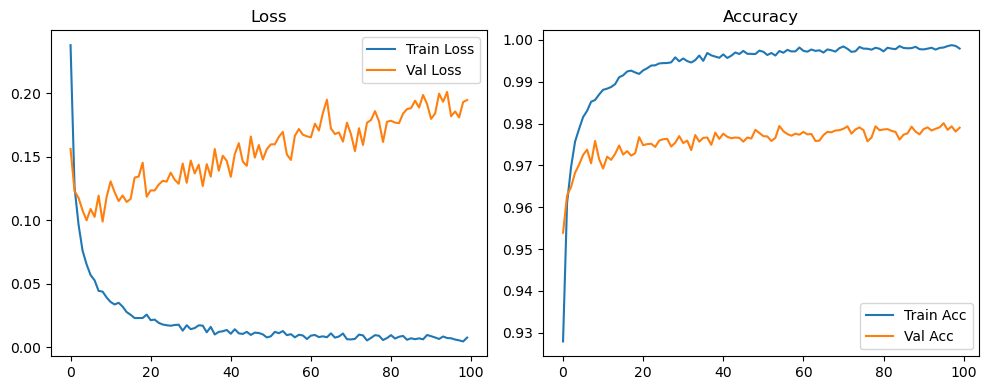

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3022, Acc: 0.9080 | Val Loss: 0.1541, Acc: 0.9534


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1811, Acc: 0.9442 | Val Loss: 0.1258, Acc: 0.9625


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1459, Acc: 0.9559 | Val Loss: 0.1146, Acc: 0.9653


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1276, Acc: 0.9610 | Val Loss: 0.1140, Acc: 0.9665


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1111, Acc: 0.9653 | Val Loss: 0.1025, Acc: 0.9699


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1061, Acc: 0.9671 | Val Loss: 0.1074, Acc: 0.9690


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0997, Acc: 0.9689 | Val Loss: 0.1011, Acc: 0.9708


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0917, Acc: 0.9713 | Val Loss: 0.1064, Acc: 0.9688


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0849, Acc: 0.9727 | Val Loss: 0.0938, Acc: 0.9721


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0769, Acc: 0.9753 | Val Loss: 0.1004, Acc: 0.9744


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0793, Acc: 0.9744 | Val Loss: 0.1035, Acc: 0.9735


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0734, Acc: 0.9773 | Val Loss: 0.0923, Acc: 0.9754


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0713, Acc: 0.9771 | Val Loss: 0.0963, Acc: 0.9742


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0674, Acc: 0.9787 | Val Loss: 0.0945, Acc: 0.9749


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0590, Acc: 0.9806 | Val Loss: 0.1029, Acc: 0.9756


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0623, Acc: 0.9801 | Val Loss: 0.0937, Acc: 0.9754


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0560, Acc: 0.9826 | Val Loss: 0.1057, Acc: 0.9738


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0540, Acc: 0.9821 | Val Loss: 0.1002, Acc: 0.9748


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0567, Acc: 0.9823 | Val Loss: 0.0968, Acc: 0.9750


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0525, Acc: 0.9825 | Val Loss: 0.0968, Acc: 0.9762


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0478, Acc: 0.9854 | Val Loss: 0.1075, Acc: 0.9741


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9850 | Val Loss: 0.0990, Acc: 0.9768


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9849 | Val Loss: 0.1042, Acc: 0.9761


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0466, Acc: 0.9849 | Val Loss: 0.0904, Acc: 0.9779


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0441, Acc: 0.9861 | Val Loss: 0.1051, Acc: 0.9768


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9862 | Val Loss: 0.1132, Acc: 0.9762


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9868 | Val Loss: 0.1035, Acc: 0.9767


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9874 | Val Loss: 0.1129, Acc: 0.9763


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9877 | Val Loss: 0.1106, Acc: 0.9772


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0393, Acc: 0.9878 | Val Loss: 0.1111, Acc: 0.9767


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9881 | Val Loss: 0.1084, Acc: 0.9776


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9889 | Val Loss: 0.1090, Acc: 0.9791


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9894 | Val Loss: 0.1141, Acc: 0.9778


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9894 | Val Loss: 0.1108, Acc: 0.9781


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9891 | Val Loss: 0.1202, Acc: 0.9780


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9890 | Val Loss: 0.1169, Acc: 0.9762


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9899 | Val Loss: 0.1222, Acc: 0.9776


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9894 | Val Loss: 0.1221, Acc: 0.9761


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9893 | Val Loss: 0.1270, Acc: 0.9781


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9902 | Val Loss: 0.1303, Acc: 0.9758


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9901 | Val Loss: 0.1341, Acc: 0.9753


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9910 | Val Loss: 0.1311, Acc: 0.9769


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9907 | Val Loss: 0.1204, Acc: 0.9778


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9905 | Val Loss: 0.1233, Acc: 0.9776


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9912 | Val Loss: 0.1198, Acc: 0.9775


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9910 | Val Loss: 0.1252, Acc: 0.9763


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9904 | Val Loss: 0.1362, Acc: 0.9768


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9913 | Val Loss: 0.1348, Acc: 0.9770


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9922 | Val Loss: 0.1307, Acc: 0.9770


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9919 | Val Loss: 0.1382, Acc: 0.9784


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9922 | Val Loss: 0.1378, Acc: 0.9781


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9917 | Val Loss: 0.1497, Acc: 0.9778


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9932 | Val Loss: 0.1374, Acc: 0.9779


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9926 | Val Loss: 0.1349, Acc: 0.9789


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9917 | Val Loss: 0.1394, Acc: 0.9762


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9915 | Val Loss: 0.1264, Acc: 0.9784


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9929 | Val Loss: 0.1324, Acc: 0.9785


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9936 | Val Loss: 0.1401, Acc: 0.9776


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9935 | Val Loss: 0.1476, Acc: 0.9778


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9920 | Val Loss: 0.1414, Acc: 0.9782


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9926 | Val Loss: 0.1385, Acc: 0.9786


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9929 | Val Loss: 0.1377, Acc: 0.9762


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9934 | Val Loss: 0.1298, Acc: 0.9796


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9938 | Val Loss: 0.1476, Acc: 0.9768


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9934 | Val Loss: 0.1543, Acc: 0.9779


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9930 | Val Loss: 0.1539, Acc: 0.9792


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9935 | Val Loss: 0.1560, Acc: 0.9772


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9938 | Val Loss: 0.1660, Acc: 0.9770


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9931 | Val Loss: 0.1398, Acc: 0.9799


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9938 | Val Loss: 0.1586, Acc: 0.9782


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9930 | Val Loss: 0.1403, Acc: 0.9791


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9936 | Val Loss: 0.1540, Acc: 0.9782


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9938 | Val Loss: 0.1478, Acc: 0.9788


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9941 | Val Loss: 0.1624, Acc: 0.9789


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9942 | Val Loss: 0.1605, Acc: 0.9782


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9932 | Val Loss: 0.1682, Acc: 0.9785


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9947 | Val Loss: 0.1704, Acc: 0.9793


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9949 | Val Loss: 0.1620, Acc: 0.9807


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9950 | Val Loss: 0.1674, Acc: 0.9786


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9941 | Val Loss: 0.1604, Acc: 0.9786


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9940 | Val Loss: 0.1703, Acc: 0.9792


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9939 | Val Loss: 0.1572, Acc: 0.9772


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9946 | Val Loss: 0.1657, Acc: 0.9767


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9944 | Val Loss: 0.1713, Acc: 0.9775


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9947 | Val Loss: 0.1592, Acc: 0.9784


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9950 | Val Loss: 0.1680, Acc: 0.9783


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9948 | Val Loss: 0.1688, Acc: 0.9783


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9946 | Val Loss: 0.1765, Acc: 0.9786


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9946 | Val Loss: 0.1710, Acc: 0.9771


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9951 | Val Loss: 0.1778, Acc: 0.9781


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9946 | Val Loss: 0.1662, Acc: 0.9783


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9941 | Val Loss: 0.1652, Acc: 0.9785


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9949 | Val Loss: 0.1686, Acc: 0.9776


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9950 | Val Loss: 0.1707, Acc: 0.9769


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9950 | Val Loss: 0.1877, Acc: 0.9766


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9948 | Val Loss: 0.1760, Acc: 0.9776


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9961 | Val Loss: 0.1791, Acc: 0.9781


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9952 | Val Loss: 0.2014, Acc: 0.9771


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9947 | Val Loss: 0.1889, Acc: 0.9783


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9958 | Val Loss: 0.1816, Acc: 0.9781


Final Test Loss: 0.1596 Accuracy: 0.9799


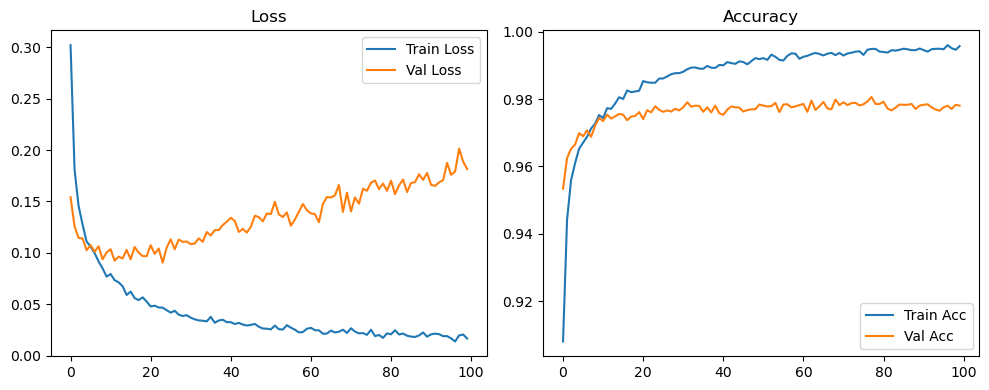

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2097, Acc: 0.9358 | Val Loss: 0.1327, Acc: 0.9617


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0978, Acc: 0.9694 | Val Loss: 0.1087, Acc: 0.9667


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0692, Acc: 0.9781 | Val Loss: 0.1016, Acc: 0.9701


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0509, Acc: 0.9835 | Val Loss: 0.1114, Acc: 0.9667


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0460, Acc: 0.9849 | Val Loss: 0.1179, Acc: 0.9675


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 0.1173, Acc: 0.9706


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.1087, Acc: 0.9702


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9901 | Val Loss: 0.1110, Acc: 0.9714


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.1111, Acc: 0.9737


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.1082, Acc: 0.9742


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.1055, Acc: 0.9739


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.1291, Acc: 0.9712


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9937 | Val Loss: 0.1239, Acc: 0.9738


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.1285, Acc: 0.9726


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.1100, Acc: 0.9772


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.1174, Acc: 0.9748


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.1177, Acc: 0.9742


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.1183, Acc: 0.9732


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.1105, Acc: 0.9768


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.1227, Acc: 0.9739


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1412, Acc: 0.9725


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.1182, Acc: 0.9755


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1253, Acc: 0.9754


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.1243, Acc: 0.9756


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1306, Acc: 0.9747


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1314, Acc: 0.9764


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9968 | Val Loss: 0.1222, Acc: 0.9773


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1266, Acc: 0.9744


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1470, Acc: 0.9722


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1365, Acc: 0.9735


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1307, Acc: 0.9753


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1290, Acc: 0.9772


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1310, Acc: 0.9763


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1420, Acc: 0.9742


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1303, Acc: 0.9771


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1309, Acc: 0.9758


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1312, Acc: 0.9751


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1488, Acc: 0.9738


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1389, Acc: 0.9772


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1320, Acc: 0.9777


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1495, Acc: 0.9761


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1555, Acc: 0.9754


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1463, Acc: 0.9762


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9987 | Val Loss: 0.1586, Acc: 0.9752


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1543, Acc: 0.9762


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9979 | Val Loss: 0.1425, Acc: 0.9775


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1444, Acc: 0.9767


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1394, Acc: 0.9786


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1615, Acc: 0.9748


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.1559, Acc: 0.9738


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1421, Acc: 0.9767


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1457, Acc: 0.9783


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1589, Acc: 0.9747


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1543, Acc: 0.9743


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1606, Acc: 0.9755


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1437, Acc: 0.9782


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1591, Acc: 0.9764


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1413, Acc: 0.9775


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1521, Acc: 0.9763


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1434, Acc: 0.9762


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1510, Acc: 0.9764


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1634, Acc: 0.9778


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1471, Acc: 0.9780


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1791, Acc: 0.9731


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1538, Acc: 0.9774


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1637, Acc: 0.9772


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1695, Acc: 0.9776


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1465, Acc: 0.9776


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1772, Acc: 0.9759


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1432, Acc: 0.9783


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1646, Acc: 0.9764


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1709, Acc: 0.9768


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1489, Acc: 0.9775


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1574, Acc: 0.9778


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1612, Acc: 0.9770


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1746, Acc: 0.9765


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1623, Acc: 0.9779


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1807, Acc: 0.9761


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1615, Acc: 0.9780


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1569, Acc: 0.9768


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1558, Acc: 0.9788


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9990 | Val Loss: 0.1579, Acc: 0.9775


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1528, Acc: 0.9789


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1636, Acc: 0.9778


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1690, Acc: 0.9771


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1660, Acc: 0.9772


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1715, Acc: 0.9779


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1600, Acc: 0.9788


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1615, Acc: 0.9782


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1706, Acc: 0.9776


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1762, Acc: 0.9789


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1668, Acc: 0.9789


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1759, Acc: 0.9788


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.1738, Acc: 0.9767


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1744, Acc: 0.9768


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1696, Acc: 0.9768


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1691, Acc: 0.9761


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1637, Acc: 0.9787


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1778, Acc: 0.9786


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1776, Acc: 0.9765


Final Test Loss: 0.1485 Accuracy: 0.9815


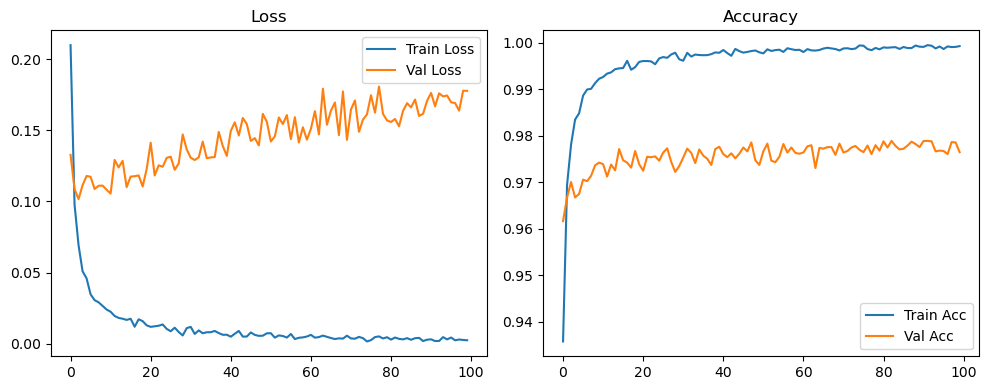

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2320, Acc: 0.9292 | Val Loss: 0.1305, Acc: 0.9600


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1180, Acc: 0.9629 | Val Loss: 0.1118, Acc: 0.9663


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0863, Acc: 0.9729 | Val Loss: 0.1023, Acc: 0.9681


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0702, Acc: 0.9771 | Val Loss: 0.1065, Acc: 0.9693


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0568, Acc: 0.9811 | Val Loss: 0.1050, Acc: 0.9684


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0488, Acc: 0.9833 | Val Loss: 0.1019, Acc: 0.9708


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0478, Acc: 0.9843 | Val Loss: 0.0937, Acc: 0.9729


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9863 | Val Loss: 0.1069, Acc: 0.9710


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0353, Acc: 0.9882 | Val Loss: 0.1017, Acc: 0.9735


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9884 | Val Loss: 0.1119, Acc: 0.9709


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9890 | Val Loss: 0.1133, Acc: 0.9714


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9900 | Val Loss: 0.0978, Acc: 0.9738


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9904 | Val Loss: 0.1114, Acc: 0.9732


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9907 | Val Loss: 0.1098, Acc: 0.9738


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9909 | Val Loss: 0.1074, Acc: 0.9748


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9927 | Val Loss: 0.1006, Acc: 0.9750


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9920 | Val Loss: 0.1249, Acc: 0.9722


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9933 | Val Loss: 0.1277, Acc: 0.9713


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9924 | Val Loss: 0.1046, Acc: 0.9762


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.1237, Acc: 0.9730


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.1163, Acc: 0.9732


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.1148, Acc: 0.9763


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.1269, Acc: 0.9737


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.1113, Acc: 0.9762


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.1320, Acc: 0.9742


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.1291, Acc: 0.9757


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.1321, Acc: 0.9745


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.1210, Acc: 0.9746


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.1219, Acc: 0.9767


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1298, Acc: 0.9758


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.1185, Acc: 0.9760


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.1273, Acc: 0.9762


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1290, Acc: 0.9755


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1233, Acc: 0.9770


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1284, Acc: 0.9757


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.1380, Acc: 0.9736


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.1377, Acc: 0.9751


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.1264, Acc: 0.9769


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1273, Acc: 0.9759


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.1175, Acc: 0.9772


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1423, Acc: 0.9748


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1319, Acc: 0.9752


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1287, Acc: 0.9779


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1414, Acc: 0.9758


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1246, Acc: 0.9776


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1358, Acc: 0.9767


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1256, Acc: 0.9788


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1292, Acc: 0.9776


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1242, Acc: 0.9781


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1368, Acc: 0.9776


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1454, Acc: 0.9768


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1375, Acc: 0.9777


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9975 | Val Loss: 0.1282, Acc: 0.9782


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1438, Acc: 0.9773


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1383, Acc: 0.9765


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.1346, Acc: 0.9772


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1247, Acc: 0.9793


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1450, Acc: 0.9772


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1553, Acc: 0.9756


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1496, Acc: 0.9774


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1572, Acc: 0.9762


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1354, Acc: 0.9789


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1403, Acc: 0.9782


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1417, Acc: 0.9770


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1377, Acc: 0.9782


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1530, Acc: 0.9770


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1493, Acc: 0.9761


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1481, Acc: 0.9770


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1491, Acc: 0.9769


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1430, Acc: 0.9778


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1449, Acc: 0.9767


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1470, Acc: 0.9767


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1513, Acc: 0.9778


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1498, Acc: 0.9771


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1361, Acc: 0.9794


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1524, Acc: 0.9774


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1459, Acc: 0.9768


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1406, Acc: 0.9798


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1435, Acc: 0.9781


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1448, Acc: 0.9771


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1438, Acc: 0.9774


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1483, Acc: 0.9765


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.1512, Acc: 0.9776


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1405, Acc: 0.9785


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1544, Acc: 0.9770


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1497, Acc: 0.9766


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1672, Acc: 0.9755


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1626, Acc: 0.9780


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1723, Acc: 0.9779


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1688, Acc: 0.9772


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1521, Acc: 0.9779


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.1625, Acc: 0.9779


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1563, Acc: 0.9796


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1468, Acc: 0.9781


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1441, Acc: 0.9801


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1560, Acc: 0.9781


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1606, Acc: 0.9758


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1665, Acc: 0.9770


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1590, Acc: 0.9790


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1649, Acc: 0.9790


Final Test Loss: 0.1428 Accuracy: 0.9809


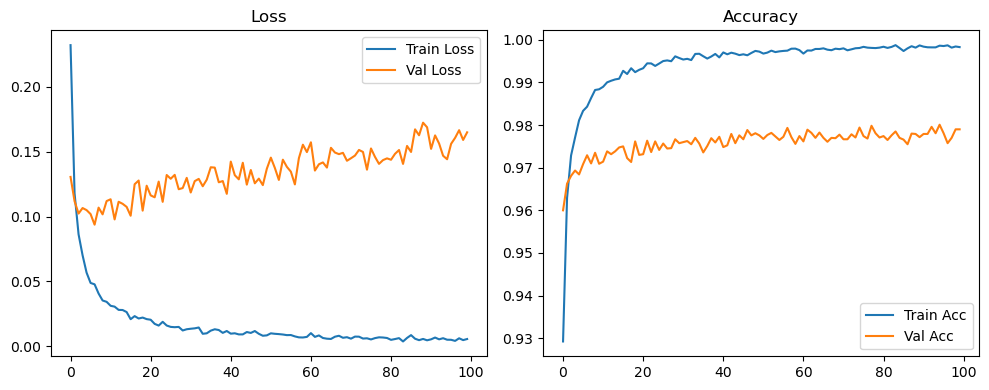

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3155, Acc: 0.9043 | Val Loss: 0.1463, Acc: 0.9552


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1704, Acc: 0.9482 | Val Loss: 0.1212, Acc: 0.9632


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1407, Acc: 0.9565 | Val Loss: 0.1100, Acc: 0.9669


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1187, Acc: 0.9627 | Val Loss: 0.1035, Acc: 0.9692


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1062, Acc: 0.9663 | Val Loss: 0.0963, Acc: 0.9712


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0924, Acc: 0.9704 | Val Loss: 0.1007, Acc: 0.9702


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0891, Acc: 0.9714 | Val Loss: 0.0987, Acc: 0.9700


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0793, Acc: 0.9755 | Val Loss: 0.1018, Acc: 0.9712


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0757, Acc: 0.9754 | Val Loss: 0.0891, Acc: 0.9738


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0736, Acc: 0.9765 | Val Loss: 0.0934, Acc: 0.9738


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0747, Acc: 0.9764 | Val Loss: 0.0951, Acc: 0.9742


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0664, Acc: 0.9780 | Val Loss: 0.0883, Acc: 0.9747


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0645, Acc: 0.9791 | Val Loss: 0.0928, Acc: 0.9736


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0633, Acc: 0.9795 | Val Loss: 0.0932, Acc: 0.9724


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0582, Acc: 0.9808 | Val Loss: 0.0897, Acc: 0.9753


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0539, Acc: 0.9824 | Val Loss: 0.0955, Acc: 0.9743


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0501, Acc: 0.9833 | Val Loss: 0.0979, Acc: 0.9741


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0519, Acc: 0.9827 | Val Loss: 0.0940, Acc: 0.9754


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0505, Acc: 0.9840 | Val Loss: 0.1011, Acc: 0.9748


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0469, Acc: 0.9842 | Val Loss: 0.0984, Acc: 0.9749


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0454, Acc: 0.9848 | Val Loss: 0.1015, Acc: 0.9744


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9860 | Val Loss: 0.1005, Acc: 0.9758


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0433, Acc: 0.9852 | Val Loss: 0.0985, Acc: 0.9748


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0413, Acc: 0.9863 | Val Loss: 0.0927, Acc: 0.9781


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0399, Acc: 0.9868 | Val Loss: 0.0947, Acc: 0.9772


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0392, Acc: 0.9873 | Val Loss: 0.1041, Acc: 0.9767


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0383, Acc: 0.9870 | Val Loss: 0.0998, Acc: 0.9770


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0368, Acc: 0.9874 | Val Loss: 0.1049, Acc: 0.9756


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9876 | Val Loss: 0.1045, Acc: 0.9773


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9897 | Val Loss: 0.0982, Acc: 0.9771


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9887 | Val Loss: 0.1066, Acc: 0.9753


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9892 | Val Loss: 0.1032, Acc: 0.9759


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.1004, Acc: 0.9786


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9894 | Val Loss: 0.1106, Acc: 0.9747


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0310, Acc: 0.9899 | Val Loss: 0.1039, Acc: 0.9764


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9908 | Val Loss: 0.1087, Acc: 0.9773


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9896 | Val Loss: 0.1118, Acc: 0.9755


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.1116, Acc: 0.9763


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9898 | Val Loss: 0.1024, Acc: 0.9780


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9919 | Val Loss: 0.1000, Acc: 0.9780


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 0.1039, Acc: 0.9769


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.1069, Acc: 0.9781


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9912 | Val Loss: 0.1072, Acc: 0.9772


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9921 | Val Loss: 0.1025, Acc: 0.9797


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.0975, Acc: 0.9790


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9919 | Val Loss: 0.1057, Acc: 0.9785


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9913 | Val Loss: 0.1127, Acc: 0.9784


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.1025, Acc: 0.9780


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9924 | Val Loss: 0.1071, Acc: 0.9807


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.1091, Acc: 0.9796


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9920 | Val Loss: 0.1161, Acc: 0.9789


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.1115, Acc: 0.9787


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.1143, Acc: 0.9780


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9935 | Val Loss: 0.1060, Acc: 0.9793


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9926 | Val Loss: 0.1058, Acc: 0.9784


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9935 | Val Loss: 0.1087, Acc: 0.9792


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.1138, Acc: 0.9784


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.1191, Acc: 0.9777


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9937 | Val Loss: 0.1203, Acc: 0.9772


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9937 | Val Loss: 0.1199, Acc: 0.9775


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9935 | Val Loss: 0.1274, Acc: 0.9777


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9933 | Val Loss: 0.1223, Acc: 0.9777


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9937 | Val Loss: 0.1156, Acc: 0.9782


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9943 | Val Loss: 0.1215, Acc: 0.9768


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.1216, Acc: 0.9782


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9938 | Val Loss: 0.1236, Acc: 0.9767


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9942 | Val Loss: 0.1189, Acc: 0.9776


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9939 | Val Loss: 0.1195, Acc: 0.9788


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9941 | Val Loss: 0.1234, Acc: 0.9776


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9941 | Val Loss: 0.1225, Acc: 0.9790


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.1184, Acc: 0.9785


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9940 | Val Loss: 0.1194, Acc: 0.9780


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9944 | Val Loss: 0.1287, Acc: 0.9778


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9940 | Val Loss: 0.1264, Acc: 0.9771


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9940 | Val Loss: 0.1234, Acc: 0.9787


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9946 | Val Loss: 0.1305, Acc: 0.9769


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.1249, Acc: 0.9790


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9947 | Val Loss: 0.1238, Acc: 0.9788


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9947 | Val Loss: 0.1241, Acc: 0.9792


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.1272, Acc: 0.9787


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9946 | Val Loss: 0.1289, Acc: 0.9792


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.1225, Acc: 0.9784


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9947 | Val Loss: 0.1314, Acc: 0.9782


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.1250, Acc: 0.9783


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.1356, Acc: 0.9779


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9954 | Val Loss: 0.1285, Acc: 0.9788


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9944 | Val Loss: 0.1351, Acc: 0.9789


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1286, Acc: 0.9778


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9949 | Val Loss: 0.1282, Acc: 0.9782


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.1358, Acc: 0.9778


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.1323, Acc: 0.9794


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9951 | Val Loss: 0.1371, Acc: 0.9788


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9954 | Val Loss: 0.1366, Acc: 0.9775


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.1313, Acc: 0.9796


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.1293, Acc: 0.9783


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.1276, Acc: 0.9794


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9950 | Val Loss: 0.1295, Acc: 0.9783


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.1343, Acc: 0.9774


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9956 | Val Loss: 0.1293, Acc: 0.9782


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9957 | Val Loss: 0.1317, Acc: 0.9791


Final Test Loss: 0.1257 Accuracy: 0.9800


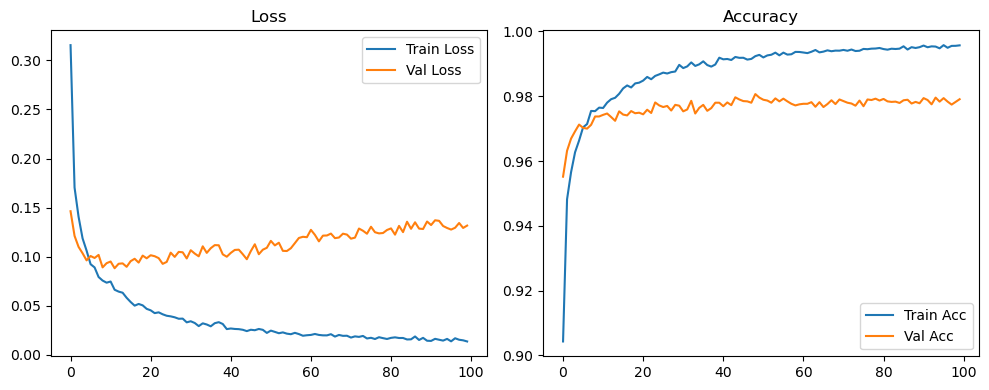

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2620, Acc: 0.9218 | Val Loss: 0.1758, Acc: 0.9502


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1250, Acc: 0.9624 | Val Loss: 0.1568, Acc: 0.9550


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0868, Acc: 0.9730 | Val Loss: 0.1402, Acc: 0.9611


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9791 | Val Loss: 0.1308, Acc: 0.9644


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9829 | Val Loss: 0.1264, Acc: 0.9692


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9869 | Val Loss: 0.1550, Acc: 0.9670


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9869 | Val Loss: 0.1412, Acc: 0.9674


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9887 | Val Loss: 0.1484, Acc: 0.9673


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9898 | Val Loss: 0.1475, Acc: 0.9702


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.1449, Acc: 0.9713


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9932 | Val Loss: 0.1424, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9936 | Val Loss: 0.1732, Acc: 0.9673


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9948 | Val Loss: 0.1611, Acc: 0.9720


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9939 | Val Loss: 0.1659, Acc: 0.9691


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9942 | Val Loss: 0.1515, Acc: 0.9737


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9945 | Val Loss: 0.1589, Acc: 0.9683


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9951 | Val Loss: 0.1524, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9948 | Val Loss: 0.1488, Acc: 0.9731


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9951 | Val Loss: 0.1549, Acc: 0.9731


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1569, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9960 | Val Loss: 0.1548, Acc: 0.9740


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1674, Acc: 0.9730


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1957, Acc: 0.9712


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9954 | Val Loss: 0.1651, Acc: 0.9744


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.1696, Acc: 0.9737


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9959 | Val Loss: 0.1703, Acc: 0.9732


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9966 | Val Loss: 0.1523, Acc: 0.9734


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.1695, Acc: 0.9758


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9972 | Val Loss: 0.1851, Acc: 0.9728


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9974 | Val Loss: 0.1604, Acc: 0.9759


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9968 | Val Loss: 0.1832, Acc: 0.9732


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9967 | Val Loss: 0.1545, Acc: 0.9755


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1613, Acc: 0.9749


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9974 | Val Loss: 0.1409, Acc: 0.9770


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1604, Acc: 0.9753


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1603, Acc: 0.9749


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.1865, Acc: 0.9738


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1875, Acc: 0.9732


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9974 | Val Loss: 0.1348, Acc: 0.9774


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1576, Acc: 0.9758


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1712, Acc: 0.9760


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9980 | Val Loss: 0.1581, Acc: 0.9756


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1561, Acc: 0.9769


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.1507, Acc: 0.9756


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.1494, Acc: 0.9760


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.1841, Acc: 0.9745


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9980 | Val Loss: 0.1555, Acc: 0.9763


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1469, Acc: 0.9772


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1583, Acc: 0.9766


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9985 | Val Loss: 0.1447, Acc: 0.9773


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1634, Acc: 0.9727


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1662, Acc: 0.9742


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.1712, Acc: 0.9769


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9987 | Val Loss: 0.1746, Acc: 0.9750


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9983 | Val Loss: 0.1579, Acc: 0.9752


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1528, Acc: 0.9780


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.1687, Acc: 0.9752


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9981 | Val Loss: 0.1671, Acc: 0.9750


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1641, Acc: 0.9757


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1632, Acc: 0.9777


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9988 | Val Loss: 0.1781, Acc: 0.9755


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1779, Acc: 0.9738


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1676, Acc: 0.9757


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1681, Acc: 0.9764


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1849, Acc: 0.9752


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.2043, Acc: 0.9738


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.1910, Acc: 0.9743


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1670, Acc: 0.9768


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9986 | Val Loss: 0.1487, Acc: 0.9782


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1497, Acc: 0.9769


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1524, Acc: 0.9775


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1695, Acc: 0.9790


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1696, Acc: 0.9776


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9988 | Val Loss: 0.1945, Acc: 0.9768


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1679, Acc: 0.9772


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1597, Acc: 0.9780


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1772, Acc: 0.9772


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1966, Acc: 0.9742


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9985 | Val Loss: 0.2197, Acc: 0.9742


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9979 | Val Loss: 0.1548, Acc: 0.9760


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1791, Acc: 0.9753


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1682, Acc: 0.9760


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1799, Acc: 0.9766


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1865, Acc: 0.9765


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1965, Acc: 0.9762


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1883, Acc: 0.9766


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9989 | Val Loss: 0.1870, Acc: 0.9748


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9987 | Val Loss: 0.1946, Acc: 0.9759


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9989 | Val Loss: 0.1532, Acc: 0.9777


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1841, Acc: 0.9772


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9994 | Val Loss: 0.1789, Acc: 0.9776


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.1557, Acc: 0.9786


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1656, Acc: 0.9777


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.2027, Acc: 0.9742


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1881, Acc: 0.9759


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1819, Acc: 0.9783


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.2142, Acc: 0.9778


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.2029, Acc: 0.9769


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9982 | Val Loss: 0.1739, Acc: 0.9782


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1951, Acc: 0.9775


Final Test Loss: 0.1536 Accuracy: 0.9805


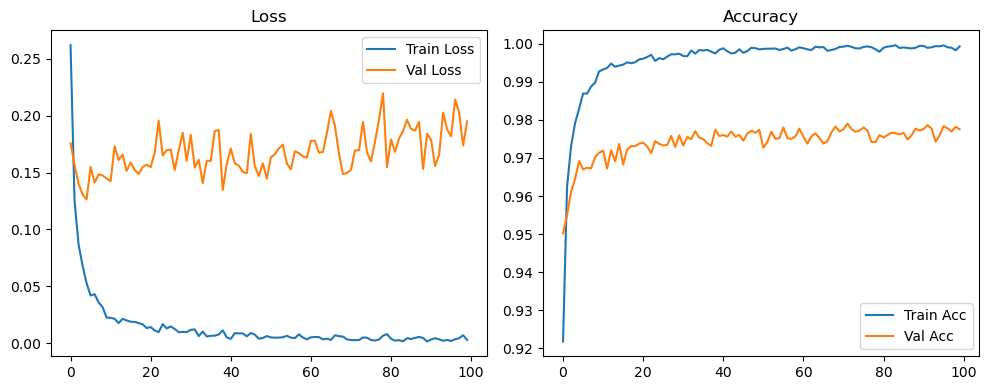

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2811, Acc: 0.9171 | Val Loss: 0.1963, Acc: 0.9444


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1445, Acc: 0.9568 | Val Loss: 0.1580, Acc: 0.9582


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1078, Acc: 0.9673 | Val Loss: 0.1295, Acc: 0.9628


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0828, Acc: 0.9742 | Val Loss: 0.1423, Acc: 0.9601


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0697, Acc: 0.9782 | Val Loss: 0.1127, Acc: 0.9714


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9794 | Val Loss: 0.1276, Acc: 0.9669


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9821 | Val Loss: 0.1248, Acc: 0.9691


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9864 | Val Loss: 0.1442, Acc: 0.9692


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9858 | Val Loss: 0.1320, Acc: 0.9698


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9881 | Val Loss: 0.1298, Acc: 0.9728


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9881 | Val Loss: 0.1442, Acc: 0.9697


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9882 | Val Loss: 0.1453, Acc: 0.9697


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9906 | Val Loss: 0.1410, Acc: 0.9729


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9908 | Val Loss: 0.1385, Acc: 0.9724


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9914 | Val Loss: 0.1374, Acc: 0.9743


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9907 | Val Loss: 0.1562, Acc: 0.9737


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9916 | Val Loss: 0.1582, Acc: 0.9718


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9912 | Val Loss: 0.1513, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9926 | Val Loss: 0.1449, Acc: 0.9746


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9931 | Val Loss: 0.1472, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9930 | Val Loss: 0.1687, Acc: 0.9752


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9932 | Val Loss: 0.1741, Acc: 0.9736


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9939 | Val Loss: 0.1566, Acc: 0.9750


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9939 | Val Loss: 0.1936, Acc: 0.9736


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9936 | Val Loss: 0.1715, Acc: 0.9747


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9939 | Val Loss: 0.1591, Acc: 0.9755


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9939 | Val Loss: 0.1673, Acc: 0.9759


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9943 | Val Loss: 0.1863, Acc: 0.9758


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9941 | Val Loss: 0.1557, Acc: 0.9746


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9948 | Val Loss: 0.1555, Acc: 0.9773


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9958 | Val Loss: 0.1962, Acc: 0.9766


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9959 | Val Loss: 0.1761, Acc: 0.9768


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9960 | Val Loss: 0.1959, Acc: 0.9738


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9940 | Val Loss: 0.1818, Acc: 0.9752


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9960 | Val Loss: 0.1960, Acc: 0.9751


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9949 | Val Loss: 0.1976, Acc: 0.9758


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9951 | Val Loss: 0.2030, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9950 | Val Loss: 0.1576, Acc: 0.9758


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9958 | Val Loss: 0.1833, Acc: 0.9760


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9966 | Val Loss: 0.1888, Acc: 0.9774


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9961 | Val Loss: 0.1927, Acc: 0.9753


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9969 | Val Loss: 0.2238, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9969 | Val Loss: 0.2311, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9966 | Val Loss: 0.1972, Acc: 0.9769


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9965 | Val Loss: 0.2339, Acc: 0.9752


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9963 | Val Loss: 0.2067, Acc: 0.9776


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9961 | Val Loss: 0.2324, Acc: 0.9750


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9965 | Val Loss: 0.2161, Acc: 0.9768


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9968 | Val Loss: 0.2151, Acc: 0.9770


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9964 | Val Loss: 0.2427, Acc: 0.9742


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9962 | Val Loss: 0.2140, Acc: 0.9756


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9968 | Val Loss: 0.1949, Acc: 0.9764


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9972 | Val Loss: 0.2084, Acc: 0.9768


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9973 | Val Loss: 0.2050, Acc: 0.9775


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9972 | Val Loss: 0.1864, Acc: 0.9786


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9971 | Val Loss: 0.2034, Acc: 0.9788


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9971 | Val Loss: 0.2284, Acc: 0.9768


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9965 | Val Loss: 0.2150, Acc: 0.9771


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9974 | Val Loss: 0.2604, Acc: 0.9764


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9969 | Val Loss: 0.2544, Acc: 0.9767


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9965 | Val Loss: 0.2041, Acc: 0.9769


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9974 | Val Loss: 0.2361, Acc: 0.9770


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9970 | Val Loss: 0.2067, Acc: 0.9780


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9978 | Val Loss: 0.2168, Acc: 0.9785


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9980 | Val Loss: 0.2084, Acc: 0.9798


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9976 | Val Loss: 0.2304, Acc: 0.9781


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9976 | Val Loss: 0.2377, Acc: 0.9762


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9972 | Val Loss: 0.2232, Acc: 0.9775


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9971 | Val Loss: 0.2302, Acc: 0.9786


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9981 | Val Loss: 0.2234, Acc: 0.9778


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9971 | Val Loss: 0.2651, Acc: 0.9752


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9974 | Val Loss: 0.2367, Acc: 0.9783


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9980 | Val Loss: 0.2337, Acc: 0.9781


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9974 | Val Loss: 0.2457, Acc: 0.9781


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9980 | Val Loss: 0.2597, Acc: 0.9775


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9972 | Val Loss: 0.2982, Acc: 0.9754


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9974 | Val Loss: 0.2659, Acc: 0.9758


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9974 | Val Loss: 0.2587, Acc: 0.9758


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9980 | Val Loss: 0.2542, Acc: 0.9766


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9984 | Val Loss: 0.2540, Acc: 0.9778


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9980 | Val Loss: 0.2476, Acc: 0.9792


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9982 | Val Loss: 0.2709, Acc: 0.9782


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9981 | Val Loss: 0.2660, Acc: 0.9786


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9973 | Val Loss: 0.2757, Acc: 0.9781


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9977 | Val Loss: 0.2576, Acc: 0.9783


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9978 | Val Loss: 0.2637, Acc: 0.9786


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9981 | Val Loss: 0.3336, Acc: 0.9757


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9977 | Val Loss: 0.3060, Acc: 0.9758


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9983 | Val Loss: 0.2879, Acc: 0.9769


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9983 | Val Loss: 0.2790, Acc: 0.9762


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9984 | Val Loss: 0.3009, Acc: 0.9772


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9976 | Val Loss: 0.2829, Acc: 0.9772


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9981 | Val Loss: 0.2901, Acc: 0.9778


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9980 | Val Loss: 0.3076, Acc: 0.9762


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9982 | Val Loss: 0.3142, Acc: 0.9765


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9973 | Val Loss: 0.3153, Acc: 0.9782


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9981 | Val Loss: 0.2794, Acc: 0.9787


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9982 | Val Loss: 0.2888, Acc: 0.9784


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9979 | Val Loss: 0.2762, Acc: 0.9781


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9986 | Val Loss: 0.2990, Acc: 0.9780


Final Test Loss: 0.2524 Accuracy: 0.9802


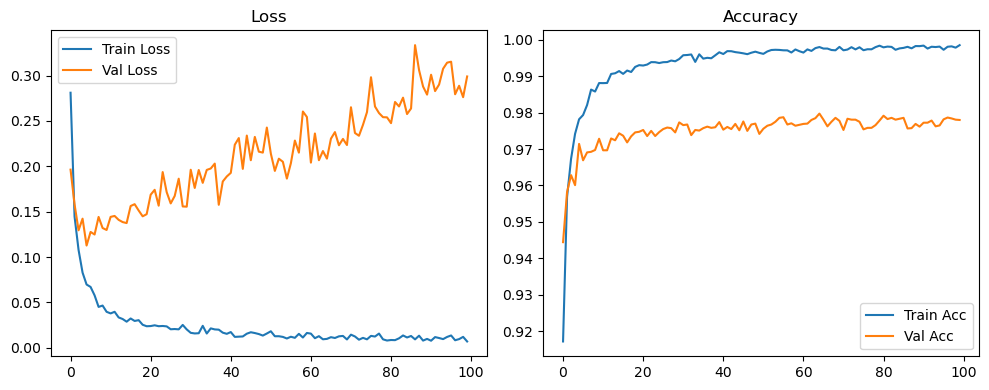

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3406, Acc: 0.8992 | Val Loss: 0.1729, Acc: 0.9499


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2105, Acc: 0.9396 | Val Loss: 0.1463, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1699, Acc: 0.9500 | Val Loss: 0.1376, Acc: 0.9613


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1507, Acc: 0.9557 | Val Loss: 0.1385, Acc: 0.9637


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1283, Acc: 0.9624 | Val Loss: 0.1317, Acc: 0.9636


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1189, Acc: 0.9651 | Val Loss: 0.1090, Acc: 0.9722


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1088, Acc: 0.9670 | Val Loss: 0.1112, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0961, Acc: 0.9716 | Val Loss: 0.1352, Acc: 0.9668


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1008, Acc: 0.9701 | Val Loss: 0.1184, Acc: 0.9702


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0911, Acc: 0.9737 | Val Loss: 0.1249, Acc: 0.9710


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0841, Acc: 0.9760 | Val Loss: 0.1368, Acc: 0.9723


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0812, Acc: 0.9766 | Val Loss: 0.1376, Acc: 0.9712


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0779, Acc: 0.9779 | Val Loss: 0.1303, Acc: 0.9718


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9760 | Val Loss: 0.1258, Acc: 0.9736


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9787 | Val Loss: 0.1495, Acc: 0.9721


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9803 | Val Loss: 0.1307, Acc: 0.9752


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9818 | Val Loss: 0.1473, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0677, Acc: 0.9810 | Val Loss: 0.1320, Acc: 0.9762


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9818 | Val Loss: 0.1345, Acc: 0.9746


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9830 | Val Loss: 0.1305, Acc: 0.9769


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9830 | Val Loss: 0.1374, Acc: 0.9751


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9841 | Val Loss: 0.1378, Acc: 0.9754


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9848 | Val Loss: 0.1478, Acc: 0.9770


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9856 | Val Loss: 0.1565, Acc: 0.9748


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9856 | Val Loss: 0.1599, Acc: 0.9756


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9848 | Val Loss: 0.1368, Acc: 0.9770


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9862 | Val Loss: 0.1657, Acc: 0.9759


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9872 | Val Loss: 0.1632, Acc: 0.9753


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9868 | Val Loss: 0.1552, Acc: 0.9767


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9873 | Val Loss: 0.1719, Acc: 0.9766


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9877 | Val Loss: 0.1549, Acc: 0.9774


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9888 | Val Loss: 0.1566, Acc: 0.9782


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9897 | Val Loss: 0.1632, Acc: 0.9776


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9889 | Val Loss: 0.1934, Acc: 0.9768


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9890 | Val Loss: 0.1706, Acc: 0.9778


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9888 | Val Loss: 0.1811, Acc: 0.9769


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9890 | Val Loss: 0.2003, Acc: 0.9756


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9902 | Val Loss: 0.1957, Acc: 0.9746


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9896 | Val Loss: 0.1736, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9903 | Val Loss: 0.1877, Acc: 0.9754


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9897 | Val Loss: 0.1921, Acc: 0.9757


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9906 | Val Loss: 0.2012, Acc: 0.9759


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9911 | Val Loss: 0.1959, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9898 | Val Loss: 0.1995, Acc: 0.9782


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9911 | Val Loss: 0.2203, Acc: 0.9767


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9914 | Val Loss: 0.2016, Acc: 0.9785


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9909 | Val Loss: 0.2072, Acc: 0.9772


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9908 | Val Loss: 0.2109, Acc: 0.9793


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9915 | Val Loss: 0.2046, Acc: 0.9768


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9912 | Val Loss: 0.2065, Acc: 0.9773


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9917 | Val Loss: 0.2201, Acc: 0.9778


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9920 | Val Loss: 0.1934, Acc: 0.9790


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9919 | Val Loss: 0.1903, Acc: 0.9792


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9922 | Val Loss: 0.1944, Acc: 0.9784


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9912 | Val Loss: 0.1990, Acc: 0.9782


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9915 | Val Loss: 0.2283, Acc: 0.9782


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9924 | Val Loss: 0.2003, Acc: 0.9789


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9930 | Val Loss: 0.2298, Acc: 0.9788


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9929 | Val Loss: 0.2347, Acc: 0.9785


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9929 | Val Loss: 0.2436, Acc: 0.9795


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9926 | Val Loss: 0.2502, Acc: 0.9781


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9926 | Val Loss: 0.2260, Acc: 0.9789


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9932 | Val Loss: 0.2286, Acc: 0.9792


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9932 | Val Loss: 0.2458, Acc: 0.9782


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9926 | Val Loss: 0.2492, Acc: 0.9788


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9925 | Val Loss: 0.2450, Acc: 0.9772


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9940 | Val Loss: 0.2144, Acc: 0.9802


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9936 | Val Loss: 0.2343, Acc: 0.9788


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9938 | Val Loss: 0.2586, Acc: 0.9780


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9936 | Val Loss: 0.2870, Acc: 0.9768


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9931 | Val Loss: 0.2486, Acc: 0.9791


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9936 | Val Loss: 0.2511, Acc: 0.9769


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9942 | Val Loss: 0.2493, Acc: 0.9788


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9943 | Val Loss: 0.2458, Acc: 0.9778


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9937 | Val Loss: 0.2541, Acc: 0.9774


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9941 | Val Loss: 0.2555, Acc: 0.9785


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9941 | Val Loss: 0.2437, Acc: 0.9791


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9940 | Val Loss: 0.2742, Acc: 0.9790


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9945 | Val Loss: 0.2855, Acc: 0.9795


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9941 | Val Loss: 0.2863, Acc: 0.9801


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9938 | Val Loss: 0.2713, Acc: 0.9794


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9943 | Val Loss: 0.2658, Acc: 0.9778


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9942 | Val Loss: 0.2934, Acc: 0.9800


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9935 | Val Loss: 0.2468, Acc: 0.9792


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9934 | Val Loss: 0.2917, Acc: 0.9766


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9938 | Val Loss: 0.2936, Acc: 0.9796


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9950 | Val Loss: 0.2875, Acc: 0.9798


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9945 | Val Loss: 0.2987, Acc: 0.9791


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9946 | Val Loss: 0.2732, Acc: 0.9790


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9949 | Val Loss: 0.2703, Acc: 0.9804


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9950 | Val Loss: 0.2702, Acc: 0.9785


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9948 | Val Loss: 0.3025, Acc: 0.9788


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9945 | Val Loss: 0.2914, Acc: 0.9812


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9953 | Val Loss: 0.2922, Acc: 0.9795


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9951 | Val Loss: 0.2946, Acc: 0.9794


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9946 | Val Loss: 0.2713, Acc: 0.9802


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9948 | Val Loss: 0.3196, Acc: 0.9779


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9948 | Val Loss: 0.2970, Acc: 0.9798


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9951 | Val Loss: 0.2658, Acc: 0.9800


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9952 | Val Loss: 0.3563, Acc: 0.9759


Final Test Loss: 0.3048 Accuracy: 0.9816


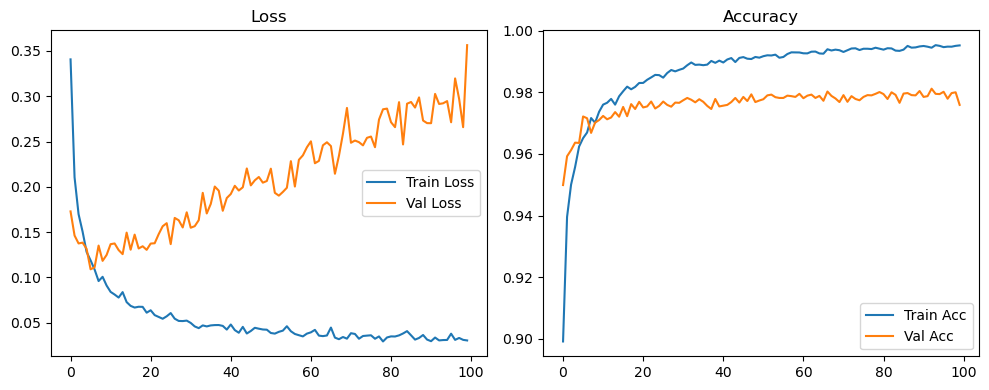

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2620, Acc: 0.9218 | Val Loss: 0.1758, Acc: 0.9502


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1250, Acc: 0.9624 | Val Loss: 0.1568, Acc: 0.9550


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0868, Acc: 0.9730 | Val Loss: 0.1402, Acc: 0.9611


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9791 | Val Loss: 0.1308, Acc: 0.9644


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9829 | Val Loss: 0.1264, Acc: 0.9692


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9869 | Val Loss: 0.1550, Acc: 0.9670


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9869 | Val Loss: 0.1412, Acc: 0.9674


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9887 | Val Loss: 0.1484, Acc: 0.9673


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9898 | Val Loss: 0.1475, Acc: 0.9702


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.1449, Acc: 0.9713


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9932 | Val Loss: 0.1424, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9936 | Val Loss: 0.1732, Acc: 0.9673


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9948 | Val Loss: 0.1611, Acc: 0.9720


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9939 | Val Loss: 0.1659, Acc: 0.9691


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9942 | Val Loss: 0.1515, Acc: 0.9737


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9945 | Val Loss: 0.1589, Acc: 0.9683


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9951 | Val Loss: 0.1524, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9948 | Val Loss: 0.1488, Acc: 0.9731


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9951 | Val Loss: 0.1549, Acc: 0.9731


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1569, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9960 | Val Loss: 0.1548, Acc: 0.9740


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1674, Acc: 0.9730


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1957, Acc: 0.9712


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9954 | Val Loss: 0.1651, Acc: 0.9744


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.1696, Acc: 0.9737


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9959 | Val Loss: 0.1703, Acc: 0.9732


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9966 | Val Loss: 0.1523, Acc: 0.9734


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.1695, Acc: 0.9758


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9972 | Val Loss: 0.1851, Acc: 0.9728


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9974 | Val Loss: 0.1604, Acc: 0.9759


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9968 | Val Loss: 0.1832, Acc: 0.9732


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9967 | Val Loss: 0.1545, Acc: 0.9755


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1613, Acc: 0.9749


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9974 | Val Loss: 0.1409, Acc: 0.9770


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1604, Acc: 0.9753


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1603, Acc: 0.9749


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.1865, Acc: 0.9738


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1875, Acc: 0.9732


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9974 | Val Loss: 0.1348, Acc: 0.9774


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1576, Acc: 0.9758


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1712, Acc: 0.9760


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9980 | Val Loss: 0.1581, Acc: 0.9756


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1561, Acc: 0.9769


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.1507, Acc: 0.9756


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.1494, Acc: 0.9760


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.1841, Acc: 0.9745


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9980 | Val Loss: 0.1555, Acc: 0.9763


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1469, Acc: 0.9772


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1583, Acc: 0.9766


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9985 | Val Loss: 0.1447, Acc: 0.9773


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1370, Acc: 0.9787


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1469, Acc: 0.9775


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1506, Acc: 0.9788


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1563, Acc: 0.9772


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1485, Acc: 0.9790


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1535, Acc: 0.9787


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1527, Acc: 0.9805


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1677, Acc: 0.9778


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1610, Acc: 0.9771


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1593, Acc: 0.9778


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1525, Acc: 0.9783


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1712, Acc: 0.9764


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1680, Acc: 0.9794


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1724, Acc: 0.9781


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1634, Acc: 0.9783


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1556, Acc: 0.9785


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1626, Acc: 0.9777


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9992 | Val Loss: 0.1975, Acc: 0.9752


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1759, Acc: 0.9767


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1715, Acc: 0.9774


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1812, Acc: 0.9778


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1875, Acc: 0.9768


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.1758, Acc: 0.9771


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9995 | Val Loss: 0.1655, Acc: 0.9778


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1789, Acc: 0.9765


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1728, Acc: 0.9787


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1715, Acc: 0.9792


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1670, Acc: 0.9799


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1600, Acc: 0.9792


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1708, Acc: 0.9786


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1594, Acc: 0.9798


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1573, Acc: 0.9799


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1624, Acc: 0.9797


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1628, Acc: 0.9797


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1607, Acc: 0.9801


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1583, Acc: 0.9794


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1628, Acc: 0.9789


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1607, Acc: 0.9795


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1644, Acc: 0.9793


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1663, Acc: 0.9791


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1651, Acc: 0.9795


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1706, Acc: 0.9790


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1678, Acc: 0.9801


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1683, Acc: 0.9791


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1729, Acc: 0.9796


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1760, Acc: 0.9787


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1803, Acc: 0.9785


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1918, Acc: 0.9783


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1791, Acc: 0.9796


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1865, Acc: 0.9792


Final Test Loss: 0.1755 Accuracy: 0.9810


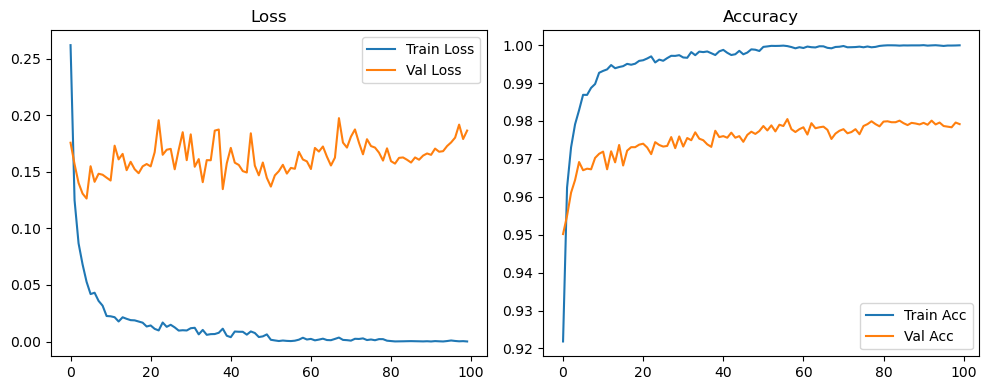

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2811, Acc: 0.9171 | Val Loss: 0.1963, Acc: 0.9444


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1445, Acc: 0.9568 | Val Loss: 0.1580, Acc: 0.9582


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1078, Acc: 0.9673 | Val Loss: 0.1295, Acc: 0.9628


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0828, Acc: 0.9742 | Val Loss: 0.1423, Acc: 0.9601


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0697, Acc: 0.9782 | Val Loss: 0.1127, Acc: 0.9714


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9794 | Val Loss: 0.1276, Acc: 0.9669


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9821 | Val Loss: 0.1248, Acc: 0.9691


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9864 | Val Loss: 0.1442, Acc: 0.9692


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9858 | Val Loss: 0.1320, Acc: 0.9698


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9881 | Val Loss: 0.1298, Acc: 0.9728


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9881 | Val Loss: 0.1442, Acc: 0.9697


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9882 | Val Loss: 0.1453, Acc: 0.9697


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9906 | Val Loss: 0.1410, Acc: 0.9729


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9908 | Val Loss: 0.1385, Acc: 0.9724


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9914 | Val Loss: 0.1374, Acc: 0.9743


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9907 | Val Loss: 0.1562, Acc: 0.9737


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9916 | Val Loss: 0.1582, Acc: 0.9718


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9912 | Val Loss: 0.1513, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9926 | Val Loss: 0.1449, Acc: 0.9746


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9931 | Val Loss: 0.1472, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9930 | Val Loss: 0.1687, Acc: 0.9752


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9932 | Val Loss: 0.1741, Acc: 0.9736


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9939 | Val Loss: 0.1566, Acc: 0.9750


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9939 | Val Loss: 0.1936, Acc: 0.9736


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9936 | Val Loss: 0.1715, Acc: 0.9747


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9939 | Val Loss: 0.1591, Acc: 0.9755


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9939 | Val Loss: 0.1673, Acc: 0.9759


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9943 | Val Loss: 0.1863, Acc: 0.9758


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9941 | Val Loss: 0.1557, Acc: 0.9746


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9948 | Val Loss: 0.1555, Acc: 0.9773


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9958 | Val Loss: 0.1962, Acc: 0.9766


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9959 | Val Loss: 0.1761, Acc: 0.9768


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9960 | Val Loss: 0.1959, Acc: 0.9738


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9940 | Val Loss: 0.1818, Acc: 0.9752


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9960 | Val Loss: 0.1960, Acc: 0.9751


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9949 | Val Loss: 0.1976, Acc: 0.9758


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9951 | Val Loss: 0.2030, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9950 | Val Loss: 0.1576, Acc: 0.9758


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9958 | Val Loss: 0.1833, Acc: 0.9760


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9966 | Val Loss: 0.1888, Acc: 0.9774


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9961 | Val Loss: 0.1927, Acc: 0.9753


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9969 | Val Loss: 0.2238, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9969 | Val Loss: 0.2311, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9966 | Val Loss: 0.1972, Acc: 0.9769


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9965 | Val Loss: 0.2339, Acc: 0.9752


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9963 | Val Loss: 0.2067, Acc: 0.9776


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9961 | Val Loss: 0.2324, Acc: 0.9750


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9965 | Val Loss: 0.2161, Acc: 0.9768


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9968 | Val Loss: 0.2151, Acc: 0.9770


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9964 | Val Loss: 0.2427, Acc: 0.9742


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9981 | Val Loss: 0.1903, Acc: 0.9787


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.1891, Acc: 0.9788


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1862, Acc: 0.9788


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1965, Acc: 0.9795


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1944, Acc: 0.9801


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1935, Acc: 0.9798


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.1940, Acc: 0.9801


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.2009, Acc: 0.9799


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.2066, Acc: 0.9788


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9993 | Val Loss: 0.2164, Acc: 0.9784


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.2141, Acc: 0.9800


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.2245, Acc: 0.9794


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.2325, Acc: 0.9786


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9991 | Val Loss: 0.2259, Acc: 0.9798


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.2223, Acc: 0.9795


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.2196, Acc: 0.9789


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9987 | Val Loss: 0.2397, Acc: 0.9773


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9986 | Val Loss: 0.2304, Acc: 0.9789


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9988 | Val Loss: 0.2161, Acc: 0.9789


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9990 | Val Loss: 0.2166, Acc: 0.9786


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9990 | Val Loss: 0.2051, Acc: 0.9797


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.2320, Acc: 0.9809


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.2313, Acc: 0.9807


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9988 | Val Loss: 0.2315, Acc: 0.9782


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.2517, Acc: 0.9792


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9988 | Val Loss: 0.2344, Acc: 0.9798


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.2393, Acc: 0.9782


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9992 | Val Loss: 0.2388, Acc: 0.9791


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.2606, Acc: 0.9788


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.2630, Acc: 0.9773


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9993 | Val Loss: 0.2408, Acc: 0.9805


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9994 | Val Loss: 0.2370, Acc: 0.9797


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.2355, Acc: 0.9802


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.2291, Acc: 0.9809


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.2343, Acc: 0.9804


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.2360, Acc: 0.9813


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.2316, Acc: 0.9799


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.2223, Acc: 0.9804


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.2288, Acc: 0.9819


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2285, Acc: 0.9804


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2303, Acc: 0.9815


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2456, Acc: 0.9805


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.2336, Acc: 0.9813


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2241, Acc: 0.9807


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.2304, Acc: 0.9821


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.2266, Acc: 0.9819


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2262, Acc: 0.9819


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.2292, Acc: 0.9809


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2316, Acc: 0.9808


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2347, Acc: 0.9808


Final Test Loss: 0.2177 Accuracy: 0.9813


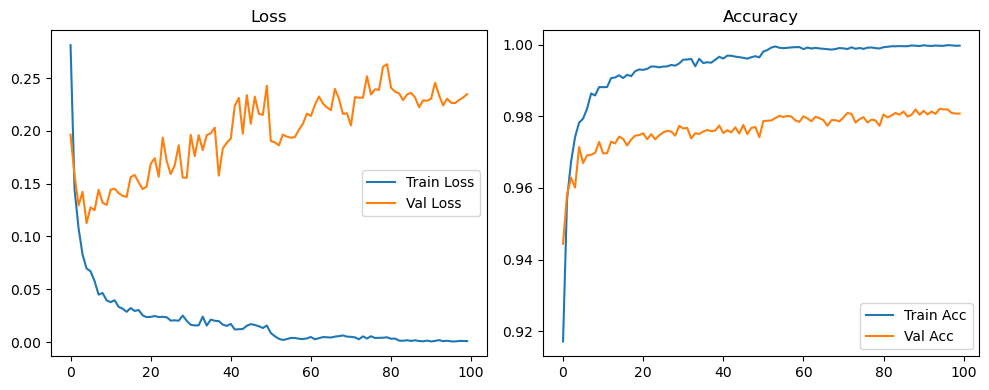

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3406, Acc: 0.8992 | Val Loss: 0.1729, Acc: 0.9499


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2105, Acc: 0.9396 | Val Loss: 0.1463, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1699, Acc: 0.9500 | Val Loss: 0.1376, Acc: 0.9613


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1507, Acc: 0.9557 | Val Loss: 0.1385, Acc: 0.9637


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1283, Acc: 0.9624 | Val Loss: 0.1317, Acc: 0.9636


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1189, Acc: 0.9651 | Val Loss: 0.1090, Acc: 0.9722


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1088, Acc: 0.9670 | Val Loss: 0.1112, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0961, Acc: 0.9716 | Val Loss: 0.1352, Acc: 0.9668


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1008, Acc: 0.9701 | Val Loss: 0.1184, Acc: 0.9702


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0911, Acc: 0.9737 | Val Loss: 0.1249, Acc: 0.9710


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0841, Acc: 0.9760 | Val Loss: 0.1368, Acc: 0.9723


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0812, Acc: 0.9766 | Val Loss: 0.1376, Acc: 0.9712


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0779, Acc: 0.9779 | Val Loss: 0.1303, Acc: 0.9718


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9760 | Val Loss: 0.1258, Acc: 0.9736


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9787 | Val Loss: 0.1495, Acc: 0.9721


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9803 | Val Loss: 0.1307, Acc: 0.9752


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9818 | Val Loss: 0.1473, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0677, Acc: 0.9810 | Val Loss: 0.1320, Acc: 0.9762


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9818 | Val Loss: 0.1345, Acc: 0.9746


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9830 | Val Loss: 0.1305, Acc: 0.9769


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9830 | Val Loss: 0.1374, Acc: 0.9751


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9841 | Val Loss: 0.1378, Acc: 0.9754


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9848 | Val Loss: 0.1478, Acc: 0.9770


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9856 | Val Loss: 0.1565, Acc: 0.9748


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9856 | Val Loss: 0.1599, Acc: 0.9756


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9848 | Val Loss: 0.1368, Acc: 0.9770


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9862 | Val Loss: 0.1657, Acc: 0.9759


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9872 | Val Loss: 0.1632, Acc: 0.9753


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9868 | Val Loss: 0.1552, Acc: 0.9767


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9873 | Val Loss: 0.1719, Acc: 0.9766


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9877 | Val Loss: 0.1549, Acc: 0.9774


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9888 | Val Loss: 0.1566, Acc: 0.9782


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9897 | Val Loss: 0.1632, Acc: 0.9776


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9889 | Val Loss: 0.1934, Acc: 0.9768


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9890 | Val Loss: 0.1706, Acc: 0.9778


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9888 | Val Loss: 0.1811, Acc: 0.9769


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9890 | Val Loss: 0.2003, Acc: 0.9756


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9902 | Val Loss: 0.1957, Acc: 0.9746


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9896 | Val Loss: 0.1736, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9903 | Val Loss: 0.1877, Acc: 0.9754


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9897 | Val Loss: 0.1921, Acc: 0.9757


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9906 | Val Loss: 0.2012, Acc: 0.9759


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9911 | Val Loss: 0.1959, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9898 | Val Loss: 0.1995, Acc: 0.9782


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9911 | Val Loss: 0.2203, Acc: 0.9767


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9914 | Val Loss: 0.2016, Acc: 0.9785


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9909 | Val Loss: 0.2072, Acc: 0.9772


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9908 | Val Loss: 0.2109, Acc: 0.9793


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9915 | Val Loss: 0.2046, Acc: 0.9768


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9912 | Val Loss: 0.2065, Acc: 0.9773


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9934 | Val Loss: 0.1867, Acc: 0.9788


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9948 | Val Loss: 0.1871, Acc: 0.9796


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9955 | Val Loss: 0.1922, Acc: 0.9791


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9950 | Val Loss: 0.1942, Acc: 0.9806


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9955 | Val Loss: 0.1957, Acc: 0.9796


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9961 | Val Loss: 0.2055, Acc: 0.9802


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9960 | Val Loss: 0.2098, Acc: 0.9802


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9961 | Val Loss: 0.2101, Acc: 0.9812


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9966 | Val Loss: 0.2199, Acc: 0.9784


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9966 | Val Loss: 0.2188, Acc: 0.9789


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9965 | Val Loss: 0.2175, Acc: 0.9808


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9960 | Val Loss: 0.2207, Acc: 0.9798


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9965 | Val Loss: 0.2209, Acc: 0.9792


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9965 | Val Loss: 0.2198, Acc: 0.9798


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9965 | Val Loss: 0.2198, Acc: 0.9804


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9964 | Val Loss: 0.2287, Acc: 0.9798


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9967 | Val Loss: 0.2231, Acc: 0.9805


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9967 | Val Loss: 0.2258, Acc: 0.9807


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9971 | Val Loss: 0.2334, Acc: 0.9811


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9966 | Val Loss: 0.2192, Acc: 0.9801


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9962 | Val Loss: 0.2214, Acc: 0.9795


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9965 | Val Loss: 0.2274, Acc: 0.9798


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9968 | Val Loss: 0.2499, Acc: 0.9792


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9966 | Val Loss: 0.2260, Acc: 0.9801


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9966 | Val Loss: 0.2444, Acc: 0.9810


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9966 | Val Loss: 0.2603, Acc: 0.9792


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9965 | Val Loss: 0.2233, Acc: 0.9809


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9969 | Val Loss: 0.2503, Acc: 0.9802


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9966 | Val Loss: 0.2575, Acc: 0.9796


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9969 | Val Loss: 0.2394, Acc: 0.9804


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9971 | Val Loss: 0.2278, Acc: 0.9809


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9976 | Val Loss: 0.2174, Acc: 0.9820


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.2295, Acc: 0.9817


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9981 | Val Loss: 0.2154, Acc: 0.9806


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9982 | Val Loss: 0.2264, Acc: 0.9815


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9981 | Val Loss: 0.2223, Acc: 0.9823


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9982 | Val Loss: 0.2305, Acc: 0.9818


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9984 | Val Loss: 0.2317, Acc: 0.9808


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9985 | Val Loss: 0.2304, Acc: 0.9809


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.2243, Acc: 0.9821


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9983 | Val Loss: 0.2373, Acc: 0.9802


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.2511, Acc: 0.9821


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9986 | Val Loss: 0.2503, Acc: 0.9808


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9987 | Val Loss: 0.2464, Acc: 0.9829


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9984 | Val Loss: 0.2411, Acc: 0.9820


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9987 | Val Loss: 0.2394, Acc: 0.9820


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9986 | Val Loss: 0.2289, Acc: 0.9821


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9981 | Val Loss: 0.2294, Acc: 0.9812


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.2316, Acc: 0.9818


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9984 | Val Loss: 0.2257, Acc: 0.9821


Final Test Loss: 0.2061 Accuracy: 0.9827


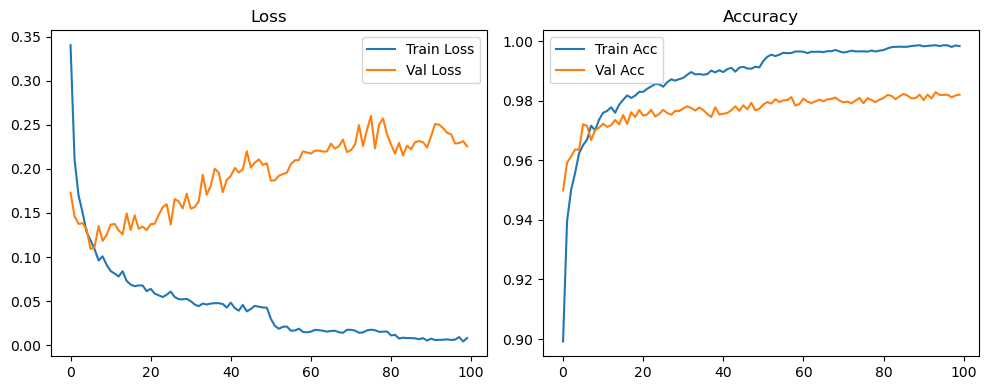

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2620, Acc: 0.9218 | Val Loss: 0.1758, Acc: 0.9502


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1250, Acc: 0.9624 | Val Loss: 0.1568, Acc: 0.9550


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0868, Acc: 0.9730 | Val Loss: 0.1402, Acc: 0.9611


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9791 | Val Loss: 0.1308, Acc: 0.9644


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9829 | Val Loss: 0.1264, Acc: 0.9692


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9869 | Val Loss: 0.1550, Acc: 0.9670


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9869 | Val Loss: 0.1412, Acc: 0.9674


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9887 | Val Loss: 0.1484, Acc: 0.9673


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9898 | Val Loss: 0.1475, Acc: 0.9702


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.1449, Acc: 0.9713


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9932 | Val Loss: 0.1424, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9936 | Val Loss: 0.1732, Acc: 0.9673


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9948 | Val Loss: 0.1611, Acc: 0.9720


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9939 | Val Loss: 0.1659, Acc: 0.9691


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9942 | Val Loss: 0.1515, Acc: 0.9737


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9945 | Val Loss: 0.1589, Acc: 0.9683


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9951 | Val Loss: 0.1524, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9948 | Val Loss: 0.1488, Acc: 0.9731


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9951 | Val Loss: 0.1549, Acc: 0.9731


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1569, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9960 | Val Loss: 0.1548, Acc: 0.9740


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1674, Acc: 0.9730


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1957, Acc: 0.9712


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9954 | Val Loss: 0.1651, Acc: 0.9744


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.1696, Acc: 0.9737


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9959 | Val Loss: 0.1703, Acc: 0.9732


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9966 | Val Loss: 0.1523, Acc: 0.9734


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.1695, Acc: 0.9758


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9972 | Val Loss: 0.1851, Acc: 0.9728


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9974 | Val Loss: 0.1604, Acc: 0.9759


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9968 | Val Loss: 0.1832, Acc: 0.9732


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9967 | Val Loss: 0.1545, Acc: 0.9755


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1613, Acc: 0.9749


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9974 | Val Loss: 0.1409, Acc: 0.9770


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1604, Acc: 0.9753


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1603, Acc: 0.9749


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.1865, Acc: 0.9738


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1875, Acc: 0.9732


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9974 | Val Loss: 0.1348, Acc: 0.9774


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1576, Acc: 0.9758


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1712, Acc: 0.9760


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9980 | Val Loss: 0.1581, Acc: 0.9756


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1561, Acc: 0.9769


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.1507, Acc: 0.9756


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.1494, Acc: 0.9760


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.1841, Acc: 0.9745


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9980 | Val Loss: 0.1555, Acc: 0.9763


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1469, Acc: 0.9772


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1583, Acc: 0.9766


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9985 | Val Loss: 0.1447, Acc: 0.9773


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1370, Acc: 0.9787


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1469, Acc: 0.9775


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1506, Acc: 0.9788


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1563, Acc: 0.9772


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1485, Acc: 0.9790


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1535, Acc: 0.9787


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1527, Acc: 0.9805


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1677, Acc: 0.9778


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1610, Acc: 0.9771


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1593, Acc: 0.9778


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1525, Acc: 0.9783


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1712, Acc: 0.9764


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1680, Acc: 0.9794


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1724, Acc: 0.9781


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1634, Acc: 0.9783


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1556, Acc: 0.9785


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1626, Acc: 0.9777


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9992 | Val Loss: 0.1975, Acc: 0.9752


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1759, Acc: 0.9767


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1715, Acc: 0.9774


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1812, Acc: 0.9778


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1875, Acc: 0.9768


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.1758, Acc: 0.9771


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9995 | Val Loss: 0.1655, Acc: 0.9778


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1789, Acc: 0.9765


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1728, Acc: 0.9787


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1715, Acc: 0.9792


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1670, Acc: 0.9799


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1600, Acc: 0.9792


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1708, Acc: 0.9786


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1611, Acc: 0.9797


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1624, Acc: 0.9799


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1584, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1595, Acc: 0.9804


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1548, Acc: 0.9799


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1554, Acc: 0.9802


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1607, Acc: 0.9802


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1562, Acc: 0.9797


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1567, Acc: 0.9793


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1591, Acc: 0.9803


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1628, Acc: 0.9798


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1669, Acc: 0.9792


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1601, Acc: 0.9800


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1623, Acc: 0.9794


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1616, Acc: 0.9806


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1635, Acc: 0.9802


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1634, Acc: 0.9805


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1664, Acc: 0.9798


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1603, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1637, Acc: 0.9807


Final Test Loss: 0.1597 Accuracy: 0.9817


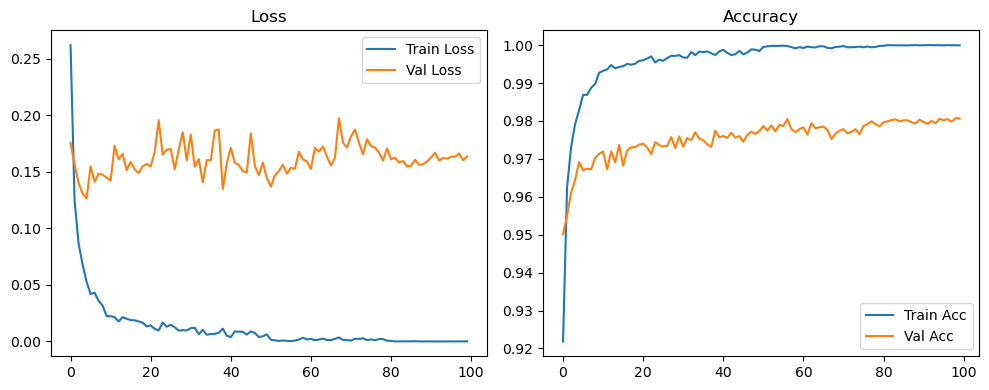

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2811, Acc: 0.9171 | Val Loss: 0.1963, Acc: 0.9444


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1445, Acc: 0.9568 | Val Loss: 0.1580, Acc: 0.9582


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1078, Acc: 0.9673 | Val Loss: 0.1295, Acc: 0.9628


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0828, Acc: 0.9742 | Val Loss: 0.1423, Acc: 0.9601


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0697, Acc: 0.9782 | Val Loss: 0.1127, Acc: 0.9714


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9794 | Val Loss: 0.1276, Acc: 0.9669


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9821 | Val Loss: 0.1248, Acc: 0.9691


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9864 | Val Loss: 0.1442, Acc: 0.9692


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9858 | Val Loss: 0.1320, Acc: 0.9698


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9881 | Val Loss: 0.1298, Acc: 0.9728


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9881 | Val Loss: 0.1442, Acc: 0.9697


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9882 | Val Loss: 0.1453, Acc: 0.9697


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9906 | Val Loss: 0.1410, Acc: 0.9729


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9908 | Val Loss: 0.1385, Acc: 0.9724


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9914 | Val Loss: 0.1374, Acc: 0.9743


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9907 | Val Loss: 0.1562, Acc: 0.9737


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9916 | Val Loss: 0.1582, Acc: 0.9718


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9912 | Val Loss: 0.1513, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9926 | Val Loss: 0.1449, Acc: 0.9746


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9931 | Val Loss: 0.1472, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9930 | Val Loss: 0.1687, Acc: 0.9752


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9932 | Val Loss: 0.1741, Acc: 0.9736


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9939 | Val Loss: 0.1566, Acc: 0.9750


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9939 | Val Loss: 0.1936, Acc: 0.9736


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9936 | Val Loss: 0.1715, Acc: 0.9747


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9939 | Val Loss: 0.1591, Acc: 0.9755


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9939 | Val Loss: 0.1673, Acc: 0.9759


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9943 | Val Loss: 0.1863, Acc: 0.9758


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9941 | Val Loss: 0.1557, Acc: 0.9746


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9948 | Val Loss: 0.1555, Acc: 0.9773


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9958 | Val Loss: 0.1962, Acc: 0.9766


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9959 | Val Loss: 0.1761, Acc: 0.9768


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9960 | Val Loss: 0.1959, Acc: 0.9738


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9940 | Val Loss: 0.1818, Acc: 0.9752


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9960 | Val Loss: 0.1960, Acc: 0.9751


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9949 | Val Loss: 0.1976, Acc: 0.9758


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9951 | Val Loss: 0.2030, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9950 | Val Loss: 0.1576, Acc: 0.9758


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9958 | Val Loss: 0.1833, Acc: 0.9760


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9966 | Val Loss: 0.1888, Acc: 0.9774


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9961 | Val Loss: 0.1927, Acc: 0.9753


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9969 | Val Loss: 0.2238, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9969 | Val Loss: 0.2311, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9966 | Val Loss: 0.1972, Acc: 0.9769


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9965 | Val Loss: 0.2339, Acc: 0.9752


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9963 | Val Loss: 0.2067, Acc: 0.9776


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9961 | Val Loss: 0.2324, Acc: 0.9750


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9965 | Val Loss: 0.2161, Acc: 0.9768


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9968 | Val Loss: 0.2151, Acc: 0.9770


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9964 | Val Loss: 0.2427, Acc: 0.9742


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9981 | Val Loss: 0.1903, Acc: 0.9787


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.1891, Acc: 0.9788


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1862, Acc: 0.9788


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1965, Acc: 0.9795


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1944, Acc: 0.9801


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1935, Acc: 0.9798


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.1940, Acc: 0.9801


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.2009, Acc: 0.9799


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.2066, Acc: 0.9788


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9993 | Val Loss: 0.2164, Acc: 0.9784


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.2141, Acc: 0.9800


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.2245, Acc: 0.9794


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.2325, Acc: 0.9786


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9991 | Val Loss: 0.2259, Acc: 0.9798


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.2223, Acc: 0.9795


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.2196, Acc: 0.9789


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9987 | Val Loss: 0.2397, Acc: 0.9773


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9986 | Val Loss: 0.2304, Acc: 0.9789


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9988 | Val Loss: 0.2161, Acc: 0.9789


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9990 | Val Loss: 0.2166, Acc: 0.9786


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9990 | Val Loss: 0.2051, Acc: 0.9797


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.2320, Acc: 0.9809


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.2313, Acc: 0.9807


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9988 | Val Loss: 0.2315, Acc: 0.9782


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.2517, Acc: 0.9792


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9988 | Val Loss: 0.2344, Acc: 0.9798


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.2393, Acc: 0.9782


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9992 | Val Loss: 0.2388, Acc: 0.9791


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.2606, Acc: 0.9788


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.2630, Acc: 0.9773


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.2424, Acc: 0.9807


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9995 | Val Loss: 0.2379, Acc: 0.9808


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.2381, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2390, Acc: 0.9805


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.2323, Acc: 0.9801


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.2288, Acc: 0.9812


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2368, Acc: 0.9810


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2423, Acc: 0.9808


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2330, Acc: 0.9808


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2333, Acc: 0.9806


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.2290, Acc: 0.9809


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2301, Acc: 0.9812


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2352, Acc: 0.9806


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2381, Acc: 0.9818


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2495, Acc: 0.9811


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2470, Acc: 0.9809


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2414, Acc: 0.9817


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.2497, Acc: 0.9819


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2343, Acc: 0.9818


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2421, Acc: 0.9807


Final Test Loss: 0.2058 Accuracy: 0.9831


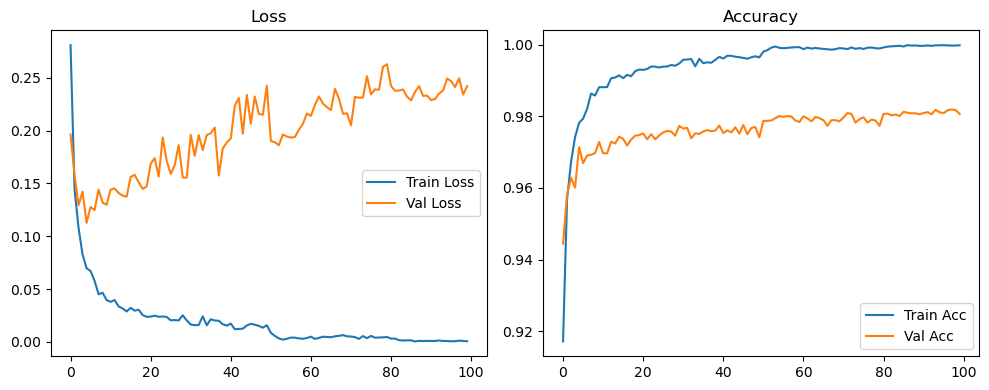

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3406, Acc: 0.8992 | Val Loss: 0.1729, Acc: 0.9499


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2105, Acc: 0.9396 | Val Loss: 0.1463, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1699, Acc: 0.9500 | Val Loss: 0.1376, Acc: 0.9613


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1507, Acc: 0.9557 | Val Loss: 0.1385, Acc: 0.9637


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1283, Acc: 0.9624 | Val Loss: 0.1317, Acc: 0.9636


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1189, Acc: 0.9651 | Val Loss: 0.1090, Acc: 0.9722


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1088, Acc: 0.9670 | Val Loss: 0.1112, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0961, Acc: 0.9716 | Val Loss: 0.1352, Acc: 0.9668


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1008, Acc: 0.9701 | Val Loss: 0.1184, Acc: 0.9702


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0911, Acc: 0.9737 | Val Loss: 0.1249, Acc: 0.9710


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0841, Acc: 0.9760 | Val Loss: 0.1368, Acc: 0.9723


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0812, Acc: 0.9766 | Val Loss: 0.1376, Acc: 0.9712


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0779, Acc: 0.9779 | Val Loss: 0.1303, Acc: 0.9718


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9760 | Val Loss: 0.1258, Acc: 0.9736


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9787 | Val Loss: 0.1495, Acc: 0.9721


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9803 | Val Loss: 0.1307, Acc: 0.9752


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9818 | Val Loss: 0.1473, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0677, Acc: 0.9810 | Val Loss: 0.1320, Acc: 0.9762


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9818 | Val Loss: 0.1345, Acc: 0.9746


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9830 | Val Loss: 0.1305, Acc: 0.9769


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9830 | Val Loss: 0.1374, Acc: 0.9751


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9841 | Val Loss: 0.1378, Acc: 0.9754


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9848 | Val Loss: 0.1478, Acc: 0.9770


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9856 | Val Loss: 0.1565, Acc: 0.9748


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9856 | Val Loss: 0.1599, Acc: 0.9756


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9848 | Val Loss: 0.1368, Acc: 0.9770


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9862 | Val Loss: 0.1657, Acc: 0.9759


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9872 | Val Loss: 0.1632, Acc: 0.9753


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9868 | Val Loss: 0.1552, Acc: 0.9767


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9873 | Val Loss: 0.1719, Acc: 0.9766


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9877 | Val Loss: 0.1549, Acc: 0.9774


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9888 | Val Loss: 0.1566, Acc: 0.9782


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9897 | Val Loss: 0.1632, Acc: 0.9776


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9889 | Val Loss: 0.1934, Acc: 0.9768


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9890 | Val Loss: 0.1706, Acc: 0.9778


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9888 | Val Loss: 0.1811, Acc: 0.9769


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9890 | Val Loss: 0.2003, Acc: 0.9756


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9902 | Val Loss: 0.1957, Acc: 0.9746


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9896 | Val Loss: 0.1736, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9903 | Val Loss: 0.1877, Acc: 0.9754


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9897 | Val Loss: 0.1921, Acc: 0.9757


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9906 | Val Loss: 0.2012, Acc: 0.9759


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9911 | Val Loss: 0.1959, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9898 | Val Loss: 0.1995, Acc: 0.9782


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9911 | Val Loss: 0.2203, Acc: 0.9767


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9914 | Val Loss: 0.2016, Acc: 0.9785


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9909 | Val Loss: 0.2072, Acc: 0.9772


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9908 | Val Loss: 0.2109, Acc: 0.9793


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9915 | Val Loss: 0.2046, Acc: 0.9768


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9912 | Val Loss: 0.2065, Acc: 0.9773


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9934 | Val Loss: 0.1867, Acc: 0.9788


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9948 | Val Loss: 0.1871, Acc: 0.9796


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9955 | Val Loss: 0.1922, Acc: 0.9791


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9950 | Val Loss: 0.1942, Acc: 0.9806


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9955 | Val Loss: 0.1957, Acc: 0.9796


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9961 | Val Loss: 0.2055, Acc: 0.9802


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9960 | Val Loss: 0.2098, Acc: 0.9802


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9961 | Val Loss: 0.2101, Acc: 0.9812


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9966 | Val Loss: 0.2199, Acc: 0.9784


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9966 | Val Loss: 0.2188, Acc: 0.9789


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9965 | Val Loss: 0.2175, Acc: 0.9808


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9960 | Val Loss: 0.2207, Acc: 0.9798


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9965 | Val Loss: 0.2209, Acc: 0.9792


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9965 | Val Loss: 0.2198, Acc: 0.9798


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9965 | Val Loss: 0.2198, Acc: 0.9804


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9964 | Val Loss: 0.2287, Acc: 0.9798


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9967 | Val Loss: 0.2231, Acc: 0.9805


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9967 | Val Loss: 0.2258, Acc: 0.9807


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9971 | Val Loss: 0.2334, Acc: 0.9811


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9966 | Val Loss: 0.2192, Acc: 0.9801


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9962 | Val Loss: 0.2214, Acc: 0.9795


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9965 | Val Loss: 0.2274, Acc: 0.9798


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9968 | Val Loss: 0.2499, Acc: 0.9792


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9966 | Val Loss: 0.2260, Acc: 0.9801


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9966 | Val Loss: 0.2444, Acc: 0.9810


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9966 | Val Loss: 0.2603, Acc: 0.9792


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9965 | Val Loss: 0.2233, Acc: 0.9809


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9969 | Val Loss: 0.2503, Acc: 0.9802


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9966 | Val Loss: 0.2575, Acc: 0.9796


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9969 | Val Loss: 0.2394, Acc: 0.9804


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9974 | Val Loss: 0.2298, Acc: 0.9812


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9972 | Val Loss: 0.2231, Acc: 0.9815


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9980 | Val Loss: 0.2300, Acc: 0.9814


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9982 | Val Loss: 0.2211, Acc: 0.9816


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9978 | Val Loss: 0.2260, Acc: 0.9819


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9982 | Val Loss: 0.2229, Acc: 0.9825


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9983 | Val Loss: 0.2255, Acc: 0.9815


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9981 | Val Loss: 0.2157, Acc: 0.9807


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9983 | Val Loss: 0.2137, Acc: 0.9827


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.2133, Acc: 0.9826


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9982 | Val Loss: 0.2173, Acc: 0.9819


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9986 | Val Loss: 0.2324, Acc: 0.9823


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.2301, Acc: 0.9814


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9986 | Val Loss: 0.2285, Acc: 0.9822


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9987 | Val Loss: 0.2345, Acc: 0.9816


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9990 | Val Loss: 0.2369, Acc: 0.9820


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9983 | Val Loss: 0.2311, Acc: 0.9818


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9989 | Val Loss: 0.2240, Acc: 0.9827


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.2292, Acc: 0.9818


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9986 | Val Loss: 0.2262, Acc: 0.9816


Final Test Loss: 0.1996 Accuracy: 0.9833


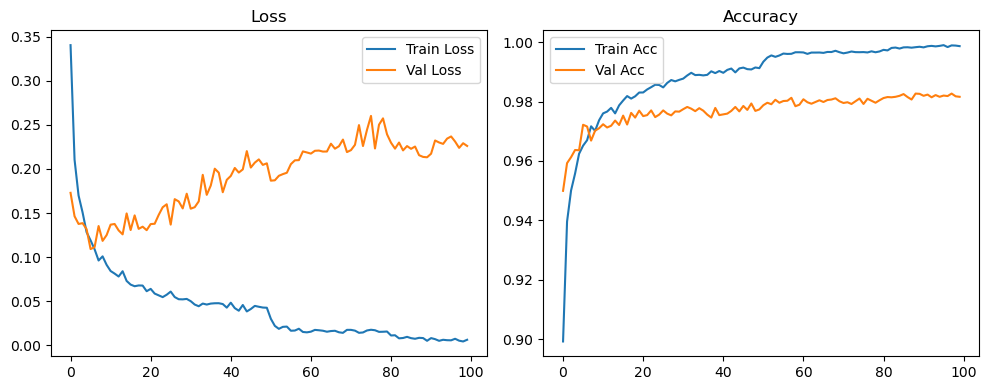

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2620, Acc: 0.9218 | Val Loss: 0.1758, Acc: 0.9502


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1250, Acc: 0.9624 | Val Loss: 0.1568, Acc: 0.9550


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0868, Acc: 0.9730 | Val Loss: 0.1402, Acc: 0.9611


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9791 | Val Loss: 0.1308, Acc: 0.9644


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9829 | Val Loss: 0.1264, Acc: 0.9692


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9869 | Val Loss: 0.1550, Acc: 0.9670


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9869 | Val Loss: 0.1412, Acc: 0.9674


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9887 | Val Loss: 0.1484, Acc: 0.9673


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9898 | Val Loss: 0.1475, Acc: 0.9702


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.1449, Acc: 0.9713


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9932 | Val Loss: 0.1424, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9936 | Val Loss: 0.1732, Acc: 0.9673


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9948 | Val Loss: 0.1611, Acc: 0.9720


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9939 | Val Loss: 0.1659, Acc: 0.9691


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9942 | Val Loss: 0.1515, Acc: 0.9737


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9945 | Val Loss: 0.1589, Acc: 0.9683


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9951 | Val Loss: 0.1524, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9948 | Val Loss: 0.1488, Acc: 0.9731


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9951 | Val Loss: 0.1549, Acc: 0.9731


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1569, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9960 | Val Loss: 0.1548, Acc: 0.9740


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1674, Acc: 0.9730


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1957, Acc: 0.9712


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9954 | Val Loss: 0.1651, Acc: 0.9744


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.1696, Acc: 0.9737


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9959 | Val Loss: 0.1703, Acc: 0.9732


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9966 | Val Loss: 0.1523, Acc: 0.9734


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.1695, Acc: 0.9758


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9972 | Val Loss: 0.1851, Acc: 0.9728


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9974 | Val Loss: 0.1604, Acc: 0.9759


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9968 | Val Loss: 0.1832, Acc: 0.9732


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9967 | Val Loss: 0.1545, Acc: 0.9755


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1613, Acc: 0.9749


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9974 | Val Loss: 0.1409, Acc: 0.9770


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1604, Acc: 0.9753


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1603, Acc: 0.9749


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.1865, Acc: 0.9738


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1875, Acc: 0.9732


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9974 | Val Loss: 0.1348, Acc: 0.9774


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1576, Acc: 0.9758


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1712, Acc: 0.9760


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9980 | Val Loss: 0.1581, Acc: 0.9756


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1561, Acc: 0.9769


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.1507, Acc: 0.9756


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.1494, Acc: 0.9760


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.1841, Acc: 0.9745


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9980 | Val Loss: 0.1555, Acc: 0.9763


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1469, Acc: 0.9772


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1583, Acc: 0.9766


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9985 | Val Loss: 0.1447, Acc: 0.9773


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1433, Acc: 0.9785


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1411, Acc: 0.9789


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1394, Acc: 0.9786


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1343, Acc: 0.9798


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1353, Acc: 0.9802


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1383, Acc: 0.9794


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1421, Acc: 0.9808


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1436, Acc: 0.9802


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1480, Acc: 0.9796


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1488, Acc: 0.9802


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1489, Acc: 0.9800


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1499, Acc: 0.9804


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1527, Acc: 0.9802


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1568, Acc: 0.9797


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1537, Acc: 0.9793


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1613, Acc: 0.9793


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1600, Acc: 0.9800


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1566, Acc: 0.9805


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1637, Acc: 0.9805


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1636, Acc: 0.9797


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1606, Acc: 0.9801


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1638, Acc: 0.9812


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1689, Acc: 0.9798


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1720, Acc: 0.9798


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1644, Acc: 0.9806


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1838, Acc: 0.9794


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1795, Acc: 0.9788


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1684, Acc: 0.9802


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1717, Acc: 0.9795


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1910, Acc: 0.9787


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1816, Acc: 0.9794


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1775, Acc: 0.9801


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1794, Acc: 0.9798


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1775, Acc: 0.9805


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1791, Acc: 0.9807


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1745, Acc: 0.9796


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1790, Acc: 0.9794


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1712, Acc: 0.9790


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1723, Acc: 0.9800


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1747, Acc: 0.9796


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1781, Acc: 0.9808


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1809, Acc: 0.9798


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1750, Acc: 0.9804


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1736, Acc: 0.9807


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1747, Acc: 0.9804


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1790, Acc: 0.9802


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1861, Acc: 0.9800


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1902, Acc: 0.9797


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1871, Acc: 0.9795


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1922, Acc: 0.9798


Final Test Loss: 0.1897 Accuracy: 0.9817


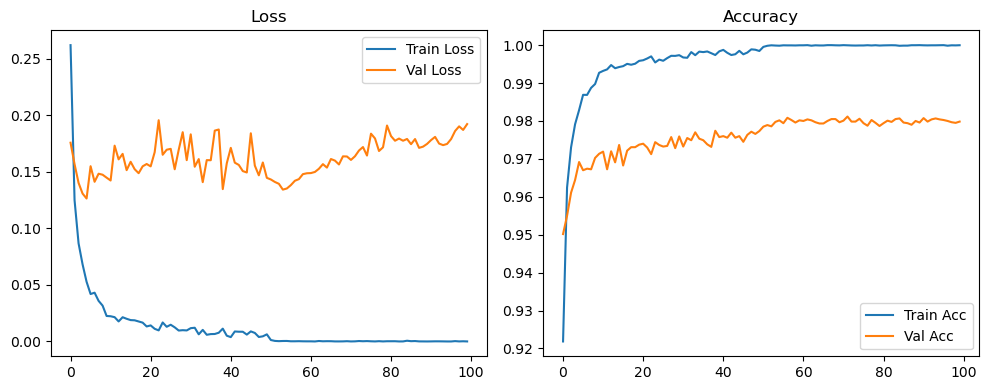

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2811, Acc: 0.9171 | Val Loss: 0.1963, Acc: 0.9444


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1445, Acc: 0.9568 | Val Loss: 0.1580, Acc: 0.9582


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1078, Acc: 0.9673 | Val Loss: 0.1295, Acc: 0.9628


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0828, Acc: 0.9742 | Val Loss: 0.1423, Acc: 0.9601


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0697, Acc: 0.9782 | Val Loss: 0.1127, Acc: 0.9714


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9794 | Val Loss: 0.1276, Acc: 0.9669


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9821 | Val Loss: 0.1248, Acc: 0.9691


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9864 | Val Loss: 0.1442, Acc: 0.9692


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9858 | Val Loss: 0.1320, Acc: 0.9698


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9881 | Val Loss: 0.1298, Acc: 0.9728


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9881 | Val Loss: 0.1442, Acc: 0.9697


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9882 | Val Loss: 0.1453, Acc: 0.9697


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9906 | Val Loss: 0.1410, Acc: 0.9729


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9908 | Val Loss: 0.1385, Acc: 0.9724


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9914 | Val Loss: 0.1374, Acc: 0.9743


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9907 | Val Loss: 0.1562, Acc: 0.9737


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9916 | Val Loss: 0.1582, Acc: 0.9718


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9912 | Val Loss: 0.1513, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9926 | Val Loss: 0.1449, Acc: 0.9746


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9931 | Val Loss: 0.1472, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9930 | Val Loss: 0.1687, Acc: 0.9752


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9932 | Val Loss: 0.1741, Acc: 0.9736


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9939 | Val Loss: 0.1566, Acc: 0.9750


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9939 | Val Loss: 0.1936, Acc: 0.9736


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9936 | Val Loss: 0.1715, Acc: 0.9747


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9939 | Val Loss: 0.1591, Acc: 0.9755


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9939 | Val Loss: 0.1673, Acc: 0.9759


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9943 | Val Loss: 0.1863, Acc: 0.9758


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9941 | Val Loss: 0.1557, Acc: 0.9746


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9948 | Val Loss: 0.1555, Acc: 0.9773


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9958 | Val Loss: 0.1962, Acc: 0.9766


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9959 | Val Loss: 0.1761, Acc: 0.9768


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9960 | Val Loss: 0.1959, Acc: 0.9738


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9940 | Val Loss: 0.1818, Acc: 0.9752


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9960 | Val Loss: 0.1960, Acc: 0.9751


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9949 | Val Loss: 0.1976, Acc: 0.9758


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9951 | Val Loss: 0.2030, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9950 | Val Loss: 0.1576, Acc: 0.9758


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9958 | Val Loss: 0.1833, Acc: 0.9760


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9966 | Val Loss: 0.1888, Acc: 0.9774


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9961 | Val Loss: 0.1927, Acc: 0.9753


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9969 | Val Loss: 0.2238, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9969 | Val Loss: 0.2311, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9966 | Val Loss: 0.1972, Acc: 0.9769


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9965 | Val Loss: 0.2339, Acc: 0.9752


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9963 | Val Loss: 0.2067, Acc: 0.9776


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9961 | Val Loss: 0.2324, Acc: 0.9750


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9965 | Val Loss: 0.2161, Acc: 0.9768


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9968 | Val Loss: 0.2151, Acc: 0.9770


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9964 | Val Loss: 0.2427, Acc: 0.9742


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9981 | Val Loss: 0.1959, Acc: 0.9780


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1938, Acc: 0.9777


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1923, Acc: 0.9790


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1934, Acc: 0.9789


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1931, Acc: 0.9799


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1912, Acc: 0.9792


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.1922, Acc: 0.9797


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1959, Acc: 0.9795


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.1949, Acc: 0.9808


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1962, Acc: 0.9804


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1893, Acc: 0.9820


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1995, Acc: 0.9814


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1943, Acc: 0.9803


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.2053, Acc: 0.9808


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2020, Acc: 0.9809


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.2000, Acc: 0.9798


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1999, Acc: 0.9812


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1921, Acc: 0.9818


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.2150, Acc: 0.9808


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2053, Acc: 0.9810


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.2151, Acc: 0.9808


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.2126, Acc: 0.9822


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2010, Acc: 0.9822


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2052, Acc: 0.9825


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.2161, Acc: 0.9811


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.2192, Acc: 0.9811


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.2145, Acc: 0.9809


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.2096, Acc: 0.9809


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2103, Acc: 0.9812


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2040, Acc: 0.9822


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2050, Acc: 0.9811


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.2129, Acc: 0.9815


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2163, Acc: 0.9816


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2181, Acc: 0.9816


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2125, Acc: 0.9819


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2143, Acc: 0.9818


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2199, Acc: 0.9822


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2105, Acc: 0.9828


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2080, Acc: 0.9827


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.2186, Acc: 0.9820


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.2067, Acc: 0.9823


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2161, Acc: 0.9820


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9999 | Val Loss: 0.2098, Acc: 0.9822


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2150, Acc: 0.9815


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2083, Acc: 0.9828


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2197, Acc: 0.9818


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2089, Acc: 0.9818


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.2076, Acc: 0.9821


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2209, Acc: 0.9822


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2133, Acc: 0.9826


Final Test Loss: 0.1970 Accuracy: 0.9833


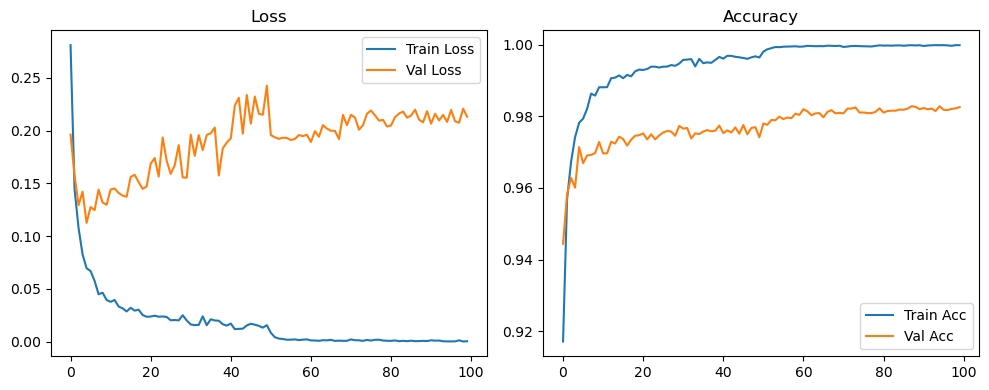

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3406, Acc: 0.8992 | Val Loss: 0.1729, Acc: 0.9499


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2105, Acc: 0.9396 | Val Loss: 0.1463, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1699, Acc: 0.9500 | Val Loss: 0.1376, Acc: 0.9613


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1507, Acc: 0.9557 | Val Loss: 0.1385, Acc: 0.9637


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1283, Acc: 0.9624 | Val Loss: 0.1317, Acc: 0.9636


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1189, Acc: 0.9651 | Val Loss: 0.1090, Acc: 0.9722


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1088, Acc: 0.9670 | Val Loss: 0.1112, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0961, Acc: 0.9716 | Val Loss: 0.1352, Acc: 0.9668


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1008, Acc: 0.9701 | Val Loss: 0.1184, Acc: 0.9702


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0911, Acc: 0.9737 | Val Loss: 0.1249, Acc: 0.9710


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0841, Acc: 0.9760 | Val Loss: 0.1368, Acc: 0.9723


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0812, Acc: 0.9766 | Val Loss: 0.1376, Acc: 0.9712


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0779, Acc: 0.9779 | Val Loss: 0.1303, Acc: 0.9718


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9760 | Val Loss: 0.1258, Acc: 0.9736


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9787 | Val Loss: 0.1495, Acc: 0.9721


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9803 | Val Loss: 0.1307, Acc: 0.9752


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9818 | Val Loss: 0.1473, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0677, Acc: 0.9810 | Val Loss: 0.1320, Acc: 0.9762


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9818 | Val Loss: 0.1345, Acc: 0.9746


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9830 | Val Loss: 0.1305, Acc: 0.9769


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9830 | Val Loss: 0.1374, Acc: 0.9751


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9841 | Val Loss: 0.1378, Acc: 0.9754


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9848 | Val Loss: 0.1478, Acc: 0.9770


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9856 | Val Loss: 0.1565, Acc: 0.9748


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9856 | Val Loss: 0.1599, Acc: 0.9756


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9848 | Val Loss: 0.1368, Acc: 0.9770


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9862 | Val Loss: 0.1657, Acc: 0.9759


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9872 | Val Loss: 0.1632, Acc: 0.9753


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9868 | Val Loss: 0.1552, Acc: 0.9767


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9873 | Val Loss: 0.1719, Acc: 0.9766


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9877 | Val Loss: 0.1549, Acc: 0.9774


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9888 | Val Loss: 0.1566, Acc: 0.9782


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9897 | Val Loss: 0.1632, Acc: 0.9776


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9889 | Val Loss: 0.1934, Acc: 0.9768


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9890 | Val Loss: 0.1706, Acc: 0.9778


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9888 | Val Loss: 0.1811, Acc: 0.9769


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9890 | Val Loss: 0.2003, Acc: 0.9756


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9902 | Val Loss: 0.1957, Acc: 0.9746


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9896 | Val Loss: 0.1736, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9903 | Val Loss: 0.1877, Acc: 0.9754


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9897 | Val Loss: 0.1921, Acc: 0.9757


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9906 | Val Loss: 0.2012, Acc: 0.9759


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9911 | Val Loss: 0.1959, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9898 | Val Loss: 0.1995, Acc: 0.9782


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9911 | Val Loss: 0.2203, Acc: 0.9767


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9914 | Val Loss: 0.2016, Acc: 0.9785


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9909 | Val Loss: 0.2072, Acc: 0.9772


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9908 | Val Loss: 0.2109, Acc: 0.9793


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9915 | Val Loss: 0.2046, Acc: 0.9768


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9912 | Val Loss: 0.2065, Acc: 0.9773


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9934 | Val Loss: 0.1793, Acc: 0.9801


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9952 | Val Loss: 0.1727, Acc: 0.9799


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9958 | Val Loss: 0.1762, Acc: 0.9808


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9960 | Val Loss: 0.1705, Acc: 0.9809


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9955 | Val Loss: 0.1698, Acc: 0.9809


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9963 | Val Loss: 0.1709, Acc: 0.9804


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9966 | Val Loss: 0.1702, Acc: 0.9794


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9971 | Val Loss: 0.1849, Acc: 0.9796


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9969 | Val Loss: 0.1919, Acc: 0.9795


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9974 | Val Loss: 0.1911, Acc: 0.9802


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9973 | Val Loss: 0.2003, Acc: 0.9795


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9976 | Val Loss: 0.1985, Acc: 0.9803


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9970 | Val Loss: 0.1938, Acc: 0.9802


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9979 | Val Loss: 0.1921, Acc: 0.9812


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9976 | Val Loss: 0.1975, Acc: 0.9811


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.2028, Acc: 0.9805


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.2104, Acc: 0.9801


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9979 | Val Loss: 0.2094, Acc: 0.9805


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.2134, Acc: 0.9806


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9981 | Val Loss: 0.2110, Acc: 0.9801


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.2155, Acc: 0.9809


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9981 | Val Loss: 0.2024, Acc: 0.9814


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9980 | Val Loss: 0.2095, Acc: 0.9807


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.2087, Acc: 0.9822


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.2139, Acc: 0.9809


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9979 | Val Loss: 0.2236, Acc: 0.9813


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9982 | Val Loss: 0.2133, Acc: 0.9811


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9981 | Val Loss: 0.2111, Acc: 0.9822


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9982 | Val Loss: 0.2149, Acc: 0.9802


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9982 | Val Loss: 0.2122, Acc: 0.9805


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.2077, Acc: 0.9811


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.2117, Acc: 0.9818


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9987 | Val Loss: 0.2106, Acc: 0.9810


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.2077, Acc: 0.9811


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9988 | Val Loss: 0.2086, Acc: 0.9803


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9984 | Val Loss: 0.2107, Acc: 0.9816


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9983 | Val Loss: 0.2083, Acc: 0.9813


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9986 | Val Loss: 0.2119, Acc: 0.9815


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.2052, Acc: 0.9812


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.2033, Acc: 0.9812


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.2034, Acc: 0.9818


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9986 | Val Loss: 0.2104, Acc: 0.9812


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.2113, Acc: 0.9813


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.2208, Acc: 0.9820


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.2197, Acc: 0.9809


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.2174, Acc: 0.9816


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.2180, Acc: 0.9813


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.2134, Acc: 0.9817


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.2148, Acc: 0.9812


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.2077, Acc: 0.9817


Final Test Loss: 0.1869 Accuracy: 0.9834


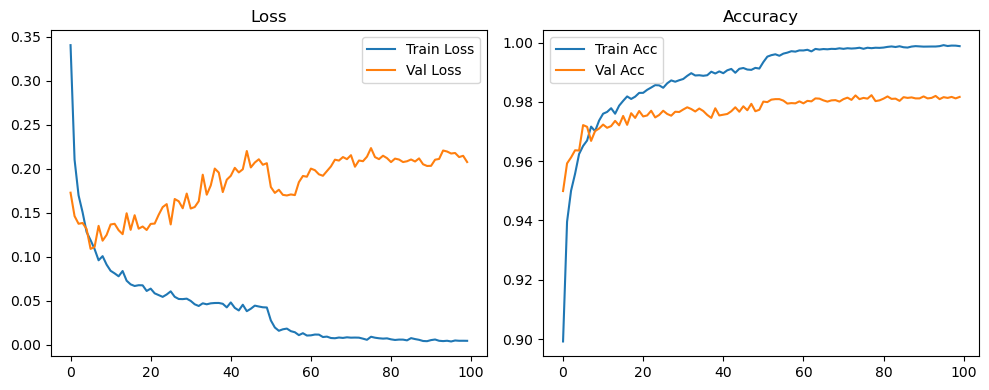

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2343, Acc: 0.9289 | Val Loss: 0.1635, Acc: 0.9526


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1139, Acc: 0.9653 | Val Loss: 0.1402, Acc: 0.9603


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0767, Acc: 0.9756 | Val Loss: 0.1262, Acc: 0.9666


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0583, Acc: 0.9818 | Val Loss: 0.1289, Acc: 0.9664


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9840 | Val Loss: 0.1230, Acc: 0.9681


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9875 | Val Loss: 0.1295, Acc: 0.9678


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9878 | Val Loss: 0.1156, Acc: 0.9706


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9913 | Val Loss: 0.1408, Acc: 0.9678


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9907 | Val Loss: 0.1295, Acc: 0.9736


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.1400, Acc: 0.9700


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9928 | Val Loss: 0.1414, Acc: 0.9709


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9942 | Val Loss: 0.1395, Acc: 0.9709


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.1538, Acc: 0.9697


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.1406, Acc: 0.9707


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9936 | Val Loss: 0.1369, Acc: 0.9725


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9953 | Val Loss: 0.1302, Acc: 0.9745


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9950 | Val Loss: 0.1378, Acc: 0.9743


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.1422, Acc: 0.9734


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.1314, Acc: 0.9756


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.1436, Acc: 0.9738


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1475, Acc: 0.9720


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9956 | Val Loss: 0.1377, Acc: 0.9751


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9966 | Val Loss: 0.1442, Acc: 0.9735


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.1344, Acc: 0.9748


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9967 | Val Loss: 0.1467, Acc: 0.9743


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9960 | Val Loss: 0.1462, Acc: 0.9735


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9973 | Val Loss: 0.1415, Acc: 0.9756


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.1601, Acc: 0.9750


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9979 | Val Loss: 0.1589, Acc: 0.9719


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9974 | Val Loss: 0.1603, Acc: 0.9745


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9974 | Val Loss: 0.1610, Acc: 0.9744


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9966 | Val Loss: 0.1664, Acc: 0.9736


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.1519, Acc: 0.9768


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.1621, Acc: 0.9747


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9974 | Val Loss: 0.1416, Acc: 0.9771


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1738, Acc: 0.9730


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1512, Acc: 0.9761


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1528, Acc: 0.9759


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1604, Acc: 0.9742


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1531, Acc: 0.9746


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1595, Acc: 0.9739


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1772, Acc: 0.9737


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1497, Acc: 0.9768


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.1704, Acc: 0.9748


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1542, Acc: 0.9766


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1694, Acc: 0.9760


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9974 | Val Loss: 0.1729, Acc: 0.9762


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9981 | Val Loss: 0.1773, Acc: 0.9744


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1481, Acc: 0.9774


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1508, Acc: 0.9777


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1552, Acc: 0.9768


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1492, Acc: 0.9776


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.1673, Acc: 0.9781


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.1619, Acc: 0.9758


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9987 | Val Loss: 0.1530, Acc: 0.9778


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1740, Acc: 0.9768


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1641, Acc: 0.9776


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1932, Acc: 0.9744


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9986 | Val Loss: 0.1756, Acc: 0.9752


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1630, Acc: 0.9772


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1807, Acc: 0.9749


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1709, Acc: 0.9766


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1493, Acc: 0.9786


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1651, Acc: 0.9770


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1659, Acc: 0.9786


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9994 | Val Loss: 0.1636, Acc: 0.9776


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1727, Acc: 0.9777


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1681, Acc: 0.9768


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.1734, Acc: 0.9770


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1685, Acc: 0.9777


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1796, Acc: 0.9762


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1820, Acc: 0.9781


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1654, Acc: 0.9773


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1704, Acc: 0.9762


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1719, Acc: 0.9762


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9991 | Val Loss: 0.1597, Acc: 0.9777


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1691, Acc: 0.9792


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1587, Acc: 0.9772


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1828, Acc: 0.9754


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1811, Acc: 0.9788


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9988 | Val Loss: 0.1723, Acc: 0.9752


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1755, Acc: 0.9761


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1706, Acc: 0.9791


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9990 | Val Loss: 0.1581, Acc: 0.9786


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1631, Acc: 0.9778


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9993 | Val Loss: 0.1698, Acc: 0.9787


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9994 | Val Loss: 0.1742, Acc: 0.9769


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.1816, Acc: 0.9767


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9990 | Val Loss: 0.1638, Acc: 0.9768


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.1531, Acc: 0.9790


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1752, Acc: 0.9768


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1686, Acc: 0.9758


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1915, Acc: 0.9747


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1811, Acc: 0.9760


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1599, Acc: 0.9777


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1679, Acc: 0.9768


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1789, Acc: 0.9773


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1662, Acc: 0.9769


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1813, Acc: 0.9762


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1743, Acc: 0.9775


Final Test Loss: 0.1681 Accuracy: 0.9759


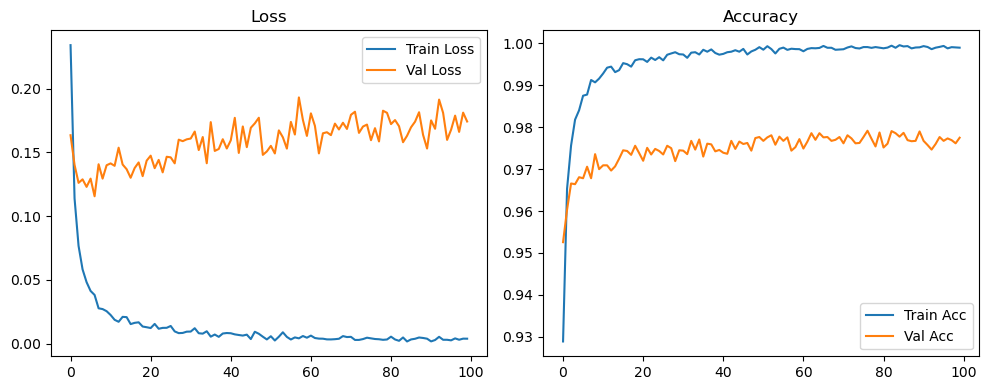

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2510, Acc: 0.9229 | Val Loss: 0.1629, Acc: 0.9511


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1321, Acc: 0.9594 | Val Loss: 0.1486, Acc: 0.9577


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0938, Acc: 0.9710 | Val Loss: 0.1356, Acc: 0.9604


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0759, Acc: 0.9763 | Val Loss: 0.1337, Acc: 0.9633


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0637, Acc: 0.9797 | Val Loss: 0.1086, Acc: 0.9705


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9822 | Val Loss: 0.1218, Acc: 0.9702


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9834 | Val Loss: 0.1237, Acc: 0.9699


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9859 | Val Loss: 0.1365, Acc: 0.9672


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9888 | Val Loss: 0.1187, Acc: 0.9718


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9871 | Val Loss: 0.1102, Acc: 0.9716


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9891 | Val Loss: 0.1185, Acc: 0.9730


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9910 | Val Loss: 0.1210, Acc: 0.9714


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9906 | Val Loss: 0.1216, Acc: 0.9724


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.1307, Acc: 0.9749


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9909 | Val Loss: 0.1254, Acc: 0.9732


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.1432, Acc: 0.9724


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9922 | Val Loss: 0.1389, Acc: 0.9730


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9930 | Val Loss: 0.1295, Acc: 0.9745


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.1431, Acc: 0.9722


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9931 | Val Loss: 0.1272, Acc: 0.9743


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9938 | Val Loss: 0.1464, Acc: 0.9730


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.1597, Acc: 0.9722


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.1514, Acc: 0.9723


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9940 | Val Loss: 0.1317, Acc: 0.9755


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9950 | Val Loss: 0.1378, Acc: 0.9768


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9956 | Val Loss: 0.1478, Acc: 0.9756


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.1397, Acc: 0.9745


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.1381, Acc: 0.9758


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9951 | Val Loss: 0.1475, Acc: 0.9742


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9953 | Val Loss: 0.1482, Acc: 0.9759


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9950 | Val Loss: 0.1638, Acc: 0.9745


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9957 | Val Loss: 0.1356, Acc: 0.9753


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9962 | Val Loss: 0.1563, Acc: 0.9742


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.1441, Acc: 0.9772


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.1554, Acc: 0.9762


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9951 | Val Loss: 0.1722, Acc: 0.9737


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9959 | Val Loss: 0.1561, Acc: 0.9748


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1635, Acc: 0.9756


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9958 | Val Loss: 0.1632, Acc: 0.9752


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1613, Acc: 0.9764


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9968 | Val Loss: 0.1676, Acc: 0.9767


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.1595, Acc: 0.9772


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9976 | Val Loss: 0.1693, Acc: 0.9778


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.1736, Acc: 0.9781


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9960 | Val Loss: 0.1854, Acc: 0.9754


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9968 | Val Loss: 0.1877, Acc: 0.9755


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9973 | Val Loss: 0.1634, Acc: 0.9775


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1667, Acc: 0.9774


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9965 | Val Loss: 0.1628, Acc: 0.9768


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9973 | Val Loss: 0.1674, Acc: 0.9781


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1666, Acc: 0.9768


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.1740, Acc: 0.9758


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9971 | Val Loss: 0.1727, Acc: 0.9768


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1972, Acc: 0.9751


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9974 | Val Loss: 0.1878, Acc: 0.9758


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9971 | Val Loss: 0.1684, Acc: 0.9782


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.1679, Acc: 0.9790


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1981, Acc: 0.9762


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.2119, Acc: 0.9757


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9978 | Val Loss: 0.2031, Acc: 0.9758


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9972 | Val Loss: 0.1702, Acc: 0.9770


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9975 | Val Loss: 0.1964, Acc: 0.9770


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9975 | Val Loss: 0.1711, Acc: 0.9768


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.1770, Acc: 0.9780


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1846, Acc: 0.9782


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1894, Acc: 0.9768


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9973 | Val Loss: 0.1921, Acc: 0.9780


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.1666, Acc: 0.9789


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1872, Acc: 0.9786


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9973 | Val Loss: 0.1944, Acc: 0.9772


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9977 | Val Loss: 0.1854, Acc: 0.9788


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.1968, Acc: 0.9778


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.1863, Acc: 0.9774


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1867, Acc: 0.9782


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9981 | Val Loss: 0.1981, Acc: 0.9778


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.2014, Acc: 0.9772


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9981 | Val Loss: 0.1930, Acc: 0.9772


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9980 | Val Loss: 0.1975, Acc: 0.9768


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.2117, Acc: 0.9768


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.2137, Acc: 0.9772


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.2120, Acc: 0.9776


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9982 | Val Loss: 0.2140, Acc: 0.9780


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9979 | Val Loss: 0.2298, Acc: 0.9754


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9981 | Val Loss: 0.2259, Acc: 0.9772


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9985 | Val Loss: 0.2353, Acc: 0.9766


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9979 | Val Loss: 0.1921, Acc: 0.9788


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9988 | Val Loss: 0.1826, Acc: 0.9802


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9981 | Val Loss: 0.2155, Acc: 0.9775


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9982 | Val Loss: 0.2199, Acc: 0.9768


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9982 | Val Loss: 0.2074, Acc: 0.9773


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.2168, Acc: 0.9781


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.2255, Acc: 0.9787


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9986 | Val Loss: 0.2033, Acc: 0.9785


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9985 | Val Loss: 0.2095, Acc: 0.9770


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9984 | Val Loss: 0.2172, Acc: 0.9773


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.2118, Acc: 0.9788


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9981 | Val Loss: 0.2205, Acc: 0.9764


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.2189, Acc: 0.9763


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9986 | Val Loss: 0.2175, Acc: 0.9774


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9989 | Val Loss: 0.2094, Acc: 0.9795


Final Test Loss: 0.1930 Accuracy: 0.9804


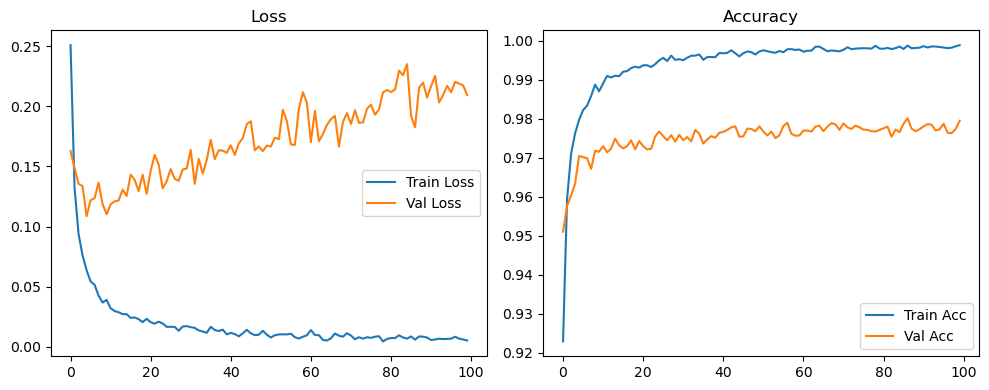

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3068, Acc: 0.9076 | Val Loss: 0.1523, Acc: 0.9553


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1832, Acc: 0.9467 | Val Loss: 0.1393, Acc: 0.9577


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1509, Acc: 0.9545 | Val Loss: 0.1221, Acc: 0.9624


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1298, Acc: 0.9599 | Val Loss: 0.1207, Acc: 0.9656


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1144, Acc: 0.9651 | Val Loss: 0.1095, Acc: 0.9672


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1022, Acc: 0.9685 | Val Loss: 0.1094, Acc: 0.9677


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0937, Acc: 0.9715 | Val Loss: 0.1082, Acc: 0.9702


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0862, Acc: 0.9726 | Val Loss: 0.1092, Acc: 0.9719


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0809, Acc: 0.9745 | Val Loss: 0.1091, Acc: 0.9735


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0774, Acc: 0.9761 | Val Loss: 0.1029, Acc: 0.9727


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0755, Acc: 0.9761 | Val Loss: 0.1035, Acc: 0.9740


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0696, Acc: 0.9779 | Val Loss: 0.1044, Acc: 0.9743


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0675, Acc: 0.9787 | Val Loss: 0.1058, Acc: 0.9729


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0627, Acc: 0.9798 | Val Loss: 0.1082, Acc: 0.9748


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9806 | Val Loss: 0.1153, Acc: 0.9739


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9830 | Val Loss: 0.1062, Acc: 0.9748


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9837 | Val Loss: 0.1250, Acc: 0.9742


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9829 | Val Loss: 0.1134, Acc: 0.9760


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9847 | Val Loss: 0.1160, Acc: 0.9763


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9855 | Val Loss: 0.1128, Acc: 0.9758


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9848 | Val Loss: 0.1265, Acc: 0.9758


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9855 | Val Loss: 0.1239, Acc: 0.9756


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9855 | Val Loss: 0.1267, Acc: 0.9752


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9872 | Val Loss: 0.1194, Acc: 0.9772


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9875 | Val Loss: 0.1212, Acc: 0.9767


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9869 | Val Loss: 0.1340, Acc: 0.9748


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9880 | Val Loss: 0.1320, Acc: 0.9747


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9886 | Val Loss: 0.1431, Acc: 0.9741


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9872 | Val Loss: 0.1360, Acc: 0.9748


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9886 | Val Loss: 0.1410, Acc: 0.9748


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9889 | Val Loss: 0.1378, Acc: 0.9762


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9898 | Val Loss: 0.1325, Acc: 0.9762


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9900 | Val Loss: 0.1462, Acc: 0.9753


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9890 | Val Loss: 0.1409, Acc: 0.9770


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9899 | Val Loss: 0.1563, Acc: 0.9759


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9901 | Val Loss: 0.1471, Acc: 0.9765


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9909 | Val Loss: 0.1493, Acc: 0.9777


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9905 | Val Loss: 0.1435, Acc: 0.9774


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9909 | Val Loss: 0.1388, Acc: 0.9770


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9918 | Val Loss: 0.1540, Acc: 0.9766


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9902 | Val Loss: 0.1416, Acc: 0.9761


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9914 | Val Loss: 0.1357, Acc: 0.9781


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9920 | Val Loss: 0.1478, Acc: 0.9775


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9913 | Val Loss: 0.1546, Acc: 0.9779


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9915 | Val Loss: 0.1521, Acc: 0.9775


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9928 | Val Loss: 0.1624, Acc: 0.9772


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9925 | Val Loss: 0.1631, Acc: 0.9764


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9921 | Val Loss: 0.1537, Acc: 0.9787


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9919 | Val Loss: 0.1613, Acc: 0.9761


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9922 | Val Loss: 0.1413, Acc: 0.9785


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9925 | Val Loss: 0.1550, Acc: 0.9784


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9933 | Val Loss: 0.1649, Acc: 0.9775


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9934 | Val Loss: 0.1545, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9940 | Val Loss: 0.1563, Acc: 0.9810


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9927 | Val Loss: 0.1574, Acc: 0.9792


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9926 | Val Loss: 0.1718, Acc: 0.9777


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9935 | Val Loss: 0.1888, Acc: 0.9771


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9934 | Val Loss: 0.1702, Acc: 0.9780


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9936 | Val Loss: 0.1789, Acc: 0.9772


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9934 | Val Loss: 0.1581, Acc: 0.9786


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9929 | Val Loss: 0.1631, Acc: 0.9785


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9929 | Val Loss: 0.1653, Acc: 0.9785


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9929 | Val Loss: 0.1732, Acc: 0.9782


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9938 | Val Loss: 0.1665, Acc: 0.9773


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9940 | Val Loss: 0.1851, Acc: 0.9788


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9946 | Val Loss: 0.1936, Acc: 0.9785


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9932 | Val Loss: 0.1711, Acc: 0.9802


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9948 | Val Loss: 0.1804, Acc: 0.9783


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9940 | Val Loss: 0.1734, Acc: 0.9784


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9941 | Val Loss: 0.1909, Acc: 0.9777


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9948 | Val Loss: 0.1922, Acc: 0.9789


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9944 | Val Loss: 0.1975, Acc: 0.9771


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9945 | Val Loss: 0.1853, Acc: 0.9783


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9941 | Val Loss: 0.1882, Acc: 0.9769


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9943 | Val Loss: 0.1848, Acc: 0.9788


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9948 | Val Loss: 0.1947, Acc: 0.9779


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9946 | Val Loss: 0.1830, Acc: 0.9786


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9950 | Val Loss: 0.1887, Acc: 0.9792


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9950 | Val Loss: 0.2098, Acc: 0.9773


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9942 | Val Loss: 0.1940, Acc: 0.9782


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9943 | Val Loss: 0.1853, Acc: 0.9803


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9944 | Val Loss: 0.1708, Acc: 0.9805


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9952 | Val Loss: 0.1773, Acc: 0.9809


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9947 | Val Loss: 0.1905, Acc: 0.9788


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9952 | Val Loss: 0.2007, Acc: 0.9788


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9953 | Val Loss: 0.1931, Acc: 0.9785


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9950 | Val Loss: 0.2063, Acc: 0.9796


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9958 | Val Loss: 0.1856, Acc: 0.9801


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9958 | Val Loss: 0.1969, Acc: 0.9812


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9947 | Val Loss: 0.2259, Acc: 0.9772


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9954 | Val Loss: 0.2231, Acc: 0.9781


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9953 | Val Loss: 0.1951, Acc: 0.9804


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9960 | Val Loss: 0.2013, Acc: 0.9802


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9958 | Val Loss: 0.1963, Acc: 0.9801


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9950 | Val Loss: 0.1970, Acc: 0.9784


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9954 | Val Loss: 0.2149, Acc: 0.9790


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9944 | Val Loss: 0.2050, Acc: 0.9798


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9955 | Val Loss: 0.2001, Acc: 0.9795


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9954 | Val Loss: 0.2106, Acc: 0.9785


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9958 | Val Loss: 0.1998, Acc: 0.9798


Final Test Loss: 0.1770 Accuracy: 0.9816


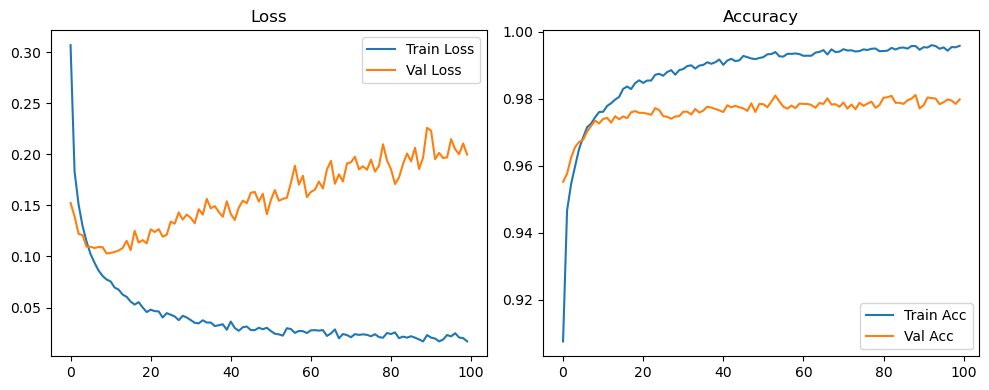

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2343, Acc: 0.9289 | Val Loss: 0.1635, Acc: 0.9526


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1139, Acc: 0.9653 | Val Loss: 0.1402, Acc: 0.9603


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0767, Acc: 0.9756 | Val Loss: 0.1262, Acc: 0.9666


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0583, Acc: 0.9818 | Val Loss: 0.1289, Acc: 0.9664


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9840 | Val Loss: 0.1230, Acc: 0.9681


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9875 | Val Loss: 0.1295, Acc: 0.9678


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9878 | Val Loss: 0.1156, Acc: 0.9706


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9913 | Val Loss: 0.1408, Acc: 0.9678


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9907 | Val Loss: 0.1295, Acc: 0.9736


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.1400, Acc: 0.9700


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9928 | Val Loss: 0.1414, Acc: 0.9709


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9942 | Val Loss: 0.1395, Acc: 0.9709


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.1538, Acc: 0.9697


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.1406, Acc: 0.9707


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9936 | Val Loss: 0.1369, Acc: 0.9725


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9953 | Val Loss: 0.1302, Acc: 0.9745


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9950 | Val Loss: 0.1378, Acc: 0.9743


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.1422, Acc: 0.9734


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.1314, Acc: 0.9756


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.1436, Acc: 0.9738


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1475, Acc: 0.9720


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9956 | Val Loss: 0.1377, Acc: 0.9751


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9966 | Val Loss: 0.1442, Acc: 0.9735


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.1344, Acc: 0.9748


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9967 | Val Loss: 0.1467, Acc: 0.9743


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9960 | Val Loss: 0.1462, Acc: 0.9735


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9973 | Val Loss: 0.1415, Acc: 0.9756


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.1601, Acc: 0.9750


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9979 | Val Loss: 0.1589, Acc: 0.9719


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9974 | Val Loss: 0.1603, Acc: 0.9745


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9974 | Val Loss: 0.1610, Acc: 0.9744


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9966 | Val Loss: 0.1664, Acc: 0.9736


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.1519, Acc: 0.9768


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.1621, Acc: 0.9747


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9974 | Val Loss: 0.1416, Acc: 0.9771


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1738, Acc: 0.9730


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1512, Acc: 0.9761


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1528, Acc: 0.9759


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1604, Acc: 0.9742


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1531, Acc: 0.9746


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1595, Acc: 0.9739


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1772, Acc: 0.9737


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1497, Acc: 0.9768


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.1704, Acc: 0.9748


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1542, Acc: 0.9766


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1694, Acc: 0.9760


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9974 | Val Loss: 0.1729, Acc: 0.9762


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9981 | Val Loss: 0.1773, Acc: 0.9744


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1481, Acc: 0.9774


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1508, Acc: 0.9777


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1420, Acc: 0.9781


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1455, Acc: 0.9784


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1503, Acc: 0.9794


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1450, Acc: 0.9795


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1425, Acc: 0.9799


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1512, Acc: 0.9796


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1495, Acc: 0.9791


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1483, Acc: 0.9791


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1539, Acc: 0.9795


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1523, Acc: 0.9794


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1598, Acc: 0.9788


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1655, Acc: 0.9788


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1674, Acc: 0.9782


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1635, Acc: 0.9774


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1693, Acc: 0.9785


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1729, Acc: 0.9794


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9997 | Val Loss: 0.1687, Acc: 0.9796


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1691, Acc: 0.9792


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1645, Acc: 0.9790


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1785, Acc: 0.9780


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1755, Acc: 0.9768


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1787, Acc: 0.9760


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1775, Acc: 0.9789


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1551, Acc: 0.9797


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1754, Acc: 0.9779


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9998 | Val Loss: 0.1679, Acc: 0.9783


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1677, Acc: 0.9792


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1810, Acc: 0.9773


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9997 | Val Loss: 0.1741, Acc: 0.9792


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1752, Acc: 0.9788


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1711, Acc: 0.9793


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1671, Acc: 0.9798


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1655, Acc: 0.9808


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1731, Acc: 0.9803


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1724, Acc: 0.9790


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1664, Acc: 0.9797


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1760, Acc: 0.9784


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1714, Acc: 0.9800


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1783, Acc: 0.9796


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1753, Acc: 0.9798


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1781, Acc: 0.9805


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1863, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1778, Acc: 0.9802


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1703, Acc: 0.9807


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1791, Acc: 0.9808


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1835, Acc: 0.9804


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1759, Acc: 0.9803


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1814, Acc: 0.9802


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1839, Acc: 0.9802


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1822, Acc: 0.9802


Final Test Loss: 0.1546 Accuracy: 0.9815


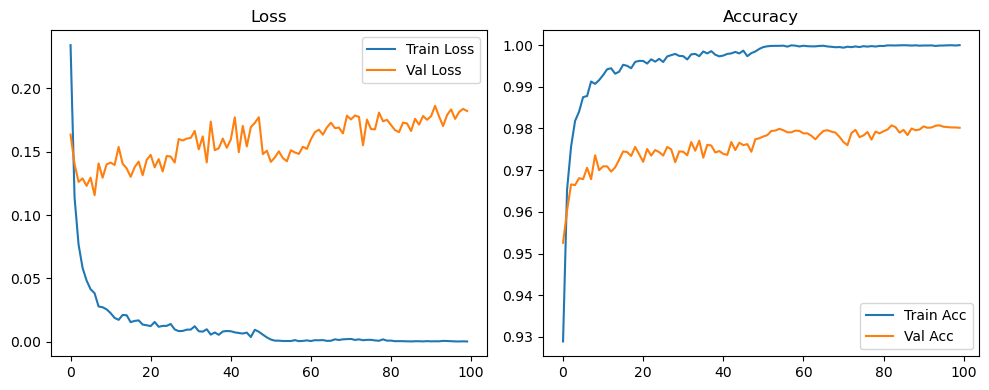

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2510, Acc: 0.9229 | Val Loss: 0.1629, Acc: 0.9511


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1321, Acc: 0.9594 | Val Loss: 0.1486, Acc: 0.9577


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0938, Acc: 0.9710 | Val Loss: 0.1356, Acc: 0.9604


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0759, Acc: 0.9763 | Val Loss: 0.1337, Acc: 0.9633


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0637, Acc: 0.9797 | Val Loss: 0.1086, Acc: 0.9705


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9822 | Val Loss: 0.1218, Acc: 0.9702


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9834 | Val Loss: 0.1237, Acc: 0.9699


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9859 | Val Loss: 0.1365, Acc: 0.9672


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9888 | Val Loss: 0.1187, Acc: 0.9718


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9871 | Val Loss: 0.1102, Acc: 0.9716


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9891 | Val Loss: 0.1185, Acc: 0.9730


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9910 | Val Loss: 0.1210, Acc: 0.9714


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9906 | Val Loss: 0.1216, Acc: 0.9724


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.1307, Acc: 0.9749


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9909 | Val Loss: 0.1254, Acc: 0.9732


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.1432, Acc: 0.9724


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9922 | Val Loss: 0.1389, Acc: 0.9730


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9930 | Val Loss: 0.1295, Acc: 0.9745


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.1431, Acc: 0.9722


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9931 | Val Loss: 0.1272, Acc: 0.9743


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9938 | Val Loss: 0.1464, Acc: 0.9730


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.1597, Acc: 0.9722


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.1514, Acc: 0.9723


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9940 | Val Loss: 0.1317, Acc: 0.9755


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9950 | Val Loss: 0.1378, Acc: 0.9768


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9956 | Val Loss: 0.1478, Acc: 0.9756


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.1397, Acc: 0.9745


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.1381, Acc: 0.9758


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9951 | Val Loss: 0.1475, Acc: 0.9742


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9953 | Val Loss: 0.1482, Acc: 0.9759


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9950 | Val Loss: 0.1638, Acc: 0.9745


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9957 | Val Loss: 0.1356, Acc: 0.9753


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9962 | Val Loss: 0.1563, Acc: 0.9742


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.1441, Acc: 0.9772


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.1554, Acc: 0.9762


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9951 | Val Loss: 0.1722, Acc: 0.9737


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9959 | Val Loss: 0.1561, Acc: 0.9748


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1635, Acc: 0.9756


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9958 | Val Loss: 0.1632, Acc: 0.9752


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1613, Acc: 0.9764


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9968 | Val Loss: 0.1676, Acc: 0.9767


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.1595, Acc: 0.9772


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9976 | Val Loss: 0.1693, Acc: 0.9778


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.1736, Acc: 0.9781


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9960 | Val Loss: 0.1854, Acc: 0.9754


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9968 | Val Loss: 0.1877, Acc: 0.9755


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9973 | Val Loss: 0.1634, Acc: 0.9775


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1667, Acc: 0.9774


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9965 | Val Loss: 0.1628, Acc: 0.9768


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9973 | Val Loss: 0.1674, Acc: 0.9781


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1516, Acc: 0.9792


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1579, Acc: 0.9782


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1563, Acc: 0.9798


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1495, Acc: 0.9800


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1508, Acc: 0.9796


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1564, Acc: 0.9802


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1575, Acc: 0.9789


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1623, Acc: 0.9789


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1732, Acc: 0.9796


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.1742, Acc: 0.9789


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1733, Acc: 0.9782


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1649, Acc: 0.9798


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1653, Acc: 0.9792


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1786, Acc: 0.9796


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1769, Acc: 0.9805


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1862, Acc: 0.9783


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1913, Acc: 0.9795


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1801, Acc: 0.9805


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9995 | Val Loss: 0.1730, Acc: 0.9802


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1884, Acc: 0.9787


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1588, Acc: 0.9802


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1733, Acc: 0.9797


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1829, Acc: 0.9804


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1750, Acc: 0.9808


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1727, Acc: 0.9800


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1937, Acc: 0.9780


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.1812, Acc: 0.9784


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1883, Acc: 0.9791


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1807, Acc: 0.9794


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1847, Acc: 0.9793


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1759, Acc: 0.9789


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1738, Acc: 0.9797


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1724, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1824, Acc: 0.9795


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1790, Acc: 0.9792


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1787, Acc: 0.9800


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1794, Acc: 0.9802


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1779, Acc: 0.9798


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1783, Acc: 0.9811


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1808, Acc: 0.9803


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1804, Acc: 0.9800


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1857, Acc: 0.9797


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1784, Acc: 0.9807


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1781, Acc: 0.9808


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1846, Acc: 0.9812


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1833, Acc: 0.9804


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1919, Acc: 0.9798


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1874, Acc: 0.9796


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1830, Acc: 0.9807


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1825, Acc: 0.9807


Final Test Loss: 0.1589 Accuracy: 0.9821


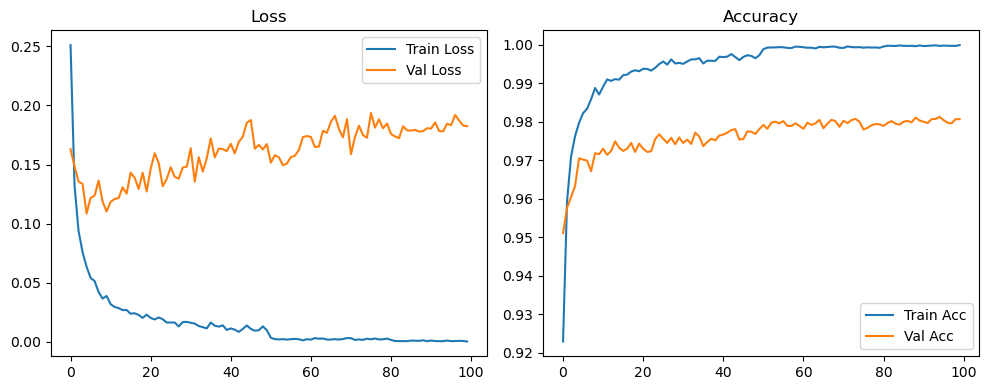

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3068, Acc: 0.9076 | Val Loss: 0.1523, Acc: 0.9553


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1832, Acc: 0.9467 | Val Loss: 0.1393, Acc: 0.9577


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1509, Acc: 0.9545 | Val Loss: 0.1221, Acc: 0.9624


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1298, Acc: 0.9599 | Val Loss: 0.1207, Acc: 0.9656


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1144, Acc: 0.9651 | Val Loss: 0.1095, Acc: 0.9672


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1022, Acc: 0.9685 | Val Loss: 0.1094, Acc: 0.9677


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0937, Acc: 0.9715 | Val Loss: 0.1082, Acc: 0.9702


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0862, Acc: 0.9726 | Val Loss: 0.1092, Acc: 0.9719


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0809, Acc: 0.9745 | Val Loss: 0.1091, Acc: 0.9735


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0774, Acc: 0.9761 | Val Loss: 0.1029, Acc: 0.9727


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0755, Acc: 0.9761 | Val Loss: 0.1035, Acc: 0.9740


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0696, Acc: 0.9779 | Val Loss: 0.1044, Acc: 0.9743


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0675, Acc: 0.9787 | Val Loss: 0.1058, Acc: 0.9729


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0627, Acc: 0.9798 | Val Loss: 0.1082, Acc: 0.9748


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9806 | Val Loss: 0.1153, Acc: 0.9739


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9830 | Val Loss: 0.1062, Acc: 0.9748


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9837 | Val Loss: 0.1250, Acc: 0.9742


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9829 | Val Loss: 0.1134, Acc: 0.9760


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9847 | Val Loss: 0.1160, Acc: 0.9763


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9855 | Val Loss: 0.1128, Acc: 0.9758


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9848 | Val Loss: 0.1265, Acc: 0.9758


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9855 | Val Loss: 0.1239, Acc: 0.9756


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9855 | Val Loss: 0.1267, Acc: 0.9752


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9872 | Val Loss: 0.1194, Acc: 0.9772


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9875 | Val Loss: 0.1212, Acc: 0.9767


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9869 | Val Loss: 0.1340, Acc: 0.9748


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9880 | Val Loss: 0.1320, Acc: 0.9747


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9886 | Val Loss: 0.1431, Acc: 0.9741


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9872 | Val Loss: 0.1360, Acc: 0.9748


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9886 | Val Loss: 0.1410, Acc: 0.9748


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9889 | Val Loss: 0.1378, Acc: 0.9762


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9898 | Val Loss: 0.1325, Acc: 0.9762


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9900 | Val Loss: 0.1462, Acc: 0.9753


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9890 | Val Loss: 0.1409, Acc: 0.9770


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9899 | Val Loss: 0.1563, Acc: 0.9759


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9901 | Val Loss: 0.1471, Acc: 0.9765


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9909 | Val Loss: 0.1493, Acc: 0.9777


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9905 | Val Loss: 0.1435, Acc: 0.9774


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9909 | Val Loss: 0.1388, Acc: 0.9770


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9918 | Val Loss: 0.1540, Acc: 0.9766


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9902 | Val Loss: 0.1416, Acc: 0.9761


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9914 | Val Loss: 0.1357, Acc: 0.9781


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9920 | Val Loss: 0.1478, Acc: 0.9775


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9913 | Val Loss: 0.1546, Acc: 0.9779


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9915 | Val Loss: 0.1521, Acc: 0.9775


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9928 | Val Loss: 0.1624, Acc: 0.9772


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9925 | Val Loss: 0.1631, Acc: 0.9764


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9921 | Val Loss: 0.1537, Acc: 0.9787


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9919 | Val Loss: 0.1613, Acc: 0.9761


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9922 | Val Loss: 0.1413, Acc: 0.9785


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9947 | Val Loss: 0.1476, Acc: 0.9798


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9958 | Val Loss: 0.1455, Acc: 0.9801


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9959 | Val Loss: 0.1459, Acc: 0.9804


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.1457, Acc: 0.9813


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1483, Acc: 0.9808


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1596, Acc: 0.9806


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9971 | Val Loss: 0.1576, Acc: 0.9805


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1598, Acc: 0.9812


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9974 | Val Loss: 0.1556, Acc: 0.9801


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9975 | Val Loss: 0.1658, Acc: 0.9800


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9969 | Val Loss: 0.1592, Acc: 0.9798


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9970 | Val Loss: 0.1589, Acc: 0.9798


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1539, Acc: 0.9794


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1570, Acc: 0.9819


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1570, Acc: 0.9816


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1684, Acc: 0.9802


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9974 | Val Loss: 0.1700, Acc: 0.9805


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9976 | Val Loss: 0.1581, Acc: 0.9812


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1693, Acc: 0.9813


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9979 | Val Loss: 0.1755, Acc: 0.9805


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9973 | Val Loss: 0.1617, Acc: 0.9802


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9974 | Val Loss: 0.1648, Acc: 0.9792


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9975 | Val Loss: 0.1731, Acc: 0.9790


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1627, Acc: 0.9794


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1668, Acc: 0.9793


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9973 | Val Loss: 0.1806, Acc: 0.9799


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1647, Acc: 0.9802


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9975 | Val Loss: 0.1637, Acc: 0.9811


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1741, Acc: 0.9788


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.1903, Acc: 0.9794


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9977 | Val Loss: 0.1747, Acc: 0.9801


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1751, Acc: 0.9798


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1713, Acc: 0.9798


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1695, Acc: 0.9802


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1742, Acc: 0.9804


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.1636, Acc: 0.9818


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9984 | Val Loss: 0.1692, Acc: 0.9806


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1714, Acc: 0.9812


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1730, Acc: 0.9817


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1719, Acc: 0.9808


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1695, Acc: 0.9806


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1781, Acc: 0.9810


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1821, Acc: 0.9798


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1715, Acc: 0.9820


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1742, Acc: 0.9827


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1747, Acc: 0.9821


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1710, Acc: 0.9821


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1745, Acc: 0.9813


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1771, Acc: 0.9822


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1766, Acc: 0.9813


Final Test Loss: 0.1686 Accuracy: 0.9828


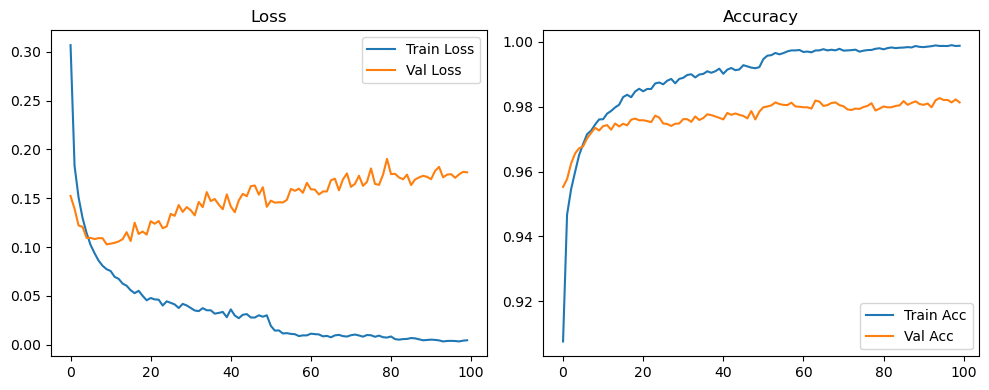

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2085, Acc: 0.9361 | Val Loss: 0.1449, Acc: 0.9564


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0943, Acc: 0.9702 | Val Loss: 0.1551, Acc: 0.9550


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0665, Acc: 0.9793 | Val Loss: 0.1292, Acc: 0.9636


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9846 | Val Loss: 0.1341, Acc: 0.9649


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9874 | Val Loss: 0.1145, Acc: 0.9693


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9888 | Val Loss: 0.1167, Acc: 0.9679


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9904 | Val Loss: 0.1233, Acc: 0.9711


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9902 | Val Loss: 0.1074, Acc: 0.9732


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.1081, Acc: 0.9734


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.1191, Acc: 0.9721


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.1260, Acc: 0.9706


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9943 | Val Loss: 0.1141, Acc: 0.9732


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.1235, Acc: 0.9731


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.1207, Acc: 0.9738


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.1440, Acc: 0.9708


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.1360, Acc: 0.9698


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1352, Acc: 0.9732


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.1419, Acc: 0.9717


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.1279, Acc: 0.9723


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9965 | Val Loss: 0.1213, Acc: 0.9757


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1546, Acc: 0.9715


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9969 | Val Loss: 0.1170, Acc: 0.9769


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1344, Acc: 0.9751


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9970 | Val Loss: 0.1405, Acc: 0.9733


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1341, Acc: 0.9737


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1357, Acc: 0.9740


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1234, Acc: 0.9759


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1297, Acc: 0.9733


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1251, Acc: 0.9769


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9977 | Val Loss: 0.1381, Acc: 0.9758


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1469, Acc: 0.9739


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1466, Acc: 0.9742


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1577, Acc: 0.9722


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1476, Acc: 0.9732


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1368, Acc: 0.9758


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1648, Acc: 0.9739


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1555, Acc: 0.9757


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.1396, Acc: 0.9764


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1395, Acc: 0.9771


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1439, Acc: 0.9760


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.1331, Acc: 0.9752


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.1392, Acc: 0.9762


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1537, Acc: 0.9755


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9983 | Val Loss: 0.1475, Acc: 0.9759


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9982 | Val Loss: 0.1400, Acc: 0.9758


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1277, Acc: 0.9782


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1472, Acc: 0.9755


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1340, Acc: 0.9766


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1471, Acc: 0.9782


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9969 | Val Loss: 0.1448, Acc: 0.9747


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1496, Acc: 0.9766


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1369, Acc: 0.9777


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1267, Acc: 0.9796


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1384, Acc: 0.9784


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1596, Acc: 0.9758


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1631, Acc: 0.9734


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1426, Acc: 0.9768


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1367, Acc: 0.9761


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1608, Acc: 0.9743


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1606, Acc: 0.9749


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1460, Acc: 0.9757


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1443, Acc: 0.9759


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1384, Acc: 0.9778


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1451, Acc: 0.9772


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1467, Acc: 0.9758


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1656, Acc: 0.9751


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1828, Acc: 0.9728


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1668, Acc: 0.9762


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1734, Acc: 0.9744


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1561, Acc: 0.9767


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1531, Acc: 0.9788


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1563, Acc: 0.9758


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1517, Acc: 0.9768


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.1617, Acc: 0.9761


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1816, Acc: 0.9752


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1763, Acc: 0.9749


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1647, Acc: 0.9765


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1527, Acc: 0.9767


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1539, Acc: 0.9765


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.1697, Acc: 0.9752


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1470, Acc: 0.9775


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1561, Acc: 0.9766


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1442, Acc: 0.9783


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1539, Acc: 0.9773


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1622, Acc: 0.9744


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1710, Acc: 0.9755


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1574, Acc: 0.9772


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9989 | Val Loss: 0.1712, Acc: 0.9767


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1440, Acc: 0.9774


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1912, Acc: 0.9739


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1670, Acc: 0.9772


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1594, Acc: 0.9770


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1588, Acc: 0.9781


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1682, Acc: 0.9760


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1697, Acc: 0.9778


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1641, Acc: 0.9789


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9990 | Val Loss: 0.1794, Acc: 0.9775


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.1728, Acc: 0.9770


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1661, Acc: 0.9774


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1743, Acc: 0.9778


Final Test Loss: 0.1461 Accuracy: 0.9805


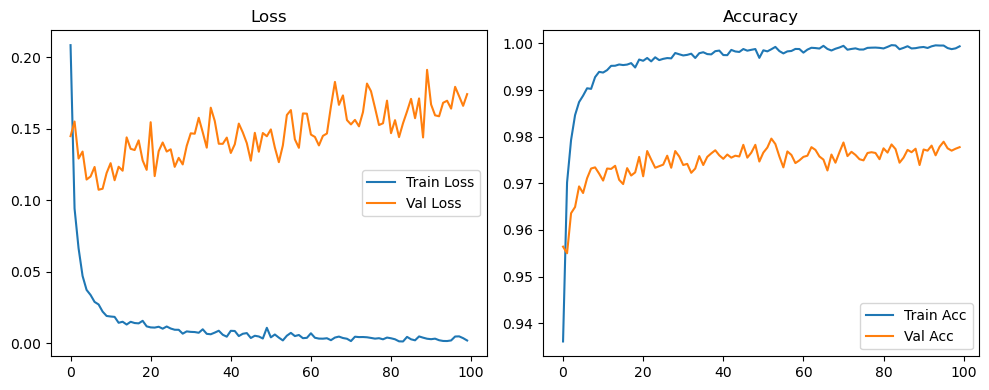

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2333, Acc: 0.9277 | Val Loss: 0.1364, Acc: 0.9606


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1159, Acc: 0.9635 | Val Loss: 0.1321, Acc: 0.9617


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0806, Acc: 0.9753 | Val Loss: 0.1156, Acc: 0.9650


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0651, Acc: 0.9791 | Val Loss: 0.1151, Acc: 0.9680


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0550, Acc: 0.9816 | Val Loss: 0.1019, Acc: 0.9709


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0461, Acc: 0.9854 | Val Loss: 0.1071, Acc: 0.9706


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9861 | Val Loss: 0.1186, Acc: 0.9698


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9875 | Val Loss: 0.1121, Acc: 0.9713


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9889 | Val Loss: 0.1099, Acc: 0.9732


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9895 | Val Loss: 0.1027, Acc: 0.9742


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9910 | Val Loss: 0.1293, Acc: 0.9708


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9911 | Val Loss: 0.1121, Acc: 0.9738


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9923 | Val Loss: 0.1165, Acc: 0.9732


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.1168, Acc: 0.9728


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9912 | Val Loss: 0.1190, Acc: 0.9720


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9939 | Val Loss: 0.1177, Acc: 0.9732


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9928 | Val Loss: 0.1191, Acc: 0.9738


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9943 | Val Loss: 0.1206, Acc: 0.9738


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9945 | Val Loss: 0.1315, Acc: 0.9721


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.1218, Acc: 0.9752


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.1429, Acc: 0.9708


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.1282, Acc: 0.9730


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.1277, Acc: 0.9748


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.1291, Acc: 0.9742


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1310, Acc: 0.9733


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1260, Acc: 0.9758


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1328, Acc: 0.9736


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.1252, Acc: 0.9749


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1369, Acc: 0.9732


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1405, Acc: 0.9742


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9956 | Val Loss: 0.1382, Acc: 0.9730


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9961 | Val Loss: 0.1242, Acc: 0.9749


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1369, Acc: 0.9744


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.1335, Acc: 0.9754


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1431, Acc: 0.9750


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.1292, Acc: 0.9753


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.1427, Acc: 0.9754


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1353, Acc: 0.9758


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1257, Acc: 0.9772


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1284, Acc: 0.9758


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1462, Acc: 0.9737


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1342, Acc: 0.9761


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.1267, Acc: 0.9758


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.1482, Acc: 0.9732


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1468, Acc: 0.9771


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1373, Acc: 0.9752


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1439, Acc: 0.9763


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1417, Acc: 0.9765


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1394, Acc: 0.9767


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1425, Acc: 0.9779


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1415, Acc: 0.9771


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.1581, Acc: 0.9748


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.1393, Acc: 0.9782


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.1427, Acc: 0.9773


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1501, Acc: 0.9767


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1362, Acc: 0.9772


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1512, Acc: 0.9772


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.1632, Acc: 0.9758


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1809, Acc: 0.9743


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9976 | Val Loss: 0.1529, Acc: 0.9761


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1563, Acc: 0.9762


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1523, Acc: 0.9753


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1338, Acc: 0.9782


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1422, Acc: 0.9786


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1631, Acc: 0.9763


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1646, Acc: 0.9753


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1662, Acc: 0.9761


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1543, Acc: 0.9759


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.1479, Acc: 0.9768


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1513, Acc: 0.9775


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.1564, Acc: 0.9773


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1485, Acc: 0.9770


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1540, Acc: 0.9781


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1580, Acc: 0.9772


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1618, Acc: 0.9783


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1718, Acc: 0.9756


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1615, Acc: 0.9772


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1673, Acc: 0.9758


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1689, Acc: 0.9766


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1543, Acc: 0.9770


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1644, Acc: 0.9782


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9986 | Val Loss: 0.1819, Acc: 0.9768


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1629, Acc: 0.9773


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.1673, Acc: 0.9782


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1595, Acc: 0.9792


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1620, Acc: 0.9791


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1648, Acc: 0.9778


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1783, Acc: 0.9776


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1655, Acc: 0.9780


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1618, Acc: 0.9783


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1603, Acc: 0.9788


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1913, Acc: 0.9757


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1841, Acc: 0.9773


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1786, Acc: 0.9782


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1817, Acc: 0.9772


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1807, Acc: 0.9748


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1779, Acc: 0.9753


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1739, Acc: 0.9772


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9984 | Val Loss: 0.1725, Acc: 0.9774


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1853, Acc: 0.9778


Final Test Loss: 0.1572 Accuracy: 0.9784


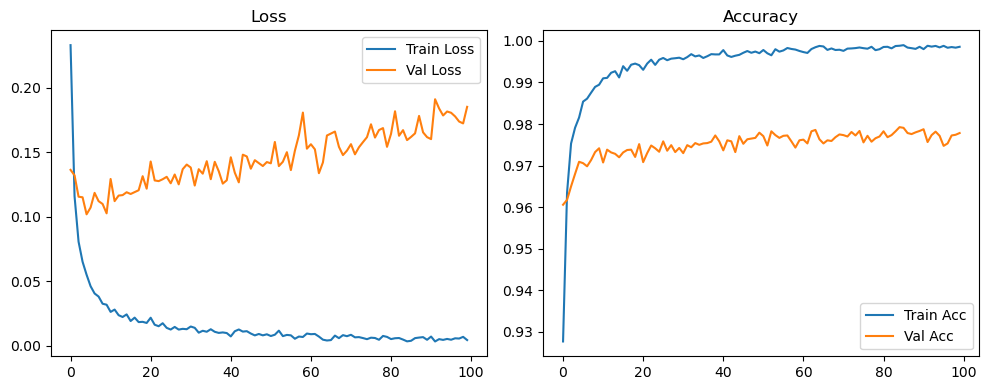

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3025, Acc: 0.9071 | Val Loss: 0.1474, Acc: 0.9567


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1653, Acc: 0.9502 | Val Loss: 0.1314, Acc: 0.9594


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1304, Acc: 0.9602 | Val Loss: 0.1129, Acc: 0.9665


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1126, Acc: 0.9641 | Val Loss: 0.1120, Acc: 0.9678


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1010, Acc: 0.9676 | Val Loss: 0.1051, Acc: 0.9702


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0889, Acc: 0.9720 | Val Loss: 0.1046, Acc: 0.9692


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0843, Acc: 0.9730 | Val Loss: 0.1016, Acc: 0.9702


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0732, Acc: 0.9764 | Val Loss: 0.0937, Acc: 0.9726


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0741, Acc: 0.9763 | Val Loss: 0.0984, Acc: 0.9725


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0682, Acc: 0.9781 | Val Loss: 0.0992, Acc: 0.9728


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0640, Acc: 0.9787 | Val Loss: 0.1031, Acc: 0.9726


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0586, Acc: 0.9807 | Val Loss: 0.1034, Acc: 0.9749


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0558, Acc: 0.9817 | Val Loss: 0.1002, Acc: 0.9738


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9823 | Val Loss: 0.0995, Acc: 0.9733


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0532, Acc: 0.9827 | Val Loss: 0.1002, Acc: 0.9745


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0510, Acc: 0.9839 | Val Loss: 0.0980, Acc: 0.9736


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0469, Acc: 0.9846 | Val Loss: 0.1039, Acc: 0.9733


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0475, Acc: 0.9842 | Val Loss: 0.0987, Acc: 0.9757


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9856 | Val Loss: 0.0997, Acc: 0.9761


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9858 | Val Loss: 0.0991, Acc: 0.9764


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9870 | Val Loss: 0.1065, Acc: 0.9765


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0419, Acc: 0.9862 | Val Loss: 0.1007, Acc: 0.9768


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9874 | Val Loss: 0.0998, Acc: 0.9758


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.1026, Acc: 0.9770


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0392, Acc: 0.9873 | Val Loss: 0.0957, Acc: 0.9788


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9884 | Val Loss: 0.1077, Acc: 0.9760


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9890 | Val Loss: 0.1067, Acc: 0.9772


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9903 | Val Loss: 0.1042, Acc: 0.9768


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9893 | Val Loss: 0.1067, Acc: 0.9761


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9909 | Val Loss: 0.1071, Acc: 0.9782


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9892 | Val Loss: 0.1211, Acc: 0.9740


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9891 | Val Loss: 0.1055, Acc: 0.9763


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.1092, Acc: 0.9778


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9896 | Val Loss: 0.1150, Acc: 0.9770


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9903 | Val Loss: 0.1073, Acc: 0.9774


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9917 | Val Loss: 0.1092, Acc: 0.9777


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9911 | Val Loss: 0.1170, Acc: 0.9776


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9915 | Val Loss: 0.1143, Acc: 0.9774


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9920 | Val Loss: 0.1106, Acc: 0.9782


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9920 | Val Loss: 0.1130, Acc: 0.9775


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.1211, Acc: 0.9769


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.1169, Acc: 0.9774


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9923 | Val Loss: 0.1199, Acc: 0.9778


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.1226, Acc: 0.9772


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9925 | Val Loss: 0.1166, Acc: 0.9766


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9934 | Val Loss: 0.1241, Acc: 0.9772


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9925 | Val Loss: 0.1205, Acc: 0.9776


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.1189, Acc: 0.9768


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.1216, Acc: 0.9780


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9926 | Val Loss: 0.1162, Acc: 0.9797


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9931 | Val Loss: 0.1216, Acc: 0.9770


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9922 | Val Loss: 0.1232, Acc: 0.9780


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.1263, Acc: 0.9775


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.1343, Acc: 0.9771


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9935 | Val Loss: 0.1218, Acc: 0.9777


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9933 | Val Loss: 0.1166, Acc: 0.9783


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9943 | Val Loss: 0.1246, Acc: 0.9774


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.1309, Acc: 0.9782


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.1264, Acc: 0.9769


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9944 | Val Loss: 0.1353, Acc: 0.9778


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9937 | Val Loss: 0.1353, Acc: 0.9769


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9941 | Val Loss: 0.1206, Acc: 0.9787


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9935 | Val Loss: 0.1254, Acc: 0.9785


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9935 | Val Loss: 0.1355, Acc: 0.9774


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.1394, Acc: 0.9768


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9947 | Val Loss: 0.1420, Acc: 0.9768


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9944 | Val Loss: 0.1382, Acc: 0.9772


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9950 | Val Loss: 0.1334, Acc: 0.9786


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9952 | Val Loss: 0.1357, Acc: 0.9787


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.1354, Acc: 0.9797


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.1249, Acc: 0.9798


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9948 | Val Loss: 0.1347, Acc: 0.9779


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9951 | Val Loss: 0.1326, Acc: 0.9798


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9951 | Val Loss: 0.1301, Acc: 0.9790


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9939 | Val Loss: 0.1419, Acc: 0.9771


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9952 | Val Loss: 0.1376, Acc: 0.9781


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9960 | Val Loss: 0.1361, Acc: 0.9782


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9950 | Val Loss: 0.1419, Acc: 0.9800


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9953 | Val Loss: 0.1418, Acc: 0.9793


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9959 | Val Loss: 0.1415, Acc: 0.9793


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9949 | Val Loss: 0.1382, Acc: 0.9780


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9955 | Val Loss: 0.1438, Acc: 0.9783


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9962 | Val Loss: 0.1481, Acc: 0.9792


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1525, Acc: 0.9777


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9955 | Val Loss: 0.1450, Acc: 0.9769


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9951 | Val Loss: 0.1587, Acc: 0.9782


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9957 | Val Loss: 0.1564, Acc: 0.9773


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9954 | Val Loss: 0.1516, Acc: 0.9770


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9954 | Val Loss: 0.1441, Acc: 0.9773


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9955 | Val Loss: 0.1386, Acc: 0.9786


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9959 | Val Loss: 0.1402, Acc: 0.9787


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9957 | Val Loss: 0.1391, Acc: 0.9783


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9952 | Val Loss: 0.1414, Acc: 0.9784


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9959 | Val Loss: 0.1419, Acc: 0.9774


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9954 | Val Loss: 0.1389, Acc: 0.9784


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1522, Acc: 0.9781


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9961 | Val Loss: 0.1371, Acc: 0.9792


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9959 | Val Loss: 0.1468, Acc: 0.9786


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9961 | Val Loss: 0.1420, Acc: 0.9796


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9962 | Val Loss: 0.1417, Acc: 0.9796


Final Test Loss: 0.1333 Accuracy: 0.9803


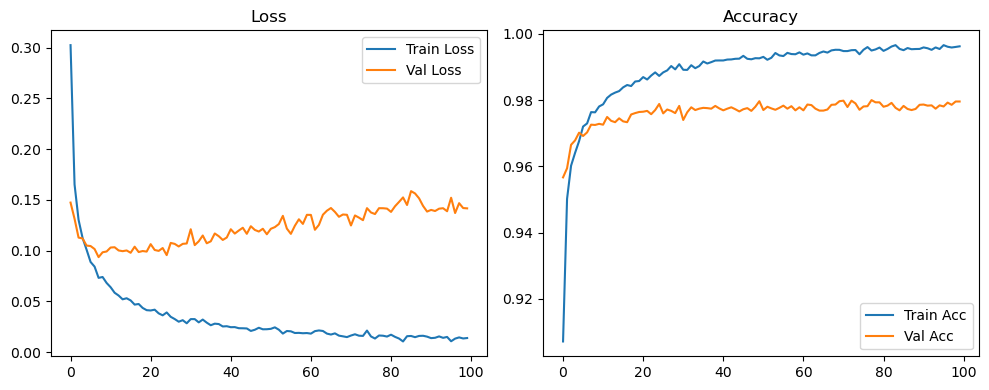

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2054, Acc: 0.9365 | Val Loss: 0.1310, Acc: 0.9599


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0849, Acc: 0.9738 | Val Loss: 0.1348, Acc: 0.9590


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0568, Acc: 0.9813 | Val Loss: 0.1115, Acc: 0.9679


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9874 | Val Loss: 0.1157, Acc: 0.9680


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9891 | Val Loss: 0.1131, Acc: 0.9697


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.1094, Acc: 0.9702


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9921 | Val Loss: 0.1046, Acc: 0.9728


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.1113, Acc: 0.9731


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.1108, Acc: 0.9744


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.1093, Acc: 0.9728


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.1093, Acc: 0.9740


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.1157, Acc: 0.9713


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.1290, Acc: 0.9696


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1129, Acc: 0.9739


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1217, Acc: 0.9745


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1227, Acc: 0.9745


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1296, Acc: 0.9739


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.1255, Acc: 0.9717


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1208, Acc: 0.9735


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1298, Acc: 0.9732


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1320, Acc: 0.9712


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1241, Acc: 0.9735


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1230, Acc: 0.9750


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1337, Acc: 0.9739


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.1286, Acc: 0.9736


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1172, Acc: 0.9755


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1181, Acc: 0.9759


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1359, Acc: 0.9739


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1280, Acc: 0.9750


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1320, Acc: 0.9756


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1381, Acc: 0.9729


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1319, Acc: 0.9753


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1431, Acc: 0.9733


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1284, Acc: 0.9760


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1333, Acc: 0.9757


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1382, Acc: 0.9743


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1420, Acc: 0.9748


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1369, Acc: 0.9748


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1117, Acc: 0.9775


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1400, Acc: 0.9738


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1288, Acc: 0.9767


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9982 | Val Loss: 0.1479, Acc: 0.9752


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1329, Acc: 0.9764


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1287, Acc: 0.9773


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1228, Acc: 0.9772


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1340, Acc: 0.9745


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1591, Acc: 0.9744


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1350, Acc: 0.9757


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1498, Acc: 0.9728


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1456, Acc: 0.9758


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9983 | Val Loss: 0.1328, Acc: 0.9766


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1355, Acc: 0.9758


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1324, Acc: 0.9780


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1481, Acc: 0.9756


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1404, Acc: 0.9753


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1375, Acc: 0.9746


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1310, Acc: 0.9772


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1391, Acc: 0.9768


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1452, Acc: 0.9752


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1368, Acc: 0.9764


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1431, Acc: 0.9760


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1467, Acc: 0.9757


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1406, Acc: 0.9773


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1329, Acc: 0.9765


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1464, Acc: 0.9778


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1480, Acc: 0.9764


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1438, Acc: 0.9768


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1396, Acc: 0.9772


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1465, Acc: 0.9759


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1442, Acc: 0.9773


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1417, Acc: 0.9766


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1441, Acc: 0.9769


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1367, Acc: 0.9788


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1502, Acc: 0.9764


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1480, Acc: 0.9768


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1591, Acc: 0.9750


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1554, Acc: 0.9743


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1458, Acc: 0.9748


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1545, Acc: 0.9752


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1466, Acc: 0.9759


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1606, Acc: 0.9745


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1633, Acc: 0.9759


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1427, Acc: 0.9785


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1578, Acc: 0.9762


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1719, Acc: 0.9747


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1496, Acc: 0.9759


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1558, Acc: 0.9770


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9994 | Val Loss: 0.1619, Acc: 0.9768


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1586, Acc: 0.9762


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1695, Acc: 0.9748


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1669, Acc: 0.9761


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1640, Acc: 0.9767


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1654, Acc: 0.9758


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1593, Acc: 0.9768


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1611, Acc: 0.9768


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1657, Acc: 0.9768


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1565, Acc: 0.9764


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1632, Acc: 0.9767


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1525, Acc: 0.9780


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.1523, Acc: 0.9768


Final Test Loss: 0.1593 Accuracy: 0.9772


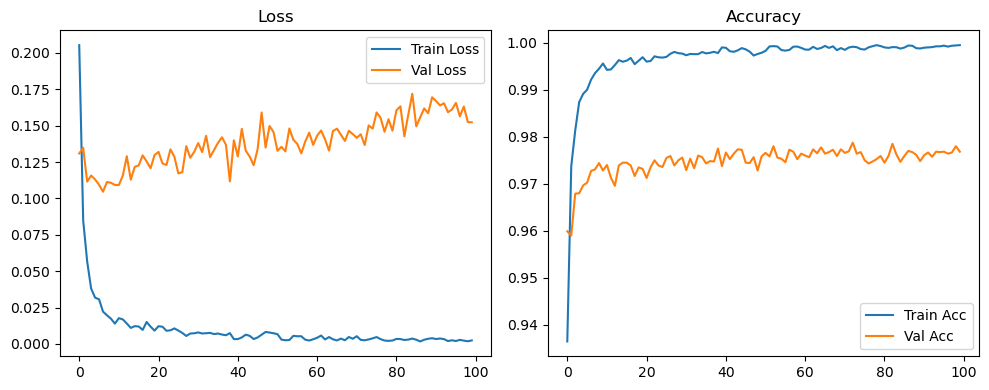

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2371, Acc: 0.9279 | Val Loss: 0.1366, Acc: 0.9581


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1045, Acc: 0.9664 | Val Loss: 0.1216, Acc: 0.9616


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0760, Acc: 0.9748 | Val Loss: 0.1138, Acc: 0.9649


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0594, Acc: 0.9810 | Val Loss: 0.1144, Acc: 0.9679


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0453, Acc: 0.9850 | Val Loss: 0.1001, Acc: 0.9721


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0442, Acc: 0.9854 | Val Loss: 0.1049, Acc: 0.9708


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0384, Acc: 0.9872 | Val Loss: 0.1143, Acc: 0.9683


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9898 | Val Loss: 0.1288, Acc: 0.9651


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.1007, Acc: 0.9732


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9916 | Val Loss: 0.1112, Acc: 0.9728


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9915 | Val Loss: 0.1148, Acc: 0.9718


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.1067, Acc: 0.9733


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9929 | Val Loss: 0.1092, Acc: 0.9720


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.1111, Acc: 0.9728


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1180, Acc: 0.9715


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.1190, Acc: 0.9746


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1072, Acc: 0.9752


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.1110, Acc: 0.9733


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.1191, Acc: 0.9729


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9941 | Val Loss: 0.1258, Acc: 0.9720


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.1244, Acc: 0.9738


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.1098, Acc: 0.9758


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1182, Acc: 0.9749


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.1191, Acc: 0.9748


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1213, Acc: 0.9752


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.1344, Acc: 0.9726


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9959 | Val Loss: 0.1281, Acc: 0.9728


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.1278, Acc: 0.9734


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.1232, Acc: 0.9750


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1213, Acc: 0.9742


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1251, Acc: 0.9746


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.1125, Acc: 0.9748


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1140, Acc: 0.9761


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1210, Acc: 0.9752


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1132, Acc: 0.9761


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1239, Acc: 0.9753


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1223, Acc: 0.9759


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1207, Acc: 0.9736


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1196, Acc: 0.9773


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1130, Acc: 0.9769


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1260, Acc: 0.9758


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1320, Acc: 0.9753


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1190, Acc: 0.9768


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1210, Acc: 0.9767


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1272, Acc: 0.9768


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1416, Acc: 0.9754


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1262, Acc: 0.9762


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1320, Acc: 0.9762


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1369, Acc: 0.9754


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1138, Acc: 0.9786


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1292, Acc: 0.9758


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1212, Acc: 0.9759


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1249, Acc: 0.9765


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1277, Acc: 0.9760


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1205, Acc: 0.9765


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1267, Acc: 0.9761


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1246, Acc: 0.9778


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1347, Acc: 0.9768


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1391, Acc: 0.9742


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1380, Acc: 0.9765


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1378, Acc: 0.9770


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1435, Acc: 0.9758


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1573, Acc: 0.9731


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1360, Acc: 0.9762


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1417, Acc: 0.9748


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1388, Acc: 0.9763


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1397, Acc: 0.9767


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1451, Acc: 0.9764


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1356, Acc: 0.9757


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1334, Acc: 0.9772


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1391, Acc: 0.9745


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1360, Acc: 0.9764


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1435, Acc: 0.9768


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1289, Acc: 0.9776


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1443, Acc: 0.9775


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1507, Acc: 0.9759


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1462, Acc: 0.9750


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1396, Acc: 0.9777


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1416, Acc: 0.9775


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1475, Acc: 0.9781


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1495, Acc: 0.9771


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1563, Acc: 0.9754


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1466, Acc: 0.9762


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1414, Acc: 0.9776


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1420, Acc: 0.9774


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1534, Acc: 0.9768


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1471, Acc: 0.9779


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1582, Acc: 0.9755


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1468, Acc: 0.9762


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1379, Acc: 0.9782


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1512, Acc: 0.9766


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1484, Acc: 0.9780


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.1416, Acc: 0.9781


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1342, Acc: 0.9791


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1468, Acc: 0.9781


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1486, Acc: 0.9762


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1364, Acc: 0.9794


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1562, Acc: 0.9768


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1511, Acc: 0.9770


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1691, Acc: 0.9775


Final Test Loss: 0.1366 Accuracy: 0.9793


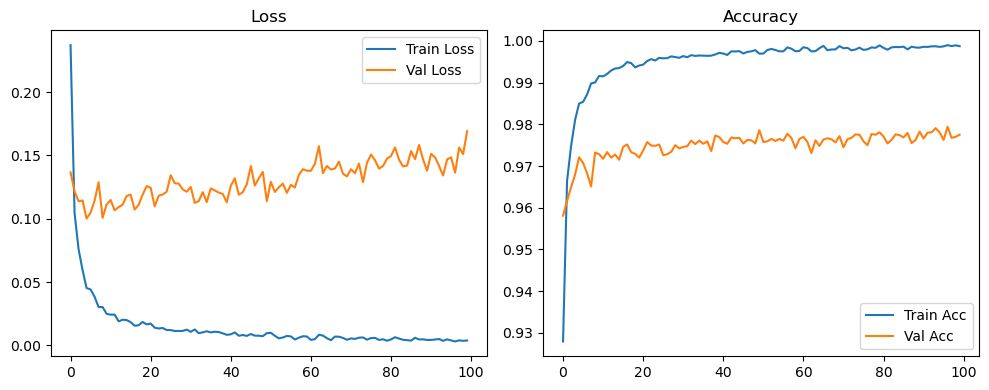

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3371, Acc: 0.8973 | Val Loss: 0.1463, Acc: 0.9561


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1630, Acc: 0.9500 | Val Loss: 0.1275, Acc: 0.9603


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1242, Acc: 0.9613 | Val Loss: 0.1101, Acc: 0.9673


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1072, Acc: 0.9659 | Val Loss: 0.1057, Acc: 0.9679


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0988, Acc: 0.9684 | Val Loss: 0.1009, Acc: 0.9692


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0868, Acc: 0.9720 | Val Loss: 0.0960, Acc: 0.9719


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0758, Acc: 0.9752 | Val Loss: 0.0923, Acc: 0.9714


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0726, Acc: 0.9761 | Val Loss: 0.0967, Acc: 0.9725


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0666, Acc: 0.9784 | Val Loss: 0.0903, Acc: 0.9743


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0627, Acc: 0.9791 | Val Loss: 0.0972, Acc: 0.9725


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0610, Acc: 0.9792 | Val Loss: 0.0886, Acc: 0.9748


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0537, Acc: 0.9824 | Val Loss: 0.0924, Acc: 0.9752


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0526, Acc: 0.9823 | Val Loss: 0.0967, Acc: 0.9738


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0528, Acc: 0.9821 | Val Loss: 0.0904, Acc: 0.9731


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0513, Acc: 0.9826 | Val Loss: 0.1005, Acc: 0.9742


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0471, Acc: 0.9843 | Val Loss: 0.0979, Acc: 0.9752


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9862 | Val Loss: 0.0986, Acc: 0.9726


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9868 | Val Loss: 0.0919, Acc: 0.9755


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9865 | Val Loss: 0.0984, Acc: 0.9751


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0388, Acc: 0.9865 | Val Loss: 0.0985, Acc: 0.9751


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0400, Acc: 0.9860 | Val Loss: 0.1052, Acc: 0.9744


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9874 | Val Loss: 0.0967, Acc: 0.9762


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9877 | Val Loss: 0.0987, Acc: 0.9762


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9889 | Val Loss: 0.1035, Acc: 0.9761


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9882 | Val Loss: 0.1050, Acc: 0.9758


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9889 | Val Loss: 0.0943, Acc: 0.9774


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9894 | Val Loss: 0.1034, Acc: 0.9765


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9889 | Val Loss: 0.1016, Acc: 0.9746


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9900 | Val Loss: 0.1004, Acc: 0.9759


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9900 | Val Loss: 0.0985, Acc: 0.9760


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9917 | Val Loss: 0.1007, Acc: 0.9765


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9910 | Val Loss: 0.0991, Acc: 0.9772


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.1085, Acc: 0.9749


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9908 | Val Loss: 0.1030, Acc: 0.9768


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9912 | Val Loss: 0.1060, Acc: 0.9755


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9919 | Val Loss: 0.0991, Acc: 0.9779


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.1086, Acc: 0.9748


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9918 | Val Loss: 0.1045, Acc: 0.9761


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9923 | Val Loss: 0.1079, Acc: 0.9763


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.1029, Acc: 0.9768


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9921 | Val Loss: 0.1080, Acc: 0.9770


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9926 | Val Loss: 0.1069, Acc: 0.9774


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9922 | Val Loss: 0.1112, Acc: 0.9758


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9921 | Val Loss: 0.1071, Acc: 0.9760


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9922 | Val Loss: 0.1062, Acc: 0.9761


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.1113, Acc: 0.9758


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.1037, Acc: 0.9777


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.1131, Acc: 0.9760


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9924 | Val Loss: 0.1057, Acc: 0.9787


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.1061, Acc: 0.9769


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9927 | Val Loss: 0.1080, Acc: 0.9771


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9927 | Val Loss: 0.1048, Acc: 0.9769


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.1111, Acc: 0.9772


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.1066, Acc: 0.9772


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.1059, Acc: 0.9785


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9938 | Val Loss: 0.1206, Acc: 0.9769


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9934 | Val Loss: 0.1137, Acc: 0.9765


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.1131, Acc: 0.9778


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.1154, Acc: 0.9759


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1094, Acc: 0.9772


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.1116, Acc: 0.9778


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.1086, Acc: 0.9778


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.1161, Acc: 0.9773


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.1115, Acc: 0.9771


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.1152, Acc: 0.9779


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9953 | Val Loss: 0.1200, Acc: 0.9769


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.1238, Acc: 0.9773


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.1185, Acc: 0.9772


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9947 | Val Loss: 0.1233, Acc: 0.9773


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.1197, Acc: 0.9766


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9946 | Val Loss: 0.1161, Acc: 0.9781


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1146, Acc: 0.9791


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.1250, Acc: 0.9778


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.1144, Acc: 0.9782


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.1217, Acc: 0.9781


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1139, Acc: 0.9780


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9953 | Val Loss: 0.1149, Acc: 0.9782


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1191, Acc: 0.9790


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.1199, Acc: 0.9785


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1291, Acc: 0.9765


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.1265, Acc: 0.9781


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1301, Acc: 0.9767


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1330, Acc: 0.9778


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1248, Acc: 0.9786


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1296, Acc: 0.9772


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1329, Acc: 0.9785


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1342, Acc: 0.9775


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1337, Acc: 0.9756


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.1279, Acc: 0.9776


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.1279, Acc: 0.9768


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1352, Acc: 0.9772


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9958 | Val Loss: 0.1276, Acc: 0.9784


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.1379, Acc: 0.9776


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9953 | Val Loss: 0.1350, Acc: 0.9772


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9963 | Val Loss: 0.1291, Acc: 0.9778


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.1316, Acc: 0.9762


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9952 | Val Loss: 0.1242, Acc: 0.9782


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1360, Acc: 0.9773


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.1233, Acc: 0.9796


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.1248, Acc: 0.9783


Final Test Loss: 0.1163 Accuracy: 0.9798


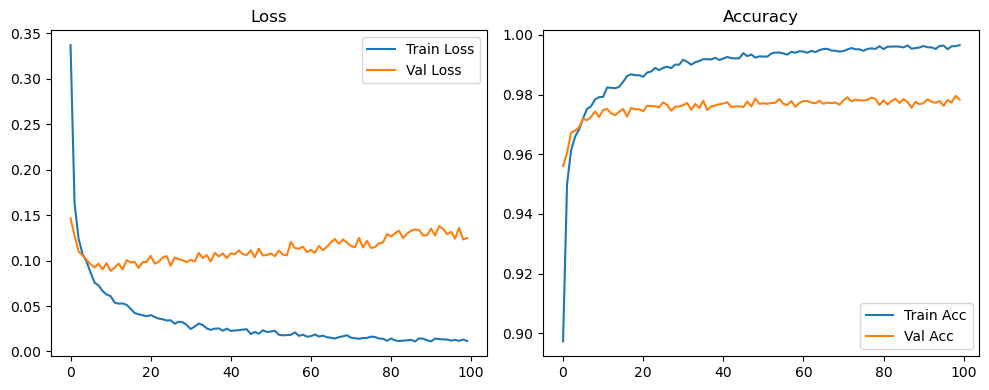

🏆 Best Config: batch128_lr0.01_0.005_0.002_dp0.2 Accuracy: 0.9849


In [8]:
root_path = "MLP_1024_4bit_regular_SiLU"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)